# Summary

Solve for a time-invariant or "steady-state" profile.

This is achieved by first integrating Hamilton's equations along an erosion ray trajectory initiated at a constant velocity "normal fault" boundary. Copies of this ray are then placed at uniformly spaced (vertically downwards) intervals along the boundary, generating a staggered time-sequence of rays whose ensemble positions at an appropriately chosen time slice constitute a time-invariant profile.

Visualization of the ray ensemble is carried out, along with graphing of properties of the time-invariant profile across the model domain. Comparison is made with the "steady-state" profile derived by integrating the model erosion equation directly (via a polynomial in $\mathrm{d}z/\mathrm{d}x$).

### Parameter files

In [64]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():

#     pr_filenames = ['TimeInvariant_eta1p5_Ci0p1']
#     pr_filenames = ['TimeInvariant_eta1p5_Ci1']
#     pr_filenames = ['TimeInvariant_eta1p5_Ci4']
    
#     pr_filenames = ['TimeInvariant_eta0p5_Ci0p1']
#     pr_filenames = ['TimeInvariant_eta0p5_Ci1']
    pr_filenames = ['TimeInvariant_eta0p5_Ci4']

#     pr_filenames = ['TimeInvariant_eta0p25_Ci4']

else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Preliminaries

In [65]:
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import simplify, Matrix, Eq, Rational, \
                    factor, poly, solve, numer, deg
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d, convert, omitdict, round as gmround
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations, EquationSubset, gradient_value
from gme.ode_raytracing import TimeInvariantSolution
from gme.plot import TimeInvariantPlots

# Import units & dimensions
from sympy.physics.units \
    import Quantity, Dimension, \
            length, speed, velocity, time, \
            km, cm, mm, meter, meters, \
            convert_to, percent, degrees, radians
from sympy.physics.units.systems import SI

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','RayTracing')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/RayTracing',
 ['TimeInvariant_eta0p5_Ci4'])

In [66]:
# Read and combine the default and job parameter files, and report

parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
pr = Parameters(parameters_dict, evaluations={}, sequence=())
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'TimeInvariantSolutions',
    'short_name': 'tis',
    'subtitle': '',
    'title': 'Time-invariant profile solution: sin(beta), ramp, eta=1/2, '
             'mu=1/4, Ci=4deg',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/4,
    't_xiv0_list': None,
    'varepsilonhat': 1/100,
    'varphi_0': 2.641e-05,
    'varphi_type': 'ramp',
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': None}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'DOP853', 'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 6,
    'vb_res': 101}
{   'do_eliminate_caustics': True,
    'n_isochrones': 30,
    'spline_order': 3,
    't_

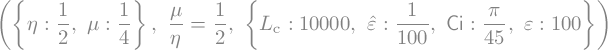

In [38]:
# Create a dict of the key physics parameters to be used in substitutions
subexp = {
    eta: pr.model.eta,
    mu: pr.model.mu
}
sub = {
    Ci: pr.model.Ci, 
    Lc: pr.model.Lc, 
    varepsilonhat: pr.model.varepsilonhat, 
    varepsilon: pr.model.varepsilonhat*pr.model.Lc
}
subexp, Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Equations

Derive the GME equation set (using SymPy) for a specific erosion model.

In [5]:
gmeq = Equations( eta=pr.model.eta, 
                  mu=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=pr.plot.do_huygens_wavelets | pr.plot.do_ray_conjugacy,
                  parameters=sub, do_raw=True )

# Integration

Integrate Hamilton's equations in $(\mathbf{r}, \mathbf{\widetilde{p}})[t]$ for a given vertical component of the erosion rate (initial condition) equivalent to a constant vertical velocity (boundary condition). In other words, given a value for vertical slip rate $\xi^{\downarrow}$ at the boundary at $x=0$, where the initial ray position is $\left.(r^x, r^z)\right|_{t=0} = (0,0)$, specify the initial value of the vertical component of the normal-slowness covector $p_z[t=0] = \left.-1/\xi^{\downarrow}\right|_{x=0}$.  The horizontal component of the initial covector $p_x[t=0]$ is computed by calculating the surface gradient $\left.\tan\beta\right|_{x=0}$ from the erosion model and then using $-p_x/p_z = \tan\beta$.

Various ODE quadrature methods provided by SciPy's `solve_ivp` function can be used here:
"DOP853" (explicit Runge-Kutta method of order 8(5,3)  with dense output of order 7); basic Runge-Kutta (RK45 or RK23); "Radau" (implicit Runge-Kutta method of the Radau IIA family of order 5); "BDF" (implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation); "LSODA" (Adams/BDF method with automatic stiffness detection and switching). "Radau" is by far the most accurate (in terms of computing surface gradient); "DOP853" is less accurate, but its computation of vertical erosion rate is quite robust. "BDF" computes gradient a bit better, but its vertical erosion rate is less accurate. All quadrature methods have very similar timings.


Test timings and notes for `TimeInvariant_tanbeta_rampflat_eta1p0_xiv25_xh0p9`:
  - DOP853:  335ms
      - ~1% errors in relative gradient, minor error in vertical erosion rate
  - Radau:   340ms
      - better than ~0.1% errors in relative gradient, **robust** vertical erosion rate
  - RK45:   330ms
      - ~1.5% errors in relative gradient,  moderate error in vertical erosion rate
  - RK23:   330ms
      - ~1.5% errors in relative gradient,  moderate error in vertical erosion rate
  - BDF:   345ms
      - ~0.3% errors in relative gradient, moderate error in vertical erosion rate
  - LSODA:   335ms
      - ~1% errors in relative gradient, moderate error in vertical erosion rate

In [40]:
pr.model.beta_0 = float(beta_0.subs(e2d(gmeq.beta0_Ci_eqn
                                        .subs(omitdict(sub,[beta_0])).subs(subexp))))
sub.update({beta_0:pr.model.beta_0})
convert(Eq(beta_0, pr.model.beta_0), n=2, units=degrees, do_raw=False)

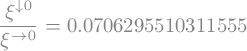

In [41]:
xivh0_ = float((xiv_0/xih_0).subs(e2d(gmeq.xiv0_xih0_Ci_eqn)).subs(sub).subs(subexp).n())
sub.update({(xiv_0/xih_0):xivh0_})
Eq(xiv_0/xih_0, sub[xiv_0/xih_0])

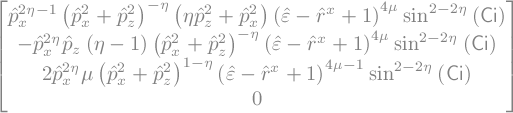

In [42]:
gmeq.hamiltons_ndim_eqns

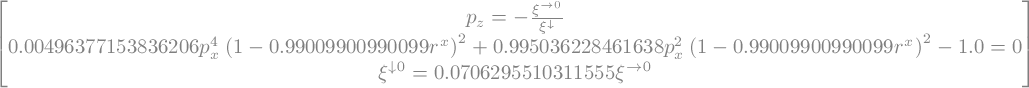

In [43]:
gmeq_ndim_subset = EquationSubset(gmeq, sub, do_ndim=True, do_revert=True) 
Matrix([
    gmeq_ndim_subset.pz_xiv_eqn,
    gmeq_ndim_subset.poly_px_xiv0_eqn,
    gmeq_ndim_subset.xiv0_xih0_Ci_eqn
])

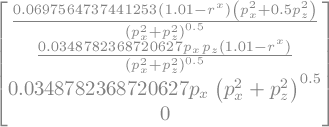

In [44]:
Matrix([gmeq_ndim_subset.hamiltons_eqns])

Create an instance of the ODE solution object.

In [45]:
pr.solve.choice, pr.solve.method[pr.solve.choice]

('Hamilton', 'DOP853')

In [46]:
xmax_ = 0.999 #float(1-varepsilonhat.subs(sub))

In [47]:
gmes = TimeInvariantSolution( gmeq_ndim_subset, parameters=sub, 
                              t_end=pr.solve.t_end, t_distribn=pr.solve.t_distribn, 
                              x_stop=xmax_,
                              n_t=pr.solve.ray_n_t,
                              choice=pr.solve.choice, 
                              method=pr.solve.method[pr.solve.choice],
                              do_dense=pr.solve.do_dense )

Solve Hamilton's ODEs using DOP853 method of integration


Set of initial conditions for the ray.

In [48]:
gmes.initial_conditions()

Perform integration of the coupled ODEs.

In [49]:
gmes.solve()
print('Message: {}\nSuccess? {}\nStatus: {}\nt_final: {}\nrx_final: {}'
      .format(gmes.solns[0].message, gmes.solns[0].success,
              gmes.solns[0].status, gmes.solns[0].t[-1], gmes.solns[0].y[0][-1]) )

Message: A termination event occurred.
Success? True
Status: 1
t_final: 5.960066666666667
rx_final: 0.9987541330435151


Process the above output, which takes the form of time series of positions $\{\mathbf{r}\}$ and front normal slownesses  $\{\mathbf{\widetilde{p}}\}$, into various arrays.

In [50]:
gmes.postprocessing(spline_order=pr.resolve.spline_order)

In [51]:
gmes.more_postprocessing(spline_order=pr.resolve.spline_order, extrapolation_mode=1)

Generate a time-invariant profile by spatially integrating the topographic gradients implied by the time series of front normal slownesses  $\{\mathbf{\widetilde{p}}\}$. 

This profile can alternatively be generated by synthesizing a staggered sequence of rays and gathering all the ray positions $\{\mathbf{r}\}$ for a chosen time slice. This has already been done in the post-processing step.

In [52]:
gmes.integrate_h_profile(do_truncate=True, x_max=1) #xmax_

In [53]:
# t_0p95 = symbols(r't^{\rightarrow_{0.95}}',  real=True, negative=False)
# h_0p95 = symbols(r'h_{0.95}',  real=True, negative=False)
# t_0p9 = symbols(r't^{\rightarrow_{0.9}}',  real=True, negative=False)
# h_0p9 = symbols(r'h_{0.9}',  real=True, negative=False)

# Results

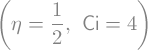

In [54]:
Eq(eta,pr.model.eta), Eq(Ci,deg(pr.model.Ci))

In [55]:
x_ = 0.9
Eq(h_0p9, gmes.h_interp(x_)), Eq(th_0p9, gmes.t_interp_x(x_))

In [22]:
x_ = 0.95
Eq(h_0p95, gmes.h_interp(x_)), Eq(th_0p95, gmes.t_interp_x(x_))

# Plots

## Preliminaries

In [23]:
gr = TimeInvariantPlots()

In [24]:
prefix = pr.job.short_name

suffix  = f'_eta{float(sy.N(pr.model.eta))}'
suffix += f'_Ci{float(sy.N(sy.deg(pr.model.Ci)))}'
# suffix += f'_ratio{float(sy.N(gmeq.mu/gmeq.eta))}' if gmeq.mu!=Rational(1,2) else ''
# suffix += f'_xiv{float(sy.N(gmes.parameters[xiv_0])):1.0f}'
# suffix = (suffix if pr.model.varphi_type=='ramp' \
#             else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}')

job_name = prefix+suffix.replace('.','p')
job_name

'tis_eta0p5_Ci4p0'

## Graphs

Graph a selection of staggered ray solutions (colorized lines with arrows) along with the time-invariant solution solved for in two ways (gathering of staggered ray termini or integration of gradients along a ray).

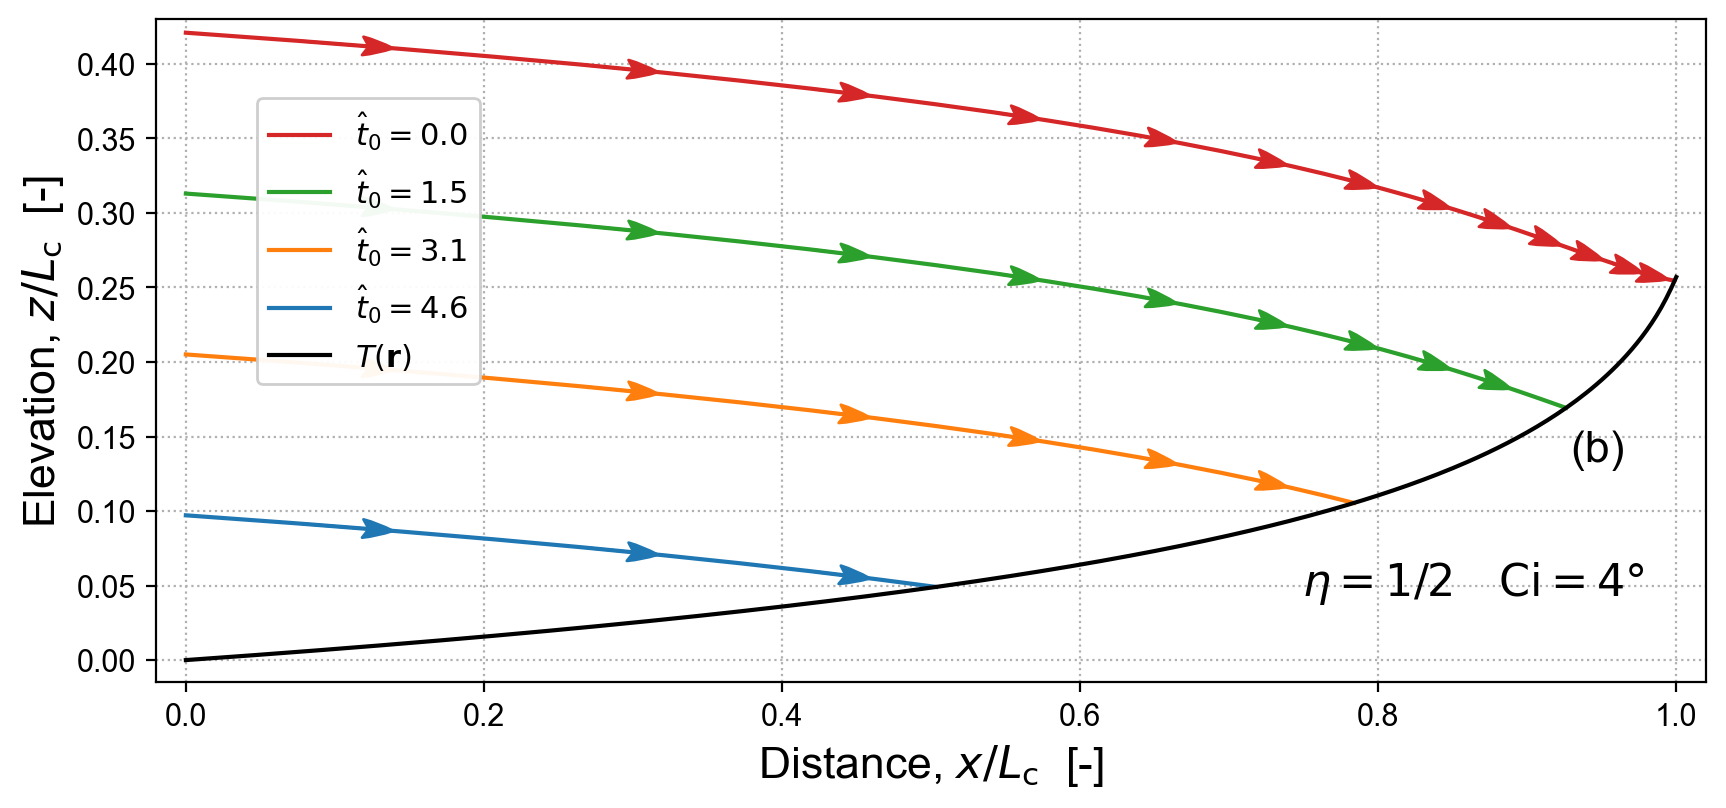

In [67]:
gr.profile_h_rays( gmes, gmeq, sub, job_name+'_h_rays', fig_size=(10,7), 
                   x_limits=pr.plot.ray_x_limits, 
                   y_limits=pr.plot.ray_y_limits, 
                   eta_label_xy=pr.plot.ray_eta_xy, 
                   n_points=pr.plot.rays_n_points,
                   n_rays=pr.plot.n_rays,
                   profile_subsetting=pr.plot.profile_subsetting, 
                   do_pub_label=pr.plot.do_pub_labeling, 
                   pub_label=pr.plot.pub_labels['profile_h_rays'],
                   pub_label_xy=pr.plot.pub_label_posns['profile_h_rays'] )

Graph the behavior of $\mathbf{r}$, $\mathbf{v}$, and  $\mathbf{\widetilde{p}}$ along a time-invariant profile, along with a measure of $\mathbf{v},\mathbf{\widetilde{p}}$ anisotropy.

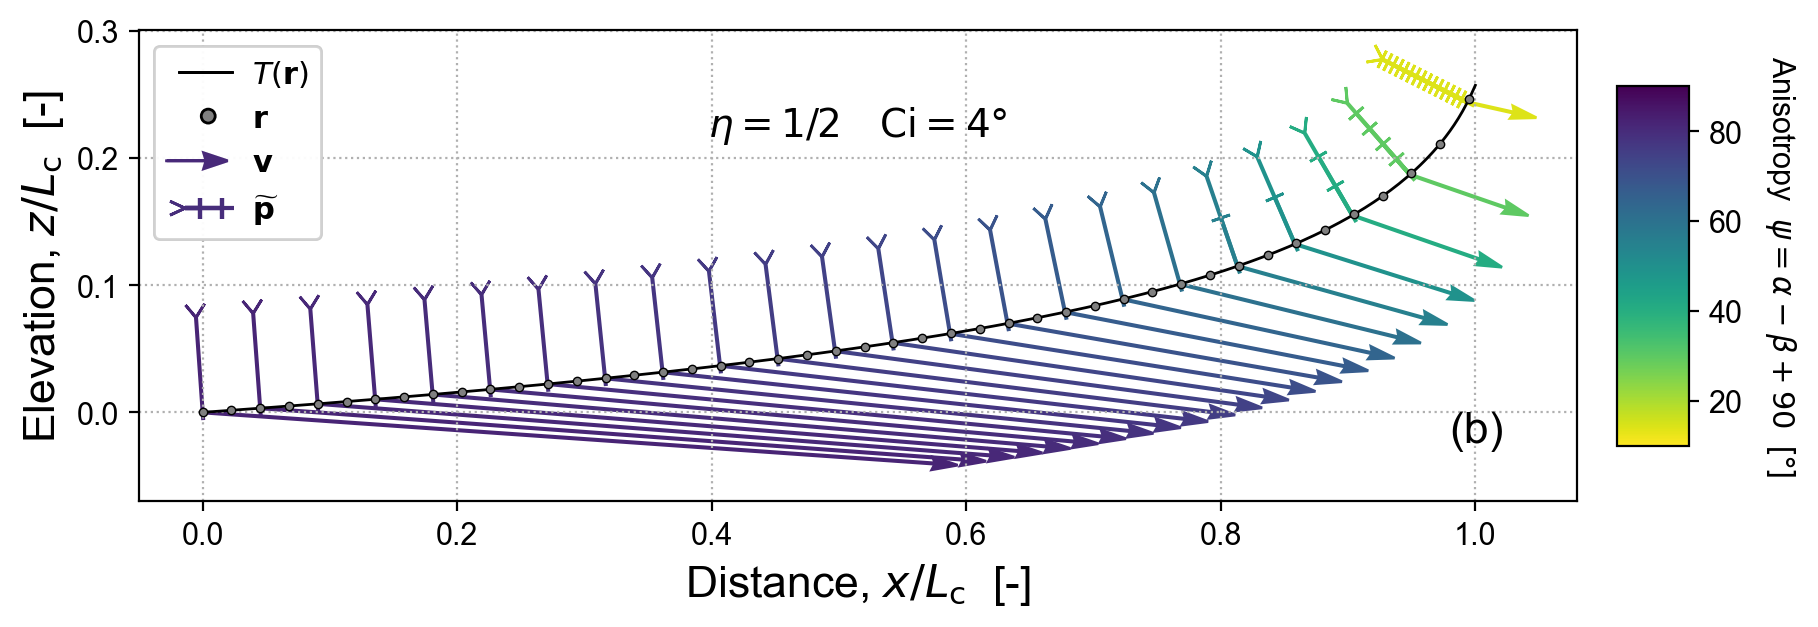

In [57]:
gr.profile_aniso( gmes, gmeq, sub, job_name+'_aniso', fig_size=(10,7), 
                  y_limits=pr.plot.aniso_y_limits, 
                  xf_stop=0.995,
                  n_points=pr.plot.aniso_n_points, n_arrows=(pr.plot.aniso_n_points+1)//2, 
                  vdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABxoAAAJzCAYAAAA4FRb2AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAewgAAHsIBbtB1PgAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nOzdeXxU1f3/8deZPQmBbIQEEkBQqYLgAmhdwB2wota6ttXaWvu1bl+xy7dqtYttv2q1P5cqVduvdLFqbbUVtYpaFbR1VwQXRNYkkIWQsCWZzHJ+f0xyk2FJJiEzk2Tez8cjD8655957zg35kGE+c84x1lpERERERERERERERERERHrCle4BiIiIiIiIiIiIiIiIiMjAo0SjiIiIiIiIiIiIiIiIiPSYEo0iIiIiIiIiIiIiIiIi0mNKNIqIiIiIiIiIiIiIiIhIjynRKCIiIiIiIiIiIiIiIiI9pkSjiIiIiIiIiIiIiIiIiPSYEo0iIiIiIiIiIiIiIiIi0mNKNIqIiIiIiIiIiIiIiIhIjynRKCIiIiIiIiIiIiIiIiI9pkSjiIiIiIiIiIiIiIiIiPSYEo0iIiIiIiIiIiIiIiIi0mNKNIqIiIiIiIiIiIiIiIhIjynRKCIiIiIiIiIiIiIiIiI9pkSjiIiIiIiIiIiIiIiIiPSYEo0iIiIiIiIiIiIiIiIi0mNKNIqIiIiIiIiIiIiIiIhIjynRKCIiIiIiIiIiIiIiIiI9pkSjiIiIiIiIiIiIiIiIiPSYEo0iIiIiIiIiIiIiIiIi0mNKNPYBE/NlY8wLxph6Y0yLMWaNMeb3xphpfXB/lzHmK8aY54wxdcaYoDGmwhjzpDHmLGOM6YvnEBEREREREREREREREUmUsdamewwDmjEmC3gM+MIeTokA11trb+nl/fOBvwMzujjtJeA8a21tb/oQERERERERERERERER6SklGveSMeYh4Mtt1Y+B+4Ea4FDgUmBIW9sF1to/9fDeLuAV4Oi2Q+uA3wKrgXLga8ABbW3/AY611rb27klEREREREREREREREREEqdE414wxpwELGqr/gv4grW2pVP7AcASoBCoB/ax1m7rwf2/AfyurfpS2/2bO7V7ic2mPL3t0NettQt69zQiIiIiIiIiIiIiIiIiidMejXvnu21/hoFvdk4yAlhrPwaubKsWApf08P6Xtv0ZAS7snGRsu38IuKzToXN7eH8RERERERERERERERGRXlGisZeMMQXAiW3VZ621a/Zw6qNA+96JZ/fg/m5iS6WuAF611lbu7jxr7Qagrq06JtH7i4iIiIiIiIiIiIiIiOwNT7oHMIAdQ0ei9sU9nWStjRpjXiGWZDzcGJNvrW3o7ubW2ggJJCaNMUOAvLZqdbejFhEREREREREREREREekDmtHYe5M6lZd3c+5HbX8a4KA+HsePAW9b+bE+vreIiIiIiIiIiIiIiIjIbmlGY++N7VRe2825FZ3Ke7W8aduSqiXAVOC/gePaml4Bfrc39+6iTz8dCdI6YntGioiIiIiIiIiIiIj0lhsY3lZeZq0NpnMwItI7SjT23vBO5U3dnLu5U7lwL/t9n/jZlBa4B7jWWtvamxsaY8q6OWUy8HRv7i0iIiIiIiIiIiIi0o1pwNvpHoSI9JwSjb2X3anc0s25nduz93hWYsp3qhvgeOBU4JFe3rOi+1NEREREREREREREREREOijR2Hudv3fdTenu3N7r77kxxgPcAXwCZAEnAecCBwIPG2MmWmtv6O39E3Hrrbcye/Zs8vPzAWhubmbx4sUAzJgxg6ysLAAaGhp48803AZg1a5Zz/caNG/nggw/w+/0ce+yxzvE1a9bw6aefMmzYMI444gjn+CeffMK6desYMWIEBx98sHP8/fffp6amhjFjxvC5z33OOf7666+zZcsW9t9/f/bZZx/n+Msvv0wwGGTy5MmUlpY6x5977jkApk+frmfSM+mZ9Ex6Jj2TnknPpGfSM+mZ9Ex6Jj2TnknPpGfSM+mZ9Ex6phQ905o1a5gxY0b7KXWIyIBkrLXpHsOAZIx5GjilrRroav1oY8wc4Jm26rXW2pv7cBwnAE8BgbZDx1hrX+3hPbpbOrUEeAvg008/Zdy4cbjdbgCi0SjBYOzR/X4/LpcLgEgkQmtrbCXX9l96AOFwmFAohDGGQCDgHA+FQoTDYVwuF36/f5fjbrcbn8/nHG9tbSUSieDxePB6vc7xYDBINBrd5XhLSwvWWrxeLx5PR663ubkZAJ/Pp2fSM+mZ9Ex6Jj2TnknPpGfSM+mZ9Ex6Jj2TnknPpGfSM+mZ9Ex6phQ90/r16xkzZkz7KeXW2kpEZMBRorGXjDGPAue0VfOstVu6OPeLwONt1auttXf28Vi+B9zaVv2LtfbcPr5/GW3Lq1ZUVFBW1l1ecnAJhUKsW7cOgDFjxsT94hSRwUlxL5KZFPsimUdxL5KZFPsimUdx3z9VVlZSXu7sFKZEo8gApaVTe6+xU7kA2GOisa29XTKmgP8WuBlwAUcl4f4ZLRwO8+GHHwIwatQovRARyQCKe5HMpNgXyTyKe5HMpNgXyTyKexGR5FGisfc+7VQeDazp4tzyTuV1fT0Qa22DMaaW2BKnxX19/0zncrmcdcPblyQQkcFNcS+SmRT7IplHcS+SmRT7IplHcS8ikjxaOrWXdtp38XJr7b1dnPsYcBZggQJrbeOezu10zeeA7wPjgQXW2ge7Ob8ByAM2W2sLE3uKxGT60qkiIiIiIiIiIiIi0re0dKrI4KCPb/Tef4BQW/m4PZ1kjHEDM9uqSxNJMrbxAF8HZgBndnWiMWZ/YklGgE8SvL+IiIiIiIiIiIiIiIhIrynR2EttCcMX26qnGWNG7+HU84DhbeW/9KCLD2mbRQjMNsaM6+Lc/+lU/nsP+hARERERERERERERERHpFSUa987/a/vTBzxsjMnt3GiMORC4s626DXgg0Rvb2Jq2d7RVPcCfjDFDdz7PGPPfwDfaqtXA/IRHLwkJhUIsX76c5cuXEwqFur9ARAY8xb1IZlLsi2Qexb1IZlLsi2Qexb2ISPIo0bgXrLWLgL+1VY8ElhpjvmeMOc8YcwvwOtC+X+L3rLWbOl9vjDnWGGPbvl7eTRd3A0vayp8HlhtjrjfGnG2MubztmvZkZAg411q7vc8eUAAIh8OsWrWKVatWEQ6H0z0cEUkBxb1IZlLsi2Qexb1IZlLsi2Qexb2ISPJ40j2AQeBCIBc4GdgHuHWndgv8xFp7X09vbK0NGWNOAx4BZgHlwM92c2otcI61dnFP+5Duud1uRo4c6ZRFZPBT3ItkJsW+SOZR3ItkJsW+SOZR3IuIJI+JrdApe8MYY4AvA18DDgbygE3Aq8Cd1trX9nDdscBLbdVXrLXHdnH/M4CvA9OBAmJLsX4M/AOYn8yZjMaYMtr2i6yoqKCsrCxZXYmIiIiIiIiIiIhIBqisrKS8vLy9Wm6trUzneESkdzSjsQ+07af4UNtXT657GTAJ3v+Jti8RERERERERERERERGRtNMejSIiIiIiIiIiIiJJsL1pIZu3/G+6hyEiIpI0mtEoKRUOh6mrq6OxsZFQKMRAWLrXWutsEu3xeIitZCsDkTEGr9dLXl4ew4cPx+PRP4Gye62trSxduhSAKVOm4PP50jwiEUkFxb5I5lHci2Qmxb6kQjTaxNoN4516Xu6VuFxD0jiizKa4FxFJHr3LLilTU1PDhg0bgFjCp/2rv2tPTrWXZeCy1hIMBqmurqa6upqRI0cyYsSIdA9L+qFIJOL8ezVp0qQ0j0ZEUkWxL5J5FPcimUmxL6ngcmXH1atqT6G8ZHGaRiOKexGR5FGiUVKiPcnocrlwu91OktHlcil5JylhrSUajWKtxVob9wJTyUbZmcfjYfz48U5ZRDKDYl8k8yjuRTKTYl9SpSjvVjY1fh+AUHglkcgm3O6iNI8qMynuRUSSxwyEpSslvYwxZUAFQEVFBWVlZT26PhwOs2zZMlwuFx6Ph5ycHAoLC8nJycHl0jahkjrRaJQdO3ZQX1/Pjh07CIfDRKNRDjroIL3IFBEREREREZE+t7qy1Cm7XcWMGbk0jaMR6V8qKyspLy9vr5ZbayvTOR4R6R1leSTp6urqAHC73eTk5DB69Ghyc3OVZJSUc7lc5ObmMnr0aHJycnC73UDHz6iIiIiIiIiISF8aXvBrpxyJ1hIKV6RxNCIiIn1PmR5JusbGRmep1MLCQiUYJe1cLheFhYXOz2VjY2O6hyQiIiIiIiIig1Bu9pfi6pXVx+xyTiRSz+rKUrZsX5CiUYmIiPQdZXwk6UKhkJPQycnJSfdweqx9P79IJIKWGh48cnJynJ/LUCiU7uFIPxMMBlm8eDGLFy8mGAymezgikiKKfZHMo7gXyUyKfUm1EYW/dcqWIK2hj+PaK2tOAKC+8VrWbjgwpWPLFIp7EZHk0aZkknTWWowxuFyuATubUQnGwaf959EYo79f2UU0GqWhocEpi0hmUOyLZB7FvUhmUuxLquVkfSGuXllzPOPKNgIQiWwiEq1x2orybk7p2DKF4l5EJHmUaJSUMcakewi9NlATpNK1gfwzKcnl8XiYOHGiUxaRzKDYF8k8inuRzKTYl3QYUfgHauovdOotwTcI+A+nomZm3HlDsk9zyjX132ZH898Znn8nuTnnpGysg5HiXkQkefSvqkg32pfXFJHM4fV62XfffdM9DBFJMcW+SOZR3ItkJsW+pEN24MS4+oa6MygveZ9odLNzLG6JVRtmR/PfAahr+G8sYYbmfDk1gx2EFPciIsmjaVoiIiIiIiIiIiIiSWSMoaToobhjlTVHxtU7L7Fas/m/4tpys893ylHbnIQRioiI9I4SjSIiIiIiIiIiIiJJluU/Lq5ubZNTHlH4YKfjIZqan3Hqw4ZcHrfa1tqqcayuLGV701NJHK2IiEhitHSqSDestUQiEQDcbreWURXJAC0tLbzyyisAzJw5k0AgkOYRiUgqKPZFMo/iXiQzKfYlXdpnNVZv+soubTlZs51yTf0349oKhl3vlBu3/cYp126+hJysCozRW7zdUdyLiCSPfguJiIjsxFpLS0uLUxaRzKDYF8k8inuRzKTYl1Sy1hKJ1tIa+oiW4DvsaH56N2e5aNhyG8Nyr8GYME0ti5yWvNyr4j70vnnLT5yy3zctLsnYGlqJz7tfUp5joFPci8hAYYxZCTwE/MFauzrd40mEEo0iCXC5tMqwSCbxer1MnTrVKYtIZlDsi2Qexb1IZlLsS7JEo00EQ++zo/lZdjQ/TSSyIdEradh2O43b5+N2jYhryR/6A6fcuO2euLbS4Y865eaW19i46SwASgr/RHbWCb17iEFKcS8iA8g44EbgRmPMv4E/AY9YaxvTO6w9U6JRpBvGGC2XKpJhPB4Po0aNSvcwRCTFFPsimUdxL5KZFPvSVxq3/pqGbXdi7fY+uZ+1TYQja5z6sCFX7zSb8WdOOeA7ApfJcurtSUaA6vqvMq5sY5+MabBQ3IvIANJ52vWRbV93GGOeAv4IPG2tDadlZHugaVoi0qeee+45jDG43W5ef/31Pr33Y489hjEGn8/HsmXL+vTeIiIiIiIiIiI9sXnrz/ssybg7W7bfRe3m7xCJRGjYekdcW8nwh51yU8viuLbykjeccji8geaWJUkbo4iI9LlpwC+BdcSSjhbwAmcCTwAbjTH3GGMOT98Q4ynRKJKB/vznPzszNff26+qrr3buGw6HufLKKwH44he/yBFHHNGn4z777LOZPn06oVCIyy67rE/vLSIiIiIiIiLSEx73uD22BfxHUpj3M0YVP8vYkZ8yrmwj5SVvxp1TUvQIBcNuwmWG7uEuUbY3/Zl1G0fTsPWWTvc+GpcJOPXqTed2usbg9Yx2auurD2fjpnNYXVlKS+v7PXo+ERFJPWvte9baH1hrxxGbzXgXsJGOpGMB8G3gP8aYT4wxNxhjxqRvxFo6VaRb1loikQgAbrd7UCyj2pczDadPn+6U77nnHlauXInL5eLHP/5xn/XR2Q9/+ENOO+00Xn31VZ588klOO+20pPQjma25uZlFixYBcPLJJ5OVldXNFSIyGCj2RTKP4l4kMyn2pa8U5f+crdv/QE7WKWQHjsPtLuzy/Irq6XH17MBMsgMzycv9Jus3fJ5wdO0erozG1UqL/uSUm1peimsb3SmZGQpXAB2r60WjW7oc32CmuBeRgcha+wbwBjDPGHMM8DJg6FhedX/gJ8CPjTGvElta9S/W2q2pHKcSjSIZqH1m4J5cccUVbNkSe/H5y1/+kpKSkj2ee8oppwAQDAa55ZbYp+tOPvlkJk2a1Icj7jB37lwmTpzIhx9+yI033qhEo4iIiIiIiIikRXbgWLIDxyZ0bii8Lq5eWvSYU47a5i6SjLtaUzWW7MCplBQ9QPWmL3dq8eHxlDm13SU22zVu+w0B36EE/Ht+f0hERPoPa+2STpOgHgZagC8B7dPij2n7ussYsxD4A/CstTaS7LEZa233Z0lGM8aUARUAFRUVlJWVdXNFvKVLl2KMwe/3M2HChGQMMal2jpHBMKOxK5s2bWL48OEABAIBtm/fjtvt7va6+fPnO8uZPvnkk8ydOzdpY7zjjjuYN28eAIsWLeKkk07q1X1WrFhBMBjEWsuUKVP6cogywEUiESfZPmzYsIRiQEQGPsW+SOZR3ItkJsW+pMPqytK4+riyjU65qvY0gq1vOfUxpZXUb/ke25seZefZjF0ZXfIOHs9IAELh9VRUd2zfVVr0GFmBo4FYYnNtVceyr2NHrsLlyu7R8ww0ivv+qbKykvLy8vZqubW2Mp3jEenvjDERYjMar7XW3mKM8QFzga8AcwBf+6ltf9YBjwK/t9a+k6xxaY9GkW7svCfhYNd5WdUJEyYk/MLrvvvuA6CkpIQvfOELSRlbu4suugi/3w/AXXfdldS+JDO53W4KCgooKCjQfz5EMohiXyTzKO5FMpNiX1ItFF4TVy8d/jenHI02xSUZC4bdiNvtprjgV4wuiZ8F2Z32JCMQl2QEnCQjQHXdeXFtgz3JCIp7ERmcrLWt1tq/WWvPBEqAS4GXgBCx5VWLgCuAt4wxHyVrHEo0ikict99+2ylPnjw5oWs++OADli5dCsSWUnW59vxPy3e+851dkrejRo0CoKmpiZ/+9KccdthhFBQU4HK5nLbO8vLyOPro2Avk559/nvr6+oSfT0REREREREQklaLRbXH1LP+RTnlj3VlxbXm533bKW3fc0qN+VleWsqHuAkLhtXHHd05strR27ONYMOyHTtlay/qN0wi2ftCjfkVEJP2stVustQ9Ya08EioHzgF8D1cSSjp9LVt9KNIp0w1ob9zXYvf/++075kEMOSeiaRx55xCkfe+yxvep3+fLlTJw4kR/96Ee8++67NDQ0dPn9njFjBhDbG/KJJ57oVZ8iexKNRmlubqa5uZloNPFlakRkYFPsi2Qexb1IZlLsS6r5fZMZV7aREYUPMqr4n87xaHQHwdB7Tr1w2E+csrWWxm2/durZgVmMLqnA7zuiy75agi9QUf35uGNxic1N58S15eVe7pQbtv6CcKSSqtpZrNt4aIJPNzAo7kUkw+wHHAbMJjbTMalLNSrRKJKASCRCJJL0PVP7heXLlzvl6dMT2xD8hRdecMrtCcCeaGpqYvbs2axduzbha4466iin/Oyzz/a4T5GuBINBFi1axKJFiwgGg+kejoikiGJfJPMo7kUyk2Jf0iUnazZ+38FOfUPdF+Pah+V+yylv3nJTXNuIwgfweDyMKn6CwmH3J9yn13OAU44t09qxRVfBsB875Z0Tm35vYqtcDRSKexEZ7Iwx+xljfmyMWQm8CXyfWMLRAs3AQ8nq25OsG4vIwLNt2zYn2efxeDjssMO6vSYcDjvJyZKSEsaMGdPjfhsbG2lsbATA5XJRXl6Oy+Vi48aNe7zmyCOPxOv1EgqFeOedpO1jKyIiIiIiIiKSFHm5V1G7+RIACvN+4Ry31rJl+3ynnpN1KsZ4nXr9lo6EZHdC4Y9ZXVmK3zcTaxt26v+/nPLuEpvtdjT/k5r6b1A24mV83gkJ9y0iIslljBkOnA98FZjaqal9qcD3gd8Bf7LWbk3WOJRolEFhxIgR1NbWpnsYSVFcXExNTU1K+nrzzTedmZv77rsvgUCg22tWrFhBc3MzAOPHj9+r/ufMmcP8+fOdZGVLSwvPP//8bs/NysqirKyMNWvWsG7dOpqamsjOHvybl0tq+P1+Tj75ZKcsIplBsS+SeRT3IplJsS/9xZDsUxmSvZHmln+TFehY3rR+y4/izisu6Eg6bm9aGNc2pnQZ0Wg2GzedQDiydo99BVtfiasX5v3cKXeX2Kyp/wYAlTXHkj/0e+QPvSaBp+tfFPciMsgcZYx5BjgJcLcda08ubgH+DPzOWvve7i7ua0o0yqAwWJOMkNpne/vtt53y5MmJLZHx2WefOeW8vLxe9z19+nQWLlyI2+12jgUCAebOnbvHa9r7s9ayatUqDjrooF73L9KZy+UiKysr3cMQkRRT7ItkHsW9SGZS7Et/0znJCLB1e8dswpysMzCm4y3c2s0dsxndrmLc7iLcbhhd+h9WV5Ym3Of2HU8xbEgsgdh1YvOpuLbcnAsS7qM/UdyLyEBmjDHACZ0Ondr2p6UjwbgY+C3wV2ttSteI1h6NMigUFxenewhJk8pne/fdd53ywQcf3MWZHerr651yQUFBr/u+7rrr4pKMicjPz3fKdXV1ve5bRERERERERKS/GJ5/h1MuLujYN3F70xNx55WNeNEpt4ZW7HSX3C77CIZiicmqmnO6SWxe4pTdriI87uFOfU3lPqyuLCUUXttlXyIi0jvGmIOMMbcCFcAiwLQ1tScYq4FbgP2ttcdZax9KdZIRNKNRBolkLi1qrY2rxz48MDi177UIMG3atISu6byBdm5u1y9i98TtdjvLV/RE5/6ampp61bfI7kQiEbZs2QLAsGHDepwEF5GBSbEvknkU9yKZSbEv/V1uzrnk5pxLJLIJYzp+Pms3X+aU3e6RuN1FTr2y5ti4e4wr+5TW1s1U1R2FtY177CsYWhJXj09s/j2urWzES065NbQCSwsAFdWfZ8zIj3C78umvFPciMlAYY0qBLwMXAJ2XHWxPVESAZ4jtvfi0tTaa2hHuSjMaRRIQiUScvQsHq2AwyMqVK4HYchLTp09P6LrO69pv3dq7/WTz8/N7tXxF5/60P6P0pdbWVpYsWcKSJUtobW1N93BEJEUU+yKZR3EvkpkU+zJQdE4kNre8GtdWVvy8U24NfRzXNqr4nwD4fAWMLn29R31uqD3HKddu/nbHWFwlXSY2OycZre1/76Ep7kVkAFkH/JKOJGP77MXPgOuAcmvtGdbahf0hyQhKNIpIm3fffZdQKATAmDFjGDp0aELXFRV1vMhsaGjoVd8+n69X13Xub/jw4V2cKSIiIiIiIiIycGUFjqYw72cAeNzluN0d29dU1hwfd67f17EdzobaL+x0p0CX/QRD/2Z1ZSnrNxwbdzx+mdbdJzYBotGtrKkqY3XlGMLhDV32JSIiu9U+5doCzcBDwHHW2gnW2lustclb3rGXtHSqSDeMMXg8gz9U3nzzTac8adKkhK/bb7/9nHJj456X4kiG9v6MMey7774p7VsGt6ysLE4//fR0D0NEUkyxL5J5FPcimUmxLwPVsCEXM2zIxXSewBJsXR53zqjiRU45Em0kFF7l1Ifn30FuzrkEg5VU1R0DbUuf7k442rHnY08Sm1VOYrOV9dWHMa5sY0LPlmyKexEZQCzwHrGlUR+y1vZuGcEU0oxGEQFiMxrbHXLIIQlft//++5OTkwPAZ5991ufj2pOmpiaqqqoAGDt2bK+WXhURERERERERGWiM6XhLt3bzFXFtft9BTrmqZnZcW27OubFz/GXk5pyZcH/hSAWVNWcBiSQ2O94bKsr/lVO2Nko4UpdwnyIiGWyqtXaqtXb+QEgyghKNItJm2bJlTnnq1KkJX+d2uznooNiL2JqaGtauXdvXQ9utf//7385Sr4ceemhK+hQRERERERER6U/KS16mYOh1AIwqfsE5Hok2EI6sc+rD8+92ytZG2bbjz07d55lDx0p9u9caeo3VlaVU1Z4Udzw+sTknrm1ozvlOeVPj91i/cTJrN0wkEtmUwJOJiGQma+376R5DTynRKNINay3RaJRoNIq1Nt3DSYpIJMInn3zi1I844ogeXX/SSR0vMpcsWdJn4+rKq692bII+e/bsLs4U6blwOExVVRVVVVWEw+F0D0dEUkSxL5J5FPcimUmxL4NN3tArGVe2Eb9vonOsqiY+IZibc5ZTrmu4Oq5t1IjfMq6skpFFzwMm4X53TWyuderD8+90yp0Tm9HoZjZvvTnhPvqK4l5EBgpjTHRvv1I9ZiUaRRLQnmgcrJYtW0ZzczMAI0eOZPjw4T26/txzz3XKL774Yhdn9p3XXnsNAL/fzxe/+MWU9CmZIxQK8fbbb/P22287M2dFZPBT7ItkHsW9SGZS7EsmCEeqnHJxwb1O2doI25sec+q5ORc6S7EGApOIbQ2WmKraE6mqOS9W3iWxeY5Trmu4Jq6tKO9WpxxsXUoksjnhPntLcS8iA4jt9Gd3X7s7L+U86ehURPqXN954wylPnDixizN3b+LEiRxyyCG89957PPnkkwSDQfx+f18OMc6WLVucmZMnnngihYWFSetLMpMxhkAg4JRFJDMo9kUyj+JeJDMp9iUT7DNqAw1bb6Zx270Mye74gHbd5ivjzivK65hduHX7H+LaRuT/mZqGr9DV+9bB0CusriyNO1ZccI9TjiU2H3XqnRObAFW1sVWqPO5yyka8iMuVm8DT9ZziXkQGkJfpfnq5BxgG7Af4285fAfwxqSPrYjAi0gVjDB7P4A6V9957zykffPDBvbrHf/3Xf3HppZfS0NDA3/72N7785S/31fB2sWDBAoLBIABXXXVV0vqRzBUIBJg1a1a6hyEiKabYF8k8inuRzKTYl0xgjKFg2LUUDLvWOWZtmO3NTzj1oTnfiEu6bWr8H6fs8x5ATs5xjMvZwI7mJbh3JQEAACAASURBVNTUd8xQ7M6Q7DOdcl1D/Ps28YnNjvfDw5EKkjkRJxAIkJWVRUFBgZNwFBHpj6y1JyR6rol9cuMU4C5gApBjrb0+WWPb4zgG655z0neMMWVABUBFRQVlZWU9un7p0qUYY/D7/UyYMCEZQ5R+IBQKMXbsWDZs2MBJJ53EokWLktbX5MmTWbZsGZMnT2bp0qW9vs+KFSsIBoNYa5kyZUofjlBEREREREREpH9pDX1MZc3xTn2fURucROOW7Q9S33id0zZ25EpcriEAtATfZUPdF3rUl993IiOHP8iaqnLn2NCcb1CU/3On3nkmpNezP+Ulrzj1hq13MGzIxX02wzEajTJp0iQ+/vhjZs2axd/+9jdycnL65N7Se5WVlZSXOz8j5dbaynSOZ2fGGA9Qku5xDBDV1lptgJomxphyYBmQC5xgrX05lf0P7mlaIpIyXq+X73//+1x99dW8+OKLvP3220ydOrXP+3nqqadYtmwZAD/96U/7/P4iIiIiIiIiIoORz3sA+4zaQH3jD/F4RsXNZuycZPR5D3KSjMAuScbhBf9H3eZvdNlXsPWFuCQjQGHez5zylu0L4tpGFT/llFuC79Kw9RYatt5CwHcEI4ufYG89++yzfPzxxwDs2LFDSUZJVAltE3CkW+VAv0oUZxJrbYUx5rfAPOByYsuvpoyr+1NEMpu1lmg0SjQaRTOAu3b55Zez3377EY1Gue6667q/oBd+9rPYi9Kjjz6a008/PSl9iIRCIT777DM+++wzbRIvkkEU+yKZR3EvkpkU+5mpNdrKmh1r2RHeke6hpJUxhqL8n5OXe5lzbMu2B+LOGTm8I7HXEnwrrq1sxBJys+cwrmwj+UNvJlGGnRObHUu6+ryT4mYudk5strS+nnAfXbntttuc8tVXX90n9xQR6Wfa/8E+ItUda0ajSAKi0SgAbrc7zSPp3zweD3fffTezZ8/m+eef57XXXuOoo47qs/s/9thjvPHGG3i9Xu69994+u6/IzsLhMB9++CEAo0aNwuv1pnlEIpIKin2RzKO4F8lMiv3M8423vkXERgA4tfQUzi7/UppH1L9YIk7Z7z0El6tjtt+GutPizvV593XKW7b9bw/6qGJ1ZSkB3ynkZH0+rm3k8L875d0lNtuFI3XU1F9MadEjuFzZCff97rvv8tJLL8X6GjmS2bNnJ3ytSLtpHI8f7e/ZWZAW3uJf6R6GdGifij481R0r0SiSgM6fuJKuzZo1K2kzP88++2zNKpWUcLlc5OfnO2URyQyKfZHMo7gXyUyK/cyT781jU2s9ABVNWgVxZ3m5lzJsyLfY1PgDCof92DneHPxP3HnlI15zyuFINVG7xamPKHyQYGsVjdt+2GVfLa3P0NL6jFP3e6cknNisrJlJNNrA2g3jycu9hoJh30vo+W6//XanfN555+Hx6C1x6Tm/ySZgEk9wZwTrAr1V25+c3/bnplR3rH9VRbphjNFMRpEM4/f7mTFjRrqHISIpptgXyTyKe5HMpNjPPKOzy51E4/ombSG2O8a4GJ5/a9yxjXVnxtW93nFOuaL66Li2nKzZ5GRBwbCLWV15NLAqwX479nFsDsYvkxqf2KwhGm1w6n7fxITuv379eh599FEAioqKuOmmm/D7/QldK9KZcRlNRtmJsYZOE6IlTYwxY4EbgeMAAyxO9RiUaBQREREREREREZFBqzy7nHcb3wegIdTQzdnSbkj2WWxv+isA5SUdsxvD4Q1Y27HX5YjCPzhla1tJNMkI0NL6FKsrS8kOnE1Ty2NxbfGJzWPi2nKyTnHKmxquIxReRUnRHzAmPol45513EonEMiGXX3452dmakSYi/ZsxZk2Cp3qAoUBup2MWuKvPB5XAQEREREREREREREQGpdHZo9M9hAGpuOBuhuf/P3Y0P4PXM9Y5XlF9VNx5OVknOeXq+m/Ete0zagObGn7BtqZfd9nXzknGuMRmZCPWbnPqIwoXOGVrW9m640EA1lSNpWzEK/i8+wPQ2NjI/fffD0AgEOCyyy7rcgwiXTKu2Jd0ou9HkowmNjMxEZaOBWwtcL219vUuzk+KpCYajTEXJvP+e8ta+4fuz5JMZ6119gU0RlPkRTJBKBRixYoVAEyYMAGv15vmEYlIKij2RTKP4l4kMyn2M8/IrJJ0D2HAMsbDkOyOfRPD4SosLU69pOghp2xtkOaWF516Xu41GGMYXnA9wwuuZ3VlacL91jfcRcnwXwG7S2zOcso7Jza9nv2c8gMPPMD27dsBuOCCC6itraW2tlZxL72ipVN3Zay+H0mylsQSjVEgBDQCbwH/Z619P4nj2qNkz2hcQP/eDlSJRklINBoF0F6NIhkiHA6zalVsqZfx48frPyAiGUKxL5J5FPcimUmxn3mGeHK7P0kS4nYPJ8t/HM3BlwDIDhzvtFVv+lrcuQXDvueUG7be0aN+moIPs7ryYbL8X8LaZud4SeGfnPKeEpsAra2t3HnnnUBs4sDll1+uuBeRAcFaOz7dY+ipVC2d2h9T2/05ASr9jD6tIpJZ3G43I0eOdMoikhkU+yKZR3EvkpkU+5knxxO/L18wEsTv9u/hbOmKMT5Kh/8Za4NEInXO8ahtoTn4ilPPH/q9uOsatt7ilAP+oxk5/DGqN121y5KpO2sO/i2unp11glPeXWIzEomwZMkSHn74YaqqqgA47bTTOOCAA2htbQUU99JLxmjp1F3oPXOJSVWi0dJ/fur601hkADDG6AWISIbx+XxMmzYt3cMQkRRT7ItkHsW9SGZS7Gcet4l/X6ch1EiJe0SaRjM4GOPH4ylz6rX1l8a15w+9xik3bL09rq20KDYrsaToLppazqR60/kJ91uz6QZGFN2028Tm448/zrx581i/fr1z3OVyMX36dMW97D1jwKW0Qpyovh8Sk6pEI8DdwOYU9rc7BcCVaR6DiIiIiIiIiIiIpElDawMlASUa+1Jx4Xyq686npfUN8of+wDluraVh621OPcs/E2M6ZpP2JMkIsKPlt6yu/C0Qv+/mSy+M5ayzzmL//ffn4osvpri4mNraWpYsWcIPf/hDPve5z3HmmWf27uFERKRLqUg0GmKzCO+01q5OQX97Hogx41GiUUREREREREREJGPVBes4gM+lexiDistkMbL470RtCy4TcI43bL017rySot875abmF+PaRpe8jcczisrqc2gNL+mmx2qnNDTn+8ybN4/999+fc889F5crtrxleXk55513Ho8++ijXXHMNp59+ulYtk94zJvYlHfT9SApjTIS9XJXTWuus89v5fp2P96VUzmgUGZCstUSjUSC23IL2axQZ/FpbW1m6dCkAU6ZMwefzpXlEIpIKin2RzKO4F8lMiv2B7a8Vj7Nw49OMDJQyp3QWhxdM7/F+ixVNlUkanXROMgI0brvDKWcFToifzVj/VadsTACPZxQAZSV/YXVlacJ9LnrhJtavb+Diiy92kozOeFwujj76aH73u9/xwAMPcNhhhynupVeMy4VxaY/Gzgz6fiSZ7eV1u0tgJHVLwVQkGnv7zUim/jgm6ces1Y+MSCaJRCJs2LABgEmTJqV5NCKSKop9kcyjuBfJTIr9gW3hxqcB2NCykd+tWcDv1ixw2maNOImjio6kLHvULvsylgZK2diyEYD1TRUpG2+mGztyJRvqTqc19BElhf/nHN/RvCjuvPKSfzvlUHhtXJthHJY9L5RXWxObIFBcXLzb9vbjK1eupLS0VHEvvaMZjbvS9yNZXqZvk4J9fb9dpHLp1P6kP45J+rGdPw0lIoObx+Nh/PjxTllEMoNiXyTzKO5FMpNif/B6ruZ5nqt53qlPHHogM4Yfzfgh4xmdXeYkGiuUaEwZl2sIZSNe3OV4Tf3XnLIxuXjcHTMYK6o/H3fuPmWvAbB+wyzC0Q92uVfxiNj7drW1tZSXl+/SXltbC8Q+WDB+/HjFvYj0a9baE/rz/XYn2f+qHtKpvD7JfSViPfFjEumWMUbLpYpkGK/Xq084imQgxb5I5lHci2Qmxf7Adv9h9/Ja/X94ZuOz1AXrujz3w60f8eHWj3Y5viPSlKzhSQIikU1x9fKSjv0YQ6H4mYsjh//dKZeVPMHaDeN3ud+06T5GjvKwZMlizjvv/LgJA9FolFdfXUL56ELOOW8y2YEJGOPtq0eRTOJyxb6kE30/JCapiUZr7dJk3r+nrLUhoF+NSURERERERERERBLjd/s5vvhYji8+FoCIjfDptpU8V/087zW+n/B9FlW/wMklJyZplNIVt7uIMSM/pqpmNi7XUDzuEU5bRc1RcecG/Ic75Y11Z8a1GUZjWY/bbZh7mo/75q/k4YcfZsaMGRQXF1NbW8urry7m009Xcs99edTUn4ohgN83Bb9vKgH/Yfh9U/G4hyf3gWVw0NKpu9L3Q9oMiHnixpgLO9ettX9I11hERERERERERESkf3AbNwcM/RwHDP0cAFEbpaKpgrc2v8Mz1c8SsZHdXvfn9Y9Q6C/gsPxDUzlcaeN25TG69PW4Y62hlXH1kcOfdMrR6A6CoY75I4V5P2PYkIsB+GzdVP71YmyW5KpVq1i5suM+o8o83HNfHrPmBACwtNDS+gYtrW+wZXvsHI97jJN0DPim4vMegDGpedu8qflFsgLHYYxmholIPGNMEfAd4GzgB9bav+7UPgU4CygEVgAPWWs37XKjFBgQiUZgAfF7KirRKCljrSUajW0q7XK5tIyqSAYIBoO88cYbABx++OH4/f40j0hEUkGxL5J5FPcimUmxP7i5jIsxOWMYkzOGs8rPJGqjVDVv4MMtH/JwxV+c8yyW+Z/dzw8O+B77Dtl1OU5JvR3NT8XVA/5pTnlD3Rlxbe1JRoBXX7qClZ9+HYDJU1x89wfDqKuNUjzCxbTpPtxuQziUy9pV3wZg7Pj5eLzbnOvDkXVsb1rH9qbHATAmG7/vYAK+w/D7phHwHYrbXdi3D9umYdud1G/5GflDv0NO1ilKOPZnBnDpfeE4tvtTpHeMMUcAC4klEQEO2Kn9OuAmYj+Z7W40xpxrrX0hNaPsMFASje0M+vGVNLBWP3YimSQajdLQ0OCURSQzKPZFMo/iXiQzKfYzi8u4KM8uozy7jHxfPveuus9pC9kQd3x6FzcceB0jAiO6uIukQv7QeQzNuYCKmpmUFP7ROR6NbqM1tNypF+b9r1Nubm7mhhtucOp33vEinz9yLI1b72Bb01+A2IxWa9007xjnlLtibRMtwX/TEvy3c8zrGYffdxgB31T8vqn4vBMwpuv7JMLvm8LW7b+ldvMl+LwHkJd7jRKO/ZQxLv297ETfj+QwxhQA/yCWZLRAA7CtU/txdCQZOycu8oDHjTEHWGurUjfigZdoFEkLlzb6FckoHo+HiRMnOmURyQyKfZHMo7gXyUyK/cx1eOF06ls382jFY86xbeHt3L7iDm448Dpyvbl7vPbtze9w92f3cvNBP6c0qyQVw81IbncRY0d+GHesqva0uPqwIRc55XvuuYfKykoATj31VGbMmAHA8IJfkTf0Khq23sH2pr/i9WZz4IH7EY02MrzgesLRdwi2vkUovCqhcYXCqwmFV7O9KfazY8wQAr5D2pZbPQy//zDcrrweP6/fO9kpt4Y+bks4Hkj+0GvIDsxRIqc/cRnNaNyZ1fcjSS4FitrK84GrrbXhTu3f71S+CbgVOIXYSqBDgCuBH6RgnA4zEGZqGWOixDKzBrC2u4+dSJ8yxpQBFQAVFRWUlZX16PqlS5dijMHv9zNhwoRkDDHlqqqqWLduHcFgkKKiIg444AD952QAWrFiBcFgEGstU6ZMSfdwREREpA9s3ryZZcuWsXLlSjZv3kw0GqWgoIAxY8ZwxBFHMGzYsHQPMaXWrl3LRx99RG1tLXV1dUSjUfLz8ykuLubQQw9l9OjRCd1nwYIFfP3rX3fqa9asYezYsUkatYiISPJYa/njuj/zYu2/4o7vO2Q8//O57+Jz+Xa55h9VC3m86u9O/Z5D72SIZ0jSxyoxlTUnOTMai/JuYeiQCwFobGxk3LhxNDQ0YIxh6dKlHHTQQbtcHwqvIRReQ3bg+F3aItEGgsF3aWl9m5bWtwm2voe1O3o1Tq9nXwK+afj9sZmPXs9+3SYKW0OfUlkzc7dtPu/ETgnHwZnQqayspLy8vL1abq2tTOd4dtb5ffFjC79KwK2476wlsp2X6//UXu13f38DlTHmVeDzwPvW2sN2aisAqolNIlxhrT2gU9vdwGXAUmttSjcgVmZEJEGRSIQnnniC+fPn89JLL8Utpzpy5EguuugiLr/8ckaOHJnGUYqIiIikzvbt23n33Xd58803efPNN3nrrbdYu3at0z5mzJi4+t567rnnmD17NgAFBQXU1tZijGHJkiU88cQTvPjiiyxfvnyP1xtjOOGEE7jmmmuYM2dOn42rv1mzZg133nknzz77LCtWrOjy3BEjRnDGGWdwwQUXcNRRR6VohIPDVVddxd133x137Gtf+xoLFixI+B7V1dXceuutPPXUU6xfv54hQ4Zw+OGHc+mllzJ37tw+HrGIiEDs9cBXx5xPfWs97zcudY5/tn0V9616gMv3/TauTsmhOz69m/ca34+7R2NroxKNKVQ24nnC4Q1sarzOSTIC3HLLLc4yyBdeeOFuk4wAXs8+eD377LbN7conO+sEsrNOAMDaCK2hTwi2JR5bWt8hHF6T0DhD4c8IhT9jW9PDALjMUPy+Qwn4p7Ytu3ooLtfQncY2HmOysbZpl/u1hj6kpv5ifN5JbQnH2YM24TggGBP7kg76fiTLBGKT7h7dTdscoH0i3uM7tb1JLNG4b/KGtntKNIokoKqqii984QssXbp0t+0bNmzgF7/4Bbfffju//vWv+eY3v5niEYqIiIikzq9+9SsefPBBPvroo5TubfXkk0865VNOOQW3281+++3HZ599ltD11lpeeOEFXnjhBc477zzuv/9+cnP3vETaQLN582Z+9KMfcf/999Pa2prQNTU1Ndx3333cd999HHXUUdx6660ceeSRSR7pwPf6669zzz337NU9XnrpJb70pS85b5ACBINBnnnmGZ555hm+8pWv8OCDD+L1evd2uCIishOXcXHZ+P/ifz/5JWt2dCSR3m54l4fX/4WvjDkPay2Xv3sVOyLxCaA7D/4Veb7MWiGhP/B4RlJStMCpV1VVcccddwDg9/v56U9/2if9GOPG75uI3zeRoXwNgEhkEy2t78SSj8F3CIbex9rmbu8VtVtpDr5Mc/Dl9rvj9Uwg4G/f6/EwvJ598Xsn0dL65h7v0xpaTk39N9oSjt8hOzBLCcd0UKJxV/p+JEv7JxLW7abt5E7lf+7U1tL2Z8r/A6FEo0g3Nm7cyFFHHcW6dR1xPXToUMaPH4/X66Wuro41a2IvSoPBIJdccgnNzc1ceeWV6RqyiOyllpYWXnnlFQBmzpxJIBBI84hEJBUU+4lbvHhxlzMHk2XhwoVO+bTTYnv11NXV7XLefvvtx+GHH05JSQmBQICKigpefPFFZ/8egEceeYSNGzfy7LPPDoq/61WrVnHKKafw6aefxh03xnDYYYdx4IEHUlxcjN/vp7q6moqKCl599VWamjrePH3ttdc46qijGAjba/SV3sR9KBTikksu2ask+yeffMLpp5/Otm3b9njOQw89xNChQ7n33nt73Y+I7J5+5wuA3+1n3v5XctNHv6AuuMk5vqjmefJ9eXH7OLZ7YOpv8Ln0AZD+4MYbb6SlJfae+hVXXNHtcvB7E/dudxE5WbPIyZoFgLUhWkMfxZKPwbZZj5H1CdzJEgp/Qij8Cdt2PASAy5VPbOJS92IJx6+3JRy/S3bgZCUcRQanrUAhkL+bthOJ/aOxBfjPTm3tU7d3/U9ykinRKNKFaDTKGWec4SQZc3NzmTNnDhMmTMDt7tgqtL6+npdeesl5w23evHlMmTLF2YC6P/rOd77Dr371q7hjI0eOpKqqiqamJm677Tb+8Y9/sGbNGhobGyktLaWqqipNoxVJLWut8x+WTHqzVSTTKfb3zpAhQzj00EN555132LGjd/vadOW9996joqICAJ/Px6xZs+Lax44dyze/+U2+9rWv7XZP8UgkwgMPPMC8efOcv+dXXnmFH/7wh9x22219Pt5UWr58Occff3xc0jU3N5drr72Wiy++mOLi4t1e19zczAsvvMBtt93G4sWLu+zjoosu4qKLLurLYfcLvYn7m2++2XndX1paysaNG3vc7/e//30nyXjaaadxww03MHHiRDZv3sw//vEPbrjhBjZv3sxvfvMbvvWtb3HwwQf3uA8R2TP9zpd2w7zD+M7+87jpo1+wI9Lx+mXnJKPf5ee+w+5RUqefeOutt3jwwQcBGDZsGNdee2231/Rl3Bvjxe+bgt83BYZ8A4BwpLZjxmPr2wRbl2IJdnuvaLSh23N2Fks4XoTPe1BbwvEk/WymgssV+5IOVt+PJFlNLNF4NPCb9oPGmMOBkrbqImttpFObH/gmsSTku6kbaowSjSJdWLJkCW++GVu6YMiQIVx88cXk5eXtcl5hYSFf+tKXyMrK4q233iISifDLX/6yXyca92T58uXMnTu3T/dTEhlovF4vU6dOdcoikhkU+4kLBAJMnz6dadOmMW3aNKZOncoBBxyAy+Vi7NixSUk0dp7NOHPmTIYOja0mM2bMGK6++mouvPDCuA+C7cztdnPppZcyZswYTj31VGc22l133cW8efMYNWpUn485FXbs2MHZZ58dl2ScNm0aCxcuZMSIEV1em5WVxdy5c5k7dy4LFy7ksssui5v1mQl6GvcrVqzg5z//OQDZ2dn84he/4Otf/3qP+tyyZQv//GdslaMLL7yQ3//+907bqFGjuOyyy5gxYwZTp04lGAzy8MMPK9Eo0sf0O186K80q4er9r+TWT24jZMO7tB80bBLfnTAvDSOT3YlGo1xxxRVOsvDHP/4xhYWF3V6X7Lj3uIvxZJ1CTtYpAFjbSjD0oTPjsaX1LSKRDX3aZ2toGTX1X8PnndyWcDxRCcdk0tKpu9L3I1kWAlOB84wxf7XW/t0Y4wFu6HSOsz+jMeYs4AfA+J3bUkWJRpEu3H333U75+OOP322SsZ0xhpNPPpkPP/yQpqYmnn32WSoqKigvL0/FUPtEU1MTs2fP1sxFyXgej2fAvuEsIr2n2E/cI488kvI+O+/P2L5sKsA777yDx5P4f2vmzJnD+eefz0MPxZarCoVCPPnkk3z729/uu8Gm0FVXXcUnn3zi1KdPn84LL7zQ470n586dy7Rp0zjjjDP6eoj9Wk/i3lrLJZdcQjAYm51w4403Mnbs2B73uXLlSsLh2BvZ//3f/73bcyZNmsSJJ57I008/zccff9zjPkSka/qdLzvbP3c/ThxxAv+sfm6XttklJ+/mCkmXBQsWOJMCJk6cyOWXX57QdamOe2N8BHyHEPAdwjAuASAc2dg24/Gttj0flwGJ7avdldbQB9TUX6iEYyro+yqpcR8wj9jSqY8bY1YAucDItvZNwD86nf9zYD/AAh8Af0rdUGM0t1VkD0KhkPPJ+UAgwKRJk7q9xuv1csghhwAQDof5059SHtN7pbGx0UkyulwuxowZwz777KP9KkRERCStqqqqePfdjtVf5s6d65R7kmRsd95558XV29+sGmg+/fRTZ9kwiM1QfOihh3qcZGxXUlLi7F0ku7rvvvtYsmQJEEsEXnPNNb26T+fl2rp6E7B9hu7e7AUpIiKJWbjh6d0mGQF+teJOqpp6vky29L3GxkZ+8IMfOPW77757QM1K9rhLGZJ9KoV5P2FU8VOMHbUCn3dyn92/PeG4oXYOTc0vaGlokQHKWlsHXAA0E0seTiCWZLRAFLjSWtvS6ZLP2tqeAU601qb8PxADZUbj77s/RaRvbdq0idbW2KeKysrK8Pl8CV23zz778NprrwH0ar+W/mDOnDnMnz+fMWPGALENs59//vk0j0pERKT/ee+99/joo4+oqqrC6/VSVlbG8ccfn9DyTZK4hQsXOm+UTJ482XmN0lv77rtvXL2mpmav7pcut99+e9wbSN/97nd3ebae8vv9ezusQWnDhg3OG5vGGO67775ev7G5zz77YIzBWsu9997LAw88sMs5K1eudF5/77///r0fuIiIdOuulffwTsOet7OKEOEnH93EbVNuYai3dx/mkb7xox/9yFku/pxzzuG4445L84j2zrbtf6Q19EGf3zcYWkp1/QX4vQeTP/S7ZAWO1wzHvqClU3el70fSWGufaduT8TpgJjCE2GzFn1trn93p9BuBy6y161I8TMeASDRaa3u26YVIH4hEnL1UcfVgo9/O53a+x0Axffp0Fi5cGLfHUSAQiJs5IDLYNTc3s2jRIgBOPvlksrKy0jwiEUmF3cX+zJkzWbx4MQDHHHMMixcvJhqNcu+993LXXXexcuXKXe7jdrv51re+xW233UZ2dnZKn2Gw2tOyqb21bdu2uPpA+iR8u2AwyB//+Een7nK5uOSSS5LW34IFC+L2IlyzZk2vlg3tbxL9nX/FFVewZcsWAC655BKOPPLIXvdZVFTEzJkzefnll/ntb39LY2Mj1157LQceeCCNjY08/fTTXH/99TQ3NwO7zsAVkb2n1/t9z1rL0s1VTBg2gizPwPi9aq3lyvfmsS0c/7rgtsm3cNNHP2dLeKtzLBgNcsPyH3H7lFvxuAbE26mDzrJly7jnnnuA2D7Jt912W4+u729xH2x9n/otNyW3j9D7VNd/lYBvOqXD/65k495ymdiXdND3I6mstcuBLydw3jspGE6X9JtRZA+KioqcTxpXV1cTjUYTSjh2nsU4EGczXHfddXFJRhERkUxlreW9995z6lOnTmXt2rWcf/75vP7663u8LhKJMH/+fCorK+MSZNI7O3bs4F//+pdT74sPP33wQfwnLWrgSwAAIABJREFUx8vKyvb6nqn25ptvOokogKOPPnpA7Q0+kDz++OM88cQTABQXF3PzzTfv9T1vvfVWjj76aFpbW/nrX//KX//6192ed9FFFzF9+vS97k9EJNkqdjRwzssdy3l/+qUb0jia7oWiIb759qW7HH9g6nx8Lh8/O+infHfp/xCMBp22xtAWfvLhz/jppB8pYZNi1lquvPJK5wP9119//YB+3RONbqWm/lIglJr+bIt+ZkUkqZKaaDTG/F+n6vettZuS2V93jDHDgVvaqtZae3E6xyP9WyAQcGYubN26lZUrVzJhwoQur4lGo7zzTscHCM4888xkD7NPud1uTj5Zm5yL+Hw+jjnmGKcsIplh59hfuXJl3My3vLw8ZsyYQUVFBV6vl89//vMccsj/Z+++w5us2geOf0+6yyqrjLaUvaFscCB7CCoKKKLIUMAJDgSUF9dPURmiCIoLwYm8KvqqKIIgS5FNmbJktJRRVhHoTM7vj6Rp0j0ym/tzXc/VPCfnPM/9JD1NmjvnnNZUqFCB06dPs2zZMutax2Ce7nPVqlX06NHD5ddSmqxYsYLUVPOHfDVq1KB9+/YlPmb2dbS7d+9e4mO6WuZagZk6duzopki8W0Gv+UlJSTz22GPW/dmzZ1OxYsUSn7d9+/YsXryYYcOG2SWMbQ0ePJj33nuvxOcSQuQk7/cdb9fFBHeHUCTZk4wBKoAP2823JmPKB5TjhaZTmbrnBUxkLXV1IjmOOYfm8UTDcS6N19ctWLDAuo50vXr1mDBhQpGP4Sn9XmtN4sWJZBhdN8NhcFDJ3z8LZOrU3Mjj4XRKKQNwBzAAaA9UB8oA/wJngb+AZcBSd6zNmMnZIxpHYl6EEuAVwK2JRqA89jFJolHk6+GHH7ZOl7Z69Wrq1KmT75uRrVu3cuHCBQA6depEq1atXBKno1SsWNHtU0cI4Qn8/PyoVKmSu8MQQrhY9r5v++UhgGnTppGWlsbw4cN55ZVXcnyLOjk5mTvvvJNly5ZZy5YuXVqsRGP9+vU5duxYkdsV1vPPP8/zzz/vtOM7ku2o0FtuuaXE38Zeu3Yta9asse5XqFCBPn36lOiY7hAbG2u337ZtWzdFUnSe9Ptd0Gv+xIkTrTOW9OzZk3vvvdchMYL5S4m7d+9m5syZ/PrrryQkJFCmTBnatm3L2LFjGTx4sIw+EMJJ5P2+4+25eKrgSh7kqYZPMPvgWwA0K9+USY1zJq4iQmvyVMPHmXXwTbvyHZd2svjEEobWGuKSWH1dQkICTz/9tHX/3XffLdaa0p7S75NT15CecZSgwLYoAlAqEKUCQQWiCEQpSxmBlvsCwHrbstm2s6ln20apILDU8zO4/7pLBWUwbyKLPB5OpZRqB3wJ1LcpzsxthQEVgUbACOCgUmqY1nqra6M0c8XUqYqsi/cUnhiT8ECDBw9m8uTJnDhxgjNnzvDZZ58xcODAHN9izsjIYPPmzaxcudJaNm6c9327Tb7JKYQQQmTZvn273X5aWhpz5861G91kKyQkhPnz51O7dm1MJvMXCffu3Vusc2dkZDh1refM+DydyWSyS9yWdNrUq1evMnbsWLuyCRMmULZs2RId1x3Onz9vt1+zZk03RVJ03vL7vW7dOj766CPAPNvJ/PnzHXJcW/Xq1ZNRi0KIUsE20VivXBU3RlI4MWEtGBp1F1cyrjI4Ku/ZqFqENWdE9H18cvwzu/Llp1dQLaga3at1dXKkYty4cdZ1kocPH+71M3GFBncjNLibu8MQxSFrNOYkj4fTKKWuB1YBQWTlsi4BR4GrmEc11sGccARoAPyulLpZa73BxeHKGo1C5Mff359vvvmG7t27c+XKFeLi4nj77bdp0KABDRo0ICAggMTERHbu3MnVq1et7UaPHs099xS4TqsQwkOZTCbrNH1BQUGFWp9VCOH9svf97CMaH3/88TyTjJmioqKoV68ehw4dArAeTxTPX3/9RWJiIgChoaH07NmzRMd7+OGHOXjwoHW/cePGTJw4sUTHdJfMWTQyVahQwU2ReLe8XvNTU1MZO3YsWpv/p58yZQr169fP8zhCCO8i7/cdb++lrERj84o13BhJ4fWtUbgZDbpX68qZ1DMsP73CrvyT459RNagKLcKa59v+02OfExPWkpiwlsWO1VctXbqUpUuXAlC1alVmz55d7GNJvxfCeynzEN37gSFAS6AscAHYAnwCfKsz37jn3l4BQy3HaI05SXcKWAfM01pvceoFFJFSKhT4GgjEnGRcAszQWu/MpW4rYCJwNxAKLFZKNdJaX3NhyC5NNMoIQuGV2rVrx88//8zAgQM5d+4cWmsOHjxo9yGVrUceeYS3337bxVEKIRwpNTWVFSvM/0T27t1bphQWwkdk7/s7duyw3hceHs60adMKdRzb0XHF/fvhzGklvYnttKk9e/Ys0d/j2bNn89lnWaMRgoKC+PzzzwkODi5RjO5iu34oQJkyZdwUSdF50u93Xq/5L7/8MgcOHACgUaNGTJ482W0xCiEcT97vO97VjDTr7RYVvWeUfWENrTWEMyln2XHJ/jPe2Qfn8ErzF4kIjci13dTdLxCXHM+qs7/zaouXiQgpfY+Ns1y8eJFHH33Uuj937lwqV65c7ONJvxclJms05uSCx0MpFQH8BGRfo6wacItl+1kpdZfW+mou7UMwJ+36Z7urtmW7Vyn1H631dAeHXhIPYl6LUQGTtdYz86poST7eq5TaCbwORABjgDmuCDSTKxKNmQnGtUqpDBecLz8yglMUy3XXXce2bduYN28en376KWfOnLG738/Pj169ejFu3Dj69evnpiiFEEII4Sj//PMPly5dsu6PGTOm0Ikc2ykt69at6/DYfIltorEk06b+97//zTFy8f333/eqdQ2zyz7dq+3sGqJkdu/ezYwZM6z77733niwxIIQQRdAkrLq7Q3CKxxs8xvN7X+LEtThrmQkTL+2bxqyY6ZQPKJdVrk2M2jLGrv3U3S+wsMOHLovX202cOJHTp08D5veBd911l5sjEkISjTk59/FQ5kVKbZOMh4GPgROY1yZ8CKgK9MO8luGAXA7zEVlJxv3AB8AZoI2lfVngdaXUSa315865kiIbgPnB3ZhfktGW1nqmUmoAcL2lfalLNIL5QYl00bkKonF2DxCljp+fH1FRUUyfPp1p06bx448/cuzYMVJTU6lYsSJ9+vShTp067g5TCOEgQUFB1nUfirPIvBDCO9n2fdsEFxQ+yXXt2jXi4rI+fGrYsKHjAvQxhw8fZv/+/QAopYqdaPztt9+477777Nbte/311xkxYoRD4nSXSpUq2e1nrl0kiib7a77JZGL06NGkp6cDMGLECLp27erGCIUQziDv952rWnC5git5IaUULzSdyoTYSVxKz3rdTTWlMnX388xuNRN/gz/JxmQe2pZzuv0F7d93ZbhebcWKFSxYsACAcuXK8e6776JKmOCRfi+EVxpJVpLxR2CI1jo5806l1NvAb0AMcJtSqrfWeoXN/b2AzPXNVgP9tdYplv3FSqmPgfVAZeAtpdT/tNb2U8e4R1PLz6+K2G4JcB3QwrHhFMxViUaZNlV4rexvZAICAhg4MO+FwoUQ3s9gMMg0KkL4INu+bzttakhICO3atSvUMXbu3Int0hBt2rRxbJA+xDbZ26FDB6pVq1bkY2zatIk77riDtLSs6dwmTpxYKqbBrFKlit3+qVOn8qgp8pP9NX/OnDls3rwZgMqVKzNr1ix3hSaEcCJ5v5+3Lj/P4Z567Rjb8PpCJ3ZSjfYTmFUO9p7pvIvK3+DPy81f4unYyaSastbiTsq4zAt7X2ZcvYeZvOc/dm0iQyKZ1uIlV4fqtS5cuMCoUaOs+9OnTycysuTjV6TfixJTyIjG7Jz/cGR+CG8CHrRNMgJorc8ppR4H1liKBgG2C+o+bfmZAYy2STJmtt+vlBqHeTRkZcxTjhZ/MVjHyfzGzukitsv8p7C8A2MpFFeseqs8cBNCCCGEECJP27dvt96OiYnBz8+vyO1AEo0l8eOPP1pvF2c04549e+jXrx9Xrlyxlo0ePdpuSkxv1rJlS7v9bdu2uSmS0iM5OZmpU6da92fOnJkjoSuEEKXZ5sRjnEq+zBt7VtNo6Ss8/OcSrqSnFtju1DX7UfWhfgHOCtEjlA8oxwtNn8MP+/eH8cnxOZKM3ap2kSRjET3yyCMkJCQA5rUUH3roITdHJISFQcmW2+ZcmVMIJmqt8/pm5Sab29GZN5RSlYCelt3lWuujebRfApy13L6zuIE6WILlZ60itqtt+Xk+v0rO4NREo9ba4MFb4T4tEj5Pa223CSFKP6PRyIULF7hw4QJGo9Hd4QghXMS279smDIuSLLRN9kRHR+eY3rKw6tevj7+/v9O2//u//ytWXK5y8eJFNmzYYN2/7bbbitT+yJEj9OrViwsXLljL7rrrLt5/v/RMWda5c2e7/U2bNuVR0/N40u+3bb+/du2aXWJ6zJgxBZ6rR48edsf79NNP7e5/4IEHHPa4CSEcR97v527Yus/s9ledOkibH2bQ6ac3OHL5XJ7tEpIv2+2XdIpLbxARWoOnGj2eb53h0cMYWWe4iyIqHRYvXsySJUsAqFixIh9//LHDfp+k34sSU0q23DbnyvwmS7hSqmwedaJtbifa3O5MVv5rVV4n0FqbgLWW3Y5KqYrFCdTB9mKeJXSEUqpQOTxLveGYB9rtdGJsuXLFiEYhvJ7RaCx1b0LeeOONHEnUkydPujssITxCWloa69evZ/369XbT7QkhSrfMvv/tt99y/nzWFwCLkmi0TVC2bdu22LFkZGRY3384Y7Ndr9AT/fzzz2RkmKdhq127Ni1aFH6JiZMnT9KzZ09On86aZaZfv358/vnnGAyl59+fDh062E3/tX79euLj490YUeF50u93fq/5xTmX1jpHHSGE55H3+7nbMWAyN4TXzVF+IfUaN6+cT8NvX2Z5/D5M2b6EHX/1kqtC9CjNKzRjVPR9ud7XKiyGHtW6uTgi7xYfH88jjzxi3Z8/fz4REREOO770eyG80mbLT0XWNKjZTbK5/avN7eY2t/cUcJ59Nudx+fqGuVhk+dkceKegZKPl/nlAM0vRf50XWu5Kz3/aQgghhBBCOMCRI0fs9gubMExJSWHfvn3WfZk2tfhs12csyrSp586do2fPnhw7dsxa1rVrV7799lsCAkrXNG7BwcEMGzbMum8ymfjwww/dGJEQQghvV8Y/kIWd7+XvgVN5tHHnXOuM3/QtjZe+wpt7f+ffdPNSV/svFXUJqdJjdeLaXMt3Xoplzdnc7xM5mUwmRo4cyaVL5qT10KFDGTJkiJujEsKeVkq2XDYb1ZVSkfltxXjY3wIypxx5Tin1llKqsVIqVCnVQin1KXC/5f41wGKbtrVtbh8r4DxxNrej86zlOv8DdlhuPwhsVEoNUUrZreuglApTSg0E/gQewpwo3QN86spgAfxdfUIhvI1SCn9/6SpC+JKQkBAGDBjg7jCEEC6W2fe3bNliLQsKCqJZs2b5tMqya9cu6yg8KFmi0TZR5mvS09NZvny5db+w06ZevnyZvn378vfff1vLOnbsyI8//khwcLDD4/QETz31FB999JF1ev9Zs2YxfPhw6tWrV+xjpqamEhQU5KgQc+VJv9/ZX/OLulTCmjVr6NYta8TKiBEjWLRokaPCE0I4ibzfz59BKR5v1pXxTbuwMuEAj/31dY468//ewPy/N9C5Wj0OX86aqa5ZWHVXhuo2Jm1i1JYx+dZZeOxTqgVXo0n5xi6Kynu99dZbrFplntkwIiKCd955x+HnkH4vSsyADNvKzv7x2JJHLVtFmmtVa31EKXUz8BUQATxu2WylAe8Dz2itbacTqWpzO+/5v80u2NyuXJQYnUFrbVRKDcI8orMK0B5LElUplYQ5+RoK2E7zqoEzwADLdLAuJV1DCCGEEEIIG7brLDZv3rzQI+Fsp00FGdFYXGvXruXyZfNaT+XLl6dLly4FtklOTubWW2+1e+5iYmL45ZdfKFs2r6U8vF/jxo0ZPjxr7adr165x33332a0zWBSnTp0q1OMthBDCNyil6B3RmIODnuP7HmMo4x+Yo876M0c4ZbNGY7OwGq4M0S2Sjcm5JhnL+eV8zzH971kkJifmKBdZNm/ezDPPPGPdX7hwIRUresISaUIIT6C13gAMBc7nUeUScADIyFYeanM7pYDT2N4fmmctF9JaHwfaAKsxJxEzt/KYk65h2cpXAG201kfdEa8kGoUQQgghhLBhmzAsSrLQNskVERFBtWrVHBqXr7CdNrVv374FJnozMjK48847WbdunbWsUaNGrFixwic+pJo3bx4NGjSw7m/cuJFevXpx9uzZIh3nhx9+oH379mzatMnRIQohhCgFmoZVZ8eAyfzed1yu6zhmSkwp3pddvEViaiIPbXvMrqxmSE0+6bCA2a1mEqDs37doNM/smUqaUdYEzM2lS5e4++67SU9PB2DSpEn06tXLzVEJkQelZMtty9IeiCpgK+JDrgKUUouBdZhHGq4GHgOGAM9gXlsxHPP6hL8qpUJsmttOUZhawKls7/eYqQ211ie11r2Am4AZwHJgN3AY2AWsBKYB7bXWN2ut3TaXuSQahSiA1hqTyYTJZCryVEpCCO+UkZHByZMnOXnypN00iEKI0i0jI4MtW7bYJWgKuz4jFD9BKez9+OOP1tsFTZuqtWbkyJEsW7bMWlanTh1WrVpFeHi402L0JGXLluWbb76hcuWsGX7++usvGjZsyPTp00lMzHsURUpKCj/99BNdunRhwIABnDx50hUhexR5zRfCN0nfL76IMmEs7Hwvm26ZwKgGnXLc//vpQ2w4cySXlt7v4L+HeDr2GbuyLlU781qLlwEI9AtkRsyrqGwzA2boDJ7Y+TRGoxGRRWvNmDFjOHrUPPimU6dOvPLKK047n/R7UXIekNTztM3+791prXV8flsxHvQvgbstt8dprXtord/RWv9Xaz0daAl8YLm/K/CxTdtkm9s5h+Tbs107wuO+GaK1/kNr/azWur/WupXWuqHWurXWuq/W+nmt9faCj+JckmgUohAyE41CCN+Qnp7O1q1b2bp1q/WblUKI0i89PZ3vv//erqywCcO0tDT27NlT5Hbe6vjx4/j7++e6HT9+vFD11q5dm+O4u3btsq7f5+/vT79+/fKN48SJE3zxxRc5YouOjs7zvLlt9evXL/mD4kYtW7Zk48aNdmszJiUl8cwzz1C9enU6duzIqFGjmDRpElOnTmXMmDH06dOHypUrc+utt9qNBjUYfOtfRHnNF8I3Sd8vuYpBoTzbshexA56hQfmqdvdNi11Buqn0JdXK+ttPjTos+h7urzPSrqxSYCWmNrFPRgJcNV7lP3ufd2Z4Xue9997jm2++ASAsLIyvvvqq0EsWFIf0e1Fi7k7qeermtIdbdQEGW3Y/0VrPy17HsibjI5jXMgS4WynVzHLbdoh9cAGns70/Oc9aHk4p1VAp9YJS6gVXn9u3/osUQgghCkEpRXBwMMHBwSgnvmkSQngWpZRdkszf35+WLVsWqu2ePXtIS8v64mNRRkJ6I601RqMx1y27vOrlNlOE7WjGG264ocCpT3M7hslkyvOceW2l4VvtDRo0YNOmTTz88MN2H9KZTCY2b97MokWLmDlzJtOmTeOjjz5ixYoVXLt2ze4YvXr1spsC2BfIa74Qvkn6vuOE+AfwXExfu7Ij/55j8T+l7/WkZkgNnm74JACTGk2gV7UeudarX64+Y+rcn6P8VMppZh1406kxeovY2FiefPJJ6/7ChQuJjo526jml3wvhdQba3H4nr0qWZONcm6L+lp+XbMoqFXAu2/u9eWHdxsDzgMsTjR4z36wQnkophb+/dBUhfElwcDB9+vRxdxhCCBcLDg4mKSnJut+0aVOCgoLyaZHFdtpUKP0jGp3Fdn3GgqZNFTlVrlyZd999lwkTJvD222/z888/c/jw4Xzb1KhRg0GDBjFy5MhSnyDPjbzmC+GbpO87Vqfw2vSJaMyvJ/+2lr29by23RDWjUlAZN0bmeC3CmrOo/UcFJqpurHoDCcmnWXb6Z7vy3Ul7+OL4Yu6NHppve601h64cpmG5BvnW80aXLl1i0KBBpKaal0QbP348t99+u9PPK/1elJRWCi1JajtOfjxs/wDuLqDuDpvbdSw/D9qU1QKO5tPedv3I43nWciGlVCWgFxAJhFK4QYONbdpnTzZ+rrV22tzmkj0RQgghhBDCwnZEXVHYJhrDw8OJiIhwVEgeqXbt2g5fu/r06dNs2bLFul+YRKMz4igN6tWrx5w5c5gzZw5Hjx5l7969JCYmkpiYiNaasLAwqlWrRps2bahVq1ahjjly5EhGjhzp3MC9UNeuXeV3UAghgEktevL7qUOkWaZMvZyewpy9a3mpTf7ToHujwo6Gu6vWIE6lnGL7pR125SvO/EaN4Bp0r9Y113ZppjTGbH0YgMcbjKNNxVYliteTmEwmhg0bxpEj5s+627Zty4wZM9wclRCFZEDmh8zOuY+H7R/bYCAln7q2a55lTrOzz6asGZBz7Q77+wE0sLewATqLUqoF8DsFj8TMT/ZEYw/gphIcL1+SaBRCCCGEEKKEbKeb9MVRYY7w448/WhM2jRs39vp1Ez1FnTp1qFOnTsEVhRBCiBKIKlOR0Q2v492/N1jLlhzdzt1129AkrLobI3Ovxxs+xtTdLxKXHGdX/snxz6geXI2mFZrYlV9Ku8TjOydY9+ccmsu7beZSxj/UJfE628svv8yyZcsA80wM3377baFnEBFC+Jx4m9vtgN/yqdvc5nbmiMSNQDoQAHQD3s2toVLKD+hi2Y3VWl/KrZ6LTQcqYk58OsoNSqmHtNbvOfCYVpKDF6IAWmtMJhMmk0m+rSyEj0hPT+fw4cMcPnxYFokXwocUt+9nZGSwa9cu675Mm1o8Mm2qcAd5zRfCN0nfd46xjW6gWkg5674JzSuxv/r8ZymvtHiR8v7lcpTPOPAGiclZS4Edu3rcLskI0DqslVcnGY1GI2vWrGHx4sW89tprvPjiiwAYDAYWL17s9HUZbUm/FyWmlGy5bc6zyub2+LyfFqWAR22KVgBYEoaZx7hNKZXXVC53A1Utt/9bvFAdriPmEZ0bMCdZ62GeErag7UFLe5XH/UudFbCMaBSiEEwm8+hrPz8/N0cihHCFjIwM9u41z5QQERFBQECAmyMSQrhCcfv+vn37SEnJmsVFEo3F07lzZ+to0KFD81+3SAhHkdd8IXyTp/f9Hw/+Tf1KlWlSpWrBlT1IqH8gk5r3YMKW761lW86dYPnJ/dwc2dSNkbnfGzEzeGT7eNJ1VoJLo3lmz1TmtXmL3Ul7eOew/SCTgRG3MyDiVleH6jBLly7lySef5MSJE9Yyg8GAyWTi1VdfpVevXi6Nx9P7vfACCmcn1ryPcx+OpcAxoDZwq1LqP1rraXanNycZp5M1InGF1jrWpsqbQF8gEFislOqrtf7Xpn1TYI5l91/gQydcR3GUtfycp7XekW9NG0qps5m3tdYn8qvraJJoFKIQCjv/vhCidDAYDFSsWNF6WwjhG4rb923XZwSZOrW4Jk2a5O4QhA+S13whfJOn9/3xvy6z3o4d+xjlvWhqyVuimvPFP1vZfj5rxrvpu3+ja/UGhPj7bmIn0C+QGTGv8tTOSWibmfAydAbjtj9Bus6wqz+u/iO0q+S97ymXLl3K4MGDadiwIQ888ADh4eGcPXuWdevWcejQIbdMke/p/V54Pq0UWj4jtuPMx0NrnaaUGoF5ytQA4BWl1O3AYszTqkYA9wKZfywTgTHZjrFCKfUtMAi4HohVSs0H4oDWwMNA5pDziVrrc067oKI5A9QsRrtrmJOzLv8jp3x9+gJRMKVUJObOR1xcHJGRkUVqHxsbi1KKoKAgGjVq5IwQhSiWAwcOkJqaitaamJgYd4cjhBDCS40fP565c+cC5rVmzp3zlP9NhBBCCOFtLiYn0+ajrGWkjo6bkE9tz7Tn4ikGrf7IbmGp8U278FiTm9wWk6c4/O9hXt7/Wr51/q/ZC0SXyWuGP89nNBqpW7cuISEhDBkyxC6pZzKZWLJkCSkpKRw5ckRmDhPEx8cTFRWVuRultY7Pr76r2X4u3jnmKYIDK7g5Is+SkpbE+tjZmbtOef6UUr0wJxcr51PtIDBAa/13Lu1Dge+A3nm01cBLWuuXShqroyilGgJxWutkd8dSWPL1DSGEEEIIIUpg27Zt1tutW7d2YyRCCCGE8HZf7d1VcCUP17xiDQbVbmVX9sGBP0i4luSmiDxH/XL1GVtndJ73z2k126uTjADr16/nxIkT3HjjjTlGDhoMBm688UaOHz/O+vXr3RShEMWkMGdTZMvaXDDAU2u9EqgPTAH+BC4CGZhHMP6GeVRii9ySjJb21zBPnzoMWGlplw6cAr4GOntSkhFAa33Qm5KMIIlGIYQQQgghis1kMhEbm7UEhKzPKIQQQoiSWLDT5gtM1Wu4MZKSeapZN8r6Z035mmLMYObuVW6MyHO0r9wuz/s+Pfa5CyNxjlOnTgEQHh6e6/2Z5Zn1hPAaSsmW2+YCWutLWuvXtNY3aK0raa0DtNbhWuteWuv3tNZpBbTXWusvtNa9Le0CtdY1tdZ3aa3/cMlFFIFSylTSzdUxS6JRiAJorTGZTJhMJmSqYSF8Q3p6Onv27GHPnj2kp6e7OxwhhIsUp+8bDAauXLmC1hqtNdOnT3dylEIIR5LXfCF8kyf3/fPJWQMY7m/lvWv0VQkuy6NNOtuVLYvfy5ZzJ9wUkWe4lJbEmK0P5Xn/tkvb+Tb+OxdG5Hg1apgT5GfPns31/szyzHqu4sn9XgghstE2Pwvacqvncv7uOKkQ3sZkMn8JQOaOF8I3ZGRkcOTIEQDq1atHQECAmyMSQrgC/O7uAAAgAElEQVSC9H0hfI/0eyF8k6f2/dSMDLv9btF13BSJY9xXvwP/Pbqdo1cuWMte2bmcpT1G46d8b+zD8asneH5vwbPz/ZDwE5HBkXSs0t4FUTle9erV8ff3Z926dQwdOjTHGo0bNmwgOjqazp0753MUx/PUfi+8h1YK7aIRfN5CHg+nWUPBE9MGAWFAXSDQUpYKzAVcPle5JBodQCmlgKHA/UBroAzmOX7XAfO01lsccPwBwH1AB6AqkAYcB1YAc7TWvv2VMCdT8kdTCJ/i5+dHzZo1rbeFEL5B+r4Qvkf6vRC+ydl9/5fDB1n5zxHe6NW3SJ8nbEqIt9svExiYR03vEGjw49mWvRn751fWsv1JZ/jm2E6G1PGt6ea3XNjKvMPz7cpur3kbd0QOYMyWh0nLNuvfu/+8R43gatQq613rNZ49e5ZbbrmFjIwMDh06xFdffUXnzp0JDw/n7NmzbNiwgYMHD/LNN9+4/HVXXvNFiSlcsiahV5HHwym01j0KW1cp5Y85ZzQZuAVzHukmJ4WWdxwyFWTJKKVCMC8a2j+PKkbgP1rrYs2jpZSqCCwBeuVTLRUYq7X+tDjnKEQMkUAcQFxcHJGRkUVqHxsbi1KKoKAgGjVq5IwQhSiWAwcOkJqaitaamJgYd4cjhBBCCCGEEMLLaa2pO2+2df/9/gPoXbd+odqO/uk7Vh39x7p/dNwEh8fnDqM3LGbdmcPW/YqBoazs8yjlA4PdGJXrfH/yB747+T+7skfrP0SHSuYRiykZKTy0/TF0LrPdvdNmDmX9y7okzpK6du0a3bp1Y/PmzQBERUWhtSY+PiuBHh0dzezZsxk4cKC7whQeJj4+nqioqMzdKK11fH71Xc32c/Eb200kOKiCmyPyLCmpSWzYOjNz1+OeP1+jlPoZ6At8q7W+05Xn9r15ChzvI7KSjPuBJ4F7gFnAFcAPeF0pNayoB1ZKGYDvyUoyngBeAO4GRmNOcJowD5NdpJS6tfiXIYQQQgghhBBCCCFK4o2//rDbf3DZ/6gz9w0S/r1cYFvbJOMDXrw+Y3ZTYnrhbzNV6sW0a8zbv86NEbmO1jpHkvGlZs9bk4wAwf7BzGz5eq7tH98xgYxsU+p6IqPRyNChQ61JxoiICP744w+OHTvG77//zpdffsnvv//OkSNHJMkohBDO8yXmNRp7u/rEkmgsAaVUL8xJRYDVQBut9Vta68Va64mYh6yet9z/llKqXBFPMYKsYa6rgaZa6//TWi/RWi/QWt8F3A5kYB6oPF8p5RtfB3OhE/+c5eK5f90dhhBCCCGEEEIIITzchE43MKBh4xzlNyz6kAd+/C7HOoyZMkwmu/3+DUrPjFB1y1VheP0OdmWfH9nC4cuJ+bZbd/owaUbPT7LlRynFjJavWvfntJpN7TLROepVDa7C0w2eylGeoTN4PNazR7ZqrRk/fjw//PADAOXKlePnn38mKioKPz8/unbtytChQ+natatMWSq8mjbIltsmPEold51YfhVK5mnLzwxgtNY6xfZOrfV+YJxltzIwpojHf9DyMwW4V2t9NXsFrfWPmBf4BIgAbi7iOUQBEk8lMazr60wY9j7ffbJBko5C+IC0tDS2bNnCli1bSEtLK7iBEKJUkL4vhO+Rfi+Eb3Jm31dK8Vaf/mwd/XCO+1Yf+4fG8+fw5Z5Ysi9ltC/xrN1+0ypVHRqXuz3apDOVg8pY9zO0idd2rczxOACcupZEw29fZvQfixm4+iNXhukU1YKr8X/NXuDDdu8RFpj3tIstKjbjnsghOcqvGK8wZffzhTqXO5bIevXVV3n33XcB8Pf357vvvqNly5Yuj6Mg8povSkwp2XLbhCfJnHnzn3xrOYEkGotJKVUJ6GnZXa61PppH1SVA5rvFQs+Laxn9mPl1r5Va69P5VP/a5nbHwp5DFE7LDnUJKRPEvu3H+WD6zwzr+jpPS9JRiFLNaDSSkJBAQkICRqPR3eEIIVxE+r4Qvkf6vRC+yRV9v3JIKEfHTWDhrTmnifzP779Rd95sdp89Yy1bc9z+Y6Ugf3+nxOUu5QKCeapZN7uy9WeOsOb0Iet+hsnE3WsW0uWXt61lBy8ncvzKBZfF6SzRZWoRaAgosF6fmr3pXOWGHOUnk08y5+C8fNueTjnDyC2j+d/JH4sdZ1G99957TJ061bq/YMECevTo4bLzF4W85gshfEBfzMnG6a4+sSQai68zWY/fqrwqaa1NwFrLbkelVMVCHr8KsAU4DfxdQF3bd1yFPb4oJH9/Ay071LXum0yavZJ0FKJU8/f3p169etSrVw//UvYPvhAib9L3hfA90u+F8E2u7Ptda9fh8KNPck/znCO8blvyOXf890sSr15lUex2a3nr6jWcGpO7DKwdQ7Ow6nZlr8auJM2YwUcH/qTpd9PYfj4+R7tyAb61StDouvdTv0z9HOXbL+3g6xNLc22zN2kfk3dNAWDpye/ZemGbU2MEWLJkCY888oh1f8aMGQwfPtzp5y0uec0XJaWVbLltwrmUUgal1CCl1KdKqf1KqYtKqTSl1HnL/kKl1GCllEGbLddaf+XqOOWvavE1t7m9p4C6+yw/FdACKHDFa8sIycKOTmxqc/t8nrVEsSil6NStMRtX7ctxX2bSce/243w08xeatKrFDb2a0bV/DBWrFHVJTiGEpwgICKB58+YFVxRClCrS94XwPdLvhfBNru77fgYD07r14vEO19Hts4+5lp5uvW/nmVN0+Pg9u/qDmzRzWWyu5KcMTI3py9C1i6xlx69eoPn3r+Va//ObhtOhas71DH3Bc82e5ckdT3Mh/aJd+U+nlxEVGkGnKlkfGf52ZjWfHf/Crt414zWnxvfrr79y3333WadqnTx5MhMnTnTqOUtKXvNFyclUoTnJ4+FMSql2wJeA7bdPMufIDsM86KwRMAI4qJQaprXe6toozWREY/HVtrl9rIC6cTa3nfEO6X6b23854fg+77oeTfHzy7+7eMtIxwULFqCUstvKlSvHtWt5vwmNi4vD398/R7vly5e7MHIhhBBCCCGEEMJ7hZcpy96HxrPgljvyrdeqWukc0QjQtkoUt0Tln0h9rMlNHBz0nM8mGTO92XoWgYbAHOXz//mAE1dOAPDx0UU5kozPNp7ETVU7Oy2uP//8k4EDB5JuSZiPGTOG117LPVksRKmiZMt1E06hlLoeWI85yagt20VgB7DB8vOizX0NgN+VUje6I14Z0Vh8tqtynyugru3UppUdGYRSqg9wi2X3LLCyGMeILKCKdV6L5ORkjEYjfn5+AJhMJlJTUwEICgrCYDAn44xGY64LK9suSq1svgHiSeXZF85WSlGuQigNW0Syf+eJHNeUm/xGOoZVLuvWa7rnnnuYMGECSUlJ1rIrV67w9ddfM2LEiFyPsWjRohzz10dHR9O3b1+nx16Ya8qrvDDHzrwvNTWVoKAga1l6ejoZGRn4+fkRGJj1xj4tLQ2j0Yi/vz8BAVnrK6SmpmIymXKUp6SkoLUmICDAbmqO5ORkAAIDA4vUn0JCQqzHyMjIID09HaUUwcFZU8lkxm4wGOSa5JrkmuSa5JrkmuSa5JrkmuSa5JrkmuSaPOyautepy86RY5mzZSOf7t1N5n/bBqCcnx9nLl2iceUqXnVNhX2elFKkZGTgh6Ks5WPJJMwJq8YVqrHkphFgNJGSkuI11+TM52luqzd5ePtjmNAEmgLw035kqAye2/cS1QLCOZN+liBjIAYMpKt0Xm89japBVZ12TVu3buXmm2+2fln9jjvuYP78+dbPWXz1eZJrKtk1CSHsKaVCga+BQMxJxCXADK31zlzqtgImAncDocBipVQjrbVzh7Zn45WJRqVUC8z58tNa67OFqB+OOVlm0loXNM1pYYXa3E4poK7t/aF51ioipVQU8KlN0Sta6+RiHCqu4Cpm69ato3LlylSqVAkwv6CsWLECgN69e1tfzJKSkli/fj0AtWvXtrbXWltfQGxfaDLLlVLWF5r8yk0mE1prDAaDXdIor/LMJFle5bbHzl6eGUO7zg0LnWi0lT3p2LhVLW7o2ZQu/VpSObyCy68pODiYO+64g0WLFtnd/8UXX9glGm2fp6+//jrHdd1zzz3W257wPOVWntvvWG7laWlpbNq0iZtuuslafuDAAY4cOULNmjVp3769tTw2NpaEhATq1atnN+XGpk2buHjxIs2aNaN+/azR7GvXriUlJYV27doRERFhLc/sN507dy5SfxowYID1GGfOnGHr1q0EBwfTp08fa/nx48fZu3cvFStWlGsq5jWlpqZa65aWayqNz5Nck1yTo69p48aNJCUlERISQpcuXaz/dHvzNZXG50muSa7J0dcUEBBA2bJl6dixI0FBQaXimkrj8yTXJNfkyGvq2rUrmzZtAiA8PJwDBw64/JrWrF5NDPDdbYMY+NN3ZJhMlPPz46WIOlzet5/UyKhS9zzRrBYTY38CIJpQHvM3H3Nixi4ARtTvyIXEc151Ta7oTzNavs7TuybTKimGyJSaHCpzhN3l93Im3fyRaKeLHaicXomGTRtak4zOuKbo6Gh69+7N5cuXAYiJiWHUqFF2n8l48vNkMBjYtGkTGRkZ/Pvvvw5/ntxxTaXlb4S30EqhZepUO/J4OM2DmPNZCpistZ6ZV0VL8vFepdRO4HUgAhgDzHFFoJm8bupUy5DRWMxDQ3OujJy7esBOYKdSqq2DQrFN0hb0F9H2fockd5VSVYEVQLilaCUwzxHHFjlprbm+Z9OCKxbAZNLs236cD2f8wvDuM9w2veqDDz6Yo2zt2rWcP59zic+9e/eye/duuzI/P79cjyFEaWEymaxJRiGE70lOTpZv1grhQ9LT07l48aL0eyF8SOb7/YsXL+aYLcfVIsqVZ8GtOadSPZF0yQ3RONcrsb/me//LO3/B5ObnwxNVDa7CpEYTCqwXoAIKrFNcJ06coFevXtb/kzt16sSUKVPsRr15usx+n5lkFKLIDLLluglnGIA5ybgxvySjLUu9jTbtXUq5+w1VUSmlZgITgANa6yZFaLcXaIx5iOmzDohjGdDPshustc4z2aiUuhn42bL7rNb69RKeuzrwG5A5qf1h4HqtdWIxj1eYqVO3ABw8eJC6desWacj+wYMHUUoRFBREw4YNbc9rvW37e/jRzF84sj+B2E3/FOdyvJLBoGjSqhbPzx1GubBQl0wz2qxZM/bt22dX/uabb/LEE0/Y1Z80aRKzZs2yq9e9e3dWrVrl0BgdcU1FPcaBAwes0zw0adLEI6aLKI1TYHjjNaWnp3P8+HHS09OJiIigTJkyXn9NpfF5kmuSa3L0NV25coW4uDgMBgN169a13ufN11Qanye5JrkmR15TcnIyCQkJ+Pv7Ex0dTUBAgNdfU2l8nuSa5JocfU1+fn4cP34cwDraxp3XZDAY6P3FIv65eIFylusb0LQ5L3Xt6dXPU6oxgwErP+D8VfMIuH9JJ/MrHYNrtaSyXzBfHd1hnToVYGh0a55p1sNjrwnc15++PbqUladXkaEySDdkWMurGqrwcrMXnXZNe/bsoXfv3pw9ax5Bef3117Ns2TLrVLje8jwZjUaOHz+OyWSievXqBAQEeFV/Kuh58sa/EWBOYkdHW9djjdJax+NBLJ+bxwFcd+MzBAdXKKCFb0lJSWLjBmuqw+OeP2+llDoLVAEe11rPLUK7ccBbwAWtddWC6juSNyYa/wQ6Am9rrZ8sQrtZwFPAH1rrEq+IrJRaAtxl2Q3TWiflU/cOYKll9wmtdbGHrSql6gHLyRrNGQd01lofL+4xC3FO6x/UuLg4IiMLykvai42NtSYaGzVqVGD9+/vM4lTchQLrlUYLVzxN9chKLjnX9OnTeeaZZ+zKOnXqxMaNG+3K6tSpw7Fjx+zKPvvsM4YNG+bsEJ0uM9GotSYmJsbd4QghhBBCCCGEKIGTly7TY84CXujXnbvatsDP4D1DLT7fvZPn1mR9obdMQAB/jnqQ8jZJAG8zdM0itp23X62nrH8Qa/uNp1xAMCaTiQ4/zeJyetZ39w0o1vV7nPCQcq4O16Ptu7yf6X/PyvP++mXq8VyzKQ4/74EDB+jevTsJCQkAtG/fnpUrV1KhgiRbhGPEx8cTFRWVuetxiSrbz8U7dX5WEo3ZpKQk8df61zJ3Pe7581ZKqWQgCBiitc65plne7QZjXs8xQ2vt0jcQ3vOOK0sDy8/d+dbKKXPoVsN8axWe7RwWBWWGbO8v1qhDAKVUe+BPspKMx4AuzkwyitLrgQcesPvWEsDmzZvtkoobNmzIkWSsXLkyQ4YMcUGEQgghhBBCCCFE4U1b/jsAL/28mmYvu3RpohIb2LiZXVLxano6X+/b48aISu7jG++12/+2+wNsHzCJcgHmkVUGg4GX29xiV8eEZtxf37gsRm+w6szv+SYZAQ5fPcKCIwsdet79+/fTtWtXa5KxVatWLF++XJKMwncp2XLdhDMkWH7WKmK72pafOddHczKHrBfoYpmvZkWdrD5zxKGjXg0P2tyuBRzNp26Uze1iJQWVUn2Ab4EylqJ9QG+t9cniHM+TTZ1zD4mnkzh70rPWI8jIMPLB9J8LrlhEQcEBtOpUj859W1ClWnmHHz8vVapUoU+fPvzwww/WMpPJxKJFi3jxxRcB+PTTT3O0u/POO+2mQxBCCCGEEEIIITzB6gNZS7A8clNHN0ZSdKEBAQxp2oIPd2y1ln26awcjY1p71chMWyH+AUxq3oMAgx8jGuT+fNwc2ZR5+9dx6HLW9/J3XIjnr7PH6BRe20WReq6FRz9lTeJau7JnGk/k7YPvcM10za583fkN1CoTRa/qPUt83r1799K9e3frdKmtWrXit99+o1Il18zCJYQQPm4v5qThCKXUm1rrAheTV0oZgOGY0787nRteTt6YaLwKlKfoCcPMDE6ag+KwXdyuGbA2r4pkraWoMf+SFIlS6lbgGyBzcuxNQH+ttcsz065Qt3FN6jau6e4wrLTWGI1Gtq4/WHDlQrJNLl7fsykhoe6ZCmX06NF2iUaAr7/+mhdffBGj0cj//ve/HG0efPBBV4UnhNukpKSwdq35z3qXLl3s1jIQQpRe0veF8D3S74UoPa6k2n/cM+bG9nnW9dS+P7xlKxbs3IbJsszRictJrD72D73q1i+gpeca3ej6Auu80+lO+qx4F9vFnSZs+Y4/+hd6xaRS6T+7XyA+2X4WwpktXyc8uCrz283l/s1jMGL/2fPnJxZTKySKRhUKXrooL7t376ZHjx4kJpqTv23atGHlypVen2T01H4vvIgCLSP47Mnj4SyLgP5Ac+AdpdSj+SUbLUnGeWTlof7r9Aiz8cavRJ22/GxTxHZtLT/POiiOjWBdrbpbXpWUUn5AF8turNa6SMP0lFJdgK/JSjKuBHqU1iSjJ/tr9f4StQ8KDqBj18Y8/fqdLN4whRffHU6P21q7LckI0L9/f+vC95n27dvHrl27+OWXX6zfXMvUpk0bWrVq5coQhXALrTUpKSnWBcyFEL5B+r4Qvkf6vRClxwcbNtvth+QzE4+n9v3I8hXoVaeeXdmi2B1uisZ1aperTJ+IJnZliSlX+PDAn26KyP3mHJqXI8n4Xtt5hAdXte7Pa5379MCvHpjBxdTizRK2bds2unXrZk0ytmvXrtSMZPTUfi+8iAKUks1uc/eTUmr9D8h8A/AgsFEpNUQpVcW2klIqTCk1EPNyew9hfkb2ADmnKXQybxzRuBFoBAxRSj2rtb5SUAOlVDlgCOYRhZscEYTW+pJSahXQF7hNKVVLa30il6p3A5nvAoqUSVZKhWNOMmZmon4CBmutU/NuJZxBKcX2Pw8XuZ2njFzMi8FgYOjQocyaZT/X/8cff8ypU6dy1B8xYoSrQhPCrQICAmjXrp31thDCN0jfF8L3SL8XwrOYtOZySiphIUUfafTBhi3W272a5D8C0JP7/shWbfj1n6zPH/6MP8Hf5xJpXKVqPq2834x2t7P61EHSTEZr2Zx9a7ivXgeC/b3x48uSGVv3AR7a9ph1f2H7DzEo+/EioQGhTG/+KpP3TMnR/snYp/mw9fwi/X5v2LCB/v37c/nyZQA6duzI8uXLCQsLK+ZVeBZP7vfCO2hkRGN2krJ3Dq21USk1CNgMVAHaA4sBlFJJwBUgFKho2ww4AwwozFSrjuaNIxqXWn5WBj62DAvNk+X+jy31bds7wpuWn4HAYktC0/bcTYHMrxf9C3xYxOPPJStJuRm4U5KMrqeU4vjhsySeSiq4Mp45cjE/Dz30EIZs6z188803/PLLL3ZloaGhjBw50oWRCeE+/v7+REREEBERgb8P/lMrhK+Svi+E75F+L4RnGfzhl3SaMZ8vNhdtaaGU9Ay7/Qk9bsy3vif3/Y41I2mSLan4ya7SP6ox2N+fJ5p2tStLMxmZuOV79wTkZiF+Icxs+TotKjTnkw4LciQZM1UPrcb4+o/mKNdoHt45rtDnW7FiBb1797YmGW+88UZ+/fXXUpNkBM/u90IIkZ3W+jjmWT1XY8lzW7byQAQQlq18BdBGa33UHfF6XaJRa/0TWYtZDgLWKaU651bXMu3oemAglvURtdbfOjCWFUDm8a4HYpVSE5VSdyulpgN/kZXgnKi1Ppctvq5KKW3Z1mS7rzFwp03R10BfpdTtBWz5v5sWxfLHivyX1vS25KKtevXqcf319msmnDx5kn///deu7JZbbqF8+fIIIYQQQgghhBCOtvrAEfadMi/f8fIvv9Pi5Tk5Eoh5+WXvAbv92pUr5lHT8ymlGBnT2q7su7/3czE52U0Ruc7oRtdTNbisXdmvCfs5+u+5PFqUbuHBVXm6UcHrVLat1Ibba96aozxdpzN+x1MFtv/uu++49dZbSbb8jvXp04dff/2VChUqFD1oIUozJVuum3AarfVJrXUv4CZgBrAc2A0cBnZhXmZvGtBea32z1vp0ngdzMm/9+sbdmKdALQ9cB6xRSl0E9mMeOVgOaELW0FEFXAbuckIswy3n6w3UwfyE29LAS1rr94t43BHYd9WZhWy3FuhaxHOJAmxZfyBHmadPi1oU999/Pxs2bMi3ztixY10UjRBCCCGEEEIIXxOYbYRRuslEq1fn8uG9d9C5fu182764bJX1tjcnGTMNaNiE6X+s50KKOfGTaszgq727eLhdRzdH5nxvtL+D4es/syt77K9vWNbrITdF5B3uiLydE9fi2X7JfvRrUnoSL+19hReaTcVoNLJ+/XpOnTpFjRo16Ny5M4sWLeLBBx/EaDRPWTtw4EC+/PJLgoK89zMuIZzGoMybyCKPh0torf8A/nB3HPnxykSj1vqgUqor8D0QbSmuhHlUoa3M3/TjwECt9d9OiOWaUqovcA/m5GArzMNWzwEbgDmWX4SiauG4KEVJXDz/L0f2JQClK7loa+jQoTz11FNcupT7YuF169alR48eLo5KCPdJTk5mxYoVAPTu3ZuQkBA3RySEcAXp+0L4Hun3QniOG+tFs2PKY7R+dZ5d+ZgvvqNtrZosHD6YQD+/HO3SjEZSM7LW9Zvc+6YCz+XpfT/I35+hzVvyztZN1rLPdu9kTJv2+Bu8bnKyIukUXpvWlSLZcSHeWnbociK/xO/j5simbozM8z3e8DGe3TWVhJRTduX/XD3KI+8+wrLpyzhx4oS1PCwszO5zoOHDh7NgwYJSO62op/d7IYTwZl777kRrHQs0BSZiHi6qyTlodxcwAWimtXbahPba7AutdW+tdbjWOlBrXVNrfVd+SUat9RqttbJsXbPdd4vNfUXZuuZ+NlFcOzceof1NjZjw2iAWr/euaVELKzg4mIEDB+Z5/3333efCaIQQQgghhBBC+KKQgAD+fuFJJvayXyFn24kEWr7ytnVqVVubjsbZ7d9Qt5ZTY3SVYS1i7JKKp65c4dcjh9wYkevMu+5ODNnm43tu+zJMJpObIvIer7V8hTJ+ZezKjv9+jPmPzSc4JJgHHniAZ599lgceeICqVbPWAn3iiSdYuHBhqU0yCuEIWsmW2yYEgNJauzsGh1BKhQGRmKdTvQzEa61zH54likQpFQnEAcTFxREZGVmk9rGxsSilCAoKolGjRs4I0amy9xGlSudf0M2bN9OxY85pWPz9/Tl27BgRERFuiMq5Dhw4QGpqKlprYmJi3B2O8CBGo5GkpCQAKlSogF8u35wWQpQ+0veF8D3S74XwXAlJl+n+1oIc5Xe1acHz/btbk3CDPviCvTYJyL9fKHhNO2/p++OX/8SPh7KWcmlXoyZfDx7qxohc5/nty/jq6Ha7svsbdOKZlr3cFJF3uX/zWIwYMRlNfD/wG2pWqMndQ+7GYJO8NplMLF68mPPnz3P27FmP7QeO4i393tfEx8cTFRWVuRultY7Pr76r2X4u3qHXFIJCwtwckWdJTb7E5pWvZu563PPn6ZRSRpy00qXW2qWDDL12RGN2WutLWus9Wus/LT8lySgcQillt5VWHTp0QGudY0tPTy+VSUYh8uPn50elSpWoVKmS/PMhhA+Rvi+E75F+L4TnqlmhPPuef4KbmzW0K//v9t00f3kO/5y7gNFksksyFmbaVPCevj+qVRu7/a2nEth99oybonGtF1rdTKh/oF3ZJ4c3cSntmpsi8i7zWr8FwNmdZ7hy+gqdb+xsl2QEMBgM3HTTTVy4cIH169e7I0yX8pZ+LzyXu0cOeuomHEKXYMutvcuVmkSjEEIIIYQQQgghhCg9DErx5uD+fDbyzhz39XvnE575/le7st5NGrgqNJdoXb0mMdWq25Utit2eR+3Sxc9g4PmYvnZlRq15/K9v3RSRdwkNCGV681dJPmdOzIaHh+daL7P81KlTud4vhBDCqdZYtrW5bBvAulwgQDzwNfAm8DrwDrASuGK5XwEHgWnAK64I3lapSTQqpQILriVE0WUf4SeEKP1MJhPJyckkJ7YrqF0AACAASURBVCfLOiBC+BDp+0L4Hun3QniH9tGRbJn8CBFh5e3Kf9z9t91+9vvz4k19f1SM/ajGnw4eIPHaVTdF41oDa8cQXaaiXdnGxGPEnj/ppoi8S/XQatwXMwyAs2dzrm9qW55eIQOT9uy+UFLe1O+Fh1JKttw2UWxa6x5a6+65bcBJzMnDk8BtWutorfXdWuuntdb/0VqP11r3BaoBE4FkoBEQqLV+3tXXUmoSjcAopdQ5pdQvSqkX3R2MKF2MRiNGo9HdYQghXCQ1NZUVK1awYsUKUlNT3R2OEMJFpO8L4Xuk3wvhPcoFB/Hb+Pt5vl/3XO+/pUXjQh/Lm/r+zfUbEl6mjHU/zWTky92xbozIteZ2yjma9YnNMqqxsGr61cDgZ2DdunU5kmsmk4n1G9ZTtkY5VlZczYTYSSw+sYSjV46Vyi/ae1O/F57J3VOUeuomHE8pNQwYgnm0Yjet9bK86mqtk7XWs4HbACMwSSk10DWRZilNiUaASkAf4Dl3ByKEEEIIIYQQQgjh6Uwm70koKKW4p30MPz86Isd9R89dcENEzhfo58e9zWPsyj7fE0uqMcNNEblW47BqdKlW367s5LUkvjiy1U0ReQetNXPmzOG2227DZDRx6NAhFn+1mLi4OFJTU4mLi+OrJV9x8OBB2j7eHoOfgQtpF1l+egUv7nuZybum8G38d5xMTnD3pQghhC96BPNoxve01ocL00BrvQpYhHm61fHOCy13qrR8Q0Up9SAw37Krtdayqq+DKKUigTiAuLg4IiMji9Q+NjYWpRRBQUE0atTIGSE6VfY+omRIeKlx4MABUlNT0VoTExNTcAPhM0wmk/UbjkFBQRgMpe17OUKI3EjfF8L3SL8Xvi41PYP2k+cCMHFAF+7r0qaAFp7j6PmL3DxvkV3Z8sdGUrtyxdwb2PC2vn/u2jVuWPgBaaasmZZm97qZOxo3dWNUrnM1PZX2P84iw2Zqz2A/f7bdNokAg3z8l11aWhqPPvooH330kbWsY8eOHI8/zumTp61lZWuUo+3j7YnuVjvf40WGRNKpcgc6VupAeHBVJ0XtfN7W731FfHw8UVFRmbtRWut4d8aTne3n4u36/oeg0DA3R+RZUq9dYuvyaZm7Hvf8eSul1GWgLHC31vq/RWg3FPgcuKS1ruys+HIjf1GFKIBSym4TQpR+BoOBkJAQQkJC5J8PIXyI9H0hfI/0e+Hr3vhhnfX2zP+tdWMkRVenckWa1gi3K/tl78FCtfW2vl8lNJRbG9pPDbsodnupnN4yN2UCgniw0Q12ZSnGDKZu+8lNEXmuxMREevbsaZdknDJlCn/++Sfxx+OZvfRNOv9fF3q/ezO3fzuI6G61CVABGPL5iDg+OZ5v4pcycdcz/N/eafx6eiUX0y664Gocy9v6vfA87p6i1FM34RSZL/BF/XZHOcvPUAfGUijyV1UIIYQQQgghhBDCB331R9Zaf4M6NXdjJMXTv5n9rEk/7zngpkicb1Sr1nb7u86eYftp35nWclyTm6gYGGJX9v2JXSRcS8q3na8kYwF2795Nhw4dWL9+PWAetffFF18wbdo0DAYDfn5+PHnHE4wfOZ7qbc1rNwKE+IUwqdEERtUeTtPyjVHknTk4cvUfvjzxFU/unMhr+2fw+9m1XEm/4pLrE8LtlJItt004w07Lz1FKqaLk8IZbfh5xcDwFkkSjEAXQWtttQojSz2g0cuHCBS5cuIDRaCy4gRCiVJC+L4TvkX4vfNnJC/YJmokDurgpkuLr26yh3f6hxPMcPHuuwHbe2PebVa1G+5oRdmULd253UzSuZzAYeL3dbXZlGnh049d5tll6PJZGS19h7r61To7O/X744Qeuv/56jh07BkCNGjVYt24d99xzT466gyLv4PrKncz1gqvzXNMpNKnQmK7hXZjceCJvtZrFvbWGUq9M3TzPp9H8/e8BFh37lPE7n2L2gbf449yfJBuTnXJ9juCN/V4I4bM+wfwy1wZ4Xynln19lpZRBKfUWcB3mtR2/c36I9vINUAhhlvkGxM9P5v4XwhekpaVZvwXau3dvQkJCCmghhCgNpO8L4Xuk3wtvl3j5CntOnKFb83pFbvvM57/Y7YcGBToqLJeJCCtP66ga7Ig7ZS37Zc9BGnavkm87b+37o2LasCXhpHV/+ZFDnLryLzXKlsunVenRrUZDmlaozr6krHUG9146xdrTh+hSvYG17PDlRPqtfM+6P3f/Oh5sfCOBpXA9R60106dPZ8qUKdYvx7dr147vv/+eiIiIXNsopXigzijKB5Tn1hr9KRtQ1u7+sMAwelfvSe/qPUlMTWTT+S1surCZE9ficj2eURuJTdpNbNJuAlQAMWEt6VS5AzFhLQk0eM7fFW/t98JzyFShOcnj4TSLgFHA9cADwPVKqfnAeuAocAXz9Ki1gBuBR4CWlrYJwGwXxyuJRiGEEEIIIYQQQghvYzJperz4IQD92jTm9WE3F7qt1prYY1nJuSkDuzk8Plfp16yRXaLx570HGN/tOlQpnM6tV9361CxXjoR//wXAqDWf79rJxOs7uzky13nnujvpvnwutvNNTd7yA3/dOoEUYzr9V75P3NWc6wfuOB9Hx6q1XRanKyQnJzN27Fg+//xza9mQIUP4+OOPCQ3Nf3kuf4M/Q2sNKfAcVYOqckvNftxSsx8nkxPYdH4zf53fzJnUM7nWT9fpbL24ja0XtxFsCKZNxdZ0qtyBZuWb4m+Qj6GFl1OWTWSRx8MptNYmpdRtwFr+n737jmvqeh84/jkJW1DBvXGBG7XuPeqo+rWtX1u1rd1LW1u1w1o7tf12L6vWDn+tHWqXra1aa7UO3HtvXCgqiigoCCQ5vz8CgQvBSRIIz/v1ui9yzz03PIkcCfe55znQEKgPTLzSaUAC0ENr7faFdJW3lIJUSj0GfJa5q7XW3nebkocopaoCsQCxsbFUrVr1ms7funUrSin8/f2JjIy88glCuMnevXtJS0tDa01UVJSnwxFCCCGEEEKIq3bvxFlsyZEsBFj39ggC/K58MX/F7sMM/zK7qtbGd5/C16doXkY5feEinT/8EluO61u/PHIXjSpX8GBUrjN14zreWRXt2A8NCGDVA48S4OPrwajc69l1v/NH7HZDW7Owqmw+eyxP31C/IBb3fpJgX393hecWBw4cYODAgWzdmr3O6oQJExg3bpzLk+xaa46kHGVNwlrWnl3H2fQrX88uYS5By7AWtCnTisiQCEzXtOSY8GbHjh2jWrVqWbvVtNZ5B7IH5bwu3rzfS/gHlfZwRIVLWso5Ns19I2u30P37FXVKKT/g+cytxGW62rCXWx2ntXZ+J4iLya0kQgghhBBCCCGEEEXMxw/2p8srnxvaWr3wKb8+N5S6lS5fOnTU1384Hgf5+xbZJCNAueAStAqvyppD2WUd5+/Y67WJxsENG/PJutVcslgASLx0iTl79zCoYWMPR+Y+/2vRj4Vxu7lktTjanCUZf+/+CA1KV3RnaG4xZ84c7rvvPs6ft6+zWqJECb777jtuv/12t3x/pRThJWoQXqIGd1YbyIELMaxJWMe6s+tJtiQ7Peei9SJLTy9j6elllPYtRauwlrQp05paJWp65exj4Z20yb6JbPJ+uJbWOh14Qyn1LnAz0BmoDJQFkoBTwBpggdb6rMcCBVzyo6CUWquU+lwpNUwp1VYpdfn5+kIIIYQQQgghhBDiqoUFB7Hl/ZFUCStpaP/ve98xI3pzvudduJRGmsXq2H/v3r4ui9Fd+jQ0Vk/6a+c+wwxHb1I6IJAB9RoY2r7euglvqVh2NfxMPjwe2SHf46807c2+/77sdUlGi8XC2LFjue222xxJxsjISNauXeu2JGNuJmUiIqQu94bfzSfNPuC5yNF0LNueIHP+6x+eyzjPwlOLGL/rTZ7b9gI/x/7K0ZTYYvUzLIooJZvTTbic1jpdaz1faz1Gaz1Ua32L1nqQ1voprfUMTycZwXUzGlsCLXLsa6VUDLAlc9sMbNFan3R2shCFidba8WFHKSV3WglRDFgsFk6dslcaqFChAj4+UgBAiOJAxr4QxY+Me1HUmUyKv156iM8XrmHygtWO9rd/W8rcjXuYPuJOfM3G2Yo/rzKWnGwXWcMtsbpSj/p1GD//Xyw2GwAnkpLZEhtH8+pVnPYv6mP/vibNmLFjm2N/b8IZ1hyPpW3V6h6Myj2s2sYD0T+w5vRhp8end7ibthVquTcoNzh16hRDhgxhyZIljrY77riDadOmERIS4sHIspmVmUalGtKoVEPusw1l+/kdrElYx+ZzW0i3pTs953TaGeaemM/cE/OpHFiZNmGtaF2mFRUDCn5GclEf98LztLJvIpu8H4WPUsoX6Ku1/t2d39fVk1uz8tomoC4wEHgDmAccV0qdUEotUEq9rZQarJSqpySLIwohm82GLfMPFiGE98vIyGDDhg1s2LCBjIwMT4cjhHATGftCFD8y7oW3eKxnG757apChbcfRk9z03EROJhpLGX40N3t9v+a1qmA2Ff26Z6FBgbSvbUyYztuxL9/+RX3sR5QpS/tqxqTi11s2eSga9/n2wDrqz34z3yQjwBNrfnFfQG6ycuVKmjVr5kgy+vj48NFHH/Hjjz8WmiRjbr4mX5qHNmN4nceY1OxjhtV+lGalm2JW+ZdpjkuNY/bx3xmz7UVe3TGev078TUJawU3SKerjXgjhfZRSFZVSHZRSAwvguVorpSYDJ4DZNx7dtXH1rRu557znTiJWAHpkbllSlVLbyZ79uAXYprVOdVmUQgghRA5KKQICAhyPhRDFg4x9IYofGffCm0SFV2b5hMfp9PJUQ3vPCV8x6eFb6dSgFjEnEwzHRv+noztDdKlbGkawbP8hx/6CXfsY27szPk4Sqd4w9h+Ias7K2KOO/UWHYog9f55qpUp5MCrX2JF4ggH/fuX0WCnfAM5nXHLsX7CkMWnXcp5s0Mld4bmM1pqPP/6Y559/HkvmmpyVK1fmp59+on379h6O7ur5m/1pU6Y1bcq05qLlIhsTN7MmYS27knaj81w6tjuccoTDKUeYFfsTESF1aRPWipZhLSnpe/2JVW8Y98LDlLJvIpu8Hzfqb6AxsBW45jtllFLVgaGZW0Rms0fqULsq0fgt0BSoD/jmOubsheb8iQwCWmVuWWxKqQMYk4+btdbxBRaxEPlQSkk5BSGKmYCAAHr16uXpMIQQbiZjX4jiR8a98DalSwSy6b2neWjKz2w+FOdof/KrOdzZrgnJqWmG/o2re88adt0ja+NnNpNuta8/mXAxhfWHj9G2Vt5yot4w9ruG16JGqdIcOX8OsF9sm75tMy917OLRuAram1v/ZvqBdXnaH41sx7ONuhN38TxdFkw0HJu0eznDIttjNuc/e66wS0xM5OGHH2b27OxJKV27dmXmzJlUqFDwZUXdpYRPCTqV60Cnch04n3Ge9Wc3siZhLfsvHMj3nH3J+9mXvJ/vj8ykQcn6tCnTiuahzSnhE3RN39sbxr3wPCkVKgpY3cyvaZftlYNSKhi4A7gX6ER2bi0r73YM+LGgArxaLqmPobW+X2vdFAgBbgIeBiYDK4GL5F0yVOfayHXcDEQCdwL/A+YDJ5RScUqp+Uqp/wFtXfFahBBCCCGEEEIIIYoKH7OJ6SMG8Wx/44yun1Zt46/Nex37d7Rt7FWzekIC/Olct6ahbf6Ovfn0LvpMSnFfk2aGtp927eBiuvO18IqqO8KNr7FmcBm23zaWZxt1B6ByiVJ0qVjH0MeG5qFVM90WY0GLjo4mKirKkGR84YUXWLhwYZFOMuZWyrcUN1foxksNxvJh1LsMqnYHNYLyXzPWho0dSTv56tDXPLV5FJ/sn8TahHWkWa/6+rwQQhQ2JzO/NlFKVcqvk1LKpJTqpZT6ATgFTAM6Zx7WwBngc6Cz1rqG1vp5VwbtjEsL8Wut07XWm7XW/6e1HqG17qi1Lol9Gucg4G1gARDPlZOP2kmfikAvYAz26aEemRYqhBBCCCGEEEII77bnaDw3PfoRSzbnP/OmMLm3y0151m3MaXCHpm6Mxj36NIow7C/cvd8xw9EbDWzQkGBfP8d+cnoav+7Z6cGICl5EqfJUKxEKwIKew/i713D8zcaqU5+1uRNzrtWaVsUf4tiFRLfFeT2sVitLly5l5syZLF26lLS0NF599VW6dOlCbGwsAGFhYcyZM4e33nrLq6ttlfEvQ59KvRnf6BXeafwmt1e5lUoB+V5zx6ItbErczJSYzxmxeRSfHfiCzYlbyLDJ2ovChXJnJmTLu1CeuFbTsee0AoDFSql+SilHzk4p1Vgp9R4QC/wFDMnsq4Fk4HugL1BJaz1ca73C3S8gi0d+Q2mtDwAHgJ+z2pRSFYBmmVvTzK+1yfvjernSq5JoFAVOa43W9h8tpZRX3fEphHAuIyODI0eOAFCjRg18fXNXARdCeCMZ+0IUPzLuxbW4/+1ZADz72Z80DK/Ity8O8XBEVxYVXpl/XnmEHuO/zHOsQulgD0TkWp3r1iLI15eUDHuy4fylNFbFHKFLRC1DP28Z+yF+/gxs0JBvtm52tE3fupl7GjfF5OTaxYqjRxg65xcW3X0/tcPKuDPUG7K495OXPW42mxnVqCvv7/jX0H7X8m9Z3udpV4Z23WbPns2oUaM4ejR7nc2AgAAuXcpeb7JLly589913VK1a1RMhekzFwIrcVqU/t1b+D7Gpx1iTsI61Ces4k37Gaf80Wxprzq5lzdm1BJmDaBHanDZlWlOvZCRmlV0+11vGvfAcraR0am7yftywN4CGwH+BesAfwEml1J/YlxaMyuyXNRHvIrAQmAX8qbUuNFO6C82tMFrrU9hnNy7IasusNxuFMfnYEPDLfbqbwhTFlM1mAyjS9f2FEFfPYrGwc6f9TuAqVarIHyBCFBMy9oUofmTci6t1Kd1ChiV7ZtyoOzp6MJprU6F0MOvfGUHbFydjsdoc7Wv2HaVnVMRlzix6gvx86RpZi3k5Sqb+tXNfnkSjN439e5s0Y/rWzY4LYwfPJRJ99DCda9jLyGqt+WDNSiZvWOs457afZrD98REeiNZ1Ho1szxd7V5GUkZ2oO5maxNyjO+hXvZEHI8tr9uzZDBw4kIiICB566CHKly9PfHw8y5cvZ//+/ZhMJsaPH88LL7xQrK9DKaWoHlSN6kHVuKPqAGIuHmRNwlrWnd3A+YzzTs9Jsaaw/MwKlp9ZQUmfkrQKa0HrMq2oE1zbq8a98BCZwZeXvB83RGttBe5USg0GXsO+ZmMF4JGsLoAV+8zHX4HFWutCOXW70CQandFaX8C+ruPKrDallA/QAGPyMQoo5YkYRfFQHGYxZmRkcPHiRUqXLn3dz5GSkoK/v3+x/iAsvIPJZCI0NNTxWAhRPMjYF6L4kXEvrtY7M4wzpZrVLVozjPx9fejfogGz1+5wtK3cc8TrEo0AfRtFGhKNi/bEcCnDQoBv9iUwbxr7NUuH0jW8Fv8ePuho+3rLJpqUr8gDf85m66mTec65kJGOTWunsx6Lsi/bD2bQ0m8MbWM3/lmoEo1Wq5VRo0YRERHBoEGDHD9/1apVY8iQIcyaNYukpKRin2TMTSlFneDa1AmuzV3VB7MneS9rEtax4ewGLlpTnJ6TZEliUfy/LIr/lzJ+YbQOaUVYqdL4m/yL/LgXQngXrfUsYJZSqhvwAHA7EJh52Ae4EygNVFBKzdVaJ3gm0vwVuf9VtdYWrfU2rfV0rfUorXUXrXUo9jKrA7FPN53v2SiFN1FKYTabMZvNXpdwPH36NE8++SSVK1cmICCA0NBQ/P39qV27Nr169eK5555j1qxZHD9+/IrPZbPZuOeee7BYLG6IXAjX8vf3p1OnTnTq1Al/f39PhyOEcBMZ+0IUPzLuiw+tNW2GT2T5toNX7uzk3D9WZa97N6hb0VzbsEP9cMP+yj2HHcuEeJMOtWsQkmM8X0xPZ/mBQ4Y+3jb2749qZthfdvQwzb+a4jTJGOLnx6J7HvC6JCNAszLViCxZ3tCWZrPw6qbCc5kwOjqao0eP0qFDhzzJLpPJRMeOHTl58iTR0dEeirDwMykTDUrW58Ga9zGx2UeMiniKtmXa4G/KfywnpJ9lfsICvg+axfzSfzP/9ALiUk+4MWrhDbJKp8pm3ETB0Vr/q7UeClTEnnD8F/uMxmDs5VW/xl5a9S+l1D1KqRKei9aoUM9ovBZa60PAIWC2p2MRoihITk6me/fuVKxYkWeffZYqVapgtVo5dOgQe/bsYefOnUyePJnU1FQAKleuTNOmTWnRogVRUVFERkZStmxZEhMT2bp1K1OmTOHmm2/2ij/ShBBCCCGEEN6l7wvTyLBYGTVpDo/2a8Nj/dte9bnR241Jqqf/W3TKpubUum51fEwmLJlLg8Sfv8D+E2eIqFzOw5EVLD8fH3rUr8PsLdnJ4fk79tKzfl0PRuVa7atWp0xgIAmZf78707t2XT7qeQsBPt5dLvL7zvfS8s/3DW2zDm3kuUY3E+yXeyUm94uNjQWgfPnyTo9ntZ84IUmwq+Fj8qFp6Sialo4izZrG1vPbWJuwjq3ntpGhnd8If+LSSX6P+4Pf4/6gelA12oS1onWZVpT1L+vm6EWRI6VT85L3wyUyK31+C3yrlKoMDAHuBRphnzzYK3NLUUr9AcwAFmidz398buCSRKNSahfwG/CH1nrtlfoLIdzvm2++4e6772bMmDH59rFYLKxdu5bo6GhWr17Nxo0bmT8/752A4eHhPP3004wcOdKVIQshhBBCCCHENUtNy+BUYrJj/4u5a9iwN5Yvnr3jqqrWjJo0x/G4VIkA/H2L5j3bIYH+RIVXYuPB7Io1K3Yf9rpEI0CfRpGGROPSfYe4kJZOsL/nE00F6UJ6Oo/Pn8PK2KP59nmjy83c3TjKjVF5Vim/QP5bI4pfj2x1tGlgaPR0fuv+SP4nusGOHTsYP348APHx8VSrVi1Pn/j4eAAqVark1ti8gb/Zn1ZhLWkV1pIUSwqbzm1hbcI6dpzfiQ2b03OOpsRyNCWWn479Sp3g2rQJa03LsBaU9pMVuoQQhYPWOg74APhAKdUEuDtzq4S9vOrgzC1BKfUz8IPWemV+z+cqrvp0XA94AXhBKXUS+BOYAywqrItVCpFl/644RgyeYmj7dObj1K5fGaXUdZdPdfq8s4ZTt0Hl6471RnTv3p169epdto+Pjw/t27enffv2jraEhASOHDlCcnIyvr6+VK9enapVi9b6JEJcSUZGBnv32td1iYyMlEXihSgmZOwLUfzIuC8eAv19+eudR7hlzJeOtk37j9PisY9ZPXkEfpdJHOZMUAJMHjnAZXG6Q4f64YZE48o9h3mwe0sPRuQabWpWIzQokMQU+wy/SxYLS/Yd5D+N7X8DF/Wxv+t0PH1nfXfFfjfXrF2skoxZ3mrRnz9jd5Buszradp47yfazcTQOc/81GKvVygcffMDLL79Meno6JpOJ5cuXM2TIEEP5VJvNxooVK6hRowYdOxbNmdOFRZBPEB3KtqND2XYkZySzPnEj6+M34HPShAb2BO8lw2Sc+HPgQgwHLsTww9GZ1C9Zj9ZhrWgR1pxgn+AbjueS9RKXrJco7Vf6hp9LeI6UCs1L3g/30lpvA7YBY5RS3YF7gAHYS6uGAY8Djyuljmqtw90Zm6vXaFTYM6uPAHOBM0qpn5RSdyul5NYQcdVsNud3HrmLRns8hoLWoEGD61r8ukyZMjRv3pzOnTvTrl07STIKr2SxWIiJiSEmJkbWHRWiGJGxL0TxI+O++CgfGsyqySPytLd94lNOn7uQ73njp/9j2K9fo0KBx+ZOHerVNOxvPhTHhUtpHorGdXxMJno3MJZKnb9jr+NxUR378w/so+anH1xVkhFgyeGDpBeh11eQ3mjeL0/bQytmuD2OAwcO0LlzZ8aMGUN6ejpgX5rmwIED/Pjjj8TGxpKWlkZsbCw//vgj+/bt48MPP8RsNrs9Vm8V4htCt/JdeKr2E9S5WJu6F2tTK7Bmvv01ml1Ju/n68HSe2jyaj/ZNZPWZNVyyXrruGGzaxtjtL7P89AqvXBu32FCyOd2ER2itF2utHwAqYE84LgAs2CfyV3d3PK5KNMaQ98dMASHYF638FohXSi1SSo1QSrn9hYuipU/TV+jd5CUW/bnZQxFc/0xGIUTRYzabqVy5MpUrV5Y/8IQoRmTsC1H8yLgvXvx9fVg/dSRVyxnve+79/JdsP5h3PbRL6RbW7Dri2B92azuXx+hqEZXLUq5kCce+xWZj7b5YD0bkOn0aRRr2Vxw4zPlUe6KgqI79lbFHnLaPadeRg0+O5uf/Dja0W7Xm43Wr3RFaoXNbjSaUDzDORDuXkco3+92zwpPWmilTphAVFcXKlfYKdkopnnvuOfbv388vv/xCamoq06ZN46233mLatGlcunSJX375hQEDivbM6cIq57h/tv5o3m3yFv+tejtVA6vke45VW9lybitTD37JiM2jmHxgKhvObiLddm0F+wLNgaTb0pl26Gve3/sRZ9LO3OjLER6glZLNySY8S2t9SWs9U2vdF6gCjAQ2ujsOlyQatdZ1sS9MOQ5Y56SLAnyBrsDHwCGl1Cal1KtKqeJX00Fc1sG92X/wvT/uV3o3eYlvJy9yawxKmTCbzZJsFKKY8PPzo2XLlrRs2RI/P+9ax0UIkT8Z+0IUPzLuix+TSTHnzQe5rUMjQ/v9b8/it+jthrbfVxj37+rezOXxuZpSivb1wg1tK/Yc8kwwLnZT9SqUD8lOqmbYbCzacwAoumP/9c7dDfu/DBzMoRHP8PhNrVBK0aJyFSqUKGHo88OOrRRX33Uamqftne2LsFqtTnoXnJiYGG6++WaeeOIJUlJSAKhVqxbLly/n3XffJSAggAEDBnDw4EGWLFnCjBkzWLJkCTExMZJkdKHc475CQHn6z+cLnQAAIABJREFUV+7Hm43H82aj1/lP5b6U889/zdp0Wzrrzq7n0wOTeWrzKL48OI1t57ZjsV151rBSipK+IQDsSNrJi9tf4Z9Ti7Fp76qeJoTwLK31aa31p1prt9fFd1npVK31Lq31W1rrNkBVYBj26ZvObvlQQFPgFWCTUuqQUuoTpVRXpZSry7uKQu7v3zflaZvx+VJ6N3mJt8f8hMXi2g+I3uqZZ55xrDmZtVWpYr+Ly2Kx8NFHH9G2bVvKli2Lv78/lSpV4vbbb2fJkiUejlwIIYQQQgghbszL9/Zg3D3GpM0b3y1i/PSF2GwarTXvzVrqOFa3almCAopOQupyOuRKNK7cc8QrS/mZlOKWBhGGtnk5yqcWRT4mE5/27semh4dzaMQz3FQp70ysx29qZdhPSktj/oF97gqxUKkZUpaWZY1F1Kzaxoi1v7rk+1ksFt5//30aN27Mv//+62gfNmwYW7dupUOHDob+ZrOZLl26MGTIELp06VKkZtd6m6pBVRlYdQDvNXmLVxu8RO+KPQn1Dc23f6o1lRVnVvHBvo8ZueUZvjn8HXuS9l42cRjiU9LxOM2WxvdHZvDW7nc5kXqyQF+LcDFPlyktbJsQmdySxNNan9Baf6617gOUBQYBM4DzZP9IZn2qVUAN4ElgEXBaKfWdUuq/SqkSiGJn2Ji+fLvgWUqXybv48tK/ttGv+auMvOdzUi5cf610ke3gwYNERUUxevRo1qxZQ0JCAunp6Zw8eZLff/+d7t278+STT3o6TCGEEEIIIUQhFRd/nqSLhf/vswGdmvDFM3cY2uas3MnAV6ezeqexROVLQ3u4MzSXahNZHbMp++rgyXPJxJxK8GBErpO7fOqaQ7EkXEzxUDQFo1/dSEIDA/M9fm/jpgSYfQxtH6xe4eqwCq2vO9yDKdfV8EUn9nI6Nf+1Wa/H1q1badu2Lc899xypqakA1KhRg7///pspU6YQHJz3mpYofJRS1AquyZDqg/iw6buMrfc8Xct3Idgn/3+/ZMsFlsQv5a097zJ6y/PMPPojBy8cynMDR9aMxpz2XdjPyzteZV7cfKxaJlIUdlrJ5mwTAtyUaMxJa31Ba/2z1voeoBxwMzAJiMX5uo6hwF3AT8AZpdQ8pdQjSqmK7oxbeFb5yqWZteQFZq96icjGVfMc37MtlgHt3mBIt7c5feJcgX9/rW1YrVavvMszp5SUFLp168auXbvy7aO1ZvLkyYwcOdKNkQnhXunp6axfv57169eTnp7u6XCEEG4iY1+I4kfGvWvc/sw0ejw+hdZDP+TEmSRPh3NZN0VW5bcJ9xvajpxKZMTE3wxtDcMruC8oFysZGECTGpUMbSt2H/ZMMC7WpEpFqpTOnkVk05q/d+336rFvMpnoH1HP0HbwXCIxid6ZTL4SP7OZxyLzrq86ZNk3BfL8ly5dYty4cbRo0YINGzYA9mTV008/zY4dO+jZs2eBfB9x46513JuUiXolI7k/fCifNP2AZyJG0qFsOwLN+Sf6EzMSWXByIa/veoPnt73IL8dmcyzlOAAlc8xozClDW/jp2K+M3/kmR1O8c81cIYT387lyF9fRWluBfzO3p5RSTYFbM7emuborwB/onbl9ppRaD/wOzNFa73Fb4MJjgoID+OSHx7FYrLw37heW/WVcMyPxzAWG9nofgIkzhxHRsApzf7y2hb5Pxp3N07Zn61HOJ17EZLr+3HzsodN52s6dvUDC6Sv/4V2mnPMPIwXt3LlznDtnT9SGhoZStmxZjh8/7lhTIKdPP/2U22+/nc6dO7slNiHcyWq1EhcXB0CjRo2u0FsI4S1k7AtR/Mi4L3hxp88b9jMyCv8MjeoVQvnn/cfo8eznTo8/PbAjSnnXLfvt64Wz+VCcY3/lnsPc37WFByNyDaUUfRpG8uXK9Y62+Tv2cnujCK8e++M6dObn3TvIeav0+OVLmH7rQI/F5EmjGnVjesx6UizZyaWjFxNZenI/XSrWve7nXbFiBQ8//DB792aX5G3QoAFfffUVbdu2vaGYRcG7kd/5PiYfmpRuTJPSjbnPlsG2c9tZc3YtWxK3kqGdrRIG8Wnx/Bk3jz/j5lE1sOoVq0weTjnCazsn0LfSLfSv3A9fk+81xSjcQMqF5iXvh8jk0URjblrrLcAW4HWlVHWyk46dMMaaNaxbZW7/U0odIDvpuMqtgQu38/ExM/adQYx9ZxDTJy1i5hdL8/R5ashnBfb9prw9v8CeK6eXh397Vf0WbHvDJd/fGR8fHyZOnMhjjz2GyWQiNTWV0aNHM3XqVEM/m83Gm2++KYlG4ZV8fHyoXbu247EQoniQsS9E8SPjvuA9+OoMw371SvmvcVWYhJUMYsWnTzJ4/Hccy5Usbdsg3DNBuVCH+uFM+iv70smmg3GkpKUT5O8d61Dm1LeRMdG48ehxElJSvXrslwwI4KZKVdhw4rijbUXsUVLS0wny875/46sxqfUdPLjyB0PbyDW/suW2F675uc6dO8e4ceOYMmWKo83X15cXX3yRsWPH4u/vf8PxioJXUL/z/Uy+tAhrTouw5qRaU9mcuJW1Z9ex/fyOfMufHks9dlXPbdVW/oiby4bETTxc8wFqB9e67jiFC0iiMS95P0Qmt5dOvVpa66Na60+11jcD5YGhwC/ARSfdFVAXeBaIVkqdVEp9qZTqp5SS3+5e7r4nb2bBtjcYPX6Ap0PxCk8++STDhg1zzN4MDAzks88+o02bNnn6/vvvv5w/fz5PuxBFna+vL40aNaJRo0b4+spdhEIUFzL2hSh+ZNzntfvgSVoP/ZC0dMs1n3sxNZ3E5FTH/vujbi3I0Fwu0N+XX8ffT4VQ41pcu4+c8lBErlOvcnnKhAQ59jOsVtbu986SfZEVylKrbJhjXwOL9h32+rH/aqeuhn2b1ry/ZqWHovG8DhVrER4cZmhLsWbw3vbFV/0cWmt++OEH6tWrZ0gytm7dms2bN/Paa69JkrEQc8Xv/EBzIO3KtmFUxFNMbPYhD4TfR4OS9VA3mH2JS41jwq7/MePILNKsaQUSq7hxnl4LsbBuQkAhTjTmpLU+p7X+QWt9J1AW6AN8AZwkO2+eVRFCYU9MPgjMwb6u431uDll4QM/bmnP/Uz08HUaRN3z4cKft9957b542q9VKdHS0q0MSQgghhBBCuMGJM0ncnzkjsdNDEzmXI2l4NV6ZYqwE07F57QKLzV18zCZ6tIg0tG3af3UzUYoSk0nRLrKGoW3FnsOeCcbF7OVTIwxt83fuzae392hUvgJVQozLsPy0a3s+vYuHWZ3yXh78at9q0q1XLvG8e/duunXrxj333MOpU/abD4KCgvj4449ZuXIlDRs2LPB4RdES7BNMl/KdGFPvOT5u+j53Vx9CneDr/z2o0fx96h/G7XiV3UmyYpgQonArEonGnLTW6VrrBVrrx7XWVYA2wFvAbvJO1lVAEFAD4bWsVisfvjKb3k1e4puJ/3g6nCItJCSEunWdr0/QtGnuZVPtjhw54sqQhBBCCCGEEG7y27/bDPu9hn/G0ZOJV3VuhsXKii0HHfsP3563IkpR0bxuFcP+pn3H8+lZtHWoX9Owv3LPYbTW+fQu2vo0MiaPtx0/SWziOQ9F4z4jWhrH4cWMDH7dvdND0XheWGAwvavUM7RpNPdFf4fVamXp0qXMnDmTpUuXYs1MPqakpDB27FiioqJYunSp47wBAwawe/dunn76acxmsztfhigCSvuVpmfFm3m5wYu8UO+5G5rheDrtNG/veY+vD31LiiWlAKMU10zJ5nQTgkK2RuP10FqvA9YB45RStYHbsK/r2A75Ufdql1LTePmJ79i+4bDT48EhAUycNYxNqw5c0/OejDvLL18by4kMf6EvlauHoUzXn5uPPXSaqe8Y7/CdMOVeakVWvO7nLGhBQUH5HitVqpTT9uTkZFeFI4THpKWlsXbtWsBeBkfK3whRPMjYF6L4kXFvNPzODpiU4us/1jra7njuaz5/aRBNI6tc5kyY/sc6w/4D/Vu7JEZ3aJor0Xj8zHlOJSZTITTEQxG5RruIGpiUwpaZXIw7m8Th+ERqVgi7wplFT62yYdSvWI7dJ08DUMLHxJqVqzhUMtirx/6gho0ZH72ElIwMR9sn61bz3/rFd/bdRy0HsCjubSza5mhbNu9vqg99mbhj2bOXq1evzl133cXMmTMNN1jXrFmTSZMm0adPH7fGLW6cJ37nn0s/z/8dmo7mxm/iWHp6GVvPbeP+mkNpWjqqAKIT10pKheblzvdDKVUPGA70BKpmNscAc4GPtdanL3OuL/AIcDfQCPADjgELgYlaa+8vdeBiHks0KqVCtNYFmqHQWscAHwAfKKXKAv0zN7ndw4sknE5i1D1fEH/C+d2HtSMr8fZXDxBSyp40qzyozDU9//5dcXkSjfWiqlIrshJmsxmlru9/0JKlS+RpKx0WTJlyJZ309oyUlPyHSn5rMYaEeNcf20IA2Gw2EhMTHY+FEMWDjH0hih8Z93k9fkd7KpcryZvTsqvFPPbGj0wY3oeebes5Pcdm03z522rHfruomvj4FN0ZPqVKBFCnSlkOHD/jaNu8/zi9Wzl//UVVqRIBNK5Rka2HTzjaVuw57JWJRoA+DSMdiUYfpfCzZpCYmOj1Y39g/YZ8u22LYz826Ty7T5+mfrlyHozKc8xmMy826cH4rX8DcGHNLk588CMRdevy0EMPUb58eeLj44mOjubtt992nOfn58eYMWMYO3YsgYGBngpf3AB3/86/aLnIe3s/JD4tvsCeMzEjkY/2TaRtmTbcXX0wIb5yTU4UD0qpUcDb2BOEOTXJ3B5WSt2qtV7j5NwywF9Ay1yH6mRuDyilHtNaf1fwkRcfniydmqiU2quUmqGUuqegn1xrfUZr/X9a69u01u8X9PML9zu49wS9m7zE3d3fdZpkbN+9AXM3vsbkn59wJBkLisKE6QZmMxYVycnJxMTEOD22ZcsWp+01akhlYuF9fHx8aNiwIQ0bNsTHp8hP/hdCXCUZ+0IUPzLunevfpTEfP3e7oe3lKfP5JsdMx5wWrTXeBP7yI71cFpu75Cmfut87y6e2jww37K/YfcgzgbjBLY2y12lMtdqYezyBCuE1vX7sP9e2I6ZcN0y/vvxfD0VTONxTpxWhfkFoq42E6QuIqFuXwYMHU61aNfz9/alWrRqDBw+mbt26mEwmunfvzrZt2xg/frwkGYswd/7OT7Om8eG+TziW6po1flcnrGHs9pdZm7Dea0teF0qeLlFaWDcXU0qNAD7EnmRMAT4FhgKPAUsyu5UH5iulKuY61wz8RnaScS32WZH3AFOBDCAQ+D+lVBeXvhAv58nMiQl7xngQMF0p9YQHYxGF2NZ1B+nd5CWG3zHZ6fGB93dg/pbxvPzRXfj4uuiDglKYTKbrns1YlHz22WdO27/99ts8bWazmU6dOrk6JCHcztfXlzp16lCnTh18fX09HY4Qwk1k7AtR/Mi4z1/bJjWZPuFuQ9tnP6/k9c8XGC5qaq15eUr2EhGlggMIK+AbPz2hWYQx0bh5n2suFntah/rhhv0NMcdJSctw3rmIq1q6FFFVKwGQbtNEnz7PurMX8h37B8+c5fetu9wZoksE+/nRpko1Q9u6uGMkp1/yUESFw9cd7iJ19xHST5+jY8eOeW4uN5lMdOrUCZvNxrhx44iMjMznmURR4a7f+Rm2DD7ZP4kDF5zfyF9Qki3JTImZysQDk0lMv7r1lMWNySqdKptxcyWlVDjwTubuaaC11voprfX3WusvtNbdgImZx0OBcbme4kGgY+bj74F2WuvPtNY/aK2HATcDl7BX/pyilPL+mUYuUhjeuKzc9ydKqbuv1FkUP9s3HnbaPuKl/izY9gYPj+5dLGYbusvEiROZOnWqo4xEamoqw4cPZ82aPDPP6datGyVLFp7Sr0IIIYQQQhQV55NTSUu3eDqMy6oXXoHZHzxoaJu/YhcPvjYDi8UKwJa9xpl+Hz1rnAlZVDWrY0w0HjxxlsRk71uVpUHVCoQGZ8/QyrBa2RAT68GIXKtvwwjD/vyd+wyJ8+Pnkhj6zc/Ue/0j+kyezgu//+3uEF3i9c7dDPsaeGtFtGeCKSQahFaicob9ZvXy5cs77ZPVfvLkSbfFJYq+YynHqRFUnfZl2tG4VCNqBFUn1DcUs3JNSfFNiZt5cfvLnM9wvuSRKGCenj1Y2DbXexX7jEOAO7XWO5z0eR57EhLgzlzHnsn8mgg8obU21E3WWi8Hxmfu1gduu+GIi6nCUB8i6xOdCfsU1XNa63nX+iSZtXa11vpsgUYnPO6eYd34/rPssh4TptxLyw4RlzlD3IiMjAyGDRvGuHHjKFOmDHFxcVy8eDFPP5PJxLhxuW8SEUIIIYQQQlyNPg/YK7bUrlGOyeMHEVIiwMMROVelfGnmf/oYfUZ87mjbdfAUvZ6Yyh8fP8LoD3439G9Yu5K7Q3SJcqWDqV6+NEfjs5ft2Hwgjm7N6ngwqoJnMinaR9Zg7sY9jrYVuw/TqUEtD0blOr0aRvDW38scF6IOJySy+lAsP6zbwuK9zmcfLd13kC4RRfv9qBNWhhqlSnPkfPbP8+97d/FGl+7F9sbtU6dOEbbJnlSPj4+nWrVqefrEx9vX1osxpXAhI41gX3+3xiiKpprB4dQMDs/TrrUmxZrC+YwkkjKSSLIkkZSRbH+ckcT5XPuXbFc/67iETwlK+shEAOFdlFL+wIDM3T+01kud9dNapymlXgMigDNKKf/MtqZA1nT0H7TWSfl8q8+ACYAZuAOYXUAvoVgpDInGrNy3BnyBn5RSvbXW13pr1UDs01vjgK1a634FGaTwrOffGkjNuhWpGVHxyp1dQGsrFosFs9ns1eVTy5QpQ8WKFdm5cydnz57l7Nn88/YjRoygc+fOboxOCPe5dOkSy5YtA6Bz584EBBTOC39CiIIlY1+I4sdT4/702QuOxzFHThNz5DRNG+S9yF1YlCldgn+mDqfH41McbRdS0uj26CRDv1ceLfprM+bULKKqMdG475jXJRoB2tcLNyYa9xxGa+2Vf/tWCAmmRY2q7Dl+ghGZ5XGfnvk7yZkzdJ0JDfKONfmeadOep/7Ovq8/1WJh5s7t3N04yoNRuV9aWhqTJk1i/PjxJCUlYTKZWL58OUOGDDEkXW02G9HR0fiVC2W6OsaPcz+ka6W69K3WkC4V6+JvLgyXVMW18PRnfaUUJXxKUMKnBJUDr3xTTrot3Z6AzEgiOSM5MxGZtSWTZDlPUkYy5zOSaFemrVf+n13ouG8WX9Hh2vejG5CVQZ9+uY5a6ylOmnNeuF58mXPPKaU2YV/H0bs+zLpRYfitqIFZwO2AP/apsH8qpbpqrTdf43MpoApQuWBDFJ7WrW9TT4dQLPj7+7N48WL69+/PunXrnPZRSjF8+HA+/vhjN0cnhPtorbl06ZLjsRCieJCxL0TxcyPjPj3Dgt91rhH/4PPG9c8Lc5IxS8kSASz58kl6Df+M9AznSZmebeu5OSrXal63CnNWZFfo2rT/+GV6F13tIsNRCrKGwLGE8xw9c44a5UI9G1gBS83I4INFK1h/5BilfM2U8rOPX5OTi6Rje3VmaOtmmLzowv1/Iuoxbsk/JKenO9omb1hTbBKNWmt+/PFHXnzxRQ4dOuRoDwgIYP/+/cyaNYuOHTtSvnx54uPjiY6OZt/+/VR6ZhDKbCLNZmHB8d0sOL6bYB9/elSJpG/VhrQtXxNfk2tKYoqCVdQ+6/uZ/CjrX5ay/mU9HYrI4oY1CYsc174fORMCjjW9lFJlgXrY80j7tdaH8zm/UY7Hzkqu5rQLe6IxVClVXWt99NrDLd4KQ6IRYBn2ZOOv2KeolgT+Vkp10Frv82hkQgAKU7EpJ1KhQgVWr17N559/zg8//MCePXtISkoiLCyMtm3b8tRTT9G1a1dPhymES/n6+tKiRQvHYyFE8SBjX4ji53rH/Ssf/cnilXv5+t2hRNSqcE3fMyk5lbPnstf6e+PZ/td0vicFBfix+PMnGPrS9xyOM1Y/GdSrGb4+3nWxvXld4zqN+2JPk5ySRkiQd5VPDA0OpGG1iuw4mr0O3Yrdh70i0ZhhtfLZ8rVMWb7W0J5isfH9oVOOxwBPdm7DYx1b4Wv2rp/jnIY0bMIXmzc49k9cuMDmk3E0q+jd9+svX76cZ599lvXr1zvalFI88sgjTJgwgTmL/ubJkU+zb9o0x3H/8qFUemYQwW0a5Hm+C5Y0fjuyjd+ObCPUL4hbqtanb7VG3FSmmlclp72NfNYXoshpmPk1TWsdp5SqDXwA9CVHXksptR4YqbVelev88MyvNuBKicOcC1TXuIr+IpfCkmhEa/2nUupB7NNgNVAWWJiZbDzm2ehEcVK3QWUWbHujyDyvK5hMJoYNG8awYcM8HYoQHuHj40OVKlWu3FEI4VVk7AtR/FzPuP90+hIWr9wLwAPPf8fk8YOuaUbiyAm/GPa7tila68/7+frww//u5aHXZ7InM1HjrSqVKUmF0BBOJSYDYNOabTFxtG9c08ORFbwO9cKNicY9h7m7UzMPRnRj/t61n6d/npvv8Qyt2X7+omO/XoVyPNmlrTtC86hRbdozbctGrDlmc02IXsrsO+7yYFSus3fvXsaMGcOcOXMM7T169OC9994jKso+m/ORu4ZyoXFlPpj9A9ZzyZhLhxBUvwZvtuzPznMn+OvYbhLTU5x9CxLTU5hxcCMzDm6kYmBJ+lRtQL9qjWhYuqKUsixk5LO+uGFSOjUv4/tR8Ur/711jnqdq5tdEpVQnYB4Q7KRfS2CZUmqo1npWjvZymV+TtdbpTs7LKecddGWuIUaRqVBN0dJafw+MxP4jqoHqwD+Z02GFEEIIIYQQQgiPat3UmGR64pUfWbEh5qrOvXAxjb0Hs5Nzox7qVqCxuYuP2cSgnsYk1K6Yk/n0LrqUUjSPMF6U9tbyqe3rhRv2NxyI5VK6xTPBFICFu/fne+z2pg3o2yjS0LYv/gzplqL7eq9WgI8PnaqHG9q2nDxBYmqqZwJykfj4eJ544gkaNmxoSDI2atSIBQsWsHDhQkeSMcvj9TtRq2UUIR2aENSoJphNzD6ylVeb3sKKviOZ1v4ubq/RhGCf/Gc0n0xN4v/2r2HAv1/Ra+EUPtm1lJikMy57nUII99KyOd1yWI99ZuDltmsRkvk1CJiNPck4DXtJ1ACgNvAO9hmLPsA3Sqmc5VaDMr9euorvlbNPUL69PEDZVVVKRRbmPFmhSjQCaK0/BV4jO9kYCSxQSoVc7jwhhBBCCCGEEMLVWkWF8/n/jLN/xrz9G38t3XnFc1//ZJ5hf0CvojtjrEGtiob9vUfisVicr91YlOUun7p5v3cWXGpUvQKlSwQ49tMsVjbEFN3X+nIfYxK/R706rHz2Mfa8Ooq3bu3F6O7tDcdtWjNj/VZ3hugxr3c2vjcamBC9xDPBFLDk5GQmTJhAnTp1mDJlClar/f+kSpUqMW3aNLZs2UKvXr2cnhvo48vzjbs79isEhnB37cwymyYzHSvW5p0Wt7K632g+bTOQW6rUx9+Uf6G4wxfOMnl3NLf88xn9F33BF3tXcvziuQJ8tUIIt1OyOd1cJ2v2Yknsswxf0Vo/rLXeqbVO01of1Fq/AAzP7OcPvJvj/Kz/pNOu4nvl7FMoqoAqpUoqpT4CTmMv5bobiFdKXVBKrVNKTVNKPa2U6qqU8vgszELxpuWmtR6vlAoDnsL+macZ8KdSqpfW+mp+MIQoMFprx4dTs9kspS+EKAZSU1NZuHAhAD179iQwMNDDEQkh3EHGvhDFz/WO+0YRlZn+/n3c9+x0R9sbk/7ifHIqg//Twuk5F1PSWLXpoGN/6O2tMZmK7t8W1SuGUiLQj4up9kpU6RlWDhw7Q73wa1uzsrBrlivRuPPwKVLTMgj09671vcwmE20javDX5r2OthV7DtGhfrjngroBpQMDGNm1Hf2j6lO5VMk8x8P8/XinaS0A/rfzCOczrPy8aQf3t73J3aG6XbVSpakTWoYDiQmOtnkH9vH+zb0xmQrdfISrkpaWxtSpU3nzzTc5ffq0o71EiRKMGTOG0aNHU6JEiSs+T9+qDfn18FaahlXhkch2BPn45enjb/ahV5X69KpSnwsZaSw+sZe5sTtZeeogFm1z+rx7zp9iz/lTvL/jX5qXqUqfqg3pU7UBZQOcVQAUriKf9YVwuZZAQZa4yPlBeTvgdE0yrfXnSqkHgNZAD6VUNa11LJA1XT/vf+Z55ZyufqUyqy6nlAoE/gWaZzblnDwaCLTI3HKecwL7+7Qta9Nab3N9tHaF9hOE1nok8C3ZP1AdgV+UUt67KrcQQgghhBBCiCKhTng5Zn36kKHt0+lL+XxGtNP+E6cvNew/eGfRXg/OZFLUr2lMKnpj+dTwimGUDs6+GG2x2thxyPteJ5Anqbhyz2GPxFFQHu/U2mmSMT8Hz5wlJd3j1xbdYkz7job9dKuVaVs2eSia62exWPj666+JiIhg5MiRjiSj2Wzmscce48CBA7z88stXlWQEe7nk/+twF0837OI0yZhbsK8/t1Zvwpfth7Cy7yjGN+tL63I1LjvBZ1PCMd7Y+jcd5n3M/dHf88vhLZxP967StUJ4LU/PHCysW7aTWutjl9uu8R2/mOPxLK21zrcn/JzjcVbZgguZXwO4spx9CsN/yi9gn3wH9iTjDuAX4DdgI/b3JncV20pAT+BZ7Hm1Le4MuNAmGjM9CMwh+0e2DzA9/+5CuIbZbMZslhy3EMWFn58fHTt2pGPHjvj5Xc2NT0IIbyBjX4jCZ3+O9Qxd4UbHfbVKofz62SOGtm9nr+WtKQvIeS0kJTWduYu3O/b7dG2In2+hLDB0TXKXT9110PsScEqpvOVTD3jnOo3tImsY9o+cPkfsGe8s9ejn50eTFi2ZvO84FzJL/mrHSgC3AAAgAElEQVRg+prNng3MTW6uWZvS/sbrrl9uXu+haK6d1ppff/2Vxo0b8+CDD3L06FHHsUGDBrFr1y6mTp1KxYoVL/Mszl1vFatQ/yAG12rOd53uZVmfp3mxSU+ahFbOt78Nzar4Q7y48U/azfuIYat+ZG7sDlIsxSPZ7QnyWV/cKK1kc7a5UFKOx3uu0HdvjsdZH9yyPsSUVEpd6YN3WI7Hp/Pt5QaZsQ4jOyd2r9Y6Sms9SGs9UGvdSmsdAkQAA4HxwO9ADPb1Kp0sn+l6hTrRqLW2AYOAJWTnyIcopSZ5NDBRrCilDJu3+OCDD9BaG7bjx73zD2YhrpXZbCYsLIywsDC5yUCIYkTGvhCFS9zJczw08ls69X+Pn+ZscMn3KIhxX7FcKX7/4nFD29x/d/D8W79hs9n/xv/6l9WG4yPu63p9ARcyDWt7f6IRoFlErkTjvqK7duHllAkpQYOq5Q1tRX1WY37MZjM1q1Qmw8cPa45LcbO3XHmtVW9xbxPjGrGnU1JYfexoPr3dy2q1snTpUmbOnMnSpUsdy9lorVm4cCGtWrVi4MCB7NmTfd35lltuYdOmTcyaNYuIiAhPhQ5AxcCS3F+3Nb90e4hFvZ5gVMMu1C1ZLt/+GTYri0/sY/S632g790NGr5vN4ri9pNu8b91bT5LP+kIUOYeuoW/O5faycl77cuwbP8zlVS3H4yPX8H2vm1LqJaXUrUqpmrkOdcS+JiXA11rrH5ydr7WO0Vr/prV+XWv9X611XezrWbYDHgcmuyx4Jwp1ohFAa50O9Aeybq1SwDCl1ATPRSWEEEIIIYQQwpUGP/ql4/GkaUs8GMmVlQsL5s+vhhnaVm06yGMv/sCFi2nMmJM9U6h103BKBl9NBafCL/eMxoPHExxrNnqT5nWrGva3xpwgw+KdCYAO9Y3XulZ4aaIxS7/GkYb92MTzJF265KFo3GtEqzb45FqT8c0VyzwUTbbZs2dTq1Ytunbtyl133UXXrl2pVasWr732Gh07dqRXr15s2JB980n79u1Zvnw58+fPp1mzZpd5Zs+oHhzGsHodmdfjcebe/BiPR7analDpfPunWjOYG7uTYat/ot3cD3lx45+sij+ENZ/1H4UQbuTpEqWFdXOd7Tkeh1+hb856/lkzaXblaGt4hfOzjidqrd01E+d17KVQY5RSSUqpVUqpqcDoHH1+vZYn1FqnaK3Xaq2/1FqPKMhgr6TQJxoBtNYXgVuA3dinfSrgRaXUKI8GJoqF3LP+hBDez2azkZqaSmpqKjab/EEnRHEhY1+IgvXr3E2cS0q5rnPjThrLNX404c6CCCmPghz3YaVLMHfacEPbrgMn6XXfp4a25x7tcUPfpzApHxZCudDstc+0hr2HXVvu1hPqVi1LiYDsMntpGRb2HI33YESu076esXzquv2xpGVYPBSN62SN/aEtGue5MPbliqJTQvRG+JhMdK9Z29C283Q8py5cyOcM15s9ezYDBw4kMDCQhx56iLFjx/LQQw8REBDA66+/zsqVKx19o6KimDdvHtHR0XTs2PEyz1p4RJQqz+hG3Vjc+0l+7vog99VpRfmA4Hz7J2Vc4pfDW7g/+ns6zvuYCVsWsDnhmFybuk7yWV/cKE+XKC2smwsty/H4liv0zbn4eVaCMuf5XfM7USlVmuz1EJfl188Fcq6vWAJoAzwK9M3RZ4pSao5S6g2l1J1KqXpKqUKZ0yuUQTmjtT4L9ACOkp1sfF8pdZ9HAxPFgtVqdZTqEEJ4v7S0NBYuXMjChQtJS0u78glCCK8gY1+IgjPthxV88sVi+t8zmbOJF6/5/CGPfWnYvymqRj49b0xBj/vQUkHM//qJfI/Xrl6WSuVL3fD3KUxyz2rc6YXlU80mE03rGCtubfLS8qmNq1ciJNDfsX8pw8Kmg963xEbW2F+9bBkRZUMNx+Zu35vPWd7n1U55r7uOj/bMDHKr1cqoUaOIiIhg0KBBVKtWDX9/f6pVq8bgwYOpW7cuJpOJevXqMWvWLDZt2kSfPn2K5BI3SimiwqowLqoXy/o8zbcdh3JneDNK+eY/2/1M2kW+i1nPoKVf033BJN7fsZjd505K0vEayGd9IYoWrfUG4EDmbnelVEtn/ZRSZYAhmbu7tdbbM8/fRfbajvcrpfK7s+MJIKue8k83HPjV6wgMB6YCq4Dz5F1fsTrwH+BFYBb2WZoXlVIblVJfK6VGK6VuVkoZa997QJFJNAJoreOwJxtPkZ1s/FIpdZtHAxNCCCGEEEIIAUDyhUtM/zF7TcLb7pvCmYSrnyFzLC6RnNdN3399YEGG53KlQgL565snnR7zptmMWRrUqmTY3xXjfYlGgOa51mnctN/7km8APmYT7SKNiX1vL5/au0Fdw/6JpGQSLlzfbOyiplJwCPXLGtcO/OfgASwemO0VHR3N0aNH6dChA6ZcJV1NJhOdOnXCZrMxadIkBg0alKdPUWVWJtqUD+eNm/qxst9oPm83mP7VGhFk9s33nGMp5/hi7ypuXfwlff6ZyuTdyzly4awboxaiGPN0mdLCtrne+MyvCpihlKqe86BSyh/4Dsi6a+ijXOd/mPm1LDBdKeWX86BSqhPwUubuYa6xVOmN0Fqv1lp/rrV+QmvdUWsdCtTCuLbiUcCCcfajH/YZmPcB7wMLgZNKqZNKqX+UUh8ope5XSjV312sBzyYaE7iOH0mt9QGgN9kZXh9gJtCtoAMUIovZbJaFooUoRvz9/enZsyc9e/bE39//yicIIbyCjH0hCkZIcAAjH+tuaBvwwGecOp10VecPHT7NsN+qWc0Ciy03V437ksEB/D0977IoFqv3lWprWNs4o3GXF85oBGhe15ho3HIgDquXlt7rUC/csL9i92GPxOFKOcf+PW1vynNh6rPotR6JyxPGte9s2M+w2Ziy3r2vX2vNokWLAChf3vmkjKz2+HjvLFsM4Gcy07VSXd5vdTur+z3Dx60H0KNyJL6m/K9HxSSf4ZNdy+jx92QG/PsV0/at5mTK1f2+LW7ks764YZ5O6hXWzYW01t8BszN36wDblFLvK6XuUkqNBLaQXVZ1GfBVrqeYBqzLfDwAWK+UGpF5/mRgERCAPc80TGvt0cXGtdZHgB9zND0DBAM3AQ9gT6QuJnsiXs6tHNAdGAX8H7ABN/JYolFrXQ6oAvQBVlzjuduAfkAq9jfRHxiIcVqpEAVCKWXYhBDez2QyERgYSGBgoNfcKSuEuDIZ+0IUnAF9m/PMMOPsvTse+jzP2ou5HTmWgNWW/Wfd2y8PcEl8WVw57oNL+NOxZR1D2/7D3neBvH7NCob9kwnJJJy79nK5hV39GhXw9/Vx7F9ITePA8TMejMh12uVap/FQ/FmOnz3voWhcI+fYDw4IoGbZMMPxBbv2eSgy92tfvQZlAoMMbd9s2+SW7621Zt68ebRv354333wTyD+RmNVeqVIlp8e9TaCPL32qNmRy2ztZ0280b9/Un44VamO+zHWpHYkneGf7Ijr/9Ql3L5vOzIMbOZvmff8fXy/5rC9ulKfXQiysmxsMBr7NfFwKe/LtB+xJt3qZ7QuB/+hc9aS11jbseaSsX2xNgImZ5w8HfIEM4FGt9QIXvoZrsQZIzHzcW2udrrXeorX+Vmv9rNa6p9a6ElAR6In9/ZgObCY7X+b2PJlH/1fVWp/QWi/IrJd7reeuAv6L/Qchq4yqEEIIIYQQQohC4NZbmvLcEz0NbYMf/ZKjx/Iv7/bAU98Y9tu1rO2K0NymbrixJOGBw6c9FInrBAf5U6OScY07b5zV6OtjpkltY4Jj0z7vLJ9armQw9aoYf3ZXenn51DuaNzLsn7mQQty54jMr7OGmNxn2Ey9dYsmhGJd9P5vNxq+//spNN91Ev379WL3aXm7bZDIRHR2NLddsYZvNxooVK6hRowYdO3Z0WVyFVYhvAAPCo5jW4S5W9BnFq01v4aYy1fLtr4H1Z47y6ub5tJ/3EQ+tmMFvR7ZyIUPWJRRCFD1a6wyt9X3YK1rOBGKBNCAO+Af7BLRbtNbJ+Zx/GmiNfS3GldiTeBnYy5JOB27SWueeCekxWmsr9vUYNXCfUioqn36ntdaLtdYfa60f1Fq3wD77sQH25OybbguaIrZGY25a67+BoXgoSyuuTVFdoFprbdiE95B/T5Efq9XK2bNnOXv2LFar1dPhCCHcRMa+KIr2HziFtRCX4/xPryjGjOhtaLtn+DRinCTcYg6fxmLJfi3/z959h0dVpQ8c/96Z9IQUQnqvVOkgSAIoXVhRpIkVWBTWij93F9fVVVfXutjWDooNBBEEEQVUSqjSO6T33gtpM3N/fwQmuSnUzEzmcj7PMw85J/cmb4Y5mcl9533Pi4tuM3l8pl73kaHKFoBqrGgE6BHerH1qivoSjdCyferhhEwLRWJ6w1TePrX52r97UB80zd6+/sGOvZYJzgIe7D8Qu2bbxby6O67dv49Op+Prr7+mV69eTJ06lcOHDxs/16tXLx5//HESEhJYuXIlGRkZ1NbWkpGRwcqVK4mPj2fx4sXX/bY2ng7O3B0xkBUjH2DbhMf4+w2j6enu2+bxelkmLi+Jvx9Yz5AN/+WRPd/xS+YpavT1Zoy6YxCv9YVrZukWpR31ZiayLG+VZXmWLMvBsiw7yLIccL667/vzlYsXO1cny/IHsizHyLLcWZZlO1mWQ2RZfkCW5ePm+hmuwJtAHQ3bBv4oSdKASxwPgNzgrCzL38my/KxJI2zGqhONALIsfwfMx+wPbeFySZKELMsYDIYW70qzFnq9XrwIUZkLj0dZlkVLXKGFuro64uLiiIuLo67Oou3ZBUEwI7H2BWuj0+l58OFljL71Dd778NcO+yaqiWNu4OnHJyjmZj+2jDMJymTUQ099rRiPGBpt8thMve6bVzSmZBSh06nv74oW+zQmqTPR2C8qUDE+lJDVYdfdtYrpHqoY70vIoE6ns0wwJtB87dvZ2BDt3UVxzG9nky0UnflpNBomREQp5uKLi8gsb5+WuefOneP9998nOjqae++9l9OnTxs/N3DgQH744QeOHj3K4sWLWb16NdXV1SxdupRXXnmFpUuXUlNTw+rVq5kyxbTttK2Nv5Mbc6OHsnbUPH4Zu4BHuw8nzMWzzePrDHo2Z5/hsX3fM3TDYv66/we25yZSb1Df81JrxGt94ZpZOqHXUW9Cu5NlORV4jobiukBgnyRJKyRJmihJkqtFg2uD1ScaAc6Xtk4DlgEnAOvMZqmUra2tsRqwqkr0hhc6hqqqKuPj0tbW1tLhCIIgCIIgXLF/vrDG+PGaHw5aMJJLmzCqV4tk44P/9xXHTzVUhJ1OyKGurjGJ8c8nJ6rizWB+3m44O9kZx/U6PWlZbbeOtVYtKhqTc1WZgOsV5ouNtvEySklFNam5JRc5w3r1DvHDxaHxsVtdV8+h5GwLRmR6dw1SdiYrOVdNSqH61mtbno29ucX14ue3/35NX7OgoIDnn3+e4OBgHnnkEVJSUoyfi4mJ4ZdffuGPP/5g8uTJxj3zpkyZQnJyMlu3bmX58uVs3bqVpKQkkWS8hPBOXXi0xwh+GbuAH0bNY170UPyd3No8vkpXx7r048zbtYJhP73Fc4d+4o+CNAwq/N0tCIJgjWRZfgN4ncZtA2cAPwIlkiQlSpK0VpKkFyRJulOSpGjJwn882Vz6EOsgy/L3wPcAkiQ5WjgcoQl3d3dycxv+0CwqKsLZ2dmqNl2WJAkbG9UsFYGGasaioiJjotHd3d3SIQkdjKOjI5MnT7Z0GIIgmJlY+4K5/f2ZVfTrG8LMaTde8bnVNXXs+6Ox2uaeu4Z2+MTchFG9kCT4z9s/G+ceXrSCt/49nUX/XqM4dvTw7maJydTrXpIkIkO8OXq6scVmQmo+ESFeFznL+kQFe2Gj1aA738a3vKqWzPxSgnw8LnGmdXG0t6VnqA9Hk3KMc4cTMgnz62zBqEzDVqtlSHQwvx5LNM7tOpPKkOhgC0bVflpb+9P69eLFn35H3yTR8v72vbx5563mDs8iPJ2c6O3ty9H8xorkbWkp1Ol02F3hNZGkpCQWL17MZ599Rk1NjeJzY8eO5ZlnnmH48OFtnq/Vahk5cuQVfU+hgSRJ9HD3pYe7L//XaxSHizL5KfMkP2eeoqi29Tf/l9ZV823KIb5NOYSPYyduDezJxMCe3ODh1+FfW1wJ8VpfuFay1HATGon7w7RkWX5akqQtwH+AQU0+FX7+1vSXWrUkSaeAY8Bx4Jgsy9f2jqErYD3Znisgy3K1pWMQGnl5NfwRrdfrqaqqIj09nYqKCqttoypYL4PBQEVFBenp6VRVVRnb4V54jAqCIAiCIJjLY09+wx8HUvh4yTZWr9l/xec/tWilYjzn/tj2Cs2kxt/Si388oaxsXPjsKmqbVDP+7ZFxaJpvlmbFmrdPVeM+jXa2NkQ3S55eT+1T1SqmW5hivPNMqmUCMRONRkNPPx/F3PbEVMsEYyH/jB2pGOtlmbf37b7s8/fv38+0adOIjo7mgw8+MCYZtVot99xzD0eOHGHTpk0XTTIK7UcjSQzoEsRzfccTd+sTfB5zN3eG9KGTrX2b5+RVV/B5wl6mbl3K2E0f8PbJrSSUq+95SxCuiqVblHbUm2BSsiz/LsvyEKAfsAjYAGTSUOnY9OYADABmA4uBX80ZpyjTEkzOxsYGf39/srOz0el0VFZWUlVVhSRJaDQaVb07Sui4LuwTeqGKUa/XYzAY8Pf3FxWrgiAIgiCYlV5v4PjJxgq39z/+Ha1Wwx2TB1zW+WXl1Zw63djC8MG5I63qNfX4W3ohy/DKOz+38fmeZo7ItKJCvRXjxNQCC0ViWj3CfTmVnGccn0zOZdxN5qlMNaf+UQEs+6XxzQGH4jNVu+/7sG6hinFSbhG5JRX4enSyTEBmcN+Qfjy1pvF3U0VNLSdz8lokINVqoH8APs4u5FVVGue+PnaEwfUGcnJy8PPzIzY2Fq1Wa/y8LMv8/PPPvP7662zfvl3x9ZydnXnwwQd54oknCA5WRzWstbLRaBjmE84wn3Be0N/KjrwkNmSc4PeceGr0re+/mlZVzAdndvLBmZ10dfVmYlBPJgb1JMhZXdXqgnC5REVjS+L+MB9Zlo/RUK34BoAkSe5Ab+CG8//2BnoCzudPMev/jri6LpiFj0/Di/Ls7GwMBgOSJBlv1uDC/iLWEq/QugtJxgv/n/7+/sbHpiA0pdPpyMtruFDm4+MjktGCcJ0Qa18wF61Www/fPcbt0941zr37wa9otRpum9Tvkuc/uvBrxXjmtMHtHqOpTRjVC2iZbJx7dww2NtrWTjEJc6z7yBYVjQWqTEz1jPBj9a9HjWO1VjT2jvBHI0nGfczySirJKSrHv0vbe6FZKx93F6L8upCQU2ic23kmhalDe1swqvbR1tq/tWc0i37YhK5JB6YPd+zjfzNus0iclrBgwGCe39HQaa3q6HGy1q7n5uLGvUiDg4N56623mDRpEitWrOCNN97g5MmTiq/h4+PD448/zvz58/HwEEmpjsZOa8No/66M9u9Kla6OrTnxbMg4QVxuEvVy693Hzpbnc/ZkPotPbqVv5wAmBvZkQmAPvB2t540H4rW+IAhqIstyKbDj/M1IkqQIGhOPZiN+owpm4+Pjg6enJwUFBZSWllJfX29M+HRksixTV1cHgJ2dneouCFxPJEnCzs4Od3d3vLy8xItKoU319fUcOHAAaNhDRDxWBOH6INa+YE5uro6sWfkIU2b8zzj31nub0WgkJt3at83z8vLLycgsNo4ff2SM1b4+nTCqF8dOZfLTluPGuXPVdWaNwRzrPiyoC1qNhN7Q8LdPWUU1BcWVeHtaz8XZy9Ej3FcxPpuWj06nN2vi2Bw6OdkTFejF2YzGVoKHErJUmWgEiOkWqkg07jqTpopEY1trX6PR0DfQjwPpjS1xdyenWyRGS7n3hj68unsHRQcPU/DZl0RHRRF7xxS8vb3Jz89n586dTJ06FTc3N0pLSxXnRkdH89RTT3Hvvffi4OBgoZ9AuBLONnZMCurFpKBelNZVsznrDBsyTrCvIJW2rtgdKc7iSHEWrxzbwmCvECYF9WJcQDfc7BzNGvuVEq/1hWsmWoW2JO6PDkeW5SQgCVhrzu8rfqMKZmVjY4Ofnx9+fn6WDuWy1dTUGNt/jBgxQrxYFoTrgCRJxrVurRdvBUG4cmLtq5Neb0Cr7Zhb03u4O7N6+cNMnfW+ce6/72xC0khMHN+n1XPmP/KFYjz5MiogO7KuET6KRGNaRpFZv7851r29nQ0hgZ4kpzcmaxJT81WXaAz29cDZ0Y6q88niuno9iZmFdAtVXweR/tEBLRKNk4b2sGBEphPTPZTPtx4wjvfGp1Ov02Nr5Qnki639OTcNUCQaz9XVsz81k0Ghyv051Uqj0TApIop3/vkC0VFRzJw5E42m4Xk0KCiIGTNmsGLFCpKSkoznDB06lL/97W/cdtttxmMF6+Nu58j0sH5MD+tHfnUFv2SdZkPGCY4Ut74XrQGZvQWp7C1I5YXDG4nxiWBSUE9u8e+Ks42dmaO/NPFaX2gX4qEjCK0SiUZBuAQHBwfGjRtn6TAEQTAjse4F4fok1r766HR6xo19HYCvv1mAn5+7hSNqydPThW+/WsDMez80zr351i9oJIkJ45RVQympBZSWnTOO//bkBKu/UBYa3EUxTmmSjDMHc637yBAvRaIxIbWAmwZEmPz7mpNGI9E9zIcDpzKMc6eS89SZaIwKYMVvh43jIwmtX4RXg76h/jjZ23Kuth6Aqto6jqRmMygyyMKRXZuLrf1bukZgb6OlVqc3zn2yc/91k2gEGIkNbxaXEHvHlBaJQ41Gw/Dhw0lISCAmJoZXX32VYcOGWShSwVS8HTtxX+Rg7oscTEZVCRszT7Eh4wRny/JbPb5eNrA1N4GtuQk4aG24xS+aiYE9GeEbiZ22Y1x+Fq/1BUEQTEe8zUgQBEEQBEEQBFV65h/fGT++5+4PL3KkZfl4u/L15w8q5l5f/DO/bD6umJv3l2WK8fixN5g6NJMLDfZUjHPyyqiuMW/7VHOICvVWjBNSWr9Qa+2at089lZRjoUhMq19UgGKclldCYVmVhaIxLVsbLUOighVzO0+nWiYYMxoYrEwq/pGWaaFILCMnvaFdrLe3d6ufvzA/58EHRZLxOhDk7MFDXYfx4+iH2DhmPn/pFkOwc9t7b9bodWzMPMXDe79j6E+LefrAenblJSv2PhUEayRL4tbaTRBAJBoFQRAEQRAEQeiAZFlmxvT/sXt3wlWdX1lZw4EDKcbxPfd27AuhAf4eLPt0rmLutf9u5JfzbUWPn8hEr2+8QPePv0+y+mpGAHdXJzzcnBRz6U32oFSLqDDlxfrEtAILRWJaPSOaJRqTcy0UiWl5dHIizK+zYu6wiqsaY7qHKsa7zqRaJA5zeih2kGJcq9OxIyGljaPV4/Tp0yxYsIBHHnkEgPz81t8UcWH+uYP7mPvjWlaePE5R9blWjxXUJdLViyd63syWcQ/z/S1zmR01BB/HtluBV9TX8n3aUWbv/IbYjW/zwuGfOViYgUFuawdIQejAJHFr9SYIiESjIFxSfX09iYmJJCYmUl9fb+lwBEEwA7HuBeH6JNZ+xyHLMqNHvUphYQXP/nM1hw+lXvHXWDD/c8X4gQdi2yk60wkJ7sKnH8xWzL325kZ+2Xycx/7vG8X8qJHq2Q/Oku1TzbXuI0O8FOPM3BLjXoZq0ryiMTmrSJU/JzS0T21KzYnGYd1CFeP4nELySistE0w7udTaHxwahKOtst3j0t0HWhynBjqdjvXr1zNu3Dh69OjBRx99RG1tLRqNhh07dmBoVoVmMBiIi4vDtnNntGEh/J6azKLfNzN46UdM//5blh4+SEZZmYV+GsFcJEniBg9/nu49hu0THufr4fdxV9gA3O0c2zynqLaKb5IPcNf2Zdzyy3u8cfxXTpXmIJsp6She6wuCIJiOSDQKwiXodDpOnjzJyZMn0el0lg5HEAQzEOteEK5PYu13HCUlyqqIp55awcmTl9+2Li+vjOzsUuN44ZPjrab6LzLCmw/euVcx99p/NyrGzz59GxqNdfw8lyOsWfvUlPQis31vc617DzcnunR2MY5lGZJVWNXo3bkTXh7OxrEsw9nUPAtGZDr9opStNQ8lqLe1pp+HKxE+ygpOa69qvJy1PyRM2TL2UEZ2i6SbNcvJyeHf//43YWFhTJ48mc2bNxs/5+Liwrhx40hMTOTbb78lIyOD2tpaMjIy+Pbbb4lPSMD9jj8hNdm/0SDL7M/O4qWd2xj+5RJuXfEl7+zbzamCfLMlkgTL0EgSg71CeKH/reyauJBPh93F5OAbcLaxa/Oc7HNlfBq/h9t/W8L4zR/y3qntpFSY9vlfvNYXBEEwHZFoFIRL0Gg0eHh44OHh0WITdEEQ1Emse0G4Pom133F07uzMkqV/Vsw99uhXJCZeXsLi7lkfKMaTJvVrt9jMoXs3f95+c1abnx85vJsZozG90CBlojHVjBWN5lz3UaHKqka1tk9tXtV4UqXtU5vv05iYVUhZVY2FojG9Yd3DFONdZ1MtE0g7uZy1v2D4jYpxvd7AljOJ5gjPZGRZ5rfffmPatGkEBwfz3HPPkZnZmCQPDw/nrbfeIjMzk40bN7J69WqySopZunQpr7zyCkuXLiW7tIQ7/vVPgofceJHvBKcLC3j7jz1M/PYrRny5lJfitvFHViZ6FSVrhZZsNVpG+EbyxqDb2TPpSd4bMpVxAd2w02jbPCelsoj3Tu9g3OYPuP23T1lydjc559q/Kla81heulaX3QuyoN0EAsLn0IYJwfbO3t2f48OGWDkMQBDMS614Qrk9i7XcsYWFevP/+/Tz88BfGuYce/Iyln80jNLRLm+edPZtD08KJf/97qinDNJk+NwTx2svT+Psz3ynmH3fdBDMAACAASURBVHt4jKqqGaFl69TUDPNVNJpz3UeGeLPnUOMebwmpre99Zu16hPux/WCScXwqSZ2JRt/OnQjo4kpWYTnQUL15NDGL4X0iLByZacR0C+XLbQeN471n09HpDdhorfNi/eWs/d4BvrjY21FZ29j+9/M9hxjXI9rU4bW74uJivvjiCz766CPi4+MVn5MkiYkTJ7JgwQLGjRuHVtuYEJoyZQpS92gWfPg++vIKtK6d6BQVyUdzHsLT0YlDudlsTk5kc1Ii6eVtJ4YyystYeuQgS48cxNPRkVFhEYwLj2JYUDD2NuLSpFo5aG0ZF9CdcQHdqayvZUv2GX7KOMWu/CT0bVS5nirN5VRpLq+f+I0BnkFMCurF+IDueDo4t3r8lRCv9YVrJvYkbEncH2YjSdJWGu7xZ2RZ3nWpeXOzzleEgiAIgiAIgiBcs7o6HW+88iN6fcesLujW3Z83/6us7Js751MyLpKI+suCZYrxTcOiTBGaWQweGM74sTco5ioqqi0UjemENUs05uSVUV2jvn39osKUFY0JKepMNPaMUFY0nlJpRSO01j5Vvfs09g/3x9HO1jiuqKnlaFq2BSMyj9jIUMX4eHau1bRPlWWZffv28cADDxAQEMCTTz6pSDL6+PjwzDPPkJKSwo8//sitt96qSDJeMCm6O6F9++IyoB+OUZHogG+OH0Wr0TDIP5BnYkay7b65/HzXfSy88SZ6enlfNK6i6mpWnTrB3A1rGbDkAx7++UfWnT1NeW1te98FQgfiYmvPHSF9WBJzF7smPskL/W5lcJeQi+YoDhZl8MKRn4nZ+BZz4r5hTepRKurVWzkuCIJwCcPP35q/67atebMSiUZBEARBEARBuE49+ehXbPr5GONufoV1aw9YOpxW9esXwov/vlMx98D9n5CdXdLi2F27lFUab719j0ljM4fgZm1FM7Na/tzWzs3VEQ83J8VcWkaxhaIxnahQ5cX3pPTCDpvkvxbdmv2cuUUVFJVVWSga0+rfrH3qoXj1JhrtbGwYHBWkmNt5OtUywZjRw8OHKMZ6g8wPR09bKJrzMej1bNu2jRUrVrBt2zb0er3i8xUVFXz66acMGDCAIUOG8MUXX1BT05icGTlyJCtXriQ9PZ2XXnqJkJCQi34/W62We27oYxx3dnDExc5ecYwkSXTr4sVjg4eyYea9xN3/Z56NHcmNAYFoLrJHclV9PRsT43li80YGLvmA+9d9zzfHj5JfVXkld4lgZTrbO3FX+AC+HnEf2yc8zqIbxtDLw6/N4/WyzM78ZBYdXM/QDYt5eM8qNmaepFpXf82xrEk9ypkyde4lLJiAJG6t3gQBFbVOlSTpuWZT1UAWcFyW5eMWCElQifr6es6ePQtA165dsbW1vcQZgiBYO7HuBeH6ZI1rf8e2MwwfeXX79ZUUV3LmdGM1Sk3NtV+sMZVhw6JZtGgSr766wTh37z0f8c3yBfj6ugOg1xt47tnvFef17q28KG6NggI7K8YZKkzAQUP71JLj6cZxakYh3aJ8L3JG+zDnug/wccfB3oaaWh0AtXU6MnNLCAnwvMSZ1qWTswMhfh6k5TQmxU8n5xHTL9yCUZlG/2hlReOZ9DzO1dTh5GBnoYhMK6ZbKNtPJhvHu86k8fjEGAtGdPUud+1Henvi5uhAWXVjou7rP44wpV9Ps8TZ3Jo1a1i4cCHp6Y2/L4ODg1m8eDF+fn4sWbKEVatWUVWlTO67ublx//33M3/+fLp3737F3/euXr35NSWJWb16c1t0NxxsLv67MtDVjTl9BzCn7wCKqs/xe0oym5ITiEtPo65ZYvSCeoOBHemp7EhP5Z/bfqWfrx9jwyMZGx5JuEfnVs8RrJ+vkytzoocwJ3oIqRVFbMw8xYaMEyRWtL5fc51Bz5bss2zJPouzjR2j/KKZGNSLYT7hF90HElpf93k15fzztw081HUYC7rFYKdVzaVywRTEnoQtiftDOE9Nvz2fB1pt8C1J0kHgUVmW95k1IkEVdDodSUkNe4xERERYxUVHQRCujVj3gnB9sqa1L8syY0b8B4CbR/fkmeduv+KvcdfU9xTjGXcNbZfYTGXM2BuorKzlf//bYpy7e9aHLF/+F3x83Vi/7pDi+I8+nm3uEE0iuHmiMbMIWZaRLlIhYo3Cgj053CTRmJJunn0azbnutVoNESFenIzPMc4lpBSoLtEI0CPcV5FoPJmco8pEY6CXG13cnCk8X7GpN8gcS85hSI+LV4hZq5juoYrxmax8Csur6OJ67XunmduVrP1buoaz9sgp4/hMXgE6gwEbjXmbhK1Zs4apU6cSHR3N3Llz8fb2Jj8/n7i4OKZObX0/4oEDB7JgwQJmzpyJk5NTq8dcDk9HJ36YfvdVnzutRy+m9ehFVV0dO9JT2ZScyO8pyVTUtd0u9XBuDodzc3htdxxRnT2NSccbvH1U9xwoNAjt5MlfuseyoFsMZ8vz2ZBxgo0Zp8g8V9rq8VW6OtZnnGB9xgnc7RwZ69+NSUG9GOQVjFZquT5bW/ed7Z3RyQbePxPH5uwz/GfAn+jTOaDFuYIAiAq+1oj7QzhPja1TLzy8zwLl58cDgd8kSepnsagEq6XVavH398ff37/V/QoEQVAfse4F4fpkTWv/9f/8aPx4668n+eh/v17R+Qnxueh0jS0bX3i59QuUHc0dUwZy/wOxirlZsz4gPb1IkYD08HAmygzVcObg5+eORtP4F3zVuTpKSs9ZMCLTaL5PY2p665UM7c3c6755+9SEtOtkn8Ykde7TKElSy/apKt6nMaCzG2Heyjc/7DqTaplgrtGVrP2/NGufapBlVuw/asrwWtDr9SxcuJDo6GhmzJhBUFAQ9vb2BAUFMXPmTKKiotCcT3y6uroyf/589u/fz/79+5kzZ841JRnbk7OdHRMio3l77K0c/PMCvpx8J/fc0AcfZ5eLnpdQXMT7B/YxedU3DFv2Cf/a/hu7M9LRWcl+mcKVkSSJbm4+PNVrFL+Nf4RVI2dzX8RgvBzafpyU1lWzKvUw98V9xYiN7/Cfo5s5WpyFLDfWpLS27j3tG98okVBewIytn/PasV/bpS2rIAjC9URNFY0Ksiz3AJAkaTjwHnADsAQYYMm4BOtjZ2fHoEGDLB2GIAhmJNa9IFyfrGntP7VoEls2Ne4OsHrVPtw9nJh5902Xdf6CPy9VjIfFdm3X+EzpvvtiKC+vZu2axj0lZz/wieKYN9+8y9xhmYytrRY/X3eymuxJmZFZTGcP66sgupiQZntRpmaYp6LR3Os+MsRLMU5MUWeisUd4s0Rjcq4qK3EB+kUHsvlA4/6wh+MzLRiN6Q3rFkJKfmML551nUpk82DJtRK/Flaz9IA83PJ2dKKpqfJPHyoPHufdG872XPS4ujvT0dObOnWtMKF6g0WgYPnw4CQkJLFq0iGeffbbDJBYvxlarJTY4lNjgUF4YMYqjeblsSU5kU1ICyaVt70ecU1nJl8eO8OWxI7g7OHBLaDjjwiOJDQ7FsQN3oxCujiRJ9PUMpK9nIE/3GcO+gjR+yjjJ5qzTlNXXtHpOfk0lyxL3sSxxH0HOHkwM7MGkoF5Eu3m3WPed7ZVrxYDM0oQ9/Jp9lv8MmMQgL3VWqAtXRxatU1sQ94dwgdoqGls8tGVZ3gHE0rBf4wFJklSbXBUEQRAEQRCuD1qtho1b/q6YW/LxVjZuOHzJc3dsO60Yf/jpnHaNzRwefng0o0b1aPVzXbv6ERrm1ernrFXLfRrNk4Qzp+YVjTl5ZVTX1FkoGtOJCmtW0ZhaYKFITCsq2AsbbePlhvKqWjLzW299Z+2aVzSeSMmltl5noWhML6Z7mGK852waOr36q8rG9YhSjJMKiqjRmf7/ubq6mhUrVvDoo48C4O3t3epxF+Z79+5tFUnG5jSSRD9fP/52Uyy/3TuHX+9+gL8OjaGPz8W7E5TW1LDmzCke2rie/ks+4KGf1vH96ZOU1lSbKXLBnLSShpu8w3h5wCR2TXqSj4bOYFJQTxy1bSeYM6pK+OjsLib9+jETt3zEh2fiSK9sfLNE04rGptKqirl7x5c8f3gjlfVtt/gVrkOSuClugnCeahKNsixrmty0zT5XDvSWZfkhWZbV+4pfEARBEARBaFerV+zl6OE0S4fRKjt7G37Y+H+KucWvb2yRSGxKrzfw4nNrjGOtVkNUVz+TxWgqkiTx9D9uY9Dglnu+/fVvEy0QkWkFBnooxplZbVd6WCs3V0c6uysvjqdlFLdxtPWKCO5C06K+otIqikurLBeQidjZ2hDdrHpTre1Tw/08cXN2MI7rdHpOparzZwUYEB6Ag13j+7fLq2s5ka7en/eCBcMHK8Yy8MWeQ60ffI1kWSYuLo558+bh6+vLrFmzOHHiBAD5+a1XQV+Y9/Ozvuf01kR09uQvA2/kh+l3s3v2g7ww4haGBQVfdF/MGp2OzcmJPPXrLwxc8iF3r/2OZUcPkV1RbsbIBXOx02i5xT+axYOnsGfSk7w1eAqj/KKx1bTdCjmhvIC3Tm5j9Kb3mfr7Uj5P2HvJ9rvLkw8ycctH7MhNbO8fQRAEQVVUk2i8FFmW1ffXuGAWdXV1xr0N6urU965qQRBaEuteEK5Pzdd+VVUtH7/3K089/BVjbnqJ2tqOt1eLi4sDK9c8pph78bk1HPgjudXjl3+1SzH+YvkCk8VmapIk8fLL0ywdhlkEBSrbimZkqi8BBxASpKxqTDHDPo3mfs53dLAj0E+ZOFZrVWPz9qknk9WZjNJoJPpGNtunMV69+zTa29owODJIMbfTCvdpvNK17+Xigq+rcn+4NUdOtmtMycnJPP/880RERDB8+HCWLFlCeXljkszOzo64uDgMzRIjBoOBnTt3EhISQmxsbPMva/X8XDpxX+9+fH37NA7MXcDiMRMYHxGFo03bDcv0sszuzHRe2LGVYcs+5baVX/O//XtJKC5S7NknqIOTjR0Tg3ry4U0z2DPxSV4Z8CeGeYejaVZu5YSWezTB3KMJJrEkj1eObeHWLR9e8uvnVJfz510r+PuBdZTWiWrZ65oki1trN0HgOko0CsLV0uv1ZGdnk52djV6vt3Q4giCYgVj3gqAOG9cf5tD+1hNurWm+9ufMVF54sLPrmB34Pbt0Ytk38xVzi55awYnjGYq5ysoavvhsh3Ec3dUXXz93s8RoKlqthu7d/RVz2dnqe39hcPPWqSpNNIYFm3+fRks850eFKlsfJqaqc5/GnhHKyiq1VjQC9GvWPvVQgnoTjQDDuoYqxjtPp1gmkGtwNWt/Yi/lfsZpxaVU1lxbS8WysjKWLFlCbGwsERERvPDCC6SkNN6fLi4uzJ49m61bt/LNN9+QkJDAypUrycjIoLa2loyMDFauXEl8fDyLFy9Gq227mksN3BwcuKNbDz689TYOzfsLn0yczNTuPfFwcLjoecfz8/jv3l2M/WYZt3z9Oa/u2sGhnGwMIumoOq52DtwZ2pfPY+9m58QneLbPePp7BgJgi4Y+Gnf6aNyxPX9J/EoeAWvTjnHr5g/ZlNV29xBB3S7s0ShuypsgAHTMqyWC0IHY2NgQERFh/FgQBPUT614QrN+yT7bxzbKdAHz4+Z+J7HrxPX5Aufazs8soLqo0fu6v//wTktRx/4oKDPLkfx89wCPzlxnnnnj4Sz78dI6xNeri139SnPPy6zPNGaLJ+Pu7c/p0tnGcna2+feCat07NzilFp9NjY6OuC8rN92lMNUNFoyWe86NCvfl991njWK0Vjd3DfBTj+LR8VT5uAfpHKxONx5Ky0ekNin0q1SSmeyisbRyfysynqOIcnp2sZ2/Aq1n784YNZunug4q5JbsP8MQtw67oe+t0OrZs2cKXX37JDz/8QE1NjeLzkiQxevRo7r//fm6//XacnRv3kFu9ejULFy5k6dKlxrmQkBBWr17NlClTrigOa+dgY8uY8EjGhEeiMxg4kJ3F5uRENiUnkF1R0eZ5qaUlfHxoPx8f2o+XkzNjwiMYGx7F0MAg7FSeqL3edHFw4d7IQdwbOYisqlJ+TjvBiZR0iuvOUcvVvbmosLaKR/euZnxAd57rO54uDi6XPklQD7EvYUvi/hDOE1dPBeESbG1t6dWrl6XDEATBjMS6FwTrptcbjElGgAWzl/Dl6ofx8/e4yFnKtT/mppcUnxt7a5/2D7SddesRwCtvzuTpp741zi2Y9xmfLpuHvYMtO7adMc6PHtsLDw/n1r6M1fEPaJaEy1JftZ9nZxccHe2orm5o76fXG8jJLSOoWaWjtQsJUlY0pqSbvqLREs/5kaHKvQsTVFrRGOLXGScHO87VNDxua+v1JGUW0bVZRacadA3yxtHelurzLbbP1dYTn5FPj9BLv8nFGgV1cSfEy520gsY3duw+m8qfBvawYFRX5mrWvruTA4HurmSWNrYzXX/szGUlGmVZ5uDBgyxfvpwVK1aQm9uywrd79+7cf//93H333QQGBrb6daZMmcLkyZOJi4sjJycHPz8/YmNjVV/JeCk2Gg1DAoMYEhjEs7EjOVmQz+bkRDYnJ3K2qO03rRScq2L5iWMsP3GMTnZ23BwaztjwSEaEhOFiZ2fGn0AwtQBnd/7cIwZ6QFJ5ISGZJ/kh7RiZ567uDWq/ZJ1mb0Eqz/QZy21BN3ToNyQKgiCYg0g0CoIgCIIgCKqi1Wp499PZPDbvc+PcfVPf57ufFuJ+Gcm1uK3Kdkjvfjq73WM0lUGDI1j0z9t49aX1xrl5D3yKu7uyyuSRJ8aZOzST8W+WQFZjRaMkSQQFdiY+ofHCdEZmseoSjc0rGnPzy6iuqcPRQV0Xe5u3Tk3PLqa2th57e1sLRWQaGo1Ej3AfDpxqbON8MjlXlYlGG62GPhH+7D2VZpw7lJCl2kQjNLRPTSs4YhzvPG1dicarNblPD97fvtc4ziopZf0vv1BVUtJq0i8+Pp4VK1awfPly4uPjW3w9T09PZs2axX333ceAAQMuK1mh1WoZOXJku/w8aiRJEr28fejl7cOTQ4aRWlrC5uREtiQncjAnu81WmRV1dayPP8P6+DPYabXEBIUwJjyC0WGRdHGynmpd4dIiXLtwX+RgNl9jC9TSumr+un8dP2Wc4sV+t+Lr5NpOEQodlqhobEncH8J56uzjIQiCIAiCIJiFwdAx97bp3jOAF1+frpibNvEtqqouvpeSXm/gxWe+N44lqeFrWZPRY2/gob+MUsyVlp4zfnz3fcNwcbn4XkbWpHmiMStLfXs0Ai2Sihlm2L/Q3NxcHencLCmelqG+CtUuHs64uzoaxwaDTLIK/z8BeoQrE22nknIsFInp9W++T2O8yvdp7B6qGO8+m4beYLBMMGY056YBxmuqFaeOkfruy0yeMIFZs2Zx8803Ex4ezpIlS3jrrbcYNGgQXbt25fnnn1ckGW1tbbnjjjtYu3Yt2dnZvPvuuwwcOFBURJlIqLsHD/YfxHdT72LfnPm8fPMYRoaEYadpuwq0Tq/n99Rknv59Czd+9hHTv/+WJYcPkFFWZsbIBVOp0tUxb9cK4svbp3X5ttwEbt3yEd8mH0IW+36qmqX3QuyoN0GADlbRKEnSjUAs4Ac40xDf1SRDZVmW57ZnbML1q7a2ln379gFw4403Ym9vb+GIBEEwNbHuBeHyrFi2k88/+J3ZC27mrtmxlg6nhaEx0Tz+twm88/rPxrnbx7zBj7//HQeHlpVDtbW1/Lh+M1PvieCnNalUn9PzzdrHzBlyu5k2cwhFhZWsXrWvxefuuufK9pLq6JonGvPyylS5D1xQs30aM1SaUA0N7kJxabpxnJJeSLco01WFWeI5X5IkIkO9OXCssfotITWf7pHqq37rGdEs0Zjcsl2kWjTfp/FIYhYGg4xGo84rcIMigrC30VKra9jnrOxcDScz8ugd4mfhyC7P1a59Zzs7Qj09OBa3nexVXxAdHUXsnVPw9vYmPz+fuLg45s2b1+I8SZIYMWIEs2bN4s4776RzZ3VVpFsLL2dnZvXqzaxevamoq2V7agqbkhPZlppCZX1dq+cYZJn92Vnsz87i5Z3b6ebpxbiISMaGR9K9i5dIEFuR2tpa9uzdS3JFEYm17ft8VKmr5bnDP7Ex8yQv9Z9IsItY44IgXF86RKJRkqTpwKtASHt8OUAGRKJRaBcGg4GSkhLjx4IgqJ9Y98L1oqSoEg9Pl6s6V6fT8/kHvwPw+Ydbqaio4cHHxrRneO1i0u0DyM8tZ8WXu4xzf7rlNX7atgg7O+VL4fKyc9jaGfANcEKjlbihTxBe3tbbAumhh0eRmVnE3t2JxrmbR/VoNclqzTw8nHBwsKWmpmFvNINBJj+vvMXejdauRUVjpvoq/QBCgzw5dKwx0Zia3vbeWu3BUs/5UaFeLRKNatS8ojE5q4iq6jqcHdXVDhegR6gvdjZa6i4k3qpqSM4pIjKgyyXOtE4OdjYMjAxi15lU49zO06lWk2i8lrU/pXd3fn/2SaKjo5g5cyYaTcP744OCgpg5cyYrVqwgKSkJg8FA//79mTVrFjNmzGhz30XBMjrZ2TMpuhuTortRq9exJyODTckJbElOoqj6XJvnnSkq4ExRAe/8sYcgVzfGhkcyJjySgX7+aDWicVxHVqfTUVZaiidabNAA+nb/HnsLUpn068cs7Hkz90UORiuJx4SqiNapLYn7QzjP4olGSZKeAV5E+bAUdeZCh2FjY0PPnj2NHwuCoH5i3QtqJ8syMycspqS4inc+m0P3Xld+4WvRI18rxrMX3NJe4bW7OfNvJie7hG2/njLO3T72Ddb/+jdF1dsbL/2ILDVcWKqrNfDvN2aYPdb2JEkSY8f3USQaCwoqLBiRaUiShL+/B8nJjYmarOwSFSYaPRVjtSYam+/TmGrilqKWes5vvk9jYmr7tG/raLw7d8LLw5mCkioAZBnOpubRv3uQhSNrf/a2NvQK8+VQQmPL1EMJWapNNAIM6xaiTDSeSeUv44daLqArcLVrv7q6mszff6autITYO6cYk4wXaDQahg8fTkJCAks++4y5s61nn+frmb3WhpGhYYwMDeOlkQYO5+awOTmRzcmJpJW1vfdzRnkZS48cZOmRg3R2cGR0eARjwyOJCQrBXvwd2aEYZJn/nPyVAn02ADUmSDJeUKPX8cqxLfyceYr/DPgTka5eJvtegpmJRGNL4v4QzrPos54kSUOBf58fXkguiiUrdCi2trZERkZaOgxBEMxIrHtB7Wbf+T9Kihsu+j4+5zO+WPsofleQlCnML+fYocZKnLseiMHWtmO3qfzHC3eQnVlC/JmG/cHq6/TMu+djli5fgEYjkZZSwOEDjVVUU2YMxlkF+xj6+rkpxnk5bV8ss2YBAcpEY3a2+tqKBjZboyUlVVRW1eLirK723qHNEo0p6aZNNFrqOT8qVHnRMTGtQLVtNnuE+7L9YJJxfDI5V5WJRoB+0YGKROPh+Eymj+xjwYhMK6ZbGK+z3Tg+mZFLSWU1Hi6OFzmrY7iStV9TU8OmTZtYtWoV69evp7KyEgBvb+9Wj78w/+LP29ln505MZCgxESGEeXqINptWQKvRMNA/gIH+ATw9bDhniwqNSceTBW1XnxfXVLPq1AlWnTqBk60tI0LCGBceyc2hYbjaW/9rSmsnAf/oN46i7lUU1lYxrbaKwpoqimqrKKqporC2kqImc1W61lvpXokjxVl8mfgHL/afeO0/gNAxSHLDTWgk7g9zkmk9b9bWvFlZ+u01L53/98KdoQdWA3FABlCFKerYBUEQBEEQrmPPvjqNBfd8Yhzff8d7fLf5KdzcnS7r/FmT3laMH1hwc7vGZwqSJPHekjlMnfBfKipqAMhML2bRE9/w2jt3M//+TxXHz53fcSs0r4Svn7tiXFhYQV2drkXbWGvn56/8ObOz1ZdQdXS0o0sXFwoLK41zmZnFdOtqHW0KL1dokLJyMze/jHPVdTiprNVmsH9n7Gy11NU3/Ll7rrqO7PwyAn3dL3Gm9ekR7qdINJ5KUvE+jVEBLG0yPpSQhSzLqk0uhXi5E+jpRmZRGdBQsbr7bBoTB3SzcGTXrra2ls2bN7Nq1SrWrVtHRUXLjgD5+fkEBbVMmufnNySjZCdndiSmsiMxFQB/N1diIkKIiQxhaFgwnRzU9UYRNZIkiW5dvOjWxYvHBg8ls7ycLeeTjn9kZ2KQW7/Afq6+np8T4/k5MR5bjYYhgUENLVbDIvFxubptC4RrI0kSnWwd6GTrQGgnz0seX62rb0hC1lZRWFNJUe05imorKaxpSFQWN0lKltZVt/l1JgX1as8fQxCE69uc8/8eusx5s7LYFQZJkroAI2hMMhYBY2RZPmKpmARBEARBEK4HEdG+vPzOLJ55fLlxbtrYN1m3fRGOl7iYf+iPZMX4xf/OtJoLqBqNxLfrn2Diza8a5w4fSOWh+z5Fp2vcn+nxv03Azl4dibhOnRxwcrLj3LmGd2XLMhTklxPQbL8/a+fvr6z2y85SX0UjNLRPbZpozFBhotHN1ZHO7k4Ulzbuj5WeWUy3KN+LnGV9bGy0hAV14WxynnEuMTVfpYlGH8X4dEpeG0dav97hfmg1EnpDQ/KhsKyKzIIygrzV9/8KDRfuY7qF8u2uo8a5XWdSrDbRWFdXx5YtW1i1ahU//PAD5eXlLY7x8PBg8uTJbNy4kbi4OMUejdCw32NcXBx27p1xDAlXnJtdVs6qQ8dZdeg4Wkmib5AfMREN1Y49/X3QWMnrqetZoKsrs/v2Z3bf/hRXn+P31GQ2JSUSl55GrV7X6jn1BgNx6WnEpafx7Lbf6Ofrx9jwSMaGRxLuoa7XY2riaGNLoI07gc6X/v1dZ9BT3CT5WHi+SrKsvpqBXYLNEK1gLjIgi1/VCqKe0XxkWf7ySubNzZJXUIYDF16NycCfRZJR6IhqamrYvr2hHcyIESNwcBAtLwRB7cS6F9pDWWkV00e/annNCAAAIABJREFUwZhJffm/f03ucMm4QUMjeWzRRN599Sfj3OQRr7Jh5z/arHYzGOQWezMOiY02aZztzc7ehjW//B9Txv/XOJeS1FB54ORsw/T7I7F1LKSmpkYVa1+SJHz93ElOamz1lZtTqrpEY0CztqJqbJ0KEBTgweEjjW2L1bpPY2hwF4pLG1sZp6QXmizRaMnn/KhQL0WiMSE1n5FDrOt36uXoHqZMNOYUllNUVoWnm7OFIjIdJwc7ugX7cDK1sWrzUHymahONAMOaJxrPpllFG+ALa7+mpoba2lp+/PFHfvzxR8rKyloc6+bmxh133MH06dMZNWoUdnZ2rFmzhqlTp/Ltt98SGxuLt7c3+fn5xO3cSXxCApF3/xmp2f6NTellmYPp2RxMz+adrbtxd3TgpogQYiJCGBYRgk8nUfXW0XV2dGJq915M7d6Lc/X17EhLZVNyAr+nJlNeW9vmeYdzczicm8Nru+OI9OjM2IgoxoVHcoO3T4f7e0FtTPWcb6fR4uvoiq+ja7t8PUEQBGtkyUSjf5OP02VZXmexSAThImRZpqamxvixIAjqJ9a9AJCTWYzfNSRjpo9+A4AtG46wZcMRNh14vp0iaz+TpgwgO7OY1V/vaZyL+Q8/7/4nWpuWF8eWf7ZDMV763V9MHqMpdHJ15Ju1j3L3He8p5iUNuHSypaamRlVr38fXTZlozG15EdXa+TdrnZqTU2oVF7qvVFCz30lqTTSGBXfh0LHGRGNqeqHJvpcln/MjQ5X7uyWkFpj1+5tLJ2cHQvw8SMtpfAPA6eQ8YvqFX+Qs69U/OkCZaEzIYnKMelvnDYoMwlarpV7f0Aa4pLKa01l59AwyfxWyXq8nLi6OnJwc/Pz8iI2NRattuYd0eXk5a9eu5eOPP+bQoUPUtpIUcnV15fbbb2f69OmMHj0ae3tlm9MpU6aw+JMl/P2vTxG/tLFhblBwMN+vXs3k22/neHYecYmp7ExK43hWbpttNgFKq2vYeOIsG0+cBSDauwsxESHERoYyINgfOxt1dFpQKydbW8ZHRjE+Mop6vZ59WZlsSk5gS3ISeVWVbZ6XWFJM4oF9fHBgH34uLow5X+k42D8Q21Yeu8K1EX/nC4IgmI4lX6lcePuiDJy0YByCcFG2trYMHDjQ+LEgCOon1r3w3qsb2LD6AJOmDuTRRZOu+Pzjh1IV43+9ObOdImt/Dz42hvSUAv7YlWicmz31fyxb86giSVNRXs2Xn2w3jsMjfQgK6WLWWNuTt48bH30xT7E3Y221nr59+2Njo1HV2vdrtk9jbo769i/08nLFxkZjbIFbW6ujqKgSL69OFo6sfQUFXR+Jxub7NKZmFJnse1nyOT8q1EsxTkzNb+NI69cj3FeRaDyZnKPeRGNUAF9tPmgcH07ItGA0pudkb8vAiAD2xDe+OWDn6VSzJxrXrFnDwoULSU9vjCM4OJi33nqLKVOmUFhYyPr161mzZg1btmyhrq6uxddwc3PjT3/6E9OnT2fs2LEtkovNPT53NhurZM4cPoSushwbF1deemgOU4YOAKBvoB99A/14dORQSqtr2Juczs6kNHYmpZJb3nbyCSA+v5D4/EI+23MQR1sbBocGMex8xWOYp4eofOvAbLVaYoJDiAkO4YURoziWl8uW5EQ2JSeSVNL283ZOZSVfHjvCl8eO4GbvwC2h4YyLiGR4cCiOKnpdakni73zhmknnb0IjcX8I51ky0dh0B/i2d80VBAuzsbEhICDA0mEIgmBGYt1f39au2MuG1QcA2LD6AEGhXbh95pDLPl+WZZ56cJli7qaRHXuvon8vvov7bn+PvPMJqNzsUv7x+De88u7dxgtZL/79O8U5r31wr9njbG8RUT44u9hTVdlQyaDTydhonQkIUFdbUZ9me76psaJRq9Xg6+tOZpPEW052ieoSjYHNHptZWSWqrNwMDVa+iSEl3XSJRks+50eGKCsa8worKK+oxrWTo0XiMaWeEb78vOu0cXwqKfciR1u3vpEBSFLDnrgAWYXl5BZX4NtZXb+PmorpHqZMNJ5J5aGxl//a6VpdaGMaHR3N3LlzjW1Md+7cydSpU+nZsyenT59Gf77qsikvLy9uv/12pkyZwi233IKd3cX3qm5KkiQm3tCd9NLGvRy3J6Vx3/lEY1Pujg6M7xnN+J7RyLJMUmGxsdrxQFomtbqWsV1QXa9je0IK2xNSAPB3cyU2MoSYiFCGhAXRyeHiCVHBcjSSRF9fP/r6+vHXm2JJKi5i8/mk49G8tn8PltXWsPbsKdaePYWDjQ2xQSGMi4jiltBwPBzV9xxhLuLvfOFayZLYo7E5cX8IF1gy0ZjW5OMwi0UhCIIgCILQxG3TBvHRf38xjj988xd8/T0YMrzrZZ3/zafbFeMv1j3ervGZgiRJLPv+ESbc9JJx7tC+ZN59dSOPPz2R5IQ8jh5MNX7utmmDcHN3skCk7c/bx42UysYqovzcMtXtX+jr56YYq7GiERrapzZNNGZnl9K7T7AFI2p/vj5u2Npqqa9vuCBdU1tPYWEF3t7q2hOoeUVjbn4Z56rrcHK8/ASANXBxtsff243s/Mbkf0JaAQN6qetxCw0VjU2dSs5FlmVVVmW5OjsQGdCFhMzGlr+HE7KYcGPHftPRtRjWLYQ3mmyGczwtl7KqGtycTb/nqV6vZ+HChURHRzNjxgw05/dFDAoKYsaMGaxYsYJTp05hMBiM5wQEBDBlyhTuvPNOYmJiWm2verkm9Ipm2d6D3NI1gom9uhITEXLJcyRJItLLk0gvT2YPHUBNvY79aZnsTEpjV1IqiQUXr1bPLitn5cHjrDx4HK0k0TfIj5iIUGIiQujp74NGhetKLSI6e7KgsycLBt5IbmUFW5KT2JycyN6sDHRNHqNN1eh0bElJYktKElpJYnBAoLHFakAndT3/C0KHJ8kNN6GRuD+E8yyZaNwJlAAeQB9JkvxlWc62YDyCIAiCIJhRSkIeoZHeHe4io9ZGy5pti5gy8lXj3L+eXMH/vnqQqO7+FzkTzlXV8tUn24zj6B7++AZ4mCrUdqW10bBu2yImN/m5f1p7kC7enfji422KY+c9OtrM0ZmOt48rKU32L8zPK7/I0dbJt1nr1DyVJhoDmq21rOySNo60XlqtBn8/d9KaVPhlZBarLtHo5upIZ3cnikvPGefSMovoHuVnwahMIzLUS5FoTExVZ6IxKtgLG60Gnb7hQnp5VS2Z+aUE+VjHc+SV6h8V2CzRmKnqRGOYd2f8PVzJLml4DjXIMnvi0xjf7/LepHUttm3bRnp6OnPnzjUmGS/QaDQMHz6chIQE/P39ueeee7jzzjsZOHBgi2OvVrR3F3b/df41tbZ0sLUhNjKU2MhQYAQ5ZRXsSkojLimVPcnplNe03EPyAr0sczA9m4Pp2byzdTceTo7cFB5MTEQIwyJC8O7kctVxCabl69KJe3v35d7efSmrqWFrWgqbkhLYnpZCtU7X6jl6WWZPZgZ7MjN4ccdWenl5MzYiinHhkUR19uxwf1cJgiAI14/2eWV1FWRZ1gHfNonjn5aK5VpJDWZJkvSrJElFkiTVSJKUIknSF5IkDTLR97xRkiS9JEmppvj6QqPq6mrWrVvHunXrqK4WXX4F4Xog1r3plZVUsWDa+0zo9y/27Thr6XBacHZx4Iv1ykrER+79hNxLJC7+Nn+ZYvzGJw+0c2Sm5ehkx7cbn1TMNU8yPv70ROwd1LOnibdPY7WfcycbanSpqlv7Pr7Kisbi4ipqa+stFI3p+PkrExbZKkw0AgQ1q7hNV+s+jc3ap6aaqH2qpZ/zo0KV7VMTVLpPo52tDdEhyj0p1dw+tV+UsjXfoYQsC0ViHpIkMax7qGJu55lUk32/8vJyvvvuO+69914mT54MgLe3d6vHXph/4403eO211xg8eDAajaZd135775/n59aJqf178c60Sez+63xWzJnBwyOG0CfQ75LViiXnqvnpxFmeXreZ4Ys/ZfJHX/HGlh3sSU6nro3klWB5bg4O3N61Ox/eehuH5v2FTyfdzrTuPfFwuHhV8ImCfBbv3cW45V9wy1ef8cqu7RzKycYgiwqj1lj6OV9QAUncWr0JAhZMNJ73DJBHw0PyIUmSHrBsOFdOkiRH4EfgG2AU0BmwB0KB+4A9kiT9vZ2/pwuwBMv//wmCIAjXIVmWWfTQMjLTCi99cBtm3Pya8eN/PfZNe4TV7nz9PXj787mKuftve4ey0qpWj09NzCPhdI5xfM+8ETg4WF+bv85dXFiyckGbnx9/Wz8zRmN63j7qqgRrjYuLA506KS9U5alwn0Z/f2XlZs51kmjMzFJnojGsRaLx6p9zOrLrJdEILdunnky+fhKNKTnFFJefa+NodYjpFqoY7zqTisHQfsmOjIwMPvjgA8aPH0+XLl2YPn06X3/9NVVVDa/L8vNbXzsX5v39L96VoqOy0WjoF+TPoyOHsnLuTHb/dT5vTb2VO/v2xOcyqhXP5hWydPdBZn/1PTe+/iEPLf+Br/YdJqWoBFkkozokBxtbRodF8Pro8fwxdwErpkxndp/+l2yTmlpWyieHDnDn6hUM+exjntm6he1pKdS1sjepIAhXydIJvY56EwQs2zoVWZZLJUmaTkOizhVYKknSeOBDYI8sy3WWjO8yLQEmnv/4NPAJDcnT/sB8wAV4VZKkLFmWv77WbyZJkj2wDuh1rV9LuDx2dnbExsYaPxYEQf3Eum+bXm9g4oDnAfjz5Hf5bvsiOrld2V59h/clKcb/entWe4XX7rrfEMTTL9/JK898b5ybPvoN1m5/Gidne+OcLMs8NPNDxbl3zxthtjjbW3CYF29+dB9Pzf9SMf+Pl+9Eq1XX+5y8m1T7VZ/Tc+zAOR5eOE51a9/Xz52KisaL+rk5pQSHdLnIGdYnIECZgMvKUmeL2OaJxowMdSYaQ4OV+zSmZJimotHSz/mRocoqv9TMIurr9djaXv2ecR1VQ6LxqHF8OjnPcsGYWBc3Z4K93UnPb/w9dCQxi1v6R1kwKtMaHBmkaI9bVHGOM9n59Aj0uaqvJ8syR44cYf369axfv55Dhw61elynTp0wGAzExcUxc+ZMRUtUg8HAzp07CQkJMa7zCyy99q+Wu6MDE3p2ZULPrsiyTGJBETuT0tiZlMb+1MyLJpWq63VsT0hhe0IKAAHursREhBATEcrQ8CBc7O3bPFewDBuNhiEBQQwJCOLZ2JGcKsxnc1Iim5ITOVvU9htwCs5VsfzEMZafOEYnOztGhoQxNiKKkSFhuFjR4729Weu6FwTh+iVJkgYYDQwCAgEZKAaSgMPAUbmDvHPIoolGSZIuXFn8FPg/GnLg087fdJIkpQBlQOulA22TZVke1W6BtkGSpDHAhZ/hd2CiLMs158crJEn6DIgDPIG3JUlaJ8tyxTV8P2/gO2D4NYQtXCGtVkvnzp0vfaAgCKoh1n3b0pKU7xafNuJV1v/xHHZ2l/eSwmAw8PRDXyjmho7s2HsWjRx3A5npRXzVpIXoHSNe4cddz2Bn39Aqa/OPRxTnvPTO3e2294+l9O4fSr9BYRzen2Kck9uxMqGjaFrRaNDLJCeUqHL9+/i6kRDfJNGowopGX183JAku/JlVWVlDeXk1rq6Olg2snbVINKq1dWqQeVqnWvo539fLFRcneyrPNezBptMZSM0qalHpqAbNKxrPpuah0+mxsVFfUhWgX3SgItF4OEHdiUZnBzv6hwfwR0KGcW7XmbQrSjSeO3eOrVu38tNPP7FhwwYyMjJaPS4oKIjJkydz2223MWLECDZs2MDUqVNZuXIlMTExeHt7k5+fz86dO4mPj2f16tVotcrHmaXXfnuQJIko7y5EeXdh9tABVNfXcyAti52JqexMSiOp8OLPD1ml5aw8eJyVB4+jlST6Bfk37O0YGUJPP59LtmkVzEuSJHp6+dDTy4eFQ4aRVlbK5qRENicncDAnm7ZepVfU1fFjwll+TDiLnUbLsKBgxkZEMiosAi8nZ7P+DJamhnUvWJio4GtJ3B8mI0nSUBq6aIZe5LBySZJ+Bj6TZXmLWQJrg0UTjcDXoHgulGl8eNoC0U3mL5d0hcdfi6fO/6sD/twkyQiALMunJUl6FFhOQ7JxHrD4ar6RJEmjgGU0ZK4FQRAEwSLCo3154l+TefuFdca52wa/yMZDz19WYm3JW5sV4y9/frKNIzuWe+aNJCUhj52/nzbOzb7jXb5c/wS1tToWv9h4f0gSDBqmjguJ3s329ivIL7dQJKbTdI9GgPzccmRZRlLZxTU/P2Vb0dwc9VX72dnZ4OXlSn6Tx2l2donqE415+WXU1eku+w0f1iKsWUVjbn4Z56rrcHJUVwWCJElEhXpx+FSmcS4hNV+VicYQv844OdhxrqahcVFtvZ6kzCK6qvBnBegfFcC6nSeMY7Xv0wgN7VMvJBplg4HV6zfgUpCEn58fsbGxLZJ9AMnJyWzcuJGffvqJrVu3Ultb2+rX7t+/vzG52KdPH8Xz9JQpU1i9ejULFy5k6dKlxvmQkBBWr17NlClT2vkn7ZgcbW2JjQwlNjIUgOyycnadr3bck5xOeU3r9y2AXpY5kJ7FgfQs3t66Gw8nR24KD25IPEb8P3vnHd5Wdf7xz5Us7z3kKW87ezqLJM4kAwgrCSRQymiAtrQUwmjLKCSMUn60hFXasimFBAhQZiGQhZ3thMTZ8d62vPfQuL8/ri1L8sqwbOlGn+fRY53jc6Xz6t5zx/me931jUJ9FmFYnQ0uMnz93TJ7CHZOnUNnSzA+5OXyfm82uokI6jL17tnYYDWwvyGN7QR4C35MSHsni+ESWJCQS7eff6zZOnDgxQxCll5NunL+HTRAEIRb4FvChf63LF1gFrBIEYT/wW1EUM2zewV6wp6dR0eqvXSMIQiCS2yrAt6Io5vXR9EPgBUCN5Kl5TkKjIAjBSB6f15hVvwUsASJ73cjJoGI0Gk0PO25ubg7voeLEiZOBsYdxv3T8oySMDOfF93+Fi52FT1t6bQoF2Vo+e3+Pqe7GS59j49bf9yvONNa38Ol7u03lidPjUYc7zgPto89ez5oVL1NSKK0Or9I28vDd/yEw2HLi5bWPfzMc3bMJwWofi3KVDIXGoGAfFEoBo0FEEEDlBtqKGkLUAbK65odaicZyFBoBIiICLIXGklpGjnTMvFx94efnia+POw2N0hpHUYSS0lrirEJwOjq+Ph4EBnhRU9sd3KaguJpRSeGD+j32cM1PjFVbCo15lTBvyLthcxQKgdHxoWSc6PZSO55bLmuh0ZwzRZU0trTj4ynf8JSzRsby/Jdp1GdlUvHj5xxrqGXLy9L/oqOj2bBhA8uWLSMtLc0kLp4+fbrXz1KpVCxYsICrrrqKK6+8Eo1G0+93L1++nKuvvpq0tDTKysr6FTfBPsa+rYnw8+W6yeO4bvI49EYjR0vKScvOZ1dOAUdLKzD2E2mttqWVr4+d5utj0v4ZGRoihVlNjGGyJgJXF3uaTnQS4unFDWPHc8PY8TR2tLMzP48tudlsz8+jSdd7VioRyCgrIaOshD/v2smIoGCWxCeyJCGJUcEhslt0BxfHuHdiY5wejT1x/h624kGklHwAbUgOaLuBBiRxMRGYBKQCXRNr04A0QRBuEUXxoyHtLfYhNDrq4ZgKdF2RtvbVSBRFoyAIO5FExumCIASIolh7Dt8zlm6RsRG4TxTFNwRByD+PPjs5D9rb29myRfLAWbx4MR4e8loV78SJk55c6Lg/ciCXxFEReHm7n9f3f/3RfgByTpWxLOVx/nfkSbt70Pvlg5dx+ngJJw4XAlBX08zjv3ufJ16+qc9tfn3dqxblJ176mU37ONgIgsA/N93FlTOfMtUdPmC5zmjKzESiZTTZH6z2tSjLUWhUuigIDvZBW9GAp7cLt901ir370mV3zQ+LsPJolGHoVICICH8OHy4wlUtL5SmoaqICOX6y1FQuLKqRndAIEKsJshAa8wsHX2i0h3v9JKt9l12g7aOl4zM6PsxCaDyRU8byBeOHsUe2IzzIl9AAHypqpewpRlEkM6eUWePihrlntiMxLAih9AyFX71LcnISqdctN4UxTUtLY8WKFbi7u9PW1tbr9pGRkVx++eVcfvnlLFy4EB8fn17b9YVSqWTevHln1dYexv5Q4qJQMEkTwSRNBL+bP5O61jb25BaQni15PFY0NvW7/amKSk5VVPLG7gw8VSqmxkZ1Co+xxAb6292zysWMj6sby5JHsix5JO0GPXuLi/guJ5vv87Kpamnpc7vT1VWcrq7ipQN7ifL1ZXF8IoviE5kaHolSJoLcxTbunThx4tAs6vzbDKSKoni4t0aCILgAVwB/RBIaXYH3BEEoEUVx15D0tJPhFhod+Q57rNn7Y322kjjR+VcAxgE/nuN3GYH3gIdFUSwdqLETJ06cOBk+Pnk3ndf/9i0AX//0BErluT2U6XUGXn7qC1M5SO1jtw/uf3t7DVdMWY/RYARgf9oZ3nrpe37xu0U92h77qcBCpPrlA0tN+Q0dCVdXFzZv+wMrFzzb6/8fXH/tEPfItoRYCY1yDJ0KUohYbYU8beviYgidCpJHozmlpeeyvs9xiLISGotL5JmnMS46mEOZhaZyfmHVMPbGdliHSc3Kr5RlCGeAMQmWeRpP5Jb30dLxEQSBycmR/G/fKVPdoawSWQuNRqORwq2fkpycxOrVq03eQhqNhtWrV7Nx40ZycnJM7RUKBTNnzuTyyy/niiuuYNy4cbI87u0Rfw93LhszgsvGjEAURbIqqztFx3wyCkroMPQeehOgRadjZ1YeO7OkBXdR/r7MTohldmIMM+I0eLvJ12vX0XBTujA3Jo65MXE8JV7KT+WlfJeTzZbcbArq+74XLG5o4K3Dh3jr8CEC3T24ND6BRfGJzNZE4+7ieM9wTpwMFiIgOi9TFjhEaErHJAJJS/qgL5ERQBRFPfA58LkgCLcDLwHuSGLjCFEUdUPSW4ZZaBRFsWDgVnZLrNn7/AHammcwjznH7zkDJIuimDNgy/NEEISB8j6angZbW1sxGAym8CN9hR0wGAx0dEjhGcxXCOn1enQ6HYIg4O7e7emj0+nQ6/UoFArczG5Ku+qVSiWurt35WDo6OjAYDLi4uKBSdd/ktLe3YzQae9S3tbUhiiIqlQoXsxAfra2tALi6uvZpk5ubG4sXL8ZoNGI0GmltbXV4m+S4n5w2OW0aTJu6xn1bWxtGo/Gsz3sVZTV88Hq3k/sVkx7jy4OPo9frz9qmh3/9Nl6+KvQ6I+2tBt78Yq1d76fP9z7KlVOfAEDlquDrzXuJiPZn6TVTzfrSzuP3/Bs3DyXtrdKkxTU/u8RubRpoP/n4evDG5ru457bX0euNJpuW3zgDTy8Vra2tDmeTeb35eApW++LmocTFRYGuw0CVttHhbYKe40kdKgmqolHkw3ezWLnqEovPcUSbrPdTYJAX5uj1Ompq6vH19XJYm3o79sLCvXFxEdDrpUfektJah7ept2MvOsoPby8XWlsNGIwiRcU1Dm9Tb/spVhOIt6fUprlVT15R9aDbZDQamTdvHq6urqb/DfX1KVYThKtKgatK2meNTW1UVDUSFuLrEPvpXI690fFhuCgFPFwVGEXILammubUDLw9Xh7UJ+j72JieGk34kC4NRpKXDyE9ZxQ5vU1/7KT8/n5deeom6Ki0rrr6yR0hChULBnDlzyMrKYsLUS7jt1ltYcdUVhIaGDotNXff7IHlCtra2yurYO5fxJAgCsf6+aCaN5udTx6MHMgpKSM/O50BeISW1dbQajHQYu6eTfVyUKARo0Rsprmtg08FMNh3MJNBNxZgwNSlx0cxKimVMeCiIouyuT456zU0JjyQlPJJ7J08lt66W7cWFbMnN5lilFgXg02lfo8GAsfMz6tta+e70Sb47fRKdQsGc6FiWJCQxVxONu6AYdpvOZT855/fs1yaHwZmjsSfO38NWdA2cs07y3RkFswj4Gkm7+gXwr8HvWu8o161bN1TfJSvWr1+/BhjZWXx83bp1vcf+kNrGIiXlBPhx3bp1e8/2e9atW9e4bt26Hkux169ffy9S/N36devWvXC2n9dH/+qB+/p53dnVdsKECcTFxZkuWm1tbWzZsoWcnBxiY2NNF5W6ujq2b99OTk4OI0eONH1XWVkZaWlplJSUkJiYaKrPy8tj7969VFdXExPTrcWePHmSjIwMWlpaiIzsznFx6NAhDh8+jNFoRK3uXgG8e/dujh8/jqurK4GBgab6rVu3cvr0afz8/PD17fbO+Oabb8jJySE0NLRPm1xdXVGpVDQ1NbFjxw5Z2CTH/eS0yWnTYNokCAIqlYotW7aQm5t71jbt2buLCbPCyNje7WVSkF9Es77srGwqKaji+LHjLFmdiG+AGykzxjE1Ndmu91NycjJX3ziDj99OZ+y0EK68OZmS4jIUBk/CNVJ/PvvoeybPDcY3wI2c47U8/+7tqMP87damszn2iorziB6hwtfflZyT0mrgSdPiMSprHdam3saT0kVJTV0RC5ZpUCoVnDlezQ23zUahUDisTdBzPJ05WcaxzCKuXhXPjNQwmhp0TJyc7NA2ddG1nzw9PUj/MZ+2NmlB4023JVFeXuTQNvV27DU3V1JZ2UZNjTTRYjAY8fKqcmibejv2cnN+YvLEQPILmmhq1uPm5sLCeSMc2qbejr3mllaSNTqmjAsg81Q9La06rrtqyqDadPDgQTo6OoiJiTF5Ug319UmpVHD4WDbXLwhj6ugAdmXWkDIumuiIQIfYT+cynrw83Dh87DQ3zA5ndJQ3+7PqmTEuhvAQP4e1Cfo+9hprtIwNEokOdOenokaqG1q4aVEKWWdOO6xNXfuptLSU7Oxs/vGPf3D//ffzyCOPsHevNNWxdOlSi4nlLtzd3UlPT8d1wjxmp4ynpaaSLUdzKKh/MVz7AAAgAElEQVRvw8NVRYCXB9u2bRsSm5KSklCpVKhUKlkeexdiU2R4ODGB/qQmxhLeWs9UHzfmJCfg4umJtrGZDoOBB0ZqWBQeSGlrB9r2bmeJdeNiSfZw4d+ZZ3hj32E2HjhCrraS9rwsWV2f7GE/XahNtaWlLJs0mTVTZ3Dd6LFEeXpxGS7M9w1gd1M97Z05PGNc3XkoIob5vgF8WVtFdm0N3+VkceDMabzLKsjKzycwIgLvTlHqQm367NQJFILA6Z8OO+f3ZHrsWduk1Wp5+eWXu5psWLdunV2Fmlm/fr0v0vw4PotSUXicX4ocuWJsbaPx+/Suot3tP0elU3vyR9Lv3jnb7datW5ezfv36aUg5HD3WrVv3no262AN5BNkeHjzN3vcpMvbyf88+Wzlx4sSJk7Pi5sXP8ae73kUU7XPlVGRMsOl9ecnZh+1bc6XlupHbeglBao/4+Hrw1hf3WNQ9/Ot/k32qjJqqRk4e6XbsD48KYPSE6KHu4pBQXdk4cCMHw8fXHYWiOzaMKEJNVf85fBwRdaifRbmxcaBbO8ckLMxv4EYyo7pafsdrbxQXyzN0qsYqFG65toGW1o5h6o1t0YRZ2pqVJ988jVFqS1uPyzh8aqCv5eO/3mDkWJ5j2iuKIseOHePNN9/k8ccfZ9myZSxdupTnn3+e48ePW7TVans/frvqXby6J51PlVTy9CfbuPb//s28x/5FfYt0DS6tacBotM97/YuRCVHhvHT9lez5/a/44Ber8HLr9IYcYLualla2nso2lde89yl//T6NvXlF6BzJi0nmRPr4smr0OFP50dnzWBSXgJuy70B4hs7919Dezoy3/8W1H33APzL2Ud3adx7Is6GiuYllm96jpNGpVTixQwTnq9eXE1vwJVJk2lRBEP54jtvu6/w7pInQBXudpDVHEAR/wANoARpFURz2uxFBELYB8zuLCrGfH1IQhAVAVyy9x0VRfGIQvj8fKQxrgSiKsRf4WWcTOvUAwJkzZ4iPj5e9y765TaIoUl9fj9FoxN3dHaVS6fA2yXE/OW1yHJuOZuQRFReMe2cotHO1KXN/Pn+669/Sd7kr+WDb73F1cx1UmwwGA/X19bS3t+Pj44OHh8c57Sd3d3cum/AnAFxUCtw8lNx69yKuXDWzz/30v80HePGJz3F1V6JyVfDo325k0vSkYdtP1jadzX46vD+bJx/YiNEg0tqsByBcE0h1ZT0qVwV6nZE3PruXkE6xwxFs6m887fz+KC8987UpdOqUmYk8/tfrHdqm3s4Rd974KpUV9eg6DHS0G9nwxm2MGa9xaJusj719u7J49MEP8fJxQR3qQWh4AOv+/DNTPx3Rpi7M99OzT3/Fjm1S6nBPLxduWzOXK6+Z4tA29Xbs3XLz61RXN5vqX/3HTURHBzu0TdbHXn19Iz//xWu0tEihUwE+3fQb3N2VDmtTX8feTXe9Rl1dK82tekQR/vW3m0iOVw+aTe3t7TQ3N6NSqfDz80OpVA7L9Wnj5/t555PdADS16Jk7PYk/P3i1w+yncxlP73y+l/98vQ+jCM1tBhZOS+bPdy9zaJv620/r3/4fOzPzaOmQpjF+eeUMbls6xSFsKisrY9u2bezYsYMtW7ZQWtodtcMchULBlClTmD9/Pu+88w5+/v6sXrXKInyq0Whk06ZNFFRUkXTrw3i7uaAUBNoMRjoM3dMp3q5KFECr3oi7myuT4yNJiY9koiaEhLBgPD3cB2U/qVQq6uvrAfDy8sJoNMru2BuK8dSsN7C/oIT0HCm/Y3ubJBQ36Q107VYF4KPqDMmp6w7J6eOqYlZcFFNjopiVnEBMoD+CIAy7TXLcT+drU4tOx868XHbm5bCrqIBiMxFRJQh4KhSIIjQYu3N6ugkCIwMCmRMTx8KkEYxXhyIIwlnb9Pnpk9y75Ru8FUoivLy5b+ZsFieNMEUdcM7vye/YKywsNPeq1IiiWIwd0TlvXgQQ+deHcAn0H+Ye2Rf6mjpKHnimq2h3+89REQTBA9gGTEOSc98F7hNFcUBvBkEQXgbuAvSiKA5Z4uRhzdHYG4IgeAE3AguA2Ugil7nnpaEz1mwm8AOwURTF4VjC22r23hVo76et+Q61uyW4A50AzJOxm0+2g/RAYX4B68L6Yt2Fi4tLryFUukKWnG29+cXOHPOLoznmF1NzeuujtU2tra2kpaUBsHjx4h7bOKJNXchpP3XhtMm+bfrv+7v551++BuCrQ0/golJatB/IJqPRaBIZATraDHj7ePdof6E2dXR0WIz78znvfZGxjqumrEOvM6LXGfn7098QGa1m8iWJFjYBtLa08+ITn5tsclG6WIiMg2FTF7Y89iZOS+SOtZfzwvrPTXVlRdIluqPNwLLrpppERnAMm/obT8HqAJPICJJHo6Pb1Fu9n583+dlVpnJVhbS62JFtst5ParPj8ooVsYB0HujqgyPa1IX5fgo1s7OlWU95eWOP73Y0m8zp2k/qUD8LobGyspURIyz76Wg2WePn54O3txeNTfWmuuLSOsaN6bl+0FFs6uvYCw0JoLi022M8v7CaUUnhg2aTXq83hXvsutcfjnN5UlwoTS16Uzm7oBJwnP10LuNpdEI4jWbXzxOdHo2ObFN/+2lMgob/ZeSY6g5llXDnlZcMqU0Gg4G0tDTKysoIDw8nNTW1V5s6OjrYu3cv3333HVu2bOHgwYN9RhDRaDQsWbKExYsXs3DhQlPIvGnTprFy5Uo2bdpEamoqarUarVZLeno6WVlZ3PyHJ+gIjeBkcYXJI8qcpo7uY0PX2s7O47nsPJ4LgKebiomxEUxJiCIlIZKxmrDz3k8DPeeD4x97QzGePIDLx47g8rEjEEWRrMpq0rMl0TGjoISOzlx/9TpDj89o7NDx7ek8vj2dB1vSiPL3ZXZCLLMTY5gRp8Hb6rvleo6wZ5s8VSouSx7BZckj0BkM7C8t5rucbL7Pzaa8uYl6Q8/92i6KHKmp5khNNS//lEGYlzeL4hNZHJ/I9MgoVErLOQBrm8K9fQBoMho401jPr777mgWnT7J+7gKifP2c83syPfacOHFiiSiKrYIgLAM+By4BbgGuEAThaeBVURR1vW0nCMIYJG1NAIY0jIbdCI2CICiBh4B7ga5YKr0537oAcUgJLa8CnhME4e9InoIX5p9/bpjHYXKnf6HR/Oza2mcrJ06cOJExDXUtJpERYNnkx/hf5lMWixkG4m+PfmJR3rj9oUHr32Dj6urCpu1/ZPX8v5jqHv7lO/zzk7uJTQq1aPvk2g8sym9+tXZI+mgLll6bQkG2ls/e39Pjf2vWLh6GHtmOoGAfi3K1Vp7hfULUvhblShnaqe4lpGhHh55enoMdmvBwy9W35WV1w9QT2xIREcDJE91eN6WlZx/C2pGIigykrNxMaCyu6VVodHRiNcEcPFJoKucVVvXT2nFJjA2xKJeU19Hc0o6X55AtQh4yRsVZ3geVVTVQXd9MkJ/XMPXItkxOjrQoZ+aUodMbULko+9hicPn0009Zu3YthYXd4yg6OpoNGzZwzTXXkJmZydatW9m6dSs//vgjzc3NvX6Oh4cH8+bNM4mLI0eO7PU+fvny5Xz88cf8/PZf8uabb5rqQyMi2bx5M8uXLwegua2DIwVlZOQUczCnmKOF5egN/QevamnXsft0AbtPFwDgrnJhfGw4KfGRTEmIYlx0OO6udjPNddEhCALJ6mCS1cH8YmYKrTodB/KLO70dC8it6t9HoLiugU0HM9l0MBMXhYKJmnBJeEyIYXS4GsU5PDc6GXxUSiWzNDHM0sSwfu4CMrUVbMnJYktuNtm1fe/b8uYm3jt6mPeOHsbPzZ0FsfEsjk9kTkwsnr0IWhE+Pj3qtuXnsru4kLunzuD2SVNwVQ7N+dOJkx4IgGD/0SGHFOep2ZZ4AZuBMYAvEARsAH4nCMImwIAUXtWIpKclAYuBrpPk/4ays3ZxByYIQijwMTCL7sNT7Hz1uymSiHcfsFQQhCtEUSwcYJvBwnxmJhCo76th5/+7qLRNd5zYCg8PD66++urh7oYTJ2eNKIrnJN4NFb7+niy/eRaf/nuXqe6Oq17gjS/PTlSrrmxg65eHTeW5S8cRENzTm3EwGKxx7x/kzd8/+g2/uf7vprpfrXiZ97Y8aPLsyz1TzqE93avcL1sxhYAg29g1VNz5wFKOHy7kzPESU93VN8zAQ2aTpUEhlg/BDfWtdHTocZXZBFdwqKWdVTIUGr283PDydqO5sZ1Xnj0KwJSUVPxkltIwNNzSoPLy/m5fHZdIq7x+peeQK9eR0GgCOXAwz1QukmmextjoIItyflH1oH6+vdzr+/t6EhLoTWVN93rW7IJKJoySn3js4+VOTHgABWXdY/NkbgWzJ8UPY69sR2JkMN4ebjS1SmuT23V6ThZUMD4hwubf/emnn7Jy5UqSk5NZs2aNybswLS2NFStW4OPjQ2Nj3zmmx48fz5IlS1iyZAmzZs3q00PFmhUrVnC43ZP3P/sKfXMDLl6+/HzFlSxfvtTUxsvdlZkjYpg5QgqX19ahJ7OgjIO5xWTklJCZX0q7vqe3lDltOj37s4rYnyXlA1cplYyNDu30eIxiYmw4nm69e+HYy9iXMx4qFXOS4piTFAdASV0Du3IKSMvJZ29uEY3tfa/X1xuNZBSUkFFQwgvbdhHo6cHMhBhSE2KYlRBDsLc8FyY4CoIgMCE0jAmhYTw4M5Wc2hq+z83mu5xsDleU9bldfXsbn50+wWenT+CmdCE1OoYlCYksiI0n0EPKaRvq5Y1AzwnhNr2e5/ak89mpEzw571JmRGnOud/Oce/kgnHmJOyJ8/ewCYIgzEESCq2XP4tITnh9eV50aWqFwDpb9a83hn0mTBAEH6QQqKPB4lpiLjg2IeVn9AHMs6mbtx0DbBUE4RJRFIdimesZs/fRQF5fDQHzq1+BbbrjxIkTJxKXj3kEgA9+fIiA4J6rAYeTOx+8nGOH8jlzTBKgivOreGHdZ9y77toBt/3Zgmctyr//y/U26eNgkzAynEf/dgNP3b/RVPfzxc/xcfojeHm7cdfKVyza//qhZUPdxUFHEATmXzbOQmhsbJCfQ7+nlxueXq60NHdHRa+paiTMSuRwdIKtPBqrtH1PSDoy6lA/8pq0prK2vJ7IqMB+tnA8Lh6PRks75erRqLE6PuUqNMZFB1uU82Xq0QiQFKu2FBrz5Sk0AoyOD7MQGo/nlslWaFQqFExMjCD9aPeUwaGsEpsLjQaDgbVr15KcnMwqs3yJGo2G1atXs3HjRnJyciy2CQsLY+HChSxevJhFixYRHh5+3t+fOiaBzzMSTeXdZ4r6XRDp7urCtCQN05Kk6ZMOvZ7jRRVk5JRwMKeYw/mltLT3GiXMhM5g4Ke8Un7KK+X1H/bjolAwKkpNSoLk8TgpLhIfD3ktfHMkIv19uT5lHNenjENvNJJZXGbydjxaUt6vp0FNSytfHT3FV0dPATAqLITZCTHMSohlcnSE08NtmEkICCQhZRq/SplGRVMT3+dJouPekiL0vYRIBmg36PkhL4cf8nJQCALTIqJYnJDIorhEQry80PbhXZ1dW8MNn33EtSNG8/DsuQR7evbazokTm+AUGnvi/D1sxUtIDnYioAOyAT2SnqcEYpDS9ZnracVI+US/B14URXFIH/iHXWgE3kMSCbvUVgE4BrwOpAHHRFE0JasQBMENGA/MAW5DEii7tosH3gCuGYJ+nzB7PwbY2U/bMZ1/ReC4zXrkxIkTh+evf/yYhVdPYtIliQM37oX/vPKD6f2Nc57hq6NPoVTaV7z7Fz/4NZeNf9RU/vaTDBJGhnPl6hl9bpO25ZhF+dENN9qdXf0xe9EYfvar+bz/z+2muutmP82atUss2v3x2etl4w0XaOXtV1slT3EqMNiHluZu75rqSvkJjdahU+Xo0QigDvUlL6dbaKyQobefWm3p0djc1E5TYxvePmfnoeIoRFh7NJbKU1DVRF4cQmOsxtKjsVzbQEtrB54evXspOTJJcWp2H8o1lbPytf20dmzGJITxv10nTeUTOUOaQmbImZwUaSk0ninh1qVTbfJdjY2N7Ny5k3feeYfCwkLWrFnTI/+VQqFgzpw5ZGVlMXPmTFavXs3ChQsZNWrUoEVGmZEcjYeriklxEcwaGcvskbHntL2riwuT4iKZFBfJHZdOQ28wcrJY2+nxWMxPuaU0tvWXwUbyijtaWM7RwnLe2X4QhSCQHBHClIRIUuKlPI/+XjKLk+4guCgUTI6OZHJ0JL+bP5Pallb25BaSlpNPenYBlU29i0xdnCyv5GR5Ja/vysBTpWJaXBSpCbHMTowlJtC/322d2JZQb29uGjeRm8ZNpKG9jW35eWzJzWZnQR4tut4XCxhFkb0lRewtKeKJH7eflW7x2ekTbM3P4feXpLJ6zDiUzjx/Tpw4kRdjkPSuI8AyURRLzP/ZGSH0AeBXSI55AtAGvAP8WxTFDoaYYZ3NFARhIVKexS6hsAW4TxTF1/raRhTFduBA5+tvgiDcCfyN7h/0SkEQLhVF8Ye+PmOQ2IOkJquA+cCrvTXqzD05t7N4ZKiVZCcXjl6vp6KiAoDQ0NBekyg7cXKhiKLI9Zc8RVNDK1u/+Il3vn+Q0MhzEytam9t5/9VtpnLCqAi7FOMEQeDLQ+u5cvLjprq/P/0lkTHBTO5FYO1o1/G0mTcgwOxLx/RoN5jYYtz//K6FZJ0oZf+Pp011b274zqLN3KXjLvh77IVAK2/amqqmPlo6NkEhPhQXWAqNciMkVP45GkHyaHRxEYhJkI7dygr5CY2ubi4EBXtTbTYey8rqSPIJG8ZeDT4RVtfPiop69HoDLkOUD22osPZoLCmtxWAw2uW1/0Lw9fEgMMCLmtruSeeC4mpGJZ2/p5U59nSvnxhjmadRzkLj6HjL886J3HK7Df8/GExOtvRMPZxdgsFoHJSJ8ZaWFnbv3s2OHTvYvn07+/btw2DoDjmqVqt73a6r/re//S033HDDBffDGl8Pd9Ke+hWugzSmXJQKxsWEMS4mjFvnT8FgNJJVVtWZ47GEg7nF1DW39fsZRlHkVImWUyVaPkw/THKgJ2H+3oSEhpKSEEVKfBTBvs6QnMNBgKcHl48dweVjRyCKIme01aTn5LMrp4ADBSXoDH2H0W3R6dhxJo8dZyQxXxPgx+yEGGYnxDI9ToN3H+FzndgeXzd3rhkximtGjKJNr2NXUSFbcrP5ITeHmra+I96cbQa8hvZ2Ht3xAx+fPMZT8y5lrDq03/b2dM134qicTaa3iw3n72Ejum6K37cWGQFEUawAHhQE4RlgLfBbIBF4DXhSEIQXgH+IojhkEzjDfUZ9pPOvALQDV4uiuPVcPkAUxdcEQcgGvga67h7uRwrHajNEUawTBGErsBS4ShCE6D7yQ64Gup4YP7Jln5zYBp1OR0ZGBgCLFy923og4sQn1Nc00mYWWvHXRc3x64HE8vM4+tM+ti5+zKL+w6deD1r/BRqVyYdOOh1g97xlT3cN3vs1rn99DdLzlZMj/PbTZovzudw/YvH+2GvePv3AjNy1+jtpeRLdXP/6NrCbXrPNn1sjUozE4xFKEk6PQaB06tbqqUZZihjrUFzcPJZddI+WKyjstP6ERICzM30JorCivIylZXkKjv78nHh6utLZKiziNRpGKinoiI+UVCjc42Ad3NxVtnaEE9Xoj5RX1PXJUyoG46CALoTG/cPCERnu610+Ks7wHyi2qRm8w4iKz8y1AUnQILkoFeoMUUq+huZ1ibR2aUPkdvwAjo9W4u7rQ1iEFa2pu6yCruIqR0b2LgP3R0tLCnj172LFjBzt27GDfvn3o+vASAtBqtWg0PXOZabWSkH0h4VEHYrBExt5QKhSMjFQzMlLNTXMmYzSK5GqrJdExR/J6rGps6XN7DxcFq8dIosRze46zaVcmADEhASaPxykJUYQF2FcqiosBQRAYERrMiNBg1sycQqtOx4H8YtJzCkjLzievuv+Q6EW19WzMyGRjRiYuCgWTNBGS8JgYw6gwNQoZPXM5Eu4uKhbGJbAwLgH9fCMHy0rZkpvFdznZlDRe2Dz4kYpyrv7ofX4+biL3zZiFr1vv8yj2dM134qA4Q6f2xPl72Io4YALQQ2Q0RxTFGuBPgiA8B9wN3AuogWeAhwG/fjYfVIbtjCoIgi8wm27Z+//OVWTsQhTFbYIgPAs81lm1UBAE/yHwHtyAJDS6AhsFQVgqiqJphlEQhNHAi53FRqRwsE4cDEEQTEnv5SQCXKx8+/EBps0b2SOs43DjH+TN02/cxiO3v22qWz51PV9lPonyLDwwMg/k0lDb/SB99+NX46Kyb88N/yBv/v7xb/jNdX831d159Yu8v+0PBHWKN4W5WtK/7w6bOmfJOEKHYALVVuNe6aLkjS/uZcXMpyzqJ0yNI36E7SZ5hgNrj8bG+lY6OvSyCQ3bhfW5RI5Co5+/JyqVEp1OWkluNIjU1TQTZGfn0QtFHeaHaISmRmmytqpyyCONDAlh4f4cP1ZsKpeXyU9QFQSBiAh/csxC4ZaU1MpOaFQoBKKiAsg2s7OouEaWQmNsdDAHj3Sv6cwbxDyN9nSvHxnqj4e7itY26TzU0aGnqLSGOE3wAFs6Hq4qF5JjQjiRW2GqO5FTLluhUeWiZHx8OPtPFQEgGo385+P/MibCh/DwcFJTU1H2kWOutbXVJCx2eSz2JyyOHDmShQsXMm/ePNauXUt6erpFjkYAo9FIeno6MTExpKamDq6xw4RCIZAYFkxiWDCrZk1AFEUKq+o6PR6Lycgpobyu+z7NCNS3603vuyiorKWgspZP9krPIJGBvqQkSKJjSnwkUUF+w36uuNjwUKmYkxTHnKQ4AErqGkjPySc9p4A9uYU0tfd9z6Y3GjlQUMyBgmI2bNtFkJcnM+OjO/M7xhDs7fRgHQ5cFAqmR0YxPTKKR2fP42RVJVtys/k2J4vT1ed3jTeKIu9m/sT/cs7w6Ox5LEsa0WOs2tM134kTJ076QxTFIqR8i2fbvgF4WhCEDcCvgfuAIZ1oHM7Zvtlm39+BFP70Qnge+COS6KcEpgPf9bvFBSKK4hZBED4BVgAzgSOCIPwD6SCYhLRTu2bhHhRF0eJqKQjCPKArYddOURTn2bK/Ts4Pd3d3lixZMnBDJzanuakNL+/zzyOlLa3jxcc+BWDhVZO4/y/X2dXN5eSZSay5fylv/u1bU911lzzFJ/sf67efBoORP9zyhkXd5aum26yfg0nCyAgefm41f35wk6nuZwue5ZM9f8LD05U7r37Rov19Ty4fkn7Zctx7ebtz54OX8dpz/zPVhYQN2QKjIcPTyw13D1faWrsf/Ouqm1CHyytnirXYViNDoVEQBILVvpSVdK8er9Q2yFJobGnW886rpwCIipaXKNVFqNX5prxcnlH9IyIDLIRGueZpjIoMtBAai4trYFrCMPbINljnacwvqu6j5bljT/f6CoVAQnQIx86Umuqy8itlKTQCjIoLsxQacytYMnPUMPbItkxKimT/qSJq8zIp3fc5PzV2X1ejo6PZsGEDy5cvtxAWuzwWOzr6FlKSkpKYN28e8+bNY+7cuURGRpr+p1AoWLlyJR9++CGzZ89GrVaj1WpJT0/nzJkzbN68uU+B09ERBIGYkABiQgJYMUNKT1BSU2/h8fjXvb0FpbKkpKaBkpoTfHHgBABqP2+T6DglIYpYdYBdPVNeDET6+7IqZTyrUsajNxrJLC4jLbuA9Jx8jpVW9BvEr7q5hS+PnuLLo9L93qiwEGYnxDI7MYZJmghcZToe7BlBEBgdomZ0iBqd0XjeQmMX2uZmfvfd13x44ihPzruUOP/uBSz2dM134pgIgoggOEOFmuP8PewLURRbkNINvgLcMZTfPZxCY9fdrwgcuNB4saIoNgiCsB9JwAQpJq1NhcZObkYSExcjubT+n3XXgPWiKP5rCPrixIlsOXogl9/f/DoJoyJ45dO7z+szbln4rOn91i9+4oFnrx+s7g0aK9fM4fihAvZuPwlIeRefvPs/PPbKz/vc5h9Pf2lRfuOb+2zax8FmztJxZJ8s5aO3fjTV/WzBs9x6zyKLdvc/tQJ3D3nk1wgItAwrWlvd3EdLxyYg2JuyohpTubZK/kJjVaU88xcGq30shMYqbQOMiexnC8dDbZWLUlveIMt8YeFWY7C8TJ4CXISVV19paf9h1hwV6zyNRcU1fbR0bOKiLYW2/EH0aLQ3kuIshcbsfC2LU+Upvo1JCOOTrUdM5RO55cPYG9szKSmK2rxM8n54l+TkJFKvX24h/K1YsYLRo0eTnZ3dr7CYmJjIvHnzmD9/fg9h0Zrly5ezefNm1q5dy5tvvmmqj4mJYfPmzSxfPjSL+OyFyEA/IgP9uGrqaAAq6po4mCt5PB7MLSG3YuBzqLa+iW8OneKbQ5JQFejtSUpCJFPio0hJiCQxLBiFQl73DvaMi0LB5OhIJkdHcs+CmdS2tLI7t1DyeMwuoLKp/+esk+WVnCyv5PVdB/B0VTE9VtMZZjWWmEB5PbfYO+8fPcKrGfsG7fN2FRWy9P13+VXKVO6aMh03Z5hUJ4OF8xTvxAEQRbEdeGUov3M4z7Lmy1JL+2x1bpSZvffts9UgIopiiyAIS4EbgVuAiYA/UAWkAy+KorhrKPrixIlcKcrV8vubpcjDOSdLeeO5b7j9wcvP6TO++dDyhvW59+4ctP4NNo+9chPXpqyjvTNs1p5tJ/nwtR2sunNej7aVZXV8vanbtokzEoiMdbxV77fdu5hTR4vIPJAHQFtrB//8y9cWbS69atJwdM0m+AdZCo11NT1zNsqBQCuhUY55Gq2FRjmGToWeeRortfITVIOCfFAoBYwGaUVmR4ee+roW/APkFVIrNNzKo1GGoVMBIiIsJwdLS2QqNGouDqHR2qOxXNtAS2sHnhgZZTQAACAASURBVDJZgGROUqxlzr6s/Mph6ontGR1vmR/2dH4Fer0Bl7NIG+CIjIoOoWzfFyQnJ7F69WpTKFONRsOqVavYuHEjp06dwmg0WmzXJSx2eSxGRUWd0/cuX76cq6++mrS0NMrKygYM1XoxEervzeWTR3L55JEAVDe2cCi32+Mxq7wKcQBHjZqmFr4/ksX3R7IA8PN0Z3J8pMnjcURkCEqF/PKs2isBnh5cMXYEV4wdgSiKnNFWkd7p7ZhRWIrOYOhz25YOHdvP5LL9TC4AmgA/Uju9HafFavB2k981x174IS+Hx3aeVzatfukwGnjpwF4+P3OK9XMXMjcmdtC/w8nFhdOjsSfO38NJF8MpNJpn5R4sUdD8c4Zs1lYURRF4v/N1Ltvt4DzXQYiiGHs+2zk5d3Q6HQUFBYC08lOlUg1zj2xHR7sOVzf7s08Tbznh8slbaSSPjWLOZePPavv2Nh0vr/uvqezr78nYKXGD2sfBRBAEPt77J66a+Jip7p0XthCdoOaShaNNdaIocvNCSyfqx//et+ejPSMIAn/+122smPmkSWA155WPfjOkXkW2HvcBVkKjHAU46JmnsaZKfoJqj9CpMt2XIVZCY1WF/IRGpYuCsDBf1BHSeD9+pAZtRYPshMYwa4/G8jpZem5a5ymUa+hUjVXeyaISeQqNvj4eBAZ4UVPb7ZmSX1TN6OQLTztib/f6iTHWQqO2j5aOT0x4IJ7urrS0Sd577ToDOcXVjLASWx2doqIi0tLS2LRpE22NNaRef61FvkSQQpzOmTOHrKwsAoJDWHjpYq68bDHz589Ho9FccB+USiXz5s274M+RE72N/SAfTxZNSGLRhCQA6pvbOJRXYvJ4PFmsxTiA8ljf0sb2YzlsP5YDgLe7KxNjI6RwqwmRjNaEonKKvEOCIAiMCA1hRGgIa2ZNoaVDx4GCYtKzpfyOedX9L0Iqqq3ng4wjfJBxBJVCwURNRKe3YwyjwtQoZHbvNFwcLi/j7m+/GnBsXQgF9XXc+sUnXJmQxG2xCfi4utnFNd+JEydO5MRwCo1dT0wCMOFCP0yQZkfMP0e+T2ROhhS9Xs/x48cBiIyMlO2NSFtrB9dO+BMAH+1/HB9/z2HukSVfZj7FleMfNZWfuW8jUXEhxI8ceILp3lWvWpTf/uH3g96/wUbl6sLG9Ie5YfafTXVP3P0fXt78WxJHRwCw85tMi23ueeJahw4t6qJS8p8ffs91s5+2qJ84PYHEURFD2hdbj/uAYEuhsb62BaPR2GPSydGxtlOOIpy1mNrS3EFLczueXm7D1CPbYO3RWKWV374ECI/045L5ksdf1qk6KsrrST6L64wjoVb7olAIGI3SZE5bq476+hb8/eUlqFqHTi0rq8NoFGUXzs46dGpVVROtrR14OPD9QF/ERQdZCI0FgyQ02tu9fkJMsMUYra1vobq2mSCZLXoAKSfl6PhQMk4UmeqO55Y7tNAoiiKnTp0iLS3N9OoSs7pQq3u3r6veb9wScn0m8/qBBnZV7mNsXAHj4sMZGxdGsJ/8joPh4mzGvp+XO/PHJjB/rJT7tqmtnZ/ySjmUU0JGbjHHCyvQW3mgWtPU1kH6qXzST+UD4O7qwsTYCFLiI0lJiGJcdBhuKmdIx6HA01XF3KQ45iZJi46L6+rZlVNAenYBe/IKaWrvO2SxzmjkQEExBwqK2bBtF0FensxKiGZ2QiyzEmII8rKv+RNHoaC+jtu/+ow2vX5Ivu/H/FwW6qTrqz1c8504IALO0KnWOH8PJ50M591Mhtn7UEEQloqi+O0FfN5SwDz2ypG+Gjpxci4oFAoCAgJM7+2RhtpmVk1/gqffXsPkWcnn9Rm3zPuL6f3109bzvzPP9tN66HFRKXn/x4f52Zxu4e03177ExvRHeoShNOd0ZhH5Z7rzvdz024UOIwD4B3rz90/v5jfLXzbV3b3yFd75/kG8fT149sEPLdovWTFlqLs46Pj4eXLrPYt558UtprrImKB+trANth73Pn4eKJQKjAZpYsJoMNJQ14p/oLwmjy4Gj0ZXVxd8/TxoqG811VVXNjrMeeZsuRhCp4J0zJaXSEE3jAaRygr5hRV1cVESHOKD1swrtbysXnZCY3CIDy4uCvR66Tzb0aGnurqRkJAhya4wZHh5uREY6EVNTbcAV1RcQ3JSWD9bOSax0cEcPFJoKucNUp5Ge7vXd3dToQkPoMDMOzUrX0tQgP1G47gQRseHWQiNJ3LKWL7g7KKW2AN6vZ6ffvrJJCqmp6dTVdX/sanVanv1UtRqpbXSKk/pPNXSriPjdBEZp7t/n7BAH5PoOC4+nBEaNe6uTpHqfDifse/t7kbqqDhSR0njsaVdR2ZBmcnjMbOgjA5936E5Ado69Ow9U8jeM9L5zNVFybjoMJPH4/iYCDztMMqQHIny92NVynhWpYxHZzCQWVJuCrN6rLSC/vzrqptb+CLzFF9kSrk6R4epmdXp7ThJE4Gr02v1rFAg8MLiK2jsaKexo52G9nYa29tp7OiQ3nfVdUj1DZ1/Defp/WgQodygZ1RwiF1c8504HoIgvZx0M5y/hyAI/sBxIAJ4VxTFW/tpKwA3AL8AJgFeSGn4fgReEUXxgM07LHOG7Y5UFMVsQRAKAQ2S9v2CIAhTRVE85yXygiD4ABsAsfOzCkVRPDWoHXZy0eLm5sacOXOGuxt9kne6jLuufAGAR257k3e2/YFQq9XtA5G5P5cGsxXiv11/7aD2cbAIDPHh+Q9+xX03/tNUd8Psp/ns0PpePfkMBmMPb8Yb71po834OJvEjw3nob6t55v5NprpbFz3HxBkJFu1e/e/vZBP2zlpsqzObPB0qbD3uFQoF/oFe1Jjl86urbroIhEZ5esEFqX0thcaqRjQOmCu1P0JCLfdllUyFxqAgPza9d9xU1pbL086wcH8robGOkUPsOW5rlEoF4eH+FJnliS0trZOd0AgQFRloITQWl8hUaLTK0zhYQqM93usnxoT0EBpnTJKn0DgmwfJYPZFb3kdL22EwGM46f2FTUxMHDhwgPT2dtLQ09uzZQ1NT3wup3N3dmTFjBqmpqcycOZPb77iDtLQ0ixyNAEajkbS0NNx8AvEOi+/z88prGimvaeT7jDMAKBUKRmhCTMLj2LgwNGp/2TwX2JLBGPuebipmJEczIzkagHadnqOF5RzKLSEjp5jD+aW0dfTvqdWhN3Awt4SDuSXwPbgoFIyJDjV5PE6Ki8DbXV4L2OwRlVJJSnQkKdGR3LNgJrUtrZK3Y04Bu3LyqWxq6Xf7E+VaTpRreX3XATxdVcyI0zA7IZbZCTFEB/r3u+3FjMbPD42f38ANzRBFkVa9nob2Nho7OiQBsh9RUhItu9t2aCKZM3WGjSxy4sTJEPMCksjYL4IgeAAfA1dY/Su28/UzQRAeEUXRvrxuHIzhXvr2KvAXJIEwCfhKEIQVoiie9VOjIAjBwCdAlxuXCLw52B114sRe8fR2tyjfuuBZPjvy5FmH0DQajfzhpn9Z1F1xg/3edI2aFMNvH7+GV9Z351y8dvLjfHXsaZRKyxVpbz9v6ST90ubfOuRD95zLxpN1vITNb6WZ6g7vzTG9nz5/JHHJ8plQ7Ck0ys8LDqQ8jeZCY011I7FJocPYo8En0Cp0aq0MPRpBytOYl1VhKpvvV7nQM3RqgyzDUKpDLSc6tDL0aAQIC/Mnk27PsIpyedoZERFgJTTWMmFC9DD2yDZoogLJPNrt8VRULM88jXHRlgs4Coqqh6knticpTs3W3adN5ez8ymHsjW0ZHW95D5tbUk1zawdeQxT+99NPP2Xt2rUUFnafE6Ojo9mwYQPXXnstBQUF7Nmzh927d7N7926OHDmCwdC3x5q/vz+zZ88mNTWV1NRUUlJScHXttuWlF19kxcqVbNq0idTUVNRqNVqtlvT0dLKysrj1/idQqjWcKKgYUKACMBiNnCio4ERBBR/tkII6+Xm5MzYuTHrFhzM2NgxfL/cBPsnJYOCmcmFKQhRTEqK4c9F0dAYDJ4q0Jo/Hn/JKaGrrOzwngN5o5Eh+GUfyy3hrWwYKQWBkZEinx2MUk+Mi8XPuT5sT4OnBsnEjWTZuJKIockZbZfJ2zCgsRdfPeaClQ8e207lsO50LQHSAnyQ6JsYwLVaDt5v8wpsPJYIg4KlS4alSIZ9ZECcOgyBKLyfdDNPvIQjCFcAtZ9n8DbpFxpPAa0AFMBn4FeAN/EUQhBJRFP8z2H29WBhuofEfwO+AruQas4FjgiA8DbwnimJdXxsKghAA3Aw8BITQ7c1YheTd6MTJoNHc2MrKyY9zza2z+eUjVw13dywIjQzg6bfX8Mht3fr6tRP+xFcnn+khvPXG83/42KL8zvY/DnofB5srVk/n+KF8tn952FT3x1te5//eu9MkJGpL6/jETJhLGhNJ0pjIIe/rYPGL+5dy8nAhxw8V9Pjf/U+vHIYe2Q7/QEtxajg8GoeCAKuQv3XV8hPhLhqPRis7q2UoNPoHeKFUKjB0hvvV643U1zb3OI4dHXWYtdAoV49GSzvLyvq85XZoIiIsPQhKSmqHqSe2JdoqkkVh0cUhNJZrG2hp7cBThvkok6xyFGbla4epJ7ZHHehDSIAXlZ3RVUQRTudXMHlUz9Cig82nn37KypUrSU5OZs2aNSbRLy0tjRUrVuDv709dXf/nx4iICJOomJqaytixY/sNx7d8+XJuWbuOTa+/wJk3u5/fYmJi2Lx5M8uXLwdAbzCSU1rF0dwyjuWVcyyvnLyysxvb9c1t7DqWz65j+d2fHxrA2PgwxsVJXo+JkcGoXJyhHW2NSqlkQmw4E2LD+cXCqRiMRk6XVnIwR/J4PJRbQn1LW7+fYRRFThRrOVGs5d87DyEIkBQWTEpnqNWU+CiCfJz5AW2JIAiMCA1hRGgIa2ZNoaVDx/78ItI7PR7zq/u/vyisreeDjCN8kHEElULBpOgIZifEMDshlpFhISgccDG0EycXK4IgIjiFRguG4/foDJn62lm2XQTc2FncBlwhimLXxXejIAhvAWlAEFLEzc/PJ+Kmk2EWGkVRbBQE4TbA3O1IjeT2+ldBEE4AR4EaoBkpdm4gMB4YDSiRxMUukVEP3CSKojxnpZ2cF3XVTdww4wk27Xscv/MIS6jT6Xh+3TtccmUs32zawzcb9/L5sT8PvOEQMnlWMresXcK7G74z1d2+6Dne3vaHfrerKK5h6+eHTOWZi8YQGhlgs34OJg8+ez2H92SbPKSOHcznrb99y5oHLkMURe5c9rxF+z+/tWY4ujloCILAn9/8BVdPetyi/rrb5+DjL68HS2uPxvphEOB0Oh2nT0ueBCNGjLBJknjr3KK11fK7dAWGWNvYhNFolF0+jKAQq7CilfITp5RKBUEhPmjNPN8qtQ2yExqDgj2ZvUBa/7Z/V4WsPRrNqSiXqdBodU9TVipPO6OshMZimQqqPt7uBAV6UW22ACm/qJrRyeH9bDUwQ3HNP1cSY0MsykVltbS163CXad62UXFhVNZ2R+s4kWt7odFgMHDPPfeQlJTEqlWrTPcmGo2G1atXs3HjRnJyciy2EQSBsWPHMnPmTC655BJSU1OJi4s754gpN990I5n1XjSV56JraSAyMoKd7/zZIlyri1LBCI2aERo1K+dOAKCxpY3j+RUm8fFobhn1zf2LVF0UVNRSUFHL13tOApLn3agYNWPjwhkXH8bYuHBCA7wdMvrL+TIcY1+pUDA6KpTRUaH8fO5kjEaR7PLqTo/HYjJySqgZIESnKMKZsirOlFWxMV1aeBunDmRKQiST4yVvylB/ed2f2RuerirmJcczL1kKc1xcV096dgG7cgrYk1dIU3vfXqs6o5H9+cXszy/m+a27CPLyZFZCNLMTYpmVEEOQl7ye7e0Ne7zmO3EsnDkaezJMv0dXyNQ6YKD41A90/tUDt5uJjACIonhSEIS7gQ+QxMY7AMtJZSdnxXB7NCKK4veCINwEvA2o6BYNVcAEJFHRGvND2Fxk/KUoit/btsdOHIlThwtZe90rAKyevl7y8jvHlZv7d5xg/Bwp3HPmj6X8dp19eo+t/vUCDu/J5khnSM3y4hpefPQT7nlqRa/tRVHk1gWWoacffvFnNu/nYCEIAu/88HuunviYqW7zmz9KIUQFaG/Vmerv+MPlePt6DEc3BxVXNxXX3T6Hj9/40VR3njnQ7Rprj8amxjZ0Oj0q1dBdsvR6vWlyKSEhwSYPIBeDR6OvvycKpQJjpxecQW+ksb4VvwB55aK0Fhrl6NEIEKy2FBqrtI0kjxrGDtmAgCAvJk6VvKZ+OlBJbU0zHe16XN2G/ZZ5UAkLt3wWKy+Tp6AaEWEpNJaWylOA01gJjUXFNYiiKEvBIFYTZCk0FlZdsNA4FNf8cyXI34sAP09q6yXBwWgUyS2sYnTShdlqr4xJCOPHQ+ZC4+DnaTQYDBw/ftwUAnXr1q2UlpayZs2aHgugFAoFc+bMISsri5SUFJYtW8bMmTOZPn06fueYS6w3JiVGICgU+EQkAtAK1DS2EjKAOOTj6c6M0THMGB0DSM9zxZX1HM3r9HrMLed0kRZ9531Xf7Tr9BzOLuVwdqmpLsTfSxIe4yThcXRsKB4yFbfBPsa+QiGQHBFMckQwN6RORBRF8itrOZgjiY4ZOcVo6wd+RsjT1pCnreHjPUcB0AT5mTwepyREERHgK8trgr0Q5e/H6injWT1lPDqDgSPFZSZvx+OlFfT3yF7d3MIXmaf4IvMUAKPD1SZvx4macFz7yBfr5Pywh3HvxImTC8MqZOoDSGFR+2obCFzaWfxWFMW8Ppp+iCReqoHrcAChURCEu5D6KoiiOG+YuwPYgdAIIIriRkEQyoF/AYld1f1t0vlX6HwVADeKorjHdr104ohUlFiGl1k26iG+OfPsWd9k63UGnnvgQ+asSOgsG5m3bOKg93OweObdO7h8RHfo028/2s/ICRqWXDetR9uvP9hrUX78H7ecswg73Li6qfjPzoe4ae4zprrn/vBRj3bX3DxrKLtlU3z9rbz9ZBhW1N3TFTcPlYVYXF/TTHDohU/snC1KpZKIiAjTe1vQw6NRhmFFFQoFAYFeFsJbTVWT7IVGOeZoBAjpJU+j3PDx8SAvuxGD3ohBJ91uVlY2EGkl5Dg6oVahUyvK62UpTFkLjSUltbK0MzzMzyK0cWtrB9U1TQQH+QywpeMRGx3MwSPdufTyByFP41Bc888VQRBIilWz/0i+qS4rXytbodE6T+NgCI1VVVXs27ePffv2sXfvXvbu3UtjY8/rs1qt7mXr7vr777+fG2644YL7Y06Ajyfx4YE0tXYwOTmKyUmRuLue+9SMIAho1P5o1P5cPl1a+dOu03OmqNLC67G0+uyu15V1zWz/KZvtP2UDoBAEEiODGRsXxrh4KeRqbFigbPIz2+vYj1MHEqcOZOUl4xFFkZKaejJySjrFx2JKagben0XV9RRV1/Pf/ccBCPP3sfB4jAnxl9210F5QKZVMiYliSkwU9y6YRW1LK7s6RcddOflUDuCxeqJMy4kyLa+lH8DTVcWMOI2U3zEhhujAgZx2nAyEPY57Jw6GM3RqT4bw97AKmfoasHWATVKBrhVlfbYVRdEoCMJOJOFuuiAIAaIo2vsq1URgDpYOecOKXQiNAKIobhcEYSRwK5IqPR3oL+GGDjgA/BPYJIriwJnSnVx0zL1iIscO5PHV+90a9GN3vMWTb5xdGM0/3f4m7S16vn9PCq2wce9jA2wxvAiCwH8zn+Ka8Y+a6l545BOi4tWMSYk11TXUNvP39f81lV3dXJixcPRQdnXQCFL78sKHd3Hvqld7/f+GTb+WVZhG6/C/9bXyExpB8mqsMAv9VjfEQqOrqytTp0616XcEXgShUwECQ3wshcbKRuKSQoexR4NPz9Cp8hQag62ExkoZCo2urq6cONxCXk53PrSK8nrZCY3BwT4WwlRHh56a6qYe+UYdnbAwPwSh2/u/ubmdhoZW/PzkFZbMxUVJRLg/RcXdC+yKimpkKTTGaSzzNOYVVl3wZw7FNf98SIwN6SE0ypVRcd33BaLRyOljh3jtzbdJTogjNTV1wMng9vZ2Dh8+bBIV9+3bR25ubr/bqFQqdDodWq0WjaZnmFatVvq9w8NtI+6++ftV+Hi6DbrY46ZyYVx8OOPiu/td3dDMsdzyzlyPZRzPr6C5re/Qjl0YRZEzxZWcKa7k0zTJU87L3ZWxcWGM7RQex8WFEeCg+QHtdeybIwgCUUH+RAX5c820MQCU1zZ2hlkt5mBuCfnagedBy+sa+ergKb46KHnNBft4dno8RjElIZJ4dZBsBGR7I8DTg2XjRrJs3EhEUeR0RRXpOfmk5xRwsLAUncHQ57YtHTq2nc5l22npfBYT6M+shBhmJ8QwPU6Dl6v8chTbGkcY907snC6XJyfdDO3v0RUytQh4ECnFXn+MNXt/bIC2Jzr/CsA44Md+2jrpBbsRGkFSj4G3gLcEQfBAEhvDkeLj+gJNQC2SB+MBURRbh6uvThyH36y7ln3bTlJZJuXlydh5ms1v7GTl7XP73S7/TDmHd2ebyst+dkkPDyR7xM1dxb93PsTNZl5+D9zwD9764feERwcB8MebX7fY5q0f+s/laO+MGK/hvmdW8vxDmy3qJ89KYuSE6GHqlW2w9gSTo0cjSHkarYVGuWF9PqmrkV/oVOgZIrZWhiFie/NolKPXlLXQKEePRgB1qK+F0GgeLlYuKJUK1KG+FjkLK8rrZSc0urq6EBLii9bsWC0rrZOd0AhS+FQLobGklkkTY4axR7YhtvNetov8wgv3aLRXkmItPe2y8yuHqSe2x8fL/f/Ze+/wNvL7zv81AHsDiEaARGERiwrVKG0VtcW2XDbOOjJjKY4vxZvLXuI4ifJcLrkkl59z+eXu4uRO5/Ty2zg+ly2nKN5k43g3u16vyfWuVl0kxSb2AgIgAfYCEJjfHwOCGEBiE4s4nNfz4CHw5WA4g+EXM/N9f9/vDy5bPtcvvcPAtX9ibirA82/+JQBOp5Pz589z+vRpQIoL7ezsjLkVL126xI0bNwgGlxfOCgsLeeyxx2KPgwcPUlVVRUNDg6xGI0AkEqGhoQGXy0Vtbe2m7HNedsamrPduGPOyeeJwGU8cllJ6wpEIPcN+Grsk4bGxa5iuoVEiq6jJMD0X5FJLH5dalpzFRSYdB0qtVJdI4mOlw0zaFpY82G1Y83N5pmYvz9RILtaRiWmudg1wNRq1emd45e/FkckZXr/Rzus32gHQZ2dQU2rnaKkUtVpRaEKroMm6DwqCIFBlNVNlNfNzjx9nJhjig55+Gjp7qb/TQ69/+VrSvf4xev1jfOvyTVI1Go44CzlR5qJ2TzGVBWY0m3TvocT7GhUVlZ1HQmTq86IoTkSjUZejOO55zwrL9sc9V96N1BbwwF79RUXE72/3dqgog7///m/yTFyk6At/+C+U7S3kyOPld10+EonwC8/I45h/4Xef3dRt3EjMNj1/+PWf5zf+3d/E2j7/4S/z8qXfpaN5kO42d6z9Uz9zAmNB3t1Ws6P4yKdq+O4rl7l9vTfW9uQzh7ZxizaH3eNolO+nEkW43SDAARgShAu/AiNi9YYcNBqBSEQaoAuFwkyOz5KnV5aYsRuiUwEsCe5pn0eZ+2m16WVCo9s9xr4D9m3cos2hqChfJjQODgWo2lu4jVu0OSTXaVSmAFfilDsaPb4JZmaCZGUpz9VRXmyWvb7T6yMSERXrOhLGO7nzg/9DRUU5tbWnsVgseL1eGhoaqKur48d//MeZnJzkgw8+YHR0+f/vjIwMampqePjhh2MPp9OZNFB+/vx56urqePnllzlx4oTsb7a3t3PhwgVFRutpNRrKCk2UFZr41Alpov/0XJDbPR6aupciV0cnlo94XGRwZJzBkXFe/0BKAUpN0VLpMMfiVqtLbRQa1RqBm4UpL5uPHq7ko4crAQhMzXK9ezDmeGwb9K0oIo9Nz/FW4x3eapQmWudmpHOktJCaaNRqld1MqgL7wnaTlZbKkxWlPFlRCsBAYDzmdnyvq5/pZSZQhCIRPugZ4IOeAf7XW+9iys6KuR0fK3NhzN64+5CR6Rn+4F/f5j9+uBZ7/talDKmoPIgIanRqEgmfh3Wl870oigNr/xuyyNT/I4riv67yrfEX1CtFocTXXzPecymVe/LACo0qKhuJRqPhwrXfo+7o/xNr+62f+VteePM3KHQlf3d84yv/FnuenpXCF//oFFevXuXQoUOk7ZB4ioMPl/Hvf/MZ/vZ//Eus7ewjv4+YcJPx+f/48a3etE3DUWqWCY1KFOESBTilOhp1BrkIt9X7GQwGuXnzJsCm9ftkR+M0kUhEUVG/APkm+X4qsX6hVqsh35gji4gdHZlUntBYkBidqrxjGQwGsZfAx5518v3XB5mbC+P1KM/RCFKsaDweBTo3QarTeD3u2mBo6EEvtbE+koVG/z2W3Nnk5mRgNGQzGndd0DMwyr6K9cdbbsU5fz04Cg2kpWoJhqRYvdm5EIOeMRy2/BXeufMIh8O8/e2/o6KinLNnz8auhRwOB2fOnOHFF1/kwoULRCKRu76/srJSJioePHiQ1NTUFf/u6dOnuXDhAufOneOFF16ItbtcLi5cuBBzUe4GsjPSOF7l4HiVFCMriiLD/kkao8JjU5eb1j4v86F7xzwuEloIR2Nal2pt5udmRqNWJfFxX7GV3Kz0Tduf1fCg9v37JT8nk6er9/B09R4AJmfnud49GHM83h7wEI4sP0g+OTfPD25384Pb3QBkpqVypKQw5ng84CwgLUUdTtxo7Pk6zh47xNljhwiFw9wccNMQre/YPORhuaM2Mj3Dq7daePVWCwD7bJaY2/Gw3XZfQrEpO4v6O718r62Ln37kKM/XHicnfXv773pRar9X2TrU5NRkEj6Py2t/d1zvagAAIABJREFUy6pYjEwdBn51De+LH5SZW2HZ+N8razBni1CvDFR2Ddm5mfzVd36N//CJJaficx/+Q165/CVy4waDR4bHefEvlurDOvdYmJodZ2p2nAMHDrCTOP35kzRe7ub9t6SY6USR8Q+++hypacr5GshNGNSfCKxuFu5OIjE6dXZ6nmBwgTQFHUe4i6Nxi91+4XCYoaEhgE3r93n6TDRaDZFojbRIOMLE2GzSvu90Eh2NSnVuGhNqUY54JyjZo6xalHeLTlValFI4HEabGmRPlY767w3BHHgV7GiMx+1ePq5rp2IrlO/n0JAy99OeIDQODChTUAWpTqNMaOwbuS+hcSvO+eshRauh1GmitdMTa7vT41WM0BgOh2lpaeHKlSt8+9vfxud186Of/ETShCuNRsPJkyfp6OgAICdPT/XBI5ysfZynnjjBQw89RH7++j+T06dP8+yzz1JfX4/b7cZms62qLqTSEQQBmzEPmzGPU8ckp1xoIUzHgC8mIjZ2uenzru47NTA5S/2tbupvdUfXDyVWg8z1WFpo3NK4zge17280uZnpnNxXysl9kmtuZj7IzR53zPHY2Du8bJ1AgNlgiB+29fLDNmniTnqKloMuW7TGo51ql5XMtJXFfZXVk6rVcsxl55jLzq8+/Tj+6Rne7eqjobOHH3b24ptafqzjttvLbbeXv2m4THZaGo+UODhR5uLEHheOfP2y701EEASKjXqa3V7+9t3LXLzRzK889RifPrJ/x0Xs7pZ+r7J5CKiOxkSEZadBbMD65ZGpvyCK4lpudOIHS+dXWDb+98oaZN0i1A9NZVfhKrfyG+c/yx+e+1as7TPHv8SrTf+NtPQURFHk5059WfaeL/31zzI0LMU0p+zAWXu/86ef4+wjv8/UhLykaXGllaOPV2zTVm0OiSLchAIdjRlZaaRnpDI/F4q1TQSmMRUoK8JEb0h2+20lKSkplJWVxZ5vBhqNBr0hW+bwGxudUp7QaE5wNCowOhXuEhGrQOemwSiPiA3OLyguIjYlJQVdnoV33rpNKChNAlCuo1E+yKRUR2NRkVyAGBpUpgCX6Gh0D48RCoVJTVWeWOJyGrlyc8ml2t23UgrS8mzFOX+9lBdbZEJjR4+Ppx6t3MYtWh+RSITOzk4uX77MlStXuHz5MteuXWNmRj5QbrFY7vr+xXZHzbNYq2oJCwJv98ONf+qm6tY0FS4LlcUWKl0Wiiy6NU+A0Wq1PPnkk+vat91EaoqWfcWSG/EzT0ltY1OzNC8Kj91umruHmZhZaRwPRBG63H663H5efbcZgMz0VPa5CmT1Hs36nBXWtH4e5L6/mWSlp/FopYtHK6XyU3PBBRr73JLjsWuAWz1u5kILy65jfiHM5c4BLndK6XcpWg3VTmvM8Xi4uJDsDNUptpEYsrP4ZHUVn6yuQhRF2jwjsZjVq72DhO7h+AaYDgZ5q62Tt9o6AXAZ9DwedTs+VGwnexWuvmJjPs1uqYb56PQMv/vam3zz8g1+89QTPFrq3Jid3AJ2a79XUdlCjiO5DjeEhMjUl0VR/PYaVxE/GJ7G8mJjvFV7+eLfKndlU79VBUHoinspiqJYtszvN5Kkv6WissiTP3KYpsvd/Mu33ou1nfvxP+PPXv0VvvfqNeZnlwScn/+tH8Fg0mEw7VwRR5ui5YV/+3XOPPxfZe1f+N1PbdMWbR55+QmOxjHlORpBElS9cc6Tcb8ShcbtrdGYmpq6JTMc8405MkEqMDpFcbmyXHCJtSj9PmU6Gk0WudA4qkChUZuiwWDKYSQuMtXnnVCU0Jiamsq+ffv4g99eSjbwDivPuQnJjsZhhToaCwsThEaFRqfm67PIzk5nelq6d45ERIbcAVwJNQ2VQIlDvk89/fdXj3KrzvnrYU9CncaObu+W/v1wOLxmp58oivT393P58uWYsHjlyhXGx1eezOD1enE4HHdtB8jOL5R9FwcmZnjvVg/v3eqJteVkpVPhNFNZbKHCZaGq2ILTZiBFu7NcNzsFfU4mj1eX8Hh1CSB99/R5AzLXY8fACOFlRJBFZudDXG0f4Gr7UummgvxcqkutHCixUV1qpcpZQMYGJbk8yH1/K8lIS+H4HgfH90h9L7QQprnfE3M8Xu8eZGY+tOw6FsIRrncPcb17iBfeuoxWI7C3yBJzPB4pLSQvM2MrdmdXIAgCVVYzVVYzP/f4caaDQT7oGaDhTi8NnT30+pe/puv1j9HrH+Nbl2+SqtFw1FkUcztWFZjves1bbEx2jrd5RvjZr/8DT1eW8usfOUnJXZZ50FD7vcr9IghJNQl3PQlfGcPrqcG4DIuRqSPAF9fx/vgBqAyWFxrjT1Sz91xK5Z5s9vSNYkBEyt69Wy+M//1GovZ4lWX5wpc+xfV32xnqlQYmulqG+J+/8Qpv/eNV2XLP/vSJ7di8DScvP5vKgw7abvXH2uZmlTc5Iy/R0ahQoTEvP0suNCrQubndjsatInE/A6PKE6d2TXRqwn6OKtS5abLkyYTGEe8EZRXWbdyijcdozEWjFYiEo87N4AJjgRnyFeY2LrDJJ6h4PeOEwxG0ChuML0yITvX7p5mdDZKZqSynhSAIOIoMtLa7Y239AwoVGp3y+uo9ffcnND7IlBfLHX53en1b9rcvXrzIuXPn6Ovri7U5nU7Onz8vq104PDwscypeuXIFn2/l7SwuLubYsWMcP36cI0eO8PnPf576+gbOnj0ji0+NRCLU19eTkWMg11K64nqnZua51jrAtdalMa70VC17nGYq45yPpXYT6QorPfAgoNEIFFsNFFsN/Mij+wBJQGzt88aEx6buYTyB1V0neQKTeK5O8uZVKTpXq9FQ4TBJwmOJlQOlNpwWveImA20nqSlaDpcUcrikkJ9DEhFbB71c7ZJqPF7rGmRydnnXajgi0tTvoanfw9e+fxVBgMpCc8zxWFNqJz8nc2t2aBeQnZbGUxWlPFUhfUcOBMZp6Oyh/k4v73f3Mx2899hPKBLhUk8/l3r6+Z9vNWDKzuLxMhcn9hTzeKkTQ7Y0ofBuQuMi32vr4gcdPfzk8UP84hOPoFNFZRUFIwmN270VDxab9XkkRKZ+URTF9VwIx8+8MADLzXyLj4jZuotuBfGgXFlvpDCodneVFREEgb947df4VPVvx9oSRcY//favJNUI2ckk1i+cHFeeCKdLqtGoTHFKlzDYPa5AEU5vVP4+AuSbEoVG5e2nIWEfZ6bnmZsNkqGwQX6jWS40xotxSkKq0zgYe+1T4H5qUzSYTLmy2oxez7jihEaDIYfUNC2hoFSXaWEhwujIFJaCvBXeubPIykpHn5/FWFzd5qGhMcrK7h7RuJNxOBKFRv82bs3mUZwgnnp8E8zMBMnKUtZ5BWCPS+5o9I5OMjYxgz5vc53kFy9epK6ujoqKCp577jksFgter5eGhgbq6uo4c+YMc3NzXL58mcHBwRXXZ7PZOH78eExYrKmpwWyW79tXvvIV6urqeOmll6itrZX9zY6ODv7wf/8VReU1tPV6aevx0jvkJyKubhhhPhSmuXOY5s6lJC+tVkNJoYHK4gIqXWYqiwsod5rJVtj1yYNAZnoqR8qLOFJeFGvzjU3R2D1MU7ebpq5hbvd6mF3BNQcQjkRo6fXS0uvl/37/JgB5WekcKFmq9bi/xIouWxU6NooUrYYDTisHnFZ++skawpEId9yjXOkciAmPgenljR+iCK2DPloHfXyr/gYAZQWGmOOxpqwIc97mxeTuNuz5Os4eO8TZY4cIhcPcGHDH3I6L8af3YmR6hldvtfDqrRYEYJ/NwomyYkw5y593FiIRvnbpOt++1cIvPfEIZ48dJHWX17pVUVG5b3487vmLgiC8uMLyPy0IwqIw+XuiKH4JaI/7vRPoXub98bEavfdcSuWebIXQuJLwpwqDKttCekYqX3vnP/PTT/z3pN89fuoAe/ZLN0Lz8/NcunQJgIcffpj09PSk5XcCidF2EwHlCY2JjsZxBe4jJNeiVKKjMVFMHfNPbWl04Vb1+8RY0TEFuv3S0lPJyc1ganIu1ub3TVKY4EjZ6RgShEal1qI0W+Qi1Ih34h5L7kwW+/5HP1XEha9PMzsjiXBezwSVewu3ees2Fo1GoKBAx0D/khg17B5TnNAIUGjLlwmN7qGAMoXGhDqN/QPKdPrl5mRgNGQzGjcJqWdglH0VtnWt70G+1s/OSqewQMdQXK3YOz0+jh10bdrfDIfDnDt3joqKCs6cWXIXOhwOzpw5w4svvsgrr7xC5B5RmEajMSYoLv4sLFz5+/P06dP8+V9/lV/7tXO88MILsXaXy8WFCxdkLkqAufkQHf0+2nt8tPV6aOv10dk/QmghvMr9jHCnf4Q7/SP8S73UJgjgKMiP1nw0U+kqoLLYgj5XdV5tNGZ9Dk8f2cPTR/YAkmuua2iUpm43jV2SANk97Gc1WvLEzDw/bO7hh809sTZXQT4Hoo7H6hIre4pMpKbIRY8Hue8/yGg1GiqLzFQWmfnJk0cQRZEuj5+rXQNc6RzkaucAvomV7087PX46PX5e+eEtAFxmPUdL7Rwrk1yPtnzlXY9sB6laLcdddo677Jz70OP4p2d4t6uPhjs9vNvZy8j0vcdMRKDZ7V1RnIxnfHaOP/ju93nxyi1+49RJTu4pfqAcx2q/V7lfNIKIRo1OlfGAfx63457vB95ZZtn90Z8i0LxpW6RgNlVoFEVxWTvYSr9XUdlsLIX5fPmb/4H/9JN/JWv/pf+6dCMbiUQIBAKx5zuV3IT6hZMKjBVNFBqnxmcUGQO3GxyNOr18H4PzC8zOBMnK3pobga3q93pjoqNReUIjSCKcTGgcnVKc0GhKEOCUWKMRkmtRKk1oXOz7On0KGu3SoIjPs3JtsZ2I1aaXC43DYxzEuY1btDkUFuq5fXvJdTU0pMx6lPYieazZwIAy61GCVKdRJjT2jaxbaHzQr/XLiy1yobF3Y4XGSCRCZ2cn165d49q1a7z55pv09fXx3HPPJaW7aDQaTp48SUeHFGOZl5dHTU2NTFgsLl7/oPLzz/0UL78/jqevldDsBKmZefzDX/0X9pUlH9uM9FSq9xRSvWdJxAwthOke9NPW66G9x0trr5eOXt+qnHIgua76hgP0DQd481JbrL3AmCvVe3RZqCiW4lct+TkP1OD5TidFq6HCYabCYeb0yYMATM7Mc7snWuuxW4pcDUyurmRSrydAryfAv7zfAkjxuVXOAg6UWqmOuh91mSkPdN/fKQiCQJnVSJnVyGceOyTVaR0ZlxyPXQNc6xxkKLDy9WKvb4xe3xj/eKkJgML8PGrKlqJWHSad2uc2AEN2Fp+sruKT1VVERJE2jy/qduzlWt8goQ3qC10jfp7/1rd5vMzFb546SbnlwYhyf9DP+SoPPoIgqjUaE9jEz+NPgG+vsIwF+Ovo87ej7wFojf58DwgBqcBTwF/cbSWCIGiBJ6Ivb4qiqMwbxk3mQYlOVVHZNg4cL0GjEYhElr4YxbipkykpKezfvz/2fKeS5GhUoNCYnZsuO5aRiMj0xGySALnTSXI0KlBoTEnVkqvLZHJ8aTBhzD+1ZULjVvX7/ISI2MCIQoVGUw59XUsR934FinCJNRoDo1OKnOiQKKj6FCY0Lvb9S+/dITi/NPjgHVbWfi5itcrrNA67lXk/VZQgwA0OKVOAc9jlEziUGp0KUnzqlZtLiUbdfSPrXteDfq2/p9jMO5ckYU8UI7zxxpuIUx3YbDZqa2vRriGabmFhgdbW1pioeO3aNW7cuMHkZPJ52WK5u+t3sf2P//iPOXfu3IaWmtBoBPbvsTEbXIi1tfb67io03o3UFC0VLjMVLjOclNoiEZF+T4C2Hilytb1XEiAnpuaWX1kcntFJPKOT1F/rjLXpczNj9R4riy1UuCzYLXo0GlUI2Shys9J5eJ+Lh/dJwrooigyOjMtqPbb1+1blYp0PhbnZOcTNzqFYm82Qw9P7LNgMeTR2ezhQWkhWhhqde78IgoDTrMdp1nP6kQMADPknZI7HvpGVrzeGAhMMXZngn69IYrElL5ujZUuOxxKLQRUe7xONILDXamGv1cK/P3Gc6WCQD3oGqI+6HXv9939d+G5nL8/+1Tc4U1PNF598NFbzcbt40M/5KjsAVWhMZpM+D1EUrwHXlv3TglAc97JPFEWZMCmK4pggCG8BHwN+VBAEpyiKfSRzFljM9X9l3Ru9y1G/VVV2PYIgoDPmEIgb+J4cmyE/OmicmprKnj17tmvzNoy8BIeYEh2NGo2GXH2WTHibGJtRntCY6GhUYHQqgN6QIxcaR6cpdGyNC26r+n2+US5OjfmVKTQm7qdfgYJqri6T1FQtoZA02BWJiIz5pzCalRX7lBid6vMoS4Bb7PstjeOEgnFCo4IdjfF4hpW5n7ZCudA4pFChMdHRODY+w+TkHLm5yqtVVpxwPdDTv/6Y2Af9Wr+8WBL2Rgcb6W38Z96bDvDVP5N+53Q6OX/+fFKsKEjxcM3NzTJR8ebNm8zNrU5g83q9OByOu7YD1NTUbEo9+32lVtp6vOwttbI/+rgfNBoBl82Ay2bg1KNVgCRYeUYnJfExWvOxrdeLL7D665OxyVkuNfZyqXFJ8M7KSKPCZZYJkMWFRlIUNulouxAEAbtZj92s52MPSccyGFqgrd+35HrsGmZwZHXnMrd/im82LB7zG2gEgbIio1TrscTGgVIrJVajKh5vAIWGPAoN+/jksX0AeMenuNo1KNV47Byg07PyxBjvxDTfvd7Gd69LbuP8nExqSpccj+U2k3qs7pPstDSeqijlqYpSAPoDYzTc6eW1plau9g2t8O57ExFFXrxyi9ca2/gPJx/i3z10mLRtEvke9HO+iorKpnAeSWhMQ6r1+DFRFGMigCAI+4CvRF9OAn+79ZuoDLZVaBQE4XfjXv7J/dpSBUH4JeBZ4DDwOVEUX7+f9ansHnJ1WXKhcXx1kSw7idwkR6Myxam8/OwkoVFpJDoalVhvE0BvyKa/e8kFN65AES6xRqNyo1MT9lOB9QsFQcBgzsUTF8k46ptUnNCY6Ggc8U5saf3UrcJSIHf6eRUmqC6SKDS6FepoLCyU7+fQoDKFxoyMVCzmXLxx17T9g372VSmrvihASUL8dk+fMutRgiQ0jg420vb+16moKKe29jQWiwWv10tDQwN1dXV87Wtfw+l0cvPmTW7cuMGNGzdoamoiFFo5MtTpdHL06NHY49ChQzz++OM0NDTIajSCFDPX0NCAy+WitrZ2U/b3uR97hF/8zIlNPa8IgoDVlIfVlMcTx5YGnP3jM5LjMep8bOvxMOBd/QSMmbkgN9oGudG2FNWclqplj8MUrftYQKXLTJnDREZa6obu024lLTWF6lIb1aU2foIjAPgnZmjqGaYp6nps6h5mei644roiokjHwAgdAyP8Y70U35mdkcb+4gKqS6W41QMlNgx52+vIUgIWXQ4fP1LJx49UAuCfmuFaVHi82jlIu9u3Yn3OwNQsb966w5u37gCQm5nO0ajweKysiMpCiyry3yeOfD3PHsrmlWuNG7K+yfl5/ujf6nn5yi1+/SMn+XBVmeLuIVSUjyBID5UlHvTPQxTFNwRB+Afg08BjwE1BEP4S6AeOAL8ALM6O/3VRFNcflbLL2W5H45eQCmwCfAO439GNp4APRddZcp/rUtlF5OozZa+V6PbbDfsIoNNn0R/3ekKBbr9Eh6ZSHY06g1ycGlNgRGxijcYx/zSRSGRTHALbicGkfEcjgOkuQqPSMJrlx3JuNsT01Dw5CnNMWQrkgqpiHY0J0alKdTQWFRlkr73eCUKhMKmpq4+c3Ck47Aa50NivTKGx2Cmv9eTxTTAzEyQrS3mxh6b8LPqbXqOiopyzZ8/GrhEcDgdnzpzhpZde4md+5mdWVWtqz549MlHxyJEjmEzJdbPOnz9PXV0dL7/8MidOnJAJm+3t7Vy4cGFNka1rYTsFOIMui0cOFvPIweJY29TMvCQ69vpo6/HQ3uulZ8hPOLK6mLBgKMztLg+3uzyANFiv1QgUFxqoLC6Qaj8WWyh3mcnJ3JoSAUrHkJfFyYOlnDwoubIiEZGeYb8scvXO4AiRlZQsYHouyAet/XzQunSHWWTK40DU8VhdYqPSYSYtdbuH1nY2hpwsPnywnA8fLAdgYmaOa92DXOkc5FrnAC2D3hX73OTsPO80d/FOcxcA2elpHC4pjLke9zsKSE1R3nl/M4mIIv/51ddpGfatvPAa6AuM88VX/pnjLjv/+aNPsM9296huFZUHEY0golGjU2XskM/jp5DExFNImtGXE34vAr8niuJfJ75RZfU8CFdDAkti4/2yEPdcf8+lVFQSyNXJZyVOji+JcHNzc7zzzjsAPPHEE2Rk7MzB1MToVCU6/eBuIpzy9jMpOlWBAhxIjsZ4tjJWdKv6fZ4+E41WQyQsDQ5GwhEmxmaT9n2nk+jc9CvQ0QhgSBDhlCg0pqZqyTdkE4j73vF5JxQjNC72fVEUycpOYWZaurQM+KcJzi+Qlv4gXDpvHNYEp5/PO8HCQpgUhQ3E6XSZZGWlMTMjOVoiERGPZxy73bDCO3ceDruRq9eXohyVWqcxNycDoyGb0bjvop7+EfZVrl1UfVCv9WdnZ2lqauLll19mZspPbe2PJU1E0mg01NbW0t7entReVVUlExUPHz6MTiefXHAvTp8+zYULFzh37hwvvPBCrN3lcnHhwoW7RrUqlZysdI7udXB071KM7FwwRGf/iCx6tXNghGBo5VqBAOGISOfAKJ0Do3yn4Xas3V6gj0WuLv7MV91z941GI1BaaKS00MiPPi7VZpuZC9LUOcjgnSZC4QgvXvHRt8rr08GRCQZHJnj9shThmZqipcJuprpUcjweKLFiN+tUp9Z9kJeVwZP7y3hyfxkgCb7Xu4e42jXA1c4Bmvo9LISXn1wxPR/k3dYe3m3tASAjNYWDxTaOldo5Vman2mUlXRWIl+Uv3nmf1293bNr6L/cO8Om/+SY/dng/v/r0Y1hyc1Z+033yoJ7zVVRUNhdRFGcEQfgY8Fngp5HSMPXACNAAfEUUxXe3cRMVgWLOqoIgZAAPxzXNb9e2qOw8EoXGqTihURTFWC0TcRWzHh9UkqJTFSjAAeTlJ+6n8kS4xOjUyfFZwuEIWoVFw+iNiULj1h3Lrer3Go0GvSEbf5wgNTY6pTihMVGACyjU0Zjo9lOi0AhSfGq80DjinaCkTBkzkeP7fnZOekxoBMkFZ3coS5jS6bLIyEhlbk6KV4xERHzeSWyFypqvJwgChYX53LnjibUNDgYUKTTa7fI6jf0Dyo0ULXGYEoTG0XUJjdt9rS+KIsPDw7HY08Wf7e3tMpeixXL379nFdp2lHGPRQfKMRVRV7aOyrIgSh4kyl5kyp4nc3LVFeZ8+fZpnn32W+vp63G43NpuN2traTXMy7iQy0lLZX2Zjf5kt1rawEKZ7yC+LXm3v9TIzt3J87SIDnjEGPGO89cGScGzOz6Gq2BKNXpUEyAJjripi3SdZGWlUl1px37lFuha++TufZWIuTFO3m8auYZq63bT0ephfhXgcWgjT3DNMc88wcAMAfU6mVOsxGrm6v9hKbpbqWF0v2RlpnNhbzIm9xQDMBkPc6nVHazwOcqvXzfzC8sdqLrTABx39fNAhuVNTtVqqXdaY4/FQcSFZ6Wqk8SKv3+7gz955f9P/jghcvNHM67c7ePc/Pk/GJou/233OV9n5CIKIsDMcfFvGdn4eoij2IJnYVrOsCHwz+lDZBDb1G1wQhM8Cq62y+8uCIKxnyq0A5CFZX51x7cPrWJfKLiU5VnSpRmNqairHjh2LPd+p5CUIjbPT84SCC6SmKWa+AZC8n0oUVHPyMtCmaAgvSINPoigyOTaTFMO509FvY3TqVvb7fGOOTGgMjE5RXF6wqX9zq0mOTlWmAGc07R6hsaPVHXs9oqD6hfF9/1//0YPPs/S94/WMK05oFAQBq01PT1w93GH3mOKERiBJaHQPKbNOoyNBPB1QaD1KkOJTr9xccm92962vnMp6z/nhcHjNIlwoFKKtrS1JVPT5Vo6l83q9OByOu7YD2Ks+hM4suX/63JP0uVtly2VmpFLqNFHqMFHmNEvPnSbydfd2zGm1Wp588skVt00FUlK0lDvNlDvNPFMrueYiEZEB7xhtUeFxUYAcm5xdYW1L+AJT+AJT1F/virXpcjJijkcperUAe4EejUYVH9dCfN9PS0vDmpWC1ZDLh2sqAElAvDM4QmO3JDw2dQ3T61ndd+rY1CwNjd00NHYDUv2qYquB6qjj8UCplbJCk1pDcJ1kpqXycLmTh8ulIcDgwgKNfcNc7RzkaucAN3rczAaXF/lD4TDXuga51jXI3775ASkaDXvtlmiNRzuHSwrJ3aVxxi3DXn7z29/d0r/pMug2XWQE5YzvqWwfGkQ0GxbMqAzUz2Pb+Bqw+TNC1sBmf4t7kGovrvQfJwBfvM+/tRjBKgAR4Hv3uT6VXUTOMtGpKSkpFBUVbfUmbTgZWWmkpGpZiJuVOTk+m+Q02ukkRaeOKc/RKAgCefpsAnFizbh/WoFCY2JE7Na54Lay3ycJqqPKc/vlm+T7OB6YIbwQRquweEaTRe4WGVWooGpOqF/o8ypHaIzv+yZTHp3t3tjvvAqtX1hg1cmFxuH7LZn+YFKYIJ4ODSlzP512o+z1wGCASERUpABR7JDva0/f+tyb6znnX7x4kXPnztHX1xdrczqdnD9/ntOnTyOKIkNDQzQ2NtLY2MitW7dobGykpaWFYDC44vrT0tLYv38/hw4d4uDBg/zBH/x36uvrZTUaASKRCPX19WRkG8gzlSy7ztm5EM3tbprb3bJ2gz6LUoeJ0qj4WOY0UeIwkpmhvHqXW41GI+C05uO05vORRyoBaYKg1z8VjVz1xGo/etdwnTs+NccHzX180LzShCaEAAAgAElEQVT0/5eVkUq500Klyxyr/VhaZFBcFPZGslLfT03RstdVwF5XAZ958hAA49NzNPcM0xSt9djY5WZiZuUwLVGEbrefbreff/phMwAZaSnscxXEXI/VpTbMemXdz20VaSkp1JTaqSm1w0ceJhQO0zLglRyPUTFxam75796FSITGvmEa+4b56ttX0AgClUXmmOPxaGkR+uzMZdehFIzZWbz03E8QCocJhsMEF8KEwtJj8Xnwrs8jBMMLcc+l3y2+717PQ+Ewp/ZVbMm+KWV8T2X7EJAmj6gsoX4c24MoijeBm9u9HfFsqtAoiuJbgiBcBE6zcXUY7/nn4p5/VRRFzz2XVFFJIKlGowLrFwqCQF5+Fn7v0sD35Ni0AoVG5TsaQarTKBMaFRgRmyzAKW8fAfITImL9ChQac3IzSE1LIRSUYihFUWTMP43RsrYYtwed3VCjEcBkke/niFeZ+2mxymuZ+RTk3IzHapMLcMNuZQpwhYXySNFBhTr9zOZcUlO1hKITy4LBBbzeCazW1dXm20mUOBOExv6tiYm9ePEidXV1VFRU8Nxzz2GxWPB6vdTX1/PpT3+affv24Xa7CQRW9z9mMpk4fPgwhw4div2sqqqSOS2KihycOfMZXnrpJWpra2N/s6GhgY6ODj738/+FbJODzj4f0zMrC5nx+Mdm8I/1caWxT9ZeWKCTOR9LnSactnxVuLpPBEGgwJhLgTGXk0fLYu2BiRnaonGri7Uf+9cw8WNmLsTN9kFutg/G2tJStZTaTVS6LLH41T1OExlpqotnveiyM3hsfzGP7S8GpGvafu8YjYvCY7eb9v4RwpHl6wcCzAUXuNYxyLWOpWNWkJ8j1XkstVJdYqPKaSFTjfNcM6laLQddNg66bHz+6eOEIxHahnwxx+PVrkHGZ+aWXUdEFGkZ8NIy4OUbP7gOwB6rMeZ4rCkrwpirrHIXi1hyc7akXqKKioqKirLYiszEXwM+Dqw09WcjBPAw8ALwKxuwLpVdRFJ06vjq42x2Enn6bJnQOKFAQVWnT6hfqMB9BNAlCKpKFBp1hsQajcoT4ADyE+I2lehoFAQBgykHT5yDyD8ypTihMSk6VUFOv3jMBXLBYkSh+2lJ2E+vR5mOxkQByqNQ52ZhkVxoHHIrU2jUajXYi/Lp7lmKEe0f9CtSaCx2mmSvPb4JZmaCZGVtjhMvFArR0tLC888/T3l5OWfOnIm5Cx0OB2fPnuXFF1+ktbVVVltxEa1WS0VFBQcPHpSJijabbcV6e5/5TB1/8Y0vcOl73+SFF16ItbtcLi5cuMDp06eBqFtudJLOvhG6+0bo7Buhs89H74Cf0Ar1yxIZ8owz5Bmn/vKdWFtqihZXkSFa+zEaw+oyUWDKU2sG3if5eVk8Ul3MI9XFsbap2Xk6+nxS9GpUfOweHCUcWd0c7mAoTGu3h9ZuD69G27QaAZfNEKv3uBi/mqPWD1wXgiDgLMjHWZDPM4/uAyQBsa3fuyQ+drkZ9q9uUpYnMIUn0MFb1zoA6XiV281S3GrU9ei05CvSpb6ZaDUa9tkL2Gcv4N89cZRIRKTTMxoTHa90DjA6ufK4wZ3hUe4Mj/LSu5KBpNiSH3M81pTZseqVNYlbRUUlGUEQ0ag1GmWoNStVFtl0oVEUxT5BED4BFCf8SgD+bnEx4DcBL2tDRBIXp6LvvS2KojJHR1Q2lSRHY1x06uzsLG+88QYAp06dIjNz58Zl5OoTnZvKE1QTHY1KFOAgWYRT4n4mOhonxmYIhyNot6CWyVb2+8TI24AChUaQ4lPlQqPyXHDGBEfjxPgsweACaQqrhWtOcDQqKTo1vu+bLC7Z77y7xNHoVqyjMWE/h8YUGynqsBvkQuOAn+M1y8dq7kRyczIwGXIY8U8hihHGR7v587/8/zhes29V9RIXSTznZ2RkMDAwEIs9XXy0tLQQCkk1v5599llZhCmARqPh5MmTdHR0YDQaOXbsGNXV1bHH3r17ycjIWPf+fugjHyeY6mBipJvg3ASf+tij/Pff/QXZfgqCQIEpjwJTHo8dLY21L4QjDLgDdEWFx66+Ubr6fAx6xhDXMDYUWghzp9fHnV4f/9aw1J6VmRaNXzXF4ldLnSb0efeu/6iyMjmZ6RyptHOk0h5rmw8u0DkwEnM9tvd4udPvYz60OiE5HBHpGhyla3CUf323JdZut+iocFmoLC6gsthMhcuCUadMt9Yim3W9n5GWwqGyQg6VFcbafGNTNHUPx4TH270eZueXryEI0vFq7fPS2uflwju3AMjNSl8SHkts7C+xos/ZuWMU24FGI1BuM1FuM3H2xGFEUaTXN8aVzgGudg5wpWsAz9jK92Q93gA93gD/8H4TAEWGPJnjscig27RJGJ6xKd5v7+VHju1Fq1Frfa4WJY3vqWwPgiCqwloC6uehssiWjHyJovgO8E5iuyAIf8dS5Ok/iKLYlbiMispWkCTAKTRuMy9JaFSeOJVYo3FCgQIcgC6xFqVfefuZk5eBNkVDeEFyBUQiIpPjs0m1G3c6idGpSnQ0AhgS3H7+EeXtZ1Z2OlnZacxML8XW+UcmsSZENu50EmtRKtXRaEoQjlVH487GZJJHioZCYUZGJrEozFkN4Eio09jf79+mLdl8ih1GWpvfo/v2a8zNBPhP70nt8fUSl2NkZIRr167xne98h76+Pr785S9z+/ZtxsaWF9wtFsuy7X/6p3/KT/zET6x9h5ahvNjCdwUNOrMUt6nNdqxaTE3Raii2Gym2G3n6scpY++xckJ4BP119Prr6R+jsHaGrb4TRNd4jzMwGaWofoql9SNZu1GdTEhUeF8XHYrta//F+SE9LYV+plX2l1ljbQjhC75A/WvdRqv3Y3udjenb1MboD3nEGvON873JHrM2cn02lq4CKYjNVrgIqii1Yjbmqe3UdmPU5PHVkD08d2QNAOBKha8hPY7fkemzqctPlHl2V8D85M897zb2819wba3Na9FHx0UZ1qZVyu5lUNeZ41QiCQLEln2JLPnWPViOKIoP+CZnjcWB05eujQf8Eg/7bvHr5NgAF+hxqSu0cKyuipsxOsTl/w/qPISeT3/u/b/LVt6/wSx9/jA9V71H7poqKiorKtvIgTLEX2Pz6jSoqy7KcozEtLY3a2trY851MoqCqyOjUBAFuamKO8EIYrcJutHaD0CgIAnpDNqNxcb9j/qktERq3st/vFkdjstCoPEcjSPs5M71UJ2zUp0Ch0SwXZqan5pmZnicre+fHrsX3/eC8fLDGOzyBKIqKG8SxJjj9RkcmFenE1Wo12Gx6+vqW+ufQUECRQqPdLv/OGRhUrtA4PtJCy5VvUFFRTm3taVntwrq6ulisqN/vp7m5Oenh9a4uUEer1VJZWUlBQQFvv/02Xq8Xh8ORtNzi+mw224buJ0hC49L2aFhYYxTq3cjMSGPvHit791hl7WMTM3T1jdDVLwmPXdEY1pk1CFcAo2PTjI5Nc+XWkiAiCFBYoKfMaYpFsJY5zdht+aRsQWqFEknRaihzmChzmPjECSm+MxIRGfSN0d7jo7XHE6v9GJhcfaKNLzCNL9BFw42l+eB5ORlS5KrLQkWxVPvRUbAzozy38z5fq9FQbjdRbjdxurYakKJyb/d4Yq7Hpu5h/KuI8wTo847R5x3jO5daAUhL0bLXZZHVe7QaVJF4tQiCgN2ow27U8exD+wEYHpuU1Xjs9q58bvWMTfGda61855p0XIy5WbGo1aOldvZYjevuO6kpWkotBtrdI/za37/GAUcBv/zM4zxS4Vr5zbsYJY3vqWwPGgE1OjWBHXgJoLJJbPcIwlNxzwfvuZSKyiaTKMBNTy6JU1qtFoPBsE1btrEkOhqVKDRm5aTLXHCiKDI5MZsUw7nT2Q3RqSDFp8YLjVslqG5lvzcY5QKcUoXGfFOCoKpARyNI8akDvXKhUWmkpaeg02cxHncOGfFN4lSA0Bjf98MLETRagUhYupEMBhcYC8yQrzBXdU5OBlnZ6cxMzwMgilJMrN2hjGufeGyFiULjGIcPK29AzmmXH7v+AWUKjeFwmH+++NdUVJRz9uxZWb3EM2fO8NJLL/G5z32OvLw8PB7Pqtdrt9tlkafV1dVUVVWRnp5OOBymtLSUhoYGWY1GgEgkQkNDAy6XKzaIuZFUlhbwW1/4GOUuM8UOI2mpm3crr8/L4ugBJ0cPOGNtoijiGZmIiY6LAmTP4CgLC8k1Ke+FKMLg8BiDw2P84IOE+o92g1T30bkYw2qmwKSKI+tBoxFwFOTjKMjnQw9XANIx9AWmYrGrbT1e2nu9DI+u/lplYmqOy819XG7ui7VlpqdS7jLHaj5WuiyUFBkfeEfdg3afn5OZzkN7nTy0V+p3oijiHp2gsWuYpm43jd3DtPZ5V1VvNbgQ5manm5ud7libMS9LJjzuKy4gW3UXrxqrPpdnaqp4pqYKgNHJaUl4jDoeO9wjK6wBRidneONmB2/clJzDuqwMjsZqPBZRWWheUwxqRZGZ9ujfber38PN/dZGHyh388ice56Br4ye8KIEHrd+r7DzU6NRk1M9DZZFtFRqjkaoqKttOVk46Gq2GSHjpJnlqYi5JzNnp5OYrPyJWEATy9FkyEWMiMKM8oXEXOBohWVAd8ytPnEp0NI75p4lEIkm1n3Y6u8XRmFinUYlCI0jxqTKh0TuBs9i0jVu08WhTNJhMubLajF7PuOKERkEQsNl0dN5ZcnYNu8cUKTQWJriLhwYD27Qlm4u9SH7sPN4J5uZCZGSkbtMWbTwTExN8/etfx+d186Of/MRd6yXW1tbywgsvMDt7dweXxWJh37597N+/P/aorq4mP//eLnStVsv58+epq6vj5Zdf5sSJEzIXZXt7OxcuXFh1pOlayMlO55mnDmz4eleLIAhYzTqsZh2P1ZTF2hcWwvS7AzLxsat/hKH11H/s8XGnxydrz85arP9optRppMxpptRpQper1tVaK4IgYDHkYjHkUnt06RiOT84uxa5Gf/Z7Aqs+frPzIW61D3ErLjo3NUVLqd1IVbElWvvRQrnDTEa6cr6HNhtBECg06Sg06fjoQ1LkcTC0QPvAiCQ8RgXIAd/qIs9HJ2Z452Yn79zsBEAjCJQWGqVaj6U2DpRYKbEZ1Hp/q8SYm82pwxWcOiwJ+WPTs1zvHorVeWwd9BFZoRONz8zxdlMnbzdJxyQnI40jJUXUlBVRU2pnn8NC6jLnkwpb8rX3Bx39fO4rL/HUgTJ+6eOPUX6XZVRUVNaPRhBVR2MC6uehssh2OxpVVB4IBEEgV5cpE2smx2fQGbKJRCLMz0uz/NPT03f04P9ucDQC5OmzE4RG5YlwyY5GZR7LRIF4bHRrjuVW9vs8faZsokMkHGFyfDZJTN7pGBIcjcoVGuUxjMoVGnPpbB+OvVZKncbEvm+x6hKExgkq9xZu1+ZtGgVWfZLQqESKEoXGIWUKjXl5meh0mYyPLwlsg0MBykrvXldwowmHw9TX1+N2u7HZbNTW1q5beJuYmKClpSUp8nRgYCC2zEr1EjXadHL1RWTlFpBvLGLPngqqq6vZV1WCy2HEUWQgX5dOilZDevrKzuzTp09z4cIFzp07xwsvvBBrd7lcsajW3URKipYShxSDyuNL7VL9x1E6e6MOyP4Ruvp8+Nd4/zE9E6SxbYjGtoT6j/nZUdHRKImQDhMlDqMqZK0DXW4mDx1w8dCBJYf39GyQjj4f7b1eWqPOx67BUcLh1blXQwvhaL3IpXOLRhBwFRqodJmpLC6gIuqCzM3O2PB9Wg078T4/LTUlWovRytmnpbbA5IxU5zEaudrc42Fqdn7FdUVEkTuDI9wZHOHbDU0AZGeksa+4QBIfo+5HY56y7kk2C312Jk8dKOOpA5KIPzk7z43uIa52DXClc5Db/R4WIsv3n6m5IPUt3dS3dAOQkZbC4eLCmOOx2mklLWVpGLei0HzPdb3d1Mn3mzt5pmYvv/jRR7EbdfdcdjexE/u9ioqKyk5BUUKjIAga4FHgC6Iofna7t0dlZ5Grz5ILjdGb4Pn5ed544w0ATp06RWbmzp09m1SLUqlCY77yBdVEEUqJYiqQVI9xqxyNW9nvNRoNuny5CzcwMqVAoTEhIlbB0anx+BUqNJoT6tr5PMoQGhP7fkGBjib6Y7/3eVbnGthpWG3yOo3Dw8rcz8KEepRDQ8oUVAEcdgPj40uVKfoH/FsiNF68eJFz587R17cUq+h0Ojl//vw9BThRFPF4PLS0tCQ9hoaG7vqeeFaql7j/oZ9Bb1pybwVm4AeX+vnBJalv52Sl8PxPlAJwswMKrUacdgMuhxFnUT6Zd4kWPH36NM8+++yGCapKRKr/aGPvHnl8X2B8RhIdeyXxsbPPR1ffCLNzoTWtfzQwzWhgmg9u9sTaBAHs1vxY7cfS6M8iq1r/ca1kZ6ZxuLKIw5VFsbb54AJdg6O09Xho75VqP97pH2E+uLCqdUZEke7BUboHR/nuD1tj7YVmXSxydfGnUb/518FKuc/Pz82i9mAptQel77FIRKTX46exe5imaK3HO4MjhCMrO06m54Jcbu3ncuvStU+hMU/meqx0WkjfxOhmpZCbmU7tvhJq95UAMDMf4lbvEFeidR5v9Q4TCi8fgzsXXOD99j7eb5fOqWkpWg66bDHHo9O0vHgoivDalRa+e72Nukeq+fcfeQhznrKSntaKUvq9yvahQUSD6uCLR/081o8gCH7gFnAj+rgJNIuiuLbC6A8ID8zVgSAIVuBHgQogD0gDhOgjaXFAg7T96UA2YADKgMURPlVoVFkTSSLcuPLEqcRalBNjyhSn8pJEOOUdy0RH40RgBlEUFVfDJsnRqNCIWIMpVy40jk5RXF6wjVu08SQ7GqcU+T+bKDSO+JQhwCViShAaR7wKFVSt8v30DivzeFqt8oEqpToak6JThwKK/B4CSWhsapYLjZvNxYsXqauro6Kigueee04WKVpXV8crr7zCkSNHZEJia2srLS0tjI2t/n9Or9ezf/9+9u7dy8WLF6mvr5fVaATJsVBfX09mlgGdsWTV637/ShdTM+2ytgJzniQ82o24YgKkgXx9Fk8++eSq160ika/LokbnpCah/uOwL77+oyQ+9g7511z/sd8doN8d4AcfdMTa01K1uIqMlDrj6z+asBjV+o9rIT0thb0lBewtWbpGXQhH6HP7ZdGr7b0+pmZWdtQtMuQbZ8g3ztuXl46ZSZ8di1xdFCBtpjz1eK0CjUagxGakxGbkRx/bD0jxti29npjrsbHbjW+VYwFDoxMMjU7wxhXpuzFFq6HSYZbVe7SbdeqxWYGs9FQeqXDxSIXkHJ4PLdDYOxx1PA5ws8fNXGh50T64EOZKp7Q8XFr1BIqFcISX3r3Jtz9o5idrj/CzTx8jL2t7nMQqKjsetUZjMurncT/ogJPRxyIhQRBakUTHmAApiuLoNmzfmth2oVEQhAzgj4HnkcTDda8q7rn6H66yZnJ18plMU9G4qfT0dE6dOhV7vpNJjE5VqqNRl+RoVJ44lfj/urAQZnpyjpw8Zc3IS3Q0jm+Ro3Gr+31yRKzy3H56QzaCICBGa5WEggtMTc6Rq7D/WaNp99RojEcp0amJfd9SIBfgvLvG0ahMobHAqkOjEYhEXR3T0/NMTMyiS5hspgQcCXUaN1toDIfDnDt3joqKCs6cORMT/RwOB2fOnOGll17i7NmzhFdwb8RjMpnYu3dv7LFYR9Fms8UGtD/+8Y9TV1fHSy+9RG1trUzc7Ojo4Od+8fcwWivoHRhlaHgsduzjmZ5d4K9f7Io9T8Tjm8Djm+Dy9R5Ze25OhiRAFkXFx6gYaSvQoVXdc2tCEARsFh02i47Hjy25T0OhMP3DgSX3Y68kQA551/ZdHAyF6ejx0hEX4wmQk5UeEx2XBEgzeTnqAPxqSdFqKLWbKLWb+Pjj+wBJOB7yjcciV9t6pPjVwMTq7z1HxqYZGevmhze7Y2152elUuKSaj4u1H522/HXXFFTSff5KZKancrTCztEKe6zNE5ikqWuYxm7J9Xi7x8P8CkIXSKJVc4+H5h4PL78ttemyMzhQYqO61CoJkCUF5KpC1rKkp6ZwbI+dY3vsPI8UN3x7wBMVEge50T3E9PzyhpaFVUYZLzIXWuCF713mlfdu8bNPHeOztUfI2mVx07up36uoqOwIrgL7gPiBsRSgOvr43GKjIAiDLLkeFwXITlFcS1X0zWXbhUbgm8CnuLtQmDglKvGDu9vv1WlUKusi0e23KMJpNBrFxCkkOf3GlOmCy9Mrv36hNkVLri6Tybj6S+P+acUJjTpjYnTq1ojGW93v8xP2M7BFgupWok3RosvPkh3DwMiU8oRGS0J0qkJrUZoT9lMp0amJfT9ZaFTGfiaSJDS6lSmopqWlYDbn4YkTjIeGAsoUGh2bLzSOj4/HnImvv/46fX19PPfcc0n1jjQaDbW1tbS3t991PU6nUyYoLj5MJtOK23D69Gl+47f/mP/9v/7fFeslBkMLDLrH6B0YpbffT9/AKL0DfvoG/EzNrC22E2Byao7m1iGaW+XxrqkpWuxF+UkCpOMeMawq9yY1VUupQ4pAjWdmNkh3/2gserU76oQMrDGRZmpmnlutg9xqHZS1mww5kvDoMFEajWAtsRtJ32UD8utFEASKLHqKLHo+9FAFIImPI2PTMefjogDpHln9eXViep4rt/u5cnsp1jMjLYVypznO+VhAqd1IasrKMcZKus9fDwX5uRTU5PKhmnJAEro6h0Zp6nbT2CXVfOwZXt25Y3x6jnebunm3aUkYLrYaopGrkvi4p8ikRhgvQ2qKlkPFhRwqLuS5D0kiYtuQl6udg1zpHOBa1yATq6i9uRomZ+f5k++8yzfrr/P8Rx7m049Ur6rPKIHd3u9V7h+NIKJRHXwy1M9j/Yii+BCAIAhlwIGERzkQf/FZFH08E9c2JQhCI/Lo1VuiKM5t/tYns61CoyAInwJ+DEkgjBcX7yU6riQ8ziN9oK9s7Jaq7AZydkN0aoILLrwQYWZ6nmyFzdpNdG4qtX6hzpAtFxoD0xQVrzwot5PYLdGpeqN8P5Vav9BgypUdQ//IJM5S8zZu0caTWItyZjrIzPQ8WdnKmjFrKkio0agQR2MiloT99Ci0dqHVJhdUxwLTzM2FyMhQ3qB6YaFeJjQODgbYu7domXfsTBx2SWgUxQhjgW7ef6+Zt992cPLkyTXVEYxEIgwMDNDW1kZbW1ss6rSlpQW32520vMVy9zqQi+3Hjh3j1KlTMTGxsrKSnJz7qxf12c+eoeFGiPHRboLzExRYrHzvtT9K2s+01BRKnCZKnPJrpUhExDc6KRMg+wb99PaP4l9H+kdoIUx37wjdvSNJv7Na8nAWGXDajbgcS3Gsel2W4ib+bSZZmWnsr7CxvyKx/uM0XX2jsbqPnX0jdPevvf7jiH+KEf8Ul270xNo0GoEiq16q+xjnfiyy6lXxZBUIgoA5Pwdzfg4nDpfG2senZmnv9UVjV6Xaj71uP6udmz8XXKDxjpvGO0vfRylaDWV2ExUuM5XFBVS6LJQ7zWQq8Jy2kaSmaKlyWqhyWqh74hAAE9NzNPd4JNdj1zBN3W7Gp1c3dtkz7Kdn2M9r790GJFF4r6uA6hJr1P1ow5K/u+sFLkeKVsN+h5X9Dis/9WQNkYjIneGRWHTq1a5BAlOzK69oGUYnZ/hvF9/m779/lV/86KM8U1O1boewispuQRUak1E/j/tHFMVOoBN4dbFNEAQLcB1YvOANA1NIJQcXyQYejT4WCQuC0IEkPL4PvCWKYvPmbf0S2+1o/E9xzwWkD+sVJLFwAske+iEkQfEfgNeQajcagCrgY0ABS4Lj34mi+EtbsuUqiiNRhJscky7awuEw4+PSgJROp1vT4MyDhjZFS3ZuBtOTSzcHk4EZ5QmNidGpShUa87MZ6F4axBpXoAiXGJ06tkVOv63u9/kJ4lRAgdGpAPmmHIgztPgVGCualpZCni6TibhJAKO+SeUJjWa5ADc5MasIYSqx71usyQLc/HxIca6WrKz0pP9bz/AYrmJlTQQAKCzK5/r13tjroSFlxsTarHpGvM10tr3G7GwAgKef/jpOp5Pz58/LnH4AExMTtLe3xwTFxUd7ezuzs6sfyPR6vTgcjru2A/zRH/3Rhtc1LHYYEQQNepMUuSkCc/MLZGet7twtihFStQvscemoOeiUnfMnp+boHRilb0ASHnujAqTbM37XGNaVGPZOMOyd4IO7xLC67MkCpNWixrCuhXxdNjXV2dRUL9V/jEREhn3j0dqP0Uf/CL2DfsJriB2MRET6hwL0DwV455K8/mOx3RgXwWqm1GnCbMhRxeNVoMvJ5Ph+J8f3Lx2zmbkgd/pGaOv1xOo+dg2MrjomciEckZyTvV7++QfSuJoggMtmoDIuenWP00QkJN0X7/T7/M0iLzuDR/e7eHS/VFdQFEUGfOMy4bGt37eqYzMXXOB6xyDXO5YcxBZ9TtT1aONAiZW9rgIyFXaNtVFoNAIVhWYqCs18tvYIbzd18it/908bsu4h/wS/8+LrfPXtK3zx44/x1IEyxX5/KWl8T2V70KAKjYlo1Ap2m8UvA9bo8zvAZ0RRvCEIQilwNO5xBIifSalB0s2qgLMAgiBcA35fFMVX2US2TWgUBKEAeISluNM+oFYUxf64ZWaRhEYAiyiKX0tYRzrwP5A+eAH4BUEQ/m2zPzQVZZIUnRp1NAaDQerr6wE4derUjo9ZyNVnyYXG8RmsCfFaO527RcQqEV1i/UIFCqq6hGM5MzVPcD5E2ibfgG51v0+MTlVijUZIdvspVVA1mnPlQuPIJA6FuY0zs9LIyc1gKu58MuqdoMhp3Matun8S+352dibZOelMTy1FVfm8k9gVdt4EsFp1sv/bYfe4MoXGwnzZ66GhwDZtyeby2mv/RNONb1BRUTF7Zd8AACAASURBVE5t7WlZ7cK6ujp+6qd+ioyMjJigeDd34nIYjUZZzGlFRQXPP/88DQ0NshqNILkiGxoacLlc1NbWbvSukpuTgcmQw0jcZKS+QT97y23LvGuJ5c75uTkZHKgq4kCV3PUaDC0wMBSQBMgBf0yM7BvwMze/vhjWptYhmhJiWNNStdgL83HZlyJYnXYDTruBDHUwflVoNAKFBXoKC/TUHt8Taw+FwvQN+aO1HyXxsavPh3uNDv1gKEx7t5f2bnn9x9zsdEqdZkqdRsqcZkockhCp1n9cmayMNA5WFHKwojDWFgwt0DU4Snu03mN7r5f2Ph/zwZVrCgKIIvQM+ekZ8vP6e60A5GZq+eIzxQAERBN7im1UFVsw6VWX3b0QBAGHRY/DoucTD+8FYD60QFufNxq36qaxexj36Or6kXdsiu9dv8P3rt8BQKsR2FNk4kBUeKwuseEqyEejUabotV4GRsf4nW+9vuHr7Rwe5Ve/+s9UO6388jOP83C5c+U37TCUNr6noqKiaBYjUkPAJ0RRvAMgimIX0AVcWFxQEAQ7S6LjogBZGLeuo8A/CoLwdeA5URRXdwG1RrbT0VgT/SkgiY2/Gi8yRmmIW+ZRQRByRFGM3UGKojgPnBMEoRf4X9Hl/lwQhDdEUby/DAGVXUfuLohOBSlWdLh/qdaCEkW4ZEej8vYRkkU4JToaMzLTyMxKY3YmGGsbD0xjtuqXedfOIyk6VaECnMEk30+l1i80WvLovrM04KhE5yaAyZInExp9ChAa70aBVUdX3PH0esaVKTTa9LS3DcdeD7uV6fQrShQaB5UnNHq9Xr7whS9QUVHO2bNnY6Kfw+HgzJkzvPjii3z9618nElnegaLVaiktLaWyslL22Lt3L2Zzsgj9J3/yJ9TV1fHyyy9z4sQJmbjZ3t7OhQsXNs058P+z9+ZxjtyFmffz09WSunXft/qe057x+MRu4yRgwDaHh0nwxjgh7yS8b5IFMu8bkk12WZJdwm5CWNjsfl5CiIEkJLHJ0CQGAwm3Zwwe2/iYy9Mz3erWfd9qqVtX7R+lq0rq+5ou1fP56CNNlUaqUnVJVfX9Pc/zxC/dDaFAgGGnDm6nHoodhjkSsQgjLgNGXMzPoRXD6k8yAKTXn9xwfyBAQyyPNwHPCjGsbADpduigUso460TZTonFQoy6DBh1GfDW+9rTF0tlzPvpz7zZAenxJZDJbezyQn5xGa+/EcDrbwQY0w3N/keXoRXD6rLrMCDZ67Cpm1sSsQgH3CYccJvwrsa0Wr0OXzjdcj02ux/zxY332H3lWy8jX6oBALQqeaPvse1+tBpU/H61ggbEItwyasUto+3rmcncIi57IrTzcT6CK/MRFNcxCKNWpzDjj2PGH8fXfnwRADAkG8Bht6nlejwybIFG0b9waKlcxf/75W8iv7Q9fY29dMkXwW987mu4e8KJ33/PAxg1c+/4nhevzYqPTu0W/3nsmEZAs65nmpBxJVEUFQAQANCyuhNCDKAjVR8F8O9A9z0+AaAE4P/ZiQXey6PZzqExGXRk0DZFUVSIEBIGnUUrBPAmAP/W43mfJYS8FcA7Gs/9LQCf3omF5sVdseFUvgGnZDIZ3v3ud+/FIu2I2P2FeQ6CRjaAy2W4B+CAbkcjV4GqWjuEUrENxzPJnQeNu73fa7T9ARrZEbGpODfXU8dazyRnQaMCC3NtAJeI7f/17LXvG00s0MjRnkYT63s1wtH1tNqY67nb0am1Wg3nzp1DOByGxWLB1NTUpuBbuVzG3NxcV9TpzMwMkskkAODhhx9mOAsBQCAQ4P7778eNG+3oR7F4EPIhA/R6G+x2N8bHJ3D0lkM4cdsRuJ0mmM3ri+88efIkzp49izNnzuDJJ59sTXe5XDh79mxXXOt26tGHjm/6/27nb75AQGAyKGEyKHHnbcOMebl8Cd6G69EXaIPIrcawXnhlnjFdqZDCadPC5WjAxwaE5GNY16dBmQRHJqw4MmFlTE9lFlu9j54GfPT4E1ha3tiA8HiqgHiqgBdY/Y92s6blfmzGsNpMan6brSKhQIBhmw7DNh3efi/trqMoCuF4rgUem/fJbPf5YL5UwyfPznVNT2WL+OnFBfz04kJr2pB8gO58bADISZcRTouW7+dcQTrlIN58bBRvPkZHWtfqdcyHU7jkocHjJU8YnnByXV2chdIyLrzhw4U3fK1pdoOqBR6PjlgwYTdALOqPCMz/Nv0DXAvGd+W9Xrjuw41wglOgkWvX93jtvgj4qFC2+GE4O6bmqJpV+xUJISIAQdB9jp+iKOr7AEBRVBw0eHyGEPJJ0OxtEsAHCSFPUhT10nYv8F6CxmbpDQXgNYpa8RDjMtqll7ejB2hs6M9Bg0YA+L/Ag0ZeG9RQnzgaFWwIx0E4xY5OLeSWUK3UIBJz6+SDvZ5cjE4FaKAaDnSAxl3qadxNsQFcJrWIer3edYF4v4vtaEwn9z+Y6iWdgbk9E/GNxbDtFxmMzJ7G+Abj5vaLDCbWeka5uZ5mC7OPkquORouFCRrT6UWUSmXIZJIdf+/p6WmcOXMGPl/7YulKnYkAUK1W4fV6cf36ddy4cYNx83q9qNVqq76f0Whcdbpr9K2wO++BWMw8Bp5dAGYX5vD1Z+gL8EKhABazCjabBnarBjabFnabBnabBkaDkgFCTp48iXe/+93bAlO5JqVChqMHbTh6kBnDulyuIhhOw+tnAkhfILXuWMhO5fJrxLA66P7HVgyrTcu53tmdkFY9CK16ELff4mpNq9cphOPZtvvRG8ecLwF/KIXaBuBxvU7BF0rBF0rhRy909D9KRBhu9j869Bh16THiNECvGeTddSuIEAKrUQWrUYWfu2O8NT2RKTQcj3FcW4jiujeOUHz9A2oKxWW88kYAr3Q4VAckIow59DjgNtEQ0m3CqF0HiZh3p7IlFAgwZtNjzKbHo1NHAQCLS2VcXYgy+h6TufVdmwjEswjEs/j2BToGVyIS4oDTyOh7tOiUe7KfUBS1Y+87/cJlfP3FVa83b7tOjNrWfhIvXrx48doJ5QBoAax1QjAIuqPxQQAvAfg++wkURd0ghDwM4CqAAQD/d+O526q9PALqvHq62nCcawDe2nh8dKUnURT1Q0JIBHRJ5gFCiJWiqNBKz+fFi63u6FRupu92Oxq5B6dkcglEYiGqlfYFuHy22AVz9rv6IToVANQs52aGg+upVMsgEApQr9ExdvVaHflsqWsb73dpWQAuleAeNAa615O7jkYmgEtwFDQaTUwAF4ty0+lnZjkaoxFugka5fAAazSDSHYNzQqE0RkdNO/q+09PTOHXqFCYmJnD69OmuzsSPfexjMJlMDJjo8XhQrW4MNNlsNhiNRrz66quIxWJwOBxdz4nFaIeuWuPugoy9VKvVEQimEQimcYE1TywWwmJWwW7Twmal4aPNpsHBQ7fh/vsVfK/WOjQgWTmGNZbIweunwWNnD+R2xrASApgMKrgcWrjsWjhtuhaMVKvW/vvoZwkEBDaTGjaTGlN3tvsfy5UqfMF0O3q1ASIjGxx4VC5XMeOJYsYTZUxXDEnp+NVG72Pzphjk+x9Xkl49BP2xIdx7bKQ1Lbe4hOsdkavXFmLwhdOor8dmB3qQwJW5CK7MtWPHhUIBRmy6VuTqhMuIcacBg7swmGW/aVAqwR0HHLjjAP07RVEUIqk8w/V4zRdDubr6oBoAKFdruOgJ46InDHz/VQCAViHH0RE6avXIiBmH3WYMSnd+O/zhF76Ft94xiQduHd3W38DlShXeeBqPTx2HQEBoBxEhEBCAgIAQGrQTQs+jH7fnCRrzgObj5ryO/8v6f1KJCAYl31nKi1en+OjUbvGfx45pHjRoPLjG81wdj1d8LkVR84SQZwCcAnDfSs/bivYSNHYWoqz26+vpeLzWBzsLGjQCwN0ApjexXLz6VAo1M+e/kC2hXq+jXq8jGqVP7kwmE0Si/T1CUcECjVzsaCSEQKmWM3rRcmkOgkZtfzga2f2FuwEaq9Xqru73AoEAKo0c6Q7wlk4WuAcaWduSq92F7OhUrq4n2+nHBdDYa983stYzytFIUTPL6RcOc3M9AcBqVTNBYzCzo6CxUqngwx/+MMbHx/G+972vZ2fiJz7xiTU7E5tSKBQYHx/HxMQEoztxYmICQ0NDqNVqGBkZwfnz5xnvBwD1eh3nz5+HXm/Go+95B0LhHILBFBY7upA3tm41+Pwp+Dr6v5uSSESwWtQt+Gi3amggadNArxu6aRxZu/2bv14JBARmowpmowp3nWDGsGZzJfiCdPdj6z6QQji28RhWigIisSwisSwu/IwZw6pSyOgOSIeuFcfqsmthYjlZeTElEYsw5jZgzG1A5yWMxeIy5v3JVu8jHcOaQDa/wf7HwhJeuxrAa1eZ/Y8mvQLDjd5HGj4a4LJp+f7HFSQfEMGiEsJyqwXve/AYRCIRSksVzPrjjOjVOX8C1dr6vp9rtTpu+OK44Yvj2XO084wQwGHStCJXm/eqPu4Z7CVCCCw6JSw6JR68YxIAUKnWcCMQx6WG4/HSfAT+2PoGQqXyRfz4dQ9+/Lqn8frAiEWHIyMWHG10PY5YtRBuc4KMUCjARz/3DYzb9fj1h+/Czx8f3xbgOCAW4cw7p7ZhCftbN+tvPq/9Ix40dov/PHZMzwO4DcA7CSEaiqLSKzzvzsY9BeAthBAZRVErHVxeBA0ad8SuvpffqJ1no4YVnwU0Q/MJgPFVngcA4Y7HOzssmRfnNKiQghCCZoovRVFYzC9BJCF4+eWXAQAPPvjgvj8QYTs3uQgaATpWtPPiPhchXP86GnfeBVepVHZ9v9fohhigMZMsAGPc+iljO/0K+SWUlyuQcCyyTW9kORoT3ASNbEdjnAMdjb32faOZ7Wjc/0C1l0ys9cznSlhcXMbg4MAeLdHOyWrV4MqVICiqjkxmAf/0T0+jVr9/SxGfFEUhEol0RZzeuHEDMzMzKJfLOH369Lo6EwFALpdjbGwM4+PjLajYfGw0GleFdEKhEJ/5zGdw6tQpPPXUU5iammI4KK9fv97oTHy0teyZbBGBYBrBhnMxEEwhGKIfLy1VNvWZlMtVLHgTWGA56ABAOiCG1apuRLBqO0CkBppdjoXci9/8rUqllOGosncMayCUZrgfmzByMzGs2XwJl94I4tIbQcZ0iUQEh1VDQ0h7I4rVoYPDquFjWFfRoHwARyatODLZ7n+kKAqpTLEFH2kAGce8P7nhbRZN5BFN5PHCq21gLBQQ2C0ajDr1GHbqWx2QVr6zs+e+L5OKcXTciqPj7W1UqdYwH0ziWsP5OLMQww1fHKXl9X03UhTgi6Thi6Tx3RdmWtPNOgUmOsDjpNsIg+bmGYRxM0gsEuKQ24xDbjPeh2MAgHS+hCsLDfDoieDKQgT54vKar0VRwFwoiblQEv9y/jIAQD4gxiG3mRG5qldtbaDnIbcJ375wDTcCCfz+55/FqFWHX3/4LvzCifFth5q8Nq79+JvP6+YSDxq7xX8eO6YvA/gQgCEAXyGEPEpRVK/Roe9v3BMASgD/EcB/WuE1mwcZO3LAvpffqLONewLgFkKIgKKoXsPEZjseSwkh4xRF3ejxPKBdkgkA6hWew4tXTwkEAgypZMh3gLd8pgStaRBSKR1Dw4WDfqWGHZ3KTdCo6oP17BtHo5bpgtsNoEoI2fX9nu3cTHMwVlQqk0A+OIDiYvtiQCpRgNmm2cOl2n6xOxqT8fyO9rXsldgdjVxwNPba99mOxlg0y8ntKZWKodEOIt3xHRuNZDCyw5GieyGrTYNY/DLm5r6NUimNV18D/tf/Xr0vEaDdgKFQCHNzc5idncXc3Bzm5uZaQLFQWP17e63OxF//9V/H448/jvHxcVit1i39jZ08eRJnz57FBz7wQTz55JOt6WaLrQEZ2+tICIFGPQiNehBHD9sZr0NRFFKpRQRCDfjYAJHBEH1bXt44vAKApeUKPPNxeOa7GzTkcglsVg0jirXphlSpZNu+7+3Fb/5OaUAiwqjbgFF3dwxrNJ6jwWMjhtXrT8EXTCGzmRjWchVzC3HMLTC3HyGA2ajqApBOuxZqJR/D2kuEEOg0g9BpBnHnre7W9HqdQiiaaXQ/0tGrHl8c/lB6Q/2PtToFbzAFbzAF/PR6a/qARAS3XYdRFw0fhxsdkDp1//Q/rnffF4uEmHDRMahN1ep1+COZhvOR7nycWYgit7g28GoqkswjkszjuVfmWtM0ChkmG5GrB9wmTLgNsBnUfAx1hzQKGe47Ooz7jtJO73qdgi+W7ohcjWA2GF/XflJcruDlGT9envG3pll0Sho8NiJXDziNGNhA7+Zht5nx77lQEn/whW/B/Q0tTj98Jx68fRKiPof8eyku/ebz4sWL26Io6jVCyN8DeBzAOwC8RAj5IwDfpCiqQugvsT8EMAWar5VBA8Q/IIQkKYr6TI+Xvbtx3z0SdBu0l6DxNdCllkoAGgDvBvD1Hs+bBVBBe1nfDGAl0Hhrx2NuXnHntaNSsEFjtgirS4e3ve1te7hU26uu6NQ09wAcQDsaO5XtA9C4vFTBUrEMqZxbHSDs9cwkdx7ASaXSXd/v2bGi6V1wbu6FNLohFmjMcw40qjWDEAhIK76uUq4hny11deTud7EdjZnUIsrlKiT7OKKt176v0ykgEBLUa+3tmUkXodFyK9oYoF2NnaAxEs5yEjTOzb2My5f/ERMT45iaOtnVl/gXf/EXGBsb6wKKHo8HS0tLG3ovsVgMs9kMv9+/Zmfi448/jgceeGA7VhEADRsvvUHw9X/+NsrLeUgGFPgPv/trOHnynnW/BiEEOt0QdLoh3HqUuez1OoVkMk87IENMN2QonEGlsnavVi8Vi2XcmI3ixmy0a97g4AANHxsQstMNqVRuLoZwL37zd1sCAYHFpILFtEIMayAJbwtCpuALJBGOZrHOqrqWKAoIR7MIR3vEsCplNHi00+DR2QCRZqOKhyg9JGg4Ee0WDe6/sx3sVK5U4Q2mGO5Hjy+B6AbTE5ZX6H9UKWQYcejo3tBGDOuwQ48hDrrbt7LvCwUCuK1auK1avO2eAwAazvZkHjML0Vb06nVvDPENDAZN50t44ZIXL1zytqYNyiSYcBow6Ta13I8uq5aHVQ0JBARusxZusxbvfNNhAEBpuYJrviguzUdwuQEgo+n1nVuFkzmEkzl892UazAsFAkw6DAzXo8OoXhFSTTqMEApIF+hciKTwsSe/gy984wWcfvguvP3OA/w23AP1w28+r50V4R2NXSL857GT+m0Ao6AB4VEAXwNQJITMAjCCrhCkQLOzh0CzNQWATxNCHgfwJIDzAIoA3gcaWBIAr+zEwu7ZlSCKouqEkB+CBowEwOcIIR6Kol5nPa9KCHkdwO2gP7jfIoQ8SVHM0x5CyDsBdJ79MvNdePFah+hY0WTr34VNjPC92cW+0M1Fpx/QvZ45Drr9JBIRZIMDKHVAm2x6kXOgke1o3I2Oxr1QVxflLgDVvZDWMISgr/09m+bgegpFQqi1g0h1uFKTiTznQOPg0ADkgxIUF9vpHcl4HhaOgWOhSACDQcnoZoxFs5wEjRaLGteuhlr/joTX14O0n1Sr1fBXf/UpTEyM47HHHuvZl/iRj3xk3X2JAB1V6na7e8acOp1OEELW7Ex0uVyYmtr+7iWX0wCNdrT17+A2dowKBAQGgxIGgxLHj7kY82q1OuKJfBs+htpuyHAkg2p1/Z9vpxYXlzFzPYKZ65GueUqFlIaONm0HiNTAZtNyEpJsl1RKGY4esuPoIaabdXm5QsewdnRAegNJ+IJplDcTw5or4eLVIC5e7Y5hddo0LfDotOvgtmth52NYe0oiFmHcbcS4m+mQLiwuY95P9z7O+eKYb3RA5gobGxyRzZfw6tUAXu3R/zjSEb064tTDZdNCsgGnF9dFCIFFr4RFr8QDt7fhcDK72IpcbfY+BmPr/y5eLJXx6kwQr860950BsRBjDgMmOmJXR+16vo+zIdmAGMfH7Tg+3v5ei6ULuDzfdD2GcdUbxdI6vstq9TqueqO46o3iqz+iL1eqBqU4MmzGkQZ4POI2QzlIu+SkEhHGbHrM+Lsd+wDgi2Xw8S/9K/7qGy/g9EN34qG7D0Is2lxsOy9evHZfAlAQgAdrneI/j50TRVF5QshbAPw30NBRADrR85bmUxr3n6Ao6geEkPcAOAs66fO2xq2XvrwTy7vXRyGfBw0aKdAU9gIh5EsA/paiqJ92PG8aNGgEaNfi3xBC/j1FUTkAIIT8HIAvNV6nOazohV1Yfl4cE9vtx0UI1wXgMtyENmxHIxdBI0C7/dig0cSxi/zdHY3c3JYatqORgwAOALR6ZqxoKs7N9dQblUzQGM9jmGOdmwC9nr75dupGIpbjHGgE6PhUJmjMYfKgdZX/sT9lMjObB3YTNNZqNZw7dw7hcBgWi2VLfYkAkEqlGG7E5uOrV68ilUrh4YfX35cIACKRGEajDU6nCxMT4zhy5CCOHDmIsbExuN1uiMWrA5FmZ+LTTz+N++67r2dn4lbWdyXdetSBdz1yHA6bBg6HFiOsSM2dklAogNmkgtmkwonb3Ix5tVod0ViuHcXa4YYMRzItN/hGlcsvIXctjDeuhbvmqVXyBoSk3Y9tIKmGXM5DyF4aGBBjdNiI0WEm0KrXKURiWfgYAJKGkNlcacPvUy5XMTsfx+x8dwyrxaSC066D06aFuxHB6rLroNqke5XLGhocwNEDNhw90O7tpCgKycwiHb3qi7diWBcCm+9//OkrzP5Hh1WDEWfD/ejSY8RpgJV3qTKkUw3inluGcc8tbTdxfnEJ131xXF+I4Zo3husLMSyEUqiv00a8XKnhiieCK572oAuhgGDYpsOky0gDSLcRE04jBmXcGoS6WRk1Q/h5zTh+/jYaAldrdcyFErjsieBSA0DOh1Preq3s4hKev7yA5y8vtKa5TBocGaEjV7XriIoOJrL4L3/7Xfz1sxfwaw/diXfec4gHjrx48eLFq0sURZUA/A4h5NMATgN4EMBxABIAXgD/g6Ko/9147g8JIcdAR6r+KoBeJzp/RVHU9E4s656CRoqivkMI+S6At4KGhBIAHwTwXtDgsakvgy6xlIEGiY8DeA8h5CpoQjuONmCkAJynKIp3NPLasIZUzJPWfLaESqUCr5eOLnG5XGteSLrZpVAzoU2xsIxqpQaRmFsHteyORq5GxKrUckT87ROi3egv3G11dzQWdrwfbS/2+37oaAS6gWpqg1Ff+0VsoJrkQH9hL3WDxv29PVfa940mFYB2f088un2usJtJZouK8e/INrrfVtP09DTOnDkDn8/XmraevsRwONwVb9p8nMmsDknX6kvU6w5Crz8ImUwLmUyLgQElCKHBZMAPBPzLOPfcG7BYwrBYLsFiUdM3K31vMqkg7ji2anYmnjlzhtGZ6HK5ujoTt1PHj7m63IZ7LaFQAKtFDatF3R5K2lC1WkMkmm1EsDYAZMMNGY3lNg0hM9kiMtkirlztPkU0Godwx3EDVCoZBod0sFl1rXhWqXR/H/fvhAQCAqtZDatZjbtPjDDmZXJF+AIp+AIpLPiTLRgZiW0uhjUUySIUyeKFlz2MeXQMK7MD0mXXwWRQ8oCrQ4QQ6DVD0GuGcNcxd2t6rVZHKJZtR682OiD94fSG9rFancJCIIWFQAo/wExrunRAhGGHHiMOfcv9OOo0QKuW31SdaHt5nq8YlOLEQQdOHGyHci0tVzDrT7RcjzPeGOb8CVSq64uhrtUpzPoTmPUn8Oz5q63pDrMaky4TJt2Gxr0RagUP60VCASYdRkw6jHjvm2ljSL64hCsL0Zbr8fJ8BJnC+gZQeKNpeKNpPPvTNza0HKFkDn/yd9/DX3/zAn7tHXfg3fce5p3COyiuXd/jtfsS8NGpXeI/j90RRVF+AH/UuIEQIqEoqrzC836TEHIGwH2gz7hMALIAvktR1PM7tYw3w6/X4wB+DOAg2nbPuc4nUBQVIYR8EsAn0HYtDgG4s/Npjel1AB/b4WXmxVH1cjRWq1VcuXIFAGCz2fb9gYhsUAKRWIhqR29OPluEhnVRfL+LvS2zHHY0doqL66lUy0AIQTMxu1KpoVhYxqBCumPvuRf7vUbfJ45GA/O7hqtAVcdaz2R8fwO4lWRg9TTG9zlQXWnfN5iZ6xmL7O/1XEnmPXA0Tk9P49SpU5iYmMDp06e7+hL//M//HCMjI5ifn4fH42Hcb7QvEQA0Gg3S6fSafYkOx73QaEa65ndqcXEZs7NRzPboEiQEMBiULfBotahhsUzi2WfPYWHhKnK5FKxW65adm1yTSCSE3aaF3abtmlcuVxGJZBEIpdtuyGAawVAasXhuwyCrqeLiEsZHBwDU8dd/81MUFttOL71+CHartu2GbABIm1Wzr/tod0pqpRzqQ3Lc0iOG1R9K087HBoD0bTmGNYCLrHjPAYkITpu20QFJQ0hX4++Jj5RsSygUwGHRwGHR4M13tSM+l8vN/sd4A0LSPZCx5MaOYZaWq3hjNoI3ZpkRxyqFrAEd2/Bx2KHD4B65im+283zpgBhHxiw4MmZpTatWa/AEU43o1ShmvHHc8MVQXKqs+3X9kQz8kQy+d6ENg006BSZcRhzocD8aNUM3FQjeCynkUtx9yIW7D9EDdCiKQiCepcHjfBiXPRHM+GOo1jYX/72aouk8/vs//ABf/NaL+MDb78B7po5ggAeO266bbb/ntf8kIHUIyPZ/B+xn8Z/H3qgXZGTNXwLwvcZtV7Tnv1oURSUIIXcC+DiAjwAQgwUaG8/7JCHkIGgw2es0snlE9FGKop7bqeXlxW3RHY1t5bNFCAQCaDR0DBw7Yms/ihAChVqOdMdF73yGe6BRxY5O5WAMLtC9nlx0NApFQijVMmQ7XKmZVGFHQeNe7Peari5KbgK4ruhUjjoau0AjR9dTrLgh8AAAIABJREFUb2SuZ2Kfg8aV9n3a0dhWlLOORhZojGR31EG+vLyMD33oQxgfH2d0F3b2JX70ox/dUF+iQCCAw+HA2NgYRkdHW/ejo6MYGRmBXC7HyMgIzp07x+hoBGiX5Llz56BQ6GGxTGBpaeMApCmKAmKxHGKxHF5/zdc1XyaTwGIp4QffT7ZhZIcbkodY3ZJIRHA6dXA6dV3zlpcrCIUzCIbSXW7IxBoDWmp1CuFIqfW4U4lEAYlEAa9dZG5DQgCjQdnqgmxGsdqtGlgsaoablRcdwzo2bMQYK4a1VqsjGs/BG6DBY+ven0I2v/EY1uVyFTfmY7gxH2NMb8awuuxt92PTDanknV0tDUhEmBg2YoK1nfKLS/A0oKPHR7sf53wJ5DfT/3jFj1ev+BnTzQYlRp16DDc7IB10/+NO70f74TxfJBJiwmXAhMuAR+4/DICOLw5EM7i2EG13P3pjyG5ge0STeUSTeZx7pX3pTa2QYbKj83HCZYTdqO5rlzAhBA6jGg6jGu+46wAAYLlSxXV/vAUeL8+HEUxs3/FvLFPAnz31Q3zx2y/iV992Ox6dOgoZ31e7bdoP+z0vXrx47VfdFGewFEUtAvg9QsinQHc29rx6Q1HUE4SQ50DnzLIzgGZAQ8Zv7ujC8uK02P2F+WwJAwMDuP/++/doiXZGShZo5CKE6+po5OA6Av3haAQAlXaIBRoXYXPpd+z99mK/Z0eKZlKLqNfrnDsB6pfoVL2BDeA4up5sR2N0f4PGlfZ9NmiM7VKk6G7LaFKCEBq4ZbILiMTy+Na3/g1vf/tbNuW6oygKyWSyy4no8Xjg8Xjg9XpRr9dx+vTG+hKlUincbncXSGz2JUokq/dRNfsSn3rqKUxNTTFclDdu3MDZs2fx6KOPIpstIRxOIxzKIBzOIBSm78OhDOJbcNABQKlUhscTg8cT65rXckM241g7IlktFjXUN1n84M2ggQExht0GDPfooCwtlREKZVrux85uyFRqEaVSDU9Pezf0fhQFRGM5RGM5vPIa8/8KBAQmo5KGjyw3pNmkgojv4GpJKBS0Yljvub07htXrbwNIb4Dug9xqDOtPWTGsapUcTpsWLkcTQNIwko9hbUsxKMWtB+249WDbqUpRFBKpQqv30eOnIeR8ILlhl2oknkMknsPzP2tvm6brctSpx6iLho8jLj0shu3rf9yv5/kCAYHTooHTosGD99Dwi6IoRJN5OnJ1IYbr3hiuLcQQT69/4GImX8KFS15cuNT+TpNLJZhwGRgA0m3R9vX32IBYhKMjFhwdsQC/QE9L5Yq4PB/GJU8EP3xtdt1dj6spkV3Ep7/6Y3z5Oy/hiQdvx6k338IDx23Qft3ved08EhA+KpQt/nCJV1M3BWhsiqKoOIC/XuM5XwDwBULIbQCGQUelXqco6souLCIvjqsrOpWj0KZXRCzXxIbGOY5uy35wNAKAWjsIX4fXnYtuP4VaDoGAtLpxatU68tlS1zbe7+qX6FT2enIVqLKjU/e7o3ElGU2s6NR9DlRXkkQiQmnZg1den0ZpiY5NfeSRf1q1L7FUKmFhYaEnSJyfn0c+v/bf/lp9iadOncK73vUujIyMYGRkBCaTaUuDME6ePIk/+INP4TOf+ZNV+xLVajnUajkOHrR1vUalUkM0mm2Bx3C4fQuF0igWV02yWVUMN+Tr3W5IqVTMAI/WFozUwGzm3ZBsyaQSjI4YMTrS/XdWLC4jGMow4GPTDZnJbu74uF6nEI5kEY5k8fLPFhjzBAICi1nddkFa225Ik1EJoZBbg4u2IrVSDvVhOW49zIxhXVquIBBKw+tnAkh/MIVyZX1ddp1q9neuFMPa2QHptNOuVT6GlXZ6GXQKGHQK3HVsuDW9VqsjGM1gzpfAfLMD0pdEILLB/sdaHQuBJBYCSXz/J+3IT5lUjGG7rtH9aGjFsGrV3Dpe3qgIITDrlTDrlXjzibHW9FS2SLseO5yPgej6Y9GLS2W8NhPEazPtfluJWIgxhx4TLiMm3SZMugwYdeghlfQvBNMq5bj/1lEcG7PhWxc21tG4lpK5Ij579rkGcDyBX3rgVsilqw+o4sWL186JgIKgZ9Bi/4rwnwevhvbtETJFUa8AeGWvl4MXtzSkYkbn5LMbj+zZD+qCcBwEjWw4Uywso1KuQsyxCwNsR2Muzb1tCQBqdqxokntAVSgUQKUdZIC3dLLAPdDI7qJMLaJWq3Pu4mq/dDR2ORq5ChrNTEdjJr2I5eUKBjg2snx6ehrPX/gSJibGMTX13q6+xN/6rd+CTqdjQMVQKLSp91KpVDAYDJidnV2zL/G3f/u38cADD2xl1br0i794Cj/9yRIymQUsl/NwOGx49tk/W7dzUywWwm7Xwm7v7hKkKAq5XIkBHzthZCyW29AFd7aWliqY98Qx74n3nK/XKxguSGsLSmqg0fBuyE7J5QMYHzNhfMzUNa9QWGJGsXa4IXP5jfeDAjSEDIbo18JLzHkikYAFIbWtx0beXdeSdK0YVhaA9AaSm9peK8WwCgQEFqOqBSCbMNJl1/IxrKCPZ51WLZxWLX7u7onW9OXlChaCqUb3Y7wBIROIb3DwYGmpgquzEVxl9T+qlbJW72PT/Tjs0GNQ1t9ARquS4+5b3Lj7FndrWqG4jBu+OK41nI8zC1EshFJd0dErqVyp4aoniqueKIBLAAChgMBt1WLSbaK7H91GjLsMGJLtTf/mXoiiKHzi776LSGpnjvkzhRL+1/R5/O2/voz3v/UEnnjwBMR97CzlxWuvJADFOxpZ4sErr6b29Io7IeRPATxJUdT1vVwOXrya6tXRWKlUMDNDj6KcnJzkRFl0V0QsB0HjgEwMyYAI5eV2dE8+U4SWdVF8v6tfolPVrPXcaUfjXu33Gt0QAzRmkgWgx8XP/SyFSgahSIBale5cq9fqyGeLXTB5v4sNGtPJAieBKhs0ppMFVKu1fRuptdK+Pzg4gCGFFIWOi9XxWB52Rzdk2m7VajWcO3cO4XAYFosFU1NTm4oxXUmVSgWBQABzc3P44Ac/iImJcUZ3YWdf4uc+97l19yWKRCK43W4MDw+3nIidjzUaDWq1GkZGRnD+/HlGRyNAx7eeP38eLpcLU1NT27a+TVmtGhAigEbTiGukhGhXvm9NhBCoVHKoVHIcOGDtml+p1BCLZXtGsobDGSwuLm/p/ROJPBKJPC5d8nfNk0rFzEjWDiBpNqs4B8/Xo5X2+6EhKSYnLJicsHT9n1yuhECo0QMZTHWAyPSmt1+1Woc/kII/0B25JxYLYbWo6R7IDjek3aaBTqfgISRYMax3jDLmZbJFGj76k/AF6Q5IbyOGdaOq1ykEIxkEIxn85KU5xjyNSk67Hx06OG1auBsw0qjnQfHAgBiTIyZMjjCPa3OFZv9jvB3D6kugUNzYfpTJlfDKZT9eucz83rMYlRhpwMdRlx4jDj2cVrr/kYvn+evRkHwAxw/YcfxA2y28VK5gzp/AjDeOmUb346w/sW6XcK1OYS6QxFwgiW+dv9qabjepW5Grky6691HLuuayGzr/qgcgwL23Du/YYJvp5y7h+6/M7shrdyq7uIQvPPsCnnjwxI6/FxfVr/s9L168eO2G9tra81EAv0sIuQDgiwCepiiKm0P+ee0L9YoUrVarmJujTyJHR0c5cSCiUHPfBUcIgUItR7Ij3i7LQdCoVPdHdGoXUN3h9dyr/V7N6i9MJ7kXKyoQCKDRDSHRsW+m4gXOgUalSt64iEVfoKnXKWRSBegM3PoOUiilGBgQYbkxqIOigFSi0OUA3C9abd83mpQM0BiLZnccNE5PT+PMmTPw+drxmavFmPZSEyQuLCz0vAUCAQY8fM973rPuvkSJeAgyqQZSqQYatQkWiw0ulxsTE+OYmBiBza6D0aSC2aKCXN7tahAKha2+xKeffhr33Xcfw0V5/fp1nD17dlvBalN6vQIqlYzuQrSqYbNqUKnUdmUwgFgshM2mhc3W2w2Zzy/1dEKGwxlEo9mtuyHn45if7+2G1OmG2k7IjkhWi0UNrXaQk27IzfzmK5UyHFLKcIgFkimKQjZbouFjC0S2IWSptLlI3UqlBq8vCa8v2TVvYEAEm1XTurVApE0DnXaIk9tso1Kr5FCresew+oMpugsymGzByEAovakY1nS2iHS2iNevMGNYpQNiOGyaRgekFk67Di4HHcMqEe/1JZm9lXJIimOH7Dh2iNn/GE8VWu5HT6MDciGQ3PB2CcdyCMdyeP7lNhQWCgVw2bSYdOtw1EX//g0pDXDajX0LhKUSMQ6PWnB4tD2wolqtYSGcakWu0t2PcRSX1v89FohmEIhm8P0X294Cg2YIB9zGRvQqDSBNOsWOfldJxEJ86E+/hlG7Du9/+A48ePfktg6Kmw0m8Omv/mjbXm8tTTqMvJtxk+Li9T1euysBqUNA1jfwsl/Efx68mrpZjmrvatw+Swj5GoAvUxT1wz1eJl59qG5HYwkCgQBWK30RYScudO2FFGpWRGyGo3BKM8gAjVzsaewfRyMrOnWHQaNQKNyT/V6j5T5oBACtXsEEjYk8RibNe7hE2y9CCLQGBaKhdg9OMp7nHGgkhEBvVCLobztw4rHcvgWNq+37RpMKntl2hF4ssnEnzEY0PT2NU6dOYWJiAqdPn+6KMW12CVYqFfj9/hY49Hq9q4LEtbRWX6LTdi8sptsgk2ogFLIi6SjAvwD4F+bx/X+bZ8xSKKQwmVWNmxqmBoC85eib8Hd/9/f4wz/8D6v2JW63BAKCr01/5KaDMIQQKJUyKJUyTE52O+mq1RpisVxPEBkKZVAobC7Ss6lksoBksoDLlwJd8wYGRDCbO6JYOyJZzWYVpNL9ebFuO3/zCSGtbs8jLKhFURTS6UU6ipXlhgyFMlharmzqPZeXq/DMx+HpAY+lUnEbPjbu7TYtbDYNNGo+Rlc6IMb4iAnjLJddrVZHJJaFL5DCQjOCtRHJmt/EPra0XMENTww3PD1iWE2qLgDpsuugGJJuad32swghMOoUMOoUuPt4u/+xWqsjGMnQ7sdG9KrHl0Agkga1gfEXtVodHl8CoUgKYtC/bX/x9N+DCIQYduhbvY+jTgNGnDpoVNyqMVivRCIhxhwGjDkMeHjqMAB64FwglmlErrYBZCa//sqZeLqAeLqAc696WtNUQ9KW85GOXjXBblJvG/g9PGqBgBDMBZL4489/B58/+zx++R0n8K43H4Vsi79dpeUK/vAL38LyBiC4SCjAgFgEiVgIiUgEqaT9eEAshETcvpeIhRgQiTAgaT8+5OZW4s1uaq/O83lxR0JCQchHpzLEfx68mrpZQCNAZxXJAbwfwPsJIV4AXwbwNxRFefdywXj1j4aUzBO6eq2OapnCHXfcsUdLtDPqh45GoMd6ctC5yQaNi/klTnZRqnW7G50qkUj2ZL/X6NldlNwEjez1TCW4uZ46fTdo5KLYoLETIu83rbbvG0ysPsodXM9arYYzZ85gYmKCESnajDF96qmn8P73vx86nQ6hUGhDILFTOp0ObrcbbrcbQqEQX/3qV9fsS9RrJzE0uPELXPn8EvL5JczeiPacf8vB38aRgzFIJBU4nDbc+6Z7oddqMXMtBJNZBZVq+6HIfoQsIpEQVqsGVqum5/x8vtQCkCFWR+RW3ZDLy1V4vQl4vYme83W6oZ6RrLQbcuimdQrt1m8+IQRa7RC02iHccpS5j1EUhUSy0IaPLDdkZRPuOoB2sM55YphjAS4AGJRLYG3BRw1sjU5Iu00DpVK2L/eP7ZJQKIDNooHNomHEsFIU1Y5h7QCQvmAKkU10FNfrFILhDILh7hhWrVpOg8cmgGxEshr6OCpX1HAiumxa/Nw9k63pS8sVLASS8PgT8HgbANKfQGKN84Wlch3PPNfZ9VjH1RthXL0RZjxPo5K3eh+bHZDDDh3kfdj/KBAQOM0aOM0avOUuehtQFIVYukA7HhdiuOalux+jyfUf92YLS3jxig8vXmknOMilYow7jZh0GVrdjyM27aaciIMyCcadBsx46e/CSDKP//GVH+HJf34Bv/jWY/jFtx6HepMdq4nsIj7wjjswIGqAQDHzvg0SRZCIhJCIhRAKuFWlsJ+0V+f5vHjx4tUP2usr0R8DDRabR4nNM18CwA3g4wD+MyHkR6CjVacpitraMF1evFaRUCTEoEKKxY5otEK2iEEFt0aUdkWnchU0ari/njK5BGKJCJVyu4sylylCx7GI2N12NO6VNH0QnQrQjsZOpRLcBHDsnkaugkYD6/smvomLrftBRhPt0qSoOtI5L77zrxk4Rutb7kwsFArw+Xzwer3w+Xzw+Xx48cUX4fP5cPr06Z4xplNTU3jyyScRCHS7zjql1+tbIJF9c7lcGBpqf+fUajW88MILq/Ylms02/MF//A3E43lEI1n6Fs0il12/k2EllYoVABosF4GrmQquXvwRY75UKqZjWM0qGM30fdsdqYTmJgZZuymFQgaFQoaJHr2CtVq97YZkRLKmEQpnkM9tkxvycvffpUQigtmiYkayWjSwWOluSFkfXrDvFCEEBr0CBr0Cx251MubV6xTiiTwCwRQrijWFcCS7aQi5WCzjxmwUN2a74f/Q0ADsVm0rgrXdCamFgmPnRRsRIQQa9SA06kEcO8KExaWlMvzBNA0fGxByIZBEIJhGpbrxbZTKFJHKFPEaq3NQOiCG066luyA7AKTNou7bGFbpgBgHRs04MMpMx8jmS5hv9j76E60o1sXixiKM09kifpb14WeXfYzpVqOKdj66DC0Q6bRo9m1P9WZFCIFJq4BJq8D9t7XBfCZfargeo5hZiGPGG4U/klnllZgqLlXw+vUgXr8ebE0Ti4QYdehp92PDATnm0EO6jn7hWyesLdDYVLawhL/++gv4yrMv410PHMUvv+MELPqNnUc7jGo4jOoN/R9evHjtXxFQEIB38HWK8J8Hr4b29EiUoqg/AfAnhJA7APwqgF8CoG/ObtwLAPxc4/b/E0KeAvAliqIu7Pby8uoPKVRyBmjMZ4sw2Xe2g2m3xXb65TkI4ABApWE7GrkHpwghUGkHkeiI8MumFjkIGtkdjdwEcOyOxkySe3+zAKDtcjRyE8DpjH0CGllOvwRnQaMSseQV3PB9B6WlDF65CvzDP3161c7Eer2OaDTaAohNmNgJFVOpVI93a7znGjGmCoUCk5OT6wKJa6mzL/Gpp57C1NRUz77Ekyfv7vq/pWIZ0WgWkUimDSA7QGR6GwaHLC1V4PMm4FvBTSeWCGE0rgQiVdDph3alf/FmllAoaDkMcVv3/EKB2Q0ZCmcQDqUb3ZA51Gqb718pl6vweZPwebs7BgFAoxnsGclqsaih0/U3RBYICExGJUxGJU4cdzPm1Wp1xOI5Oo41mEawww0ZjmQ3vc0KhWVcux7GtevhrnlKpYwVxaqBzUb3DQ4Odnex9otkUgkmRk2YGO2OYQ1Hs/AF2/GrvsDWYlivz0VxfY4JiIUCAotZTQNIGw0fmzCyX2NYVQoZjh1y4NihNhSmKAqxZB5zvgTmO+JXFwLJDQPhUCyLUCyL8x39jyKRAC6rFiNOPUachlYMq9mg7DuXsFohw11HXbjrqKs1rVBaxg1fHNcX2tGr88Ekaut021eqNVybj+LafPvvX0AI3FYtJtxGHHAZMeE2YsJpgGKQ+Xd/y4QNX/3uaz1fd6lcxVf/7VV87Xuv4a33HMATD9+OMYdhE2vNixcvrovvaOwW/3nsjQghbwLwJwAIRVEP7PHiANh7RyMAgKKolwC8RAj5HQAPAXgCwCMAOs9UCAAlgN8A8BuEkBnQLsevUBQVAS9e2ySFWoZIx0DsTCqPl156CQBw6623QiLZ/yOuFWwAx1HQyHY0crW/UKXpBo1cE9vRmMuUUKvWINyhEcPlchmvv/46gN3d79mORq4COLajMc3h6NROcRU06o1s0Lh/13O1ff/i5Z/g4vWnMTExjqmp93Z1Jv7mb/4m9Ho9AyT6/X6UyxtzTnRqrRjTZ555Bg888MCmX5+tkydP4uzZs/jVX/kNRl+i1WpftS9RJpfAPWyAe7j3RbmlpQpiURo6RsPZBpTMIhah4WQqWdhQv1YvVco1BAMpBAO9wa1QKIDBqOwAkEwQaTAq+s6FwtbQkBTj42aMj3d35tZqdcTjuZ6RrOFwBrnc1lyt6fQi0ulFXLkS7JonFguZkaysWNatuiH36jd/OyQUCmAxq2Exq3HHiWHGvGq1hmg0h0Ao1YCQbTdkZAsxurlcCVdzJVx9I9Q1T6OWt9yPNpu2I5ZV07euVaFQQLtBrRq8aZUYVq+/DSCj8Y0P2KnVKQRCdP/nT9Adw+py6OBkAUijXtF38IsQApNeCZNeiduP2Ol9/x4DDh85ilhyseV69PiS8PjiCEYzG/p9qlbrmGsATOBaa7pcJsGwQ9eKXqVjWPVQK+UrvxgHNSQbwPFJO45Ptjtsl8tVeAIJXFuItbofZ/3xdXce1ikKnmASnmAS33n+jdZ0m1HVcj1Ouo1wmNd2HdbqFL7z/Bv4zvNv4N5jw3jikTtwbMLWd/sJl7Wff/N53RwSEEDAdxIy1MfjAfdaegD3g2ZmN4VuCtDYFEVRVQDPAHiGEKIG8D7Q0PFNzac07gmAAwD+FMAnCSH/CuBJAN9svAYvXpvWkIp5sF/IFZFN0SfSR44c2YtF2nb1cjRSFMW5A2hlnwBVdk9jNsM90CgfGoBYLGzFg1EUhVym1NX1t12q1WoIhXZ/v2eDxp3uotwr9Y2jkR2dytH11JuY67mbjsZarYZz584hHA7DYrFsOca0c98/fPgwcrkcvF4v5ufn8cf/9T9gYmIcjz32WFdn4j/+4z/iL//yLzfUlSgSiWC32+F0OuFyueB0OluPbTYbHnrooVVjTF0uF6ampja9rivp5MmTOPfDAp778Y+xXM5jQKLAn/757+AtDx7d9GtKpWI4XXo4Xfqe88vlKuKx3IogMhHPb6lbEKBBWSScQSTcO7ZNICDQGxQwmVQwWeg4VrNZ3XJHGoxKSDjWf7wRCYUCmM1qmM1qHO8xv1BYQiSS7YhkpZ2QoTDtcq1WNz/SuVKpwedLwufr7YZUa+Q9I1ktFjX0+rX77PbqN3+nJRIJYWvEnt7FqqOqVGoIRzI0fAwx3ZCxWG7T4D+dKSKdKeJyD2Cs0w61olhpEElHsdqsagysI/aQa1orhtUXTNPgsQkgg6ktx7C+eokZwyqTNmJYbY0eSAcNIO0WDcRi7g+8YO/7brsObrsOP/8mZv/jvJ+Gjp6OGNbkBgewFktlXLkexhWWS1irlmOkAR+b7sdhhw4yaf/AjwGJCAdHzDg40h7kUq3V4Q2lMNMAj9e9tPtxsbT+wVvBWBbBWBY/eOnGppbr+dfm8fxr8zg6ZsETj9yBqeOjfe2u54q4+pvPixcvXjeDbtqzZYqiMgA+D+DzhJARAL8C4HEAzWGAzdMfEWgX5EMAkoSQrwD4MkVRF3d5kXlxRGwIV8guYfQW+s9OJLppd5kNScGCqdVKDUvFMmQciztib0suRqcCtKOxU1x0NNIRsUNIRNvOzUyqsGOgUSQSYXR09/f7btC4iHq93tXRtt/V3dHITaDKdzTurKanp3HmzBn4fO3OpNViTNlaXl5GMBiE3+9vORDn5+dx7do1hMNhRKNRFIvMASrvfe/Jnp2J999/P27cYF7IEgoHIBtQQypRQTGkg8FogdVig9vlwtj4CMYnhmG2aGA0q6A3dLvpPvvZz+LUqVN4+umncd999/WMMd0KVF1NVqsGGvVI69+JHf7blUhEsNm1sK0QVV+t1pCI51kgMoNYJIdIJIN4LLclkAXQPXixaA6xaA6XLvq75hMCaHVDHSCSGdNqNKkglfYfLGlqaEiKsTEpxsZMXfNqtToSiXzLBRkKtSNZw+EMslvs+Myki8iki3jjarfDTiwWwmxWdTghNR3OSBXk8oE9+83fS4nFQjgdOjgduq555XIVoXCmK4o1EEwjvoUBM8lUAclUARcvde9fBr2C0QXZdENaLeq+BPwyqQSToyZMsmJYq7U6ItFsqwPS66cBpNefRGFxecPvU1qqYGY2ipnZ3jGsLjvtfnQ33JBOu5ZTMazr2felA2IcHDPj4BjT6Z3JFeHxtbsfm4832v9IQ2AvXr7obU0jBLCa1LTzsQEfR516OPqo/1EkFGDUoceoQ4+H7jsEgP6dDsWzrcjVmYUoZhZiSOe33hO9mi7NhvF7n30GbqsWTzx8B972pgMQ98l24KL68Tef1/ZKCApCvpOQIf7z4NXUvvhWpSjKA+CPAPxRI3/2/QBOod3n2BxWpAfwEQAfxj5ZN143nxRdoHGZcyOdRGIh5EMDKBbaJ6S5TJGDoJEJ4HJpbjoa2c5NrkbEqrWDLNC4c+spFov3ZL9XqOUQCEjLuVOr1lHILXVB8/0uNiDmbHSqgQngkhztLmRHpyYTedRq9R3tw5uensapU6cwMTGB06dPd8WYPv3007jrrrvg9/tXvDXjRzeitToTndZ7YdEfg2xADZGo+2JsIQVcTpVw+dUrAK60phNCDzQwmmjnnNGohMFkw3/5+Gfxuc//GSPG1OVyrRpjuh267/5JWG0amC20g83h6oYRuymRSEgvi0UNHOueX6vVkUoWukBkNJJDNJJBNJpFpbxxF1CnKApIJgpIJgq42sOtBQBqzSBMJiUDRHbGtMrl3DrOWq+EQgENaE0qHDvm6pq/uLiMSCTTM5Y1Esls2Q3p96fg9/eO1FWr5YxIVr//auuxXq/oy15PiUQEt0sPdw8H8tJSpQEhUyw3ZBrJLaQwxBN5xBN5vPq6jzGdEMBoVDKjWBtuSItZ3Reuu06JOmJY772zPZ2iKKQzxTaAbMSx+rYhhvX5F5nztJpBuBrRq86O+/0Yw7qV4321Uo7bjjhx2xFnaxpFUYjPLeAjAAAgAElEQVQm8vD44q3uR48vgYVgckPfYxQFBCMZBCMZnHtptr28IiFcNi0DPo449TDp+6P/USAgsJvUsJvU+IW7JgDQn3k8XcB1bxzXFqKt6NVIcvsHSC2EUvivX/hXfP5rz+Pfvf0E3v3AUQz2aST0ftZenefz4o4I39HYJcJ/Hrwa2ncwjqKonwD4CSHkQwB+AcCjAH4ZQPOqJfePsHjtqNhuv3yWo3BKPcgAjflMESabZg+XaPvVTx2NneKioxGgQWOnuBgrKhQKoNIMIp1sr1sqkeccaFSznJtLpTKKi8uQc2ywA9vRmMuWUC5XOefOUKnlEIuFKJcrSOe9WK4U8M1vfAePvPNtO+K4q1Qq+PCHP4yJiQlGrGgzxvSpp57CY489tqEYU7ZkMhkjzrRer+OLX/zimp2JevUkFIPd/XZriaJoZ28qUcA1FsQ66PogzBovqrUCjCYzDh88juuXBHgy9gMYjSoYTUoYTEoYjEoMKaTbcrHxnnsncM+9E1t+nd1Ss3/RYFTiyNHu7VOvU8ikFxGJZBGNZFvwsQklo5EslpYqW16OTHoRmfQiZq6Fe85XKGVdkaydIHJoaHu2337T4OAARkdNGB3t7YZMJgsdfZDtSNZwOIPMFgeRZTJFZDJFvNGjb1AkEsBkVjEjWS1qWG00gB/k2G/WeiSVijEybMBIjz7WUqmMYAM8st2Q6U3WF1AUEI3mEI3m8LNXvYx5AgGB2aSCzappuyFtGtitWpjNqr6CxIQQaDWD0GoGcfyokzGvWCrDH0rD629CSPreH0ptCuKn0otIpRdXjGHtBJAuuxa2PolhBejtYDYoYTYo8aYT7T7OarUGfzjdjl5tuB9DG+x/rFRrmPXGMeuNM6bLZRI6etXVcEA69Bh1GaBSyLZr1W5aEUJg1Cpg1Cpw3/F2EkM2X6Jdjx3Rq75Iest90AAQSxXwP//hx/jSv7yA977lGN734HFo+qxrkxcvXrx48eql/Xyl61YAU42bAuB9ury2Rwo184A8z1EXnEItRyTQHt2d42Cvn0rT3UXJRXV1NHIUqLLhFFeBqkY/xACNmWQB6BFFt58lkYigUMmQ74jLSyXynAON8sEByOQSlDpitFKJPMxWbg3qIIRgsTqPFy99DaVluv/uPY+e3VCMaVMURSGZTK7qRPT7/ajVajh9+nTPGNOpqSlcv3591eW1WCxwOBytG7sjUafTMYBPrVbD9773PZw7d47R0Qi0OxNNJiv+v9/7AJKJRcSjOcSiWcRjOeS2GAtJiABa1TD9jwpw5WIAVy4Gej5XJpe0gFsngDSalLRb0qTsyy40gYBAqxuCVjeEQ4dtXfMpikIuW+pyQXb2RRY3EUvIVj5XQj5XwuyNaM/58sGBrkjWThCpUsn7DkQKhQIYGy7fW291ds0vlcoMB2SoI5I1Esm2up03o2q1jmAgjWAg3XO+SiXrGclqtaihN/SfG1Imk2Bs1ISxHsB4cXG5AR1TbRDZgJK53Oa+I+t1CqEGdH7pZ/OMeUKhABazqiuK1W7TwGhQ9tW2kctWjmENR7MNAJmEN5Bq3W93DKvVou4CkE67DkMcO+5bSSKREMMOPYYdevzCm9rTS0tlLASSrd5H2gUZR2qD56zFUhmXr4dw+TpzwIROPchyPxow7NBBepMcBywvV7BYKkPLSiHaDqkUMtx5xIU7j9Au+oVQCr/yn/4Oy1v4TWArt7iML/3LBfzDt17GO998BI+/43ZYjapte31evHjdnBIQCgLCI4hO8Z8Hr6b2FWgkhBxDOza1c7hy8y+6eeY9s5vLxYtbGmI5GkulEp577jkAwF133YWBAW6cELHjNrkYK8qOwS0VyygvVyC5SU6utktdoJGjAI7t3NxJR+Py8jIuXLgAYPf3ezZQ7YSOXJJWr2CAxnSiAHuPmLb9Lp1egYAv2fp3Ms490Dg9PY0fv/hFTEyMY2rqvV0xpp0xn9lsdlWAGAgEUCqt76LzWjGmt99+O+655x7Y7XYGVLRarRCLe/8OrLTvC4VCfOYzn8GpU6fw1FNPYWpqqmdn4smTU12vubRUQSJGg8dYNId4jO4BjLceZ7FU2rqbDqB/53wLCfgWEis+R6mStSJaDaYGkOyAkTq9AkJR/1yEBxo9wGo5VGo5Jg9Yez6nkF9qgMiGK5IFIvObhCWdKi4uY94Tw7ynd6yvVCqGsRnJaqGjSE1mNUwNKKnRDvYdiJTJJBgZMWJkpPv7oF6nkEzme0ayhsMZpBsDs2QyIR55J31q+c1v+FEqre9CdDZbQjZbwrUeDlaRiI6L7YxltVjbj4c41HO3Hg0ODmBy3IzJ8W7Hdz6/hACrC5KOZU2hUNgc4K/V6i2geYE1TywWwmJWwW7TstyQWhj0CggE/bEPiYQCOKwaOKwa4K6x1nSKopDKLHZ1QPoCKcQ20dFZq1PwB9PwB9NgbwyddhBOmw4uBxNAGnRDu/JdtpfH+wDdxXlwzIKDYxbG9HS2yOx+bDggi6WN9T8mM4tIZhbxEqv/0WZStwAkDSENsFs0EO0ygBeJhPjA7/4t7j4+jPc9cgKjrm6n9HaoUq3h43/57W2FjJ1artRw9nuv4+s/uIhffscJ/PvH7t+R9+G1Pdrr/Z7X/peQUBDyYI0h/vPg1dRNDxoJIQ4Ajzduh5qTG/dUx+MCgK8C+GIjXpUXr02JHZ26WCghnaZHMm8lhu1mExvCcdHtJ5VJMCATY7njAm4uU4TexK2Rhv0bnbpz61mv1/dsv9domaAxk+Tm9tTqh+Cda19MT23i4tV+kM7YDRp3Q7VaDefOnUM4HIbFYsHU1NSOxJjWajWcOXMGExPjDKdfZ4zp448/DqvVjngsinxha+uv0Wig0Wjg8XjWjDH91Kc+hQceeGBDr7/avn/y5En8/kf/FP/zLz65oc5EqVQMu1MHu7N3zyFFUSjklxgAMhbLIh7JIRajYWQilttST12nctkSctkSZq9Hes5vuv+aDshud6QKak3/OeuGFFKMKcwY6wFKAKBYXO4JIGMR+j6zDWkDS0sV+LwJ+Ly9QbJYImx1ITZBZGdMq1Y31FdOLoGAwGBQwmBQ4pYV3JCRSBYBfxyp9A0AwO13uOH10jByy27IBjDrJYVS2ohk7XBCWmkYaegzx51CIcXBA1YcZEF+iqKQy5U6HJBMN2SxuDHo0lSlUoPPn4KvR2+nRCKC1aJuw0crDSBtNg30uwS/9lqEEOg0Q9BphnrHsAbbALIJIwPh9KZ+o5KpRSRTi3j1ErObUyYTw2VjdkC6HDrYtrmXcy+P91eTRiXHCZUTJ1j9j5F4Dh5foqP/MQ7vBiNwKQoIRDIIRDJ47kVW/6Ndi1GnASMOHUZcBow49DDtYPemUCjAwTEznv3hZTz7w8u4/RYXHnvkBO46NrytwP/Jf34B1+Z7Jwlsp2p1Cun81gcd8dpZ3az7Pa/9IwHqEID/2+kU/3nsjAghH1/jKQfW+1yKov54WxZqDd2UoJEQogDwiwCeAB2NSsCEi1THtHMAvgjgnyiK4h4p4bXrYgO4TKKIw4cPAwBEoptyl9mU2EA1x0HQCAAq9SBipUzr37k090AjG8Bxdlt2Abidc/qJRKI92++7HY3cBHAaPbO/MLVLAG63xe5p3A3QOD09jTNnzsDna1+420yMaVPVahXhcBjBYBCBQACBQKD1+MqVK/D5fKvGmD755JPweGZXePW25PJB2Gx2uN10hGmnC7F5GxwcRK1Ww8jICM6fP8/oaATaMaYulwtTU93uwrW01r7/nnc/ipeeKyGd86JcyWN01IWvffO/bwniEkKgUMqgUMowskJMcr1OIZ0qIB5rgMgWkMwhHs0iFsshnSxsS/dQvU4hEc8jEc8Dl3s/RywR0gCnwxFpaMazNsDkYJ85tuTyAQyPGDHcw1kH0JAwFl0JRGaQTGz9N61SriHgTyHQA6AAjRhSk3JFEGkwKPvKzSqTSTA8bIDdrobXKwEAPPSQC2KxuOGGbHRDNnohm07IcDiD1BYHO+VzS5jJRTAz0w38hUIBTCZlVyRrE0b2ixuSEAKVSg6VSo7Dh5iRxxRFIZ0pNhyQKUYUazCU3nTnarlcxYI3gYUeMF86IIbVqm5EsGo7QKQGGk1/uInlMgkmx8yYHGMOuKjW6ghHMvB2dEB6/Ul4A0ksbgIIl0oVXJuN4Nosc/8QCgWwmdVdANJp024qhnUvj/c3KkIILEYVLEYV7r2d2f/oC6fhacaveuON/sfshl6/Uq1hdiGO2QVm/+OQfAAjTjr2dbQjhlW5Tf2Pxw87cP7lOQDAyxe9ePmiFy6bFu975ATefv+hLce9X7wewt888+J2LOq6dMDNrboLLmo/7fe8ePHqe/1ntHnYWloLSvYXaCSECAE8BBouPgKgeaT4f9h78zhHzvrO//Povkr32edc3TPj8TE+IMC6sTHLcIyNzXiCvRwhMBDIElgmm4QlkF8IIXGWZGPibFiMMSacYxgmGMJlbGPck3AaH3hsT/ecfUmt+75Lz++POlSSSn2opemRpj6vl151SiqpVKqq5/18Pt9m9yIBsAjgXwF8kVK6esuVIkXrEGNrvGhORnPYsWNHm7X7V9ZLwNEIcOA4HKyDxkGsX9jsaMwk86jVai2N/v2uC+lo1Gq1m3bcO92XSnTqpfE5Xe4LCxqPHTuGgwcPYnJyEocOHVoxxhQA8vk8FhcXRXDYPFxYWMDy8vKqPX5XizElRA2jzg6Dzgq9zgaDzioZ56Y1agMIISApILNgRrhsRS1jQjZSQXQhgrlTJXi8DFxeK/7urk/hrW/7b3jwwQdx/fXXy8aYdgL/Vjv2fX5bQ81ErcrcE6dos1QqApebgcvNYNdlrTUGAc6lE41II1kb41kjy2lkMsWubE+lzGJpMYGlNm4tgKs36PW2gZE+zmWm0180tyI9l8Ggxdi4G2NtIqLL5Soi4XQDfFxeTmM5yNWLjEYyqNU2RpJZtsbBsqUk8FTrcpWKwO1heBBph89nbQSRXit0usHbZ3LHPeeGZODxMLjyylbndKFQxnIoJRvJGgwmUS5XO94elq1haSmJpaUk8OS5luUMY2gbyer1WqHR9P4/abNFCIHTYYbTYcYVl480LKOUIhbP1iNYRQgZx+JS5/umWKrgzNkIzpyNtCwzmXQYHnI0RrHybkibzTjwEFKjVmF02InRYSeub4phjSX4GFYpgFyMI9JJDCtbw9xiHHOLcRz/RWMzkNtpaQSQPIR0O9s7UTfzer9b0mjU2DbqxrbRxnNLvlDG2fkYX/sxgrO8EzKRWt89fzZfwrMvLuLZFxcb5rudFmzj4eNWHj5uGVl//cdr9rT+v55fjONT9/4Y937tOG7bdxVuf93VcDnWX8cxVyjj4/f+ALV19MIiBDAZdDAbdTAb9TAbdZLp+oObp2+cb9BhxGdf93YqurAahONe0eaKKDUaW0SU76NXWssXK+Vmm65Nv1MkhLwMXN3FNwMQMqXk3IsVAN8B5178EaXd6LOtSFGr5CJFKaUDd4PY/DkH1QV3KdSiNFsNUKlVqLEcCKjVKDKpQguA7HfZXZdIRKzrUolObXY0DiZodPKORkprSGTn8NhPUthxpbYnUab1GNPJBqefNMb093//93HfffeJcDEel3c+rVerxZhePfE2uGzb1vRalAKJeA6JeA6zMrXPBF132Vvx4rnvN8SYej0B/M0n/glX7nk5EvEcbHZTV+O3fH4bDtzxUnh9Nq6mof/icchrtWrO/bRCDdBCviy6IBvckeJ4CqVS54BEqnyuhHNnIzgn0ygvyO4wc/DRy8ey+huB5KUU9anTaTA84sTwiFN2ebXKIhrJNIHIujsyvJwGy24stqhWowjzv4nfPjvfspwQwOmySEAkByAFEOnz2zbsPukXGY06bNnqwZatrTXFajWKRCLHw0fODbkkgZGxDXasyWSKyGRCmJGJP1apiGxtyCEeRjJdciFdzCKEwO1i4HYx2HtlY/RnrUYRjWawILgfJW7IpWDncbn5fBmzp5Yxe6o1ntFs1nPwkYeQUjek1TrY+4MQArfTArfTgmua9kU+X+ag4UJMdEKeX+BqdXbyXxaNZxGNZ/GbZxtjWE1GXR08NsWwDjKUNxl12DMZwJ7J5vqPOZyZi+H0XESMYT07H0VhnS5g4fv+5TPnxHmEACN+B+d+HK87IIf97es/bh/3gDHrkcm11mNNZQr412/9HF996Jd4zfW7ccfN12Jii3zHNjn9x9NncMWOAH7n8vEGcNgICxvnG3TaS6ZOqyJFijqTGhRqJSq0QeqLg3ENnCilK3I7QsgtAL4NgFBKL4qLmk0FjYSQWQBCq1O7aNRnwMHFr1JKu9MapkjRCrI03fBVKyxKhQoMJt0mbVFv1AzgMgPo9APk3H6D9zlVKhWsdmMDkErFc4MHGpujU+ODCaYcLdGpA/o5mxyNg1qj0e21YjnxAmYWH0ahlMSvZ4Cvf/vTG44yXV5exuLiIpaWlkT34ZNPPrmmGNMf/vCHa3ofQgj8fj9GRkYwPDwsO/T7/bj88svbxphOT0/DyrgxseNKJOM51Nju3YTYTRP4nd0fQCJzHqVKFnqtBQ5mHD/5TgI/+c59AACNRgWXxwq3l4Hbw8DttcLlYeDxcvNcHm56rTWfjCYd/vB/7OvaZ7jQMpp0GN/ixvgWeVcdpRSZdEGETVIAKYxHIumu7cdkIodkoj1QVqk5J6dXUh9SBJM8jLReAm4hgHOt+AN2+APybgmWrSEey7YFkcvLKVTKndccBLhOALFoFrFoFs+fWJRdx+4wN8JHSUyrz2+DybT+eMN+k0pF4HJZ4HJZcHmT2w7gYnRDoZRsJGswmNwQ7K/VqPg6crJYDLJOyKGAHV7f4LshVSoCr5f7D7lm73jDMpatIRLJcFGsS41uyKVgsmOQn8uVcHImhJMyYNjKGDjoOOyUgEgHhjuMAu0nmUw67JrwY1dT3dtqlcVSKCWCxznBCdlhDGu+UMaLsyG8OCsTwxqwY3zEibFhF8ZHnRgbcWF8xAnzAP9POWxmXHuFGddK6m/WahShSApn5mNc9OocF8N6fjG+rt89pcB8MIH5YAJP/HJWnK/TqjE+7OLA4zjnvtw+7oHHyXUmumr3iBifKqdqtYYfPH4CP3j8BK69fAx33nItXnb1tlWB4L6X78K+l+9acR1FihQpUqSoj3XR3QRvtqNxO+rWTilcjAP4GoAHKKUywT6KFPVOWp0GRrMOhRx3I2NitPjJ449CpVbhhhtugMEwGHVRmqNTLxVHY2oAHY0AB1QbQOMAguNmcFrIl1EslGEwdr8TQLFYxE9/+lMAuODH/aVSo7HF0TigQPU3zxzHM2e+gcnJSUxN3b5ilCmlFNFoFEtLSyJAFMal08vLy1gp2GG1GFMA0Ol0GB4ebgGHzRBRq13dnXT33Xfj4MGDOHLkCKampho+4+zsrPgZWbaGZDyHaCSNaDiDaDjN1QIMc9OxSAaRcBqldfSqJ0QFp3Vr2+XVao2LnmzT6C7I7jTD7bXCP8xgz7VGqFQEJu0QPD4n3B4OSJotg9vwKIgQAqvNBKvNhB2Tftl1WLaGRDxbrxMpAMlwGuEQByQTXXKc11jKwc3ldNt1dDpNazyr1woP7zr1eK0wDXiDPcA1mnt4Zyhkoj5rNYpkIodQKIXlUArLzSAylOq4rp1UAjx+8YUl2eWM1SgLIH1+rl6khbnw19kX+pxvMGixZYsbW2SAP6W8G3IpKRvLGt1gp5xstojZ2RBmZ+XdkF6vVRZEBgJ2WK2DDfXVahX8PCC/7trG8wrL1hBaTnHwsckNGVpOdRxrnM4UkX4xiBdkOlvYbSYeQnLuxzqQtA80sNdo1BgbcWJsxAlppWUhhvX8fAxzi1wEqwAgIx1cQ7JsDbFYCq+73gYgjH+699fIFbjOGG6nhQOPPIAcH3FhfMQFl3Mwa3GqVARDPjuGfHZcL6n/WKmwmA/GcXouitN8DcgzcxEEw+3PyXIqV1jMngtj9ly4YT5j1mPrqBvZfKubsZ2efG4OTz43h7EhJ968/xq8/sY9645rVXRpazPv8xUNhlRQolObpVIcjYp4bTZoFEQA1AD8GJx78duU0vV3V1OkqEtibCYRNBIVQblSBipYsWG338TYG6HNwILGls85eAAOAGzOwY8V1Ru0MJn1yEuidVKJXE9AI6UUxWJRHL+QcjZHp8ZzA1lzU4gUFZS4gI5GlmUxPT2NYDCIQCDQkxhT4X3+4e5PYnJyEnfeeadslOnb3/523HXX3yESCWNpaQmVysYb+leLMf23f/s33HrrrV1rLDtw4AC+8Y1v4B1vf09DjOno6FgDSFWrVXB5GLg8DHZeJv9alFLksiVEwmnEpCCyCUimunzOSsZzSMZzCC5GcdXLLgNA8dlP/xi5TH1/mMw6iTvSKjok3V5+6GFgc5gHPnJLrVbxn98KXC6/TrlcRTRcrxUp547MZdfesLiSyuUqFufjWJxvH3xiYQwihBPjWb1c9K2Xd7kOYu1BqVQqAqfLAqfLgsv2tNb5pJQinSpwTshQugVEhkKphvNvp8qkC8ikC5iVcXcBXG3PVhBph8/P1YvshYN1M8/5zSKEwOm0wOm0YI+MG7JcrnJuyOZIVh5GbgQW12oUoRC3r5966nzLcrNZ3wAghyRA0uu1rdkZ3o9Sq1ViDcaXNi2rVlkEQ6k6fFziXJCLiwksh9MdQ8hkKo9kKo8Tz7e6h51OcxN8dIjxrAbDYEIXaQzrtVc1ulHz+TLOL0pqQC5wdRxXi2ElhIAxa8VxQUIs6JPPNMawmk06jI24MDZcrwE5NuIc2BhWrVaNbWMebBvz4DXX1+fnCmWcnY9yzse5qBjDmkwX1vX6mVyppfbjWjW3FMc/3PcIPvd1ro7jgdddDU9T+o0iRXK6mM75ivpTalKDmijRqVIp34ciQRfDHfUZAF8E8K+U0oVN3hZFigBw9QvDS5z7oZSvwmMbwfjE2pwd/aJmR2NmQEGj7RKo0Qi0uv0GETQCHFCVNnQm4zn4VqhH1qm0Wi2uu+46cfxCiuFrygkNU2y1hmy62HLM9ruagWoqkUelUoVW29tLk2PHjuHw4cOYm6s3Hm0kxrRYLDa4DqXOwxMnTmBxcWHVKNNf//pXa3ovtVoNv9+PoaEhDA0NYXh4WBwfGRlBIBDAG97whrYxpsePH8f4+DhuueWWrjfUHzx4EMf+dR4zs8+KMaZfPvoJ7L68FXiuJEIILIwBFsaArdvb1+Epl6qIRTOILKcRi2QaXZI8mIxHs+uOuisVqvjht86J41Llc2Xkc1HMn4u2fT4X1cqI8awuEUZaG6JbB7lBHuBchkMjTgy1qTcIcHGCERFAcjUGw0I8a5gDkhuN+hSUzRSRzRRx9nS47TpOl0VSH7LujhQiWx1O80DXiySEwGY3wWY3YeeuIdl1spkiDyI5B2RjTGsamXU2MsspnyvhzOkwzrTZVwaDlnNAtoBIzonm6MBxtJnn/PVKp9NgbMyFsTFXyzLODZmvR7I2xbJGoxlspE01lyvh1KllnJKpQ6hSEXg8VtlI1sDQYLshNRo1RkecGB1xggtsqksAw5wLMt4Qx7q8TleYVPF4DvF4Ds8+19p84nZbMDLkrLsheQA5POQY2A4VJpMOuycC2D3RWI+wOYZV6obMF8oollh891HOfV0srX6+yeXLeGEmiBdmGh2o9RhWVwOAHB92wTRg5VcAwGzU4fLJIVw+2XiuiCdzYt3HM/NRnDkfwdmF2LrrP65H6WwRXzr2C3ztO7/Cf33FLtxx87WY3Obr2fsp6n/10zlf0cUpAqo4+JpElO9DEa/NvtK8kVL6xCZvgyJFLWIkDfrVSg21IhcxN0himgBcLlMEW2WhHrDemNZmADeAkaJAq6NxUJ2bdqcFQYlrpVd1GjUazaYd82q1CjaHuaE2YyKWHTjQaLLooTdoG2Iyk/EcPD5bz97z2LFjOHjwICYnJ3Ho0KEVY0yFOogrRZguLS0hHl+9fPRaoky1GhP0WgYGLQO9loFexw+FeToGOo0ZWq0GTjcDl4OB02SBTcPAQBnUCgyKGQM+8uGP4/0feDcefPBBXH/99Q2fcWZmBkePHu2JexMAvD4bosv1uLlErHcdO3R6DQLDDgSG23c0YNkakokcYmEuklUEkssSMBlJo1io/warVYrTL6Y63i4uqpVzga0km8MkgshGIMm7Jb2DH9VqNuth3ubBlm0e2eWUUqSSeT6StTGeNcyPxyKZjt1CzYrHsojHsjjZJvKTc3Ly9SJ9Vni8Nsk4545kGMPAwhSAc4buYPzYMSEfq5vPl0QIKYBIzhXJgchkF67BisUKzp+L4nwb4K/TaeD1WRtckFIo6XRZWoDxZp7zuynODWmG02nGnj3ybsjlUEo2knVpKbFhN6RQC/Tpp1vdkCaTriGGVQojfT7bwAKwlcBwqVTBUjCJRT6KlXNEJrCwFEc02vn1bTSaRTSaxdPPNrrxCAG8Hmvd/ci7IUeGHAgE7APZAWbFGNZ4jgeQMZyfj4OxccNoB/cWLFvD3EIccwtxTDct87gsGB9xidvRDzGsyVQedtv67zucdjOcdjOuu7LuOK3VKIKRFM7w0aunz0dwZj6KuVXcputVtVrDD594Hj984nlcvWcUd95yHV5xzep1HBVdehqUc74iRYoUXYza1Ct6BTIquljFNF1YZ1KD54IzmfVQa1Rgq/UL/Ey6APuARY4wzbUoFUdjX8veHBEbG9DP6bI0gsZoBuMruLv6UYQQON0WLM3HkMjNoVTJ4gfffxhv/b0DPYsxPXz4MCYnJxvcfs0xpp/4xCcQCoUQiURQq3WnAWS1KNNrdrwNbtv2luVyqlZrHGgJtQdZV279Xcyefxj3n6zHmLocPnzov38CFu1WPPnzU3C5GTg9DJguukw8Xn76kaIAACAASURBVCuAer1DtXpzG3fUahVcbgYuN4PJy+QdWpRS5HlnnTSmNdZUQ7LbUa2pRB6pRB6nTsrHRwKA0aRrAJEerxUuEURyQ7tzcKNaCSGwO8ywO8yY2BmQXYet1hCLZRphpCSeNbKcRrJL+45layJAayeDQSvrivT6bOK4sQdx3xeLTCY9tm7zYus2+fNVsVhBeFnqhJSCyBRiG4ArgsrlKhbm41hoE6Wr0XC1LP1+O7wyINLjsUKtGUznqk6nweiYC6Nt3JCpVIFzQ4rwsQ4kI5H0htyQ+XwZp0+HcVrGqUoIODekTCRrIOCArQdxuReD9Hottm7xYOuW1s4WhWIZS0tJ0f0ouiGXEoh3eI1PKbAcTmM5nMZvmmCwSkXg81o5+NjkhvT7bAMXC0oIgdtlgdvVGsOay5daakCeX4hjMZjsCIxFYllEYln8+pnG71yIYR0fcYrD8REXhgJ2aDbZPX/fV6YRXE7h9puvwcuu3bYhN79KRTDss2PYZ8fUS3eI88uVKuYWE/j+48/hwX9/shubLeqpE/N46sQ8RgMOsY6j0TC4515FihRdWCnRqa1Svg9Fggaz66AiRRsUYzM2TA9irCghBFa7CQlJo04mkR840NgM4AbV6XepODebQWNyQIGqw23B2Zn6tBQ6DpKi2RkcP3kE+RIXVf2Od/0b/uLjncWYZrNZBIPBto9Tp05hbm5u1RjTZ555Zk3vp9frxdjS5hhTYdrr9eKqq67C9PR0Q41GgIsynZ6ehsXkhNexHV1imgAAn2M3vPadSGTnUKpkoNcycFjGcOLnVZz4+UMN62p1as4h6WbgdFvE2E+nm3sI05Y1OLU++L/2408/fltfOVMIITBbDDBbDNiyUlRruco5IgUQGZHEtkrmdbN3fiFfxsL5GBbOx9quI9S9lMayenzWlnn9tE/WI7VGBa/PBq/Phj1XyK9TKlUQCWcQ4eFjeLkxnjWynEY+353S8MViBfNzMczPtd9njNXIwUcBQkphpI+L2B20Rn1BBoMWY+NujI27ZZeXy1VEwumWSFYBREa74GCtVmscSONLJDRLpSZwuxkeRNpa6kV6vNaBPJ4IIbDbTbDbTdi9u9XpUS5Xsbycko1kXVpKolDo/BiiFAiHuejkZ56ea1luNOpknZBDAS4ydxD3h9Ggw/ZtXmyXgfb5fAmLS8kG+Ci4IZMddo6t1SiCoRSCoRR+/eS5hmUqFUHAb6+7ICW1IX1e68BFSptN+rYxrIuhZAuAnFuII9/B779dDKtGo8JwwCGCR8EFOTbsvGAxrNddtQV/+anv4NdPn0fAZ8Ob3nA19r/mCjAWQ9feQ6fVYDRgx3/+5kzXXrNZ88EE/s/nH8XnjvwH/uZ/vhHXXjHWs/dSpEjRpSMVqUGlgLUGKd+HIkEX5VU5IcQJ4AYALwdwGQAH/9BTSrdL1vsAgBiAb1BKq3KvpUhRJ5K64Mw2HfT+NB566CHs27cPRqNxhWf2l5gm0JgeQKBqba7ROICfEWiNTk3FB/VzNoLwXkWnFgoFPPzwwwCwKce9o/lzDqBz89ixY/jeT+/FxOQEpqZul40xfdOb3oREIrEiQBQe2ezafgurxZgSQjA0NIRAINACEKXjTqdzTQ6Lu+++GwdvP4gjR45gamqq4XPOzs7i6NGjuO2225BO5hGLZhHngVUsmkE8yo9HMlysYzSDGru2RnZCVHAyW1Zdr1JmsbyUxHKbRndBWp2ag44SAFkf1gFlv0evtTv2dbrVo1prNYpkPNcQy8rVjOTBJF8/UhrVulGx7OoOV4CLanV7JHUivZLIVh5Omsz6gXUNjYw6MTK6Qr3IbJGrEbmcRiScaolqjUYyqFS6Uy8yky4gky7gzGxrnTuAc3c5XYykPmSrO9LuGEwnq06nwfCIE8NtantWqyyikQznhJTUihRiWiPhdEew32zR4F3v3QUA+MK9L4q/Bcj0O+H2j6UtiPT5bdDrB6/mk06nweioC6Oj8m7IdLqA4FJSNpY1EklvCBAXCmWcORPGmTPybki3m5EHkUMO2O2mgftfM5n0mNjhw8SO1jp02WyxMYpV4oZMZ4odvV+tRrG4xL0WmkpKazSqJgjpFMe9HutF/z+1nut9jUYtxp5KRSlFNJ7F3EIc5yQQcm6hsxjWarWG8/MxnJ+PAZhtWOZxMxgfltSA5EGky9HdGNZrrhwDIVwngOByCp954HHc/9Xj2HfjZThw8zXYLuPC7USfO3Ic80uJrrzWSspkixiwvwFFG9Bm3+crUqRIURf1GwDv3OyNkOqiAo2EkMsA/AmAOwE0F6YhQEt10d8F8F8A/BUh5IOU0h/0fisVXQqydFCToB9ltTfCqUF0bjbXtSsVKigWyjAMWHTZJROd6ro0HI12VyNoTPQIqDaLZVlMT08jGAwiEAhgamqqJzGm5XIZH/zgBzExOdHg9JPGmN5xxx0AJaiy3YEyWq0WlUpl1RjTRx55BDfddFNX3hMADhw4gPe/5y9x/5c+jftn6lGm4+PjDTUh7U4L7E4Ltk/K1z4DOKiUTuY58BjlYCQ3nq3Pi2SQiGfXDCTXqkqZRWgxidDiykBSp9eIsawihGwCky4PM5BQS6Xi4oCdbgsmd8uvI0S11kFkRoSR0UhaBJKpLsd8C1Gtp2faR7UajFquTqSHj2f11etFuj0MXF4Gdod54NwrAGC2GLDVYsDWNq7WWo0ilcwhHOJcV82OyEg4jVg0s6FoSUGUgju2oxm8eGJRdh2tlgP/zQBS6o40WwbvGNNo1PAH7PAH7ADGW5azbA2xaJaLY+VBpDSmNRxOoVLeGDDm9k8WsWgWJ55bkF3H7jDD77e1BZEm02DVXyWEwGYzwWYzYdfu1pjqSoVFOJyqR7I2OSJzuVLH700pEIlkEIlk8Oyz8y3LDQZtiwuSA5IO+AfQDWmxGLBzMoCdk61x0+l0AQtLfB3IxbgERCY63gfVag3zC3HML7RGFWu1agwF7FwdSIkbcmTYAZeLuegh5FpFCIHHxcDjYlpiWLO51hjWuYU4FoMJsB3A90g0g0g00xLDajHrMSYBkGPDTmwZdSHg7yyG1WY1YnK7DydP1TvElMpVfPfhZ/Hdh5/F3stHcWD/1bj+ZRMdx7w+88JC1yNTV9K2MXknvSJFihStVyoA6hY8cWlr8O4O+0OU0gUAX9rs7ZDqormyJoT8CYBPAtCCg4pAK1hs1ji/7nYA3yWE/Dml9FO920pFl4qkNRoL2QpO/TyLd/7p66HTDRacaqlfOICxojq9FkaTDgVJLFommR880NjsaBzY6NQL42jU6XSYmpoSxy+0HM2gMZrp+XseO3YMhw8fxtxcPbZsbGx9Mab5fB7Ly8sIhULiUM59GAqFUKvVVowxnZmZafMujTLoTbDbXXC7PPD7/BgeHsLY+Ci2bh/H+PgoAoEAAoEALBYLtm/fjuPHjzfUaAS4GNPjx49jfHwcN9xww5redz3at+8NOPkkK0aZvuRll+NzX/7/1g1x1WoVHC4L//uQr1kHcI3tqUSOd0XyEFJwRkoAZTKe23AMYbPKpSqCiwkEF1fuoa7Xa0QY6WqKaXW6Ldwy94UHkr0+9qVRrePb2jsChKjWWCRTrx3ZBCSj4e5GtRYLlTVFtTrdlrob0luvF+n28m5JNwOd/qK5xeiKVCoCh9MCh9OCnW3qfVarrAiK6+7IRhiZThW6sj2VCovQUhKhFZzIRpNOdER6muJZBSA5aM47tVolOkCvuLK1Q0mtRpGIZ7k4VgmIjCyn8MRjMSTiWRQKG3euJhM5JBM5vPjCkuxyxmrkACT/8Pvt8Pqs8Ae4epEWpnvxhBeDtFo1hoedGB5udaqKbkgZJ2QwmEQ4vDE3ZLFYwdkzEZw9E5FdLrohm2HkkB2OLrvENltWqxGXWY24bFfjf5hQn3NhMS4BkXUI2WksbqXC4vxcDOdloqT1eg2GhxwY5sGjEMU6MuSA03nhvvden/MtZj0umwzgsibwW6lwMaxzCzGcn49jbpEbnl+ModBB6kE2V8LzM0E8LxPDOhJwcO7HUZfohhwddsK0yr3wtVeNN4BGqZ5+bh5PPzcPj5vBba/bi1teeyXs6+ioXSxV8Lf/8sMNdc5hLAZYLQbY+KGVMcLGGPlxQ33cYoSVMcBuvTQ6kitaXZt9n6+o/6VEp7ZK+T4UCbooWgEIIV8A8A7UXYuUH28LHAkhGgDDkmUqAHcRQiKU0gd6vtGKBlqMvR6fUGMplucycDrbR271q6SfExjcWFGrw9wAGlOJPDwB+yZuUfcl52iklA5UAwnQWqOxV85NtVq9qce8w20BpTUkcvMoVbN4+lkWLHtbT9yFAAcZDx48iMnJSRw6dKglxvTee+/FNddcg1Ao1AARpY/l5WWk0+l1ve9qMaZ6rRUWvRt6rYV7aBh+yE9rGahVkobyOBCKA6HfVvFLnIbJvACHywKnxwKHi8FrX/k2fP6rd+HBIw/i+qnrGz7nzMwMjh492pPv2OVmGqJMbcbRnu1LQIBBHLxbSSxbQzKR4yBkNNMU21oHlMlE94FkqVRFcCGB4MLKQNJg1NYhpFsCIQWHpLvukOyGNvvYF7TWqNZUIse56XjwKNSLlA4LXao/CHC/mQhf43Al2ewmrl4kH9MqRLaKQ6914Bx3Go0avoAdvhWuL4rFCg8dU2KtSMEhGeZrSHYrWreQL2PuXBRz56Jt17HZTRyE9Frh9Vsl45w70uVmoNYMTh9llYpw/xluBpftaa1DyAGXfEskq+CIXA4lu1LPU4jPnW3jMDZb9KL7sQ4ibfDzrkirzTgwx06DG3JXK8SvVlmEl9OykaxLS5078QRFoxlEoxn89rfybki/39YSyzrEuyEHBdRL63NevmekYRmlFIlEjotibXJDLi0lUSx19n9VKlVx5mwEZ862AmCjUYfhITsPISVuyGEH7LbuRuFu1jlfq1Vjy6gLW0ZdXLEgXpRSRGJZDkAKdSB5EBnr4J6nWq3h3HwM5+ZjwM8aY1i9bqYBQI6NuDA+6oTTzoHel+zdgq9965crvn4kmsF9X5nGF4/8J26a2oXbb74GuybaJ3MI+uzXprEQ4jrKGA1aCSA0cuCQ4QGhhQOGNqYODK0WAxizYSDTFRRdGF0s1/qK+ldqUMXR2CTl+1AkaNNBIyHkEwB+n58UAGMcwHcA/BxACYAcOFQBuBfAuwDoJM/9J0LIjyil8l1IFSlag5imHnmZ1IACuObo1C5HtV0ssjpMWJa4a9ID6PZrjoitVlnksyWYB6xX/IVyNG62nvrtf+D47GeQL3F1156dB57Y9rV1uQtXUq1WQzQaRSgUwtLSEt773vdiYmKiweknxJh+/etfx/ve9z7UahvvpaZWq+Hz+WCxWDAzM7NqjOmVY7fCadnS8fvlcyXkcyUsir3p1bhq7HbMnH+kIcbUpLfjFZe/DY8+GMJvHv0SHC4GDreFg3UuCxxuizhtNOnW3cjl8tSBn96gheYiqWOoVqvERveJFdZjqyySiVy9XmQ0K4ltzYigMhnPdSU6UqpioYKl+TiW5ltj2aQymnRiTKtTGtPaVEfSOECRhSoVqTtc20S1AkAuW0Iskl4RSHY7hjqVzCOVzLetQwhwx4LgjGwBkrw7ctCiWg0GLUbHXRgdb61zB3CNzNlMUXRDigBSBJJcvchqtTu9hoX9dKoN8OLAnAUeL++EbHZHeq2wOwanBh4HXMyw283YKQO9KKXIZottQCTnkMx0WAdPqly2hDPZMM6cbq1JCHAdMFYCkY4L6AjrtTQaNYaGHRhq0+kikymI8HFJ4oQMBpNYXk5t2A157lwU59rAepfLUoePkkjWQMB+QV15vRQhBE6nBU6nBVde0Xi9RilFNJatw8cmN2SndW0LhTJOnQ7jlMzv32zSYViAj7wbkgORTtis/V9njRACr5uB183gur1bGpZlc6UGAClEsS4Fkx3FsIajGYSjGfz66dYY1vERJ/xe25pfq1Jl8aOfnMCPfnICe3YGcODma3DjK3bK1u2mlOK211yFt9/2O2Aseui0m94kqUiRIkWKFCnqkjb1rE4I2QPgI6i7EqsAPgrgHkppmV9nu9xz+eXvJ4TcDeCbAK7iF5kBfBjA/+jhpisacEkjRYkKqFYrKBQK0Ov1LTF//azW6NQBBY2XQESsRquGxWpENl2PZUslcgMIGltrNPbCuVmr1VAqcb3kL/Rxf+zYMfzZRz+AiYkJTE0dbHEXSuv6ScU5MVItLkM552E4HAbLNjYA3XrrrbIxpq985SsxO9vYC7pZNpsNfr8fPp8Pfr9ffPh8PjG6NBAIwO12Q61Wg2VZbNu2rW2M6fT0cbhdPtzx1luRjOWRiGWRiGaRiOdQ22BUpM++G17bTiRycyhVstBrLXCYx0CICqdPhoCTKz9fb9DC6ebgjoN32DncnGNSmO90M7A7zSJQ3LrDi/u++f6+rU2o1qjh8ljh8lhXXK9aZZGMS4Fko1NSAJS9qK1ayJexOBfH4tzKQNJk1sHpqteQdHk4mCyMO1wWWKxa6A26gTnnmy16mC0ejG1tH9VaqbD8fuPiWetQUgCS3LJuAS4AKBUrWJiLYUEmVk+QSk3gdDHweBm4eLedy9MEJD3WgYlqJYSAsRrBWI3YPuGTXUeI/xQckc3xrOFwGolYtivQv1ajiIQziIQzwHPy62h1as4FyQNILq7VVh/322DukuO4V1rrOZ8QAoYxgmGM2NHGtZPLlbAcSiG8nEIomGyIaV0OpZDswrV2sVDB+XNRnG8DwHQ6Dbw+K3x+O3x+K/x+e0OdSKfLMjAAX9gfkzI1CatVFuFwWjaSNRhMbhgKx2JZxGJZPPfb1lqder0Gfr9dNpbVH7DDYOh/NyQhBB43A4+bwd6rxhqW1WoUkWgGC4vxpijWOJaCyY7PJbl8GTOzIczMtnaOYCwG0fnIgUinOG6xyN8Pbeb1/nplMetx2c4hXLazsRNEpcJiMZhoAZBzC3EUip3FsJ44GcSJk8HVV5YR99zv4V/u/wne+Lqr8MbX7oVbUhKCEIItI/KdbRQpuhDqp+Ne0cUpJTq1Vcr3oUjQZt+V/zUAoZtTGcCbKKU/WM8LUEpPEUJuAPBLABPgXI1vIYT8MaV040U2FF2SYmz1HpEmRoeb/3AXHn74Yezbtw9GY//3lhTUDOAygwoam2NFB9S5aXOaW0Dj0Nhg3cgxds45QfkWVLZaQzZdbDhmu6FSqYSHH34YAMTjnmVZTE9PIxgMIhAIYGpqquvxlyzL4vDhw5icnJR1Fx45cgSH3nUIjz82jUw2hXgi1gARy+XOI91WizF99atfjampqRaQ6PP51v2/qFarcffdd+PgwYM4cuQIpqamGoDq7OyMLFCt1WpIJwuIRzMceIxlkYhmEI9lEY9y4wKUzK7QgEiIqmOnZKlYWVPkJwDYHCbRcebkIZbDbeFBl0V0TloYQ9/BRzlpNGoxFnMlVassErGsBEZmm2JbufFe/Ffnc2Xkc+3hlpnR4h0fuhwA8PDRRZjNpoY6kk5Po0PSYBiM2i5arRr+ITv8Q+1jP2s1ilQyz8PHNGISICl1S+Y3GGXY8J4sFetTAott17PajFydSB8Dl8fKgUlJ3Ui3hxmY40wa/7lbJv4T4BqeoxHBEdnkjuTHu+G8A4BKmcXSQgJLK/wnmsx6DkT6eSDJA0jBHenZZFgsd87vVGazHtu2e7Ftu/w5tViscNBxOcUDyEYQGYttPKmhXK5iYT6OhTZOcI1GBY+XA5BeGRDp8VgHIjJXo1FjaMiBoaGV3JCppvqQCd4Nmd5QDdxSqYrz56M4f14eBjudZtlIVs4NaYFK1d//VSoVgc9rhc9rxbVXb2lYxrI1hCNpLo51MYFFiRsyGEp1/L1nskW8eDKIF2UAmc1mxMiQo8UN6XYZMT39OICNH/u9VjyRg91mavltaLVqbBlzY8uYu2G+EMN6fj6GucU4zs/X3ZDxC5DuE0/m8cUjP8OXv/kL3PiKSRzYfzUu3z08EOdhRf2tbp7zFV2aUqEGNRSwJpVK+T4U8dq0OzpCiAnA61B3M961XsgoiFKaJoR8CMD3+VlOAFcAeHrDG6roklSz029Qdak6GgcVqNocJiyeq0/3qn7hZkqtVsHqMDV8tmQ823XQ2Kxjx47h8OHDmJubE+eNjY11FGVKKUUmkxGdhdLhb37zG8zNzeHQoUOy7sKpqSncf//9+Od/+XRHn0Oj0bS4DkulEr7yla+sGmP6sY99DDfeeGNH7yunAwcO4Bvf+Abe8bb3NMSYjo6OtXVtqlQq2J1mztk6ufLrl4oVDjoKbsgYB7PisTqgFJZ1Gu+1mlKJPFKJPM6dko+/E6TVqsVoVgFGCs5IqWPS4TJDNwA1oTQaNTw+Gzy+lWO5KpUqErGcCB5FMCmpIxmPZJDq0X96cCGBXGblfWe26BvqRTolEFIKKPUD4F5RqQgcTjMcTjMmdrW6hwTlc6V6LCvvhIxIh+E0konuxuymUwWkUwWcObVyVCvnhGysFykASY/XCrtzMKJatVo1F+HYBrAAnAtYiGOVwkipQ7JUqnZle/K5Es6djeCcTD02QXaHmYtkFaNZG92Rg+LCMxi0GN/ixvgWt+zycqmKcDgtAZGNMa2xaGbDNXOr1Rrn7ltKyi5XqQk8HmtDPKs0ptXjtcpGIvab6m7IVncqy9bqbsgGJ2QCS8EkMumNgfp4PId4PIcTJ1o7UOh0GvgDtsZI1oADgSE7/H4bjMb+7uCiVqsQ8NsR8Nvxkmu3NiyrVlksL6exsBTnIWTdDRnaQBRuKlVAKlXAiRcaq+tYzBq8+x07AACfufcx+P11EDk87IDxIupM9PQz5/HAl47jljfsxWv3XbFqVKw0hvUlTbA3ky1ibiGOucU4zs3H+PHOY1hXEsvW8Oj0i3h0+kVMbPPi9puvwaundg1MjVNFihQpUqRIUV2EdruYzlrfmJDXAhDAYhGAj1KakVlvOwAhs41SStve1RBCFgEEwMHLd1JKv9Tdrb40RQgZATAPAPPz8xgZGVnlGYOh2678KEqFCoiKczXec+wD8I94Bipa4be/OoM/e+u94vSWST/+378f3sQt6o2+/v8ew5fu+bE4fctbXob//he3buIW9Uaf+KMv42ePvSBOf+ivD+C1t1+3iVvUG733Tf+Ec7MhJHLzKFWz+NDH7sTvvft3u+oulEaqfO9738Ob3/xmTE5O4vrrr29w3s3McM67W2+9FfF4HMvLy7IAsXlesbhyA9VHPvIR6PWtUXOlUgl33XVXy3ydxgydxgy9xgy9xsKPW6DT1ucZdBa43S443FY4XGbYXRbYnRbY7EZ88M/fAofTKhtj+uCDD6JYLOL06dNdd3ACwB2v/jucPf+8GGP69e/9b2zf2R5idFuUUmTTBc4RyYPHOA+xRMckP34xdMawMIa6O9JVrx3JOSW5OFeHywKr3ThQ56uVxAHJrAgjpTGtcQmcTKcKq74WIYDJwjV+5bOVrsEwYb8JdSRdbepIDgJIXosqFRbxaIYDkstcPKsUREbC3H7rVSeAdhKiWt3SepGSmFaXh5seBHC8miilyKQLCIf4+pDhNMIh3hHJj0ejGdTYC3MvqVITuN1MSzyrVzJutRk7csv0U4xatcoiEs60BZGR8MaceGsRIYDLzbQFkV6fdeAhQjZbbBvJGtqAK28tcjjMspGsgSE7XC6m792Q7VSpsAiGkhx8XGp0Q4bD6Y7O14QAZhPX9z6Xr7a8hstpqcex8vBxZNiJ4SH7Bf+Np9IFHLjjn1GrUWi1arzqht249ea92L1rqGsuwXKliqVgEucWYvjn+x5DpAsOaznZGCNu3nclbnvDXvhWieVXpKjb6qdz/qWkhYUFaafnUUppay75JkraLv7Jx18Gh3+wShRtVIlQER+78efC5EW3/xRdOG1mdKrwD0IB/EoOMnagp8CBRgAYrLxARRdcjM2EUiEFWgNyqTLKRTpwFyGXitPvUopOlSp1AWJxNkPh9Ekcn/0a8uUUAOBd73sIH//bD3fkLmwnlUoFlUqFYDCID3yAq5fYLsr0jjvuAMuy6GbHndXchRO+V8HNbINeY4ZWY4aKrO2/KRnPIxnP42zT/CHjK/D0yW+1xJhOT09jZmYWb7n1MD739z8UAaWDh5R2lxkO18bgiNtjQyq2RZy+0McnIQSMzQTGZsJ4m6g7QZVKFcl4ToSRiWiWc0hKHJOJGLes3CUnULOymSKymSLmzrR3BgGAWqOCw1l3R0odk801Jg197o7QajXw+u3w+tvHfgJAuVQRY3ZjEb52ZKxeQzLGO14zawCS69Va95vFahBdkC5pTGtDbCsDnW6zqx9sTFqtGr6AHb7AylGt6VRedEYK9SLFqFY+urV3Ua3txViNXL3IZiDp44YujxWMtb+jWgkhsNpMsNpM2LFTvh4hy9a4epEhwQnZGM8aCaeR6FK6Qo2l/Ou33zd6vUYEkR7RGWnjwSQ3zyRTL1KlUvVNdJpGo+YA05AdwHjLcpatIRbNNoDIUCiFsDAMp1ApbwzgUwquk0AkgxPPybcjOZzmtiDS57PBaOrv847FYsDEhB8TMrU6WbaGaCSDJZlI1mAwidQGzzGJRA6JRA7PP9/qhtRq1fD7bQ1RrFIg2c9uSK1WjbFRF8ZGW5t5ymUOkDVHsS4sJhCJtm9mohTI5tpfr8XiWcTiWTz72/mWZR43w7kfRQjJuSGHAvaenKNtViN27Qzg+ReWUKmwePiR5/DwI89hx3Yvbtl/NV5z02Ub3r86rQZbxtyYW4z3DDICQCpTwFe/9Qs8/NPn8a0vvK9n76NIkZz66Zyv6OKUGlSJTm2SGhem4yEhxAHgfQBuBrALAAMgCeBZAN8E8ACltG09IcLdnP03AO8CcDUAM4AggCcA/F9K6a96+gEuAW1mK4U0L6a1CWbolAAAIABJREFUmndnkl5FKt0LFG1IjN2EaCglTg8ihGPsjWAqncyDUtrXDWNysjqaImIHFMDZmoHqAEanHjt2DA899llMTE5gaupgg7vw4MGDbSM3Ad65ls2u6DSUzksm65Fi+/fvbxtlOjMzs6ZtJ4TA4/HA6/XC5/OJQ+m4y+XCwYMHcfz4cVl34fT0NKxmJ/bufDWyqeKG49ME+Wy7sHfsdsycf6QhxtSkt2Pv2AHEzhjx0JmftX2+yaIX4aPDZeHdkmZxnBty00ZTYyPv2DYParWaGBXa3AHiYpJWq1lT5CelFPlcqQE+ClBSOp2IZZGM57oKqQWx1dqagAnA1U9rjmytOyTr0zZHf8dK6vRa+Icc8K8QJwnwQFLiiIxFJS5JSR3J7Aaj8+SUTReRTRdxfhUgydiMPJDkYlqdkphWAVA6XJa+BpIqFYHdYYbdYcaOFVzOQlRrjAeRUXHIjcciGSTi2a5GtWbSBWTSq0S16jVweSX1IiXOSAFMOvo8DlStVnG1MVdwpJRLVa5epAgiG+NZI+E0ctnuwOJSqYqFuTgW5uRrEwKcu1gEjzLuSHefx4Kq1Sp4+ejZK65s7bBUq1Ek4lmxTmQo2FovshuRuYl4Dol4Di82RVUKstqMDSBScEL6AxyItDD9eyuvVqvEz3X11a0wOJcrNTkhOQi5FOTAcLXaeeNlpcJifj6O+Tb1Oe0Ok2wkayBgh6uP/490Og22jLuxZbw1krhYrPAQMt7khkwgFu8cpkWiGUSiGTz1zFzDfEIAr9faAB8FN2TAb9/Q/8tLr9uK55uOqVOnw7j7nh/h3s//BK959R7cevPV2LrF0/F7ZLJF/ONnH+n4+evRsH/l62lFihQpuhilIjWoiQIapVJdgO+DEHITgCMAmk9yHgCv5h8fIITcQilt7lsPQogRHIzc37RoC/94KyHko5TS/93lTb+ktJmtD9KWr25dYUi7t7W/w1SkaA0Sar6p1ASeEQvi8ThYdrwn0YGbpea6dpVyFaVCBYY+72XcrGZwcTHEH/ZCm+VoZFkW09PTCAaDCAQCmJqa6slxwrIsDh8+jInJCdx5552y7sI/eM8fYObkKaTSCUQikRaAuFpkaTt5vfJON2H+1q1bsXv37rYA0ev1wu12r+l7ueeee3Dw4EEZd+FxzM7OijCVZWtIJ/NIxrJIxLPcMJbjh1lxmIrnkIhnwa7ScOWz7YLXOilG0uo1FjjMoyBrcEvmsyXksyUsno+tuq7eoOWhZN0d+bJX7hShZCFbxPzZCOwuCyxMfzqCCCEwWwwwWwwYkWn0koqtskgm8vW6kQKQ5MelULKbzi2p8rkS8rkSFudW3n8qFYHNwQFjp4evGykDJB0uC0xmfV/uO5Zlkc1loDMCuy4fXvGYLRUrXCxrVAIhhahWMbY1i2ym+0Aykyogkyrg3OmVa0habUYRRAp1JF1NdSQdLgu02v4FkiazHmNmPcba1LwDuLjJeDRbd0dG0rJAsptRraVSFUvzcSy1afAHuGNK2BceoV6kxBkpAMl+jmrV6TUYGnFiaMTZdp1crlSvD8nHf4bDaURCKTG2daMuPEGCu/is5NhRqQm8Pu6aOBIuwGYzt8BIqTvS6bL0bTylSkW4/wE3g8suby2HQSlFKpVHKJhCuA2IzOfbdhRfs4S6qrMz8v2NzRY9/H4bvD7eBdnkjLRaO4vJvRhkNuuxY4cPO3b4WpaxbA3RaKZtLGtyg/cwyUQeyUQeLzzfCoC1WjV8PptsJGsgYIfJ1OoG7gcZDFps2+rBtq2t8C2XK+D0mUWEIxmElgsiiFxcTCDR4XdNKbC8nMbychpPPnW+YZlKReD32TA85Ki7IYcdGBlywu+3rQp6X3LdNnzxy/8huyyfL+Oh7z6Fh777FK7YM4Jbbt6LG67fue4OR5954HHEe3wPaTHr4bSb8dJrtvX0fRQpkhPLskilOEOBzWYbqPY9RYoGVYSQqwB8F4DQuPswgG8DiIGL+HgHgD3842FCyEsopc3FyD+POmR8AcDnACwDuAacS9IC4O8IIYuU0q/08OP0VIQQNQAnuATRGL3ANRM3s1VB6AJMALyEEKKilHaMwAnXEnqtZNbKLS+KFK0ixsb9fxktWrzpA1ciWVpEubxnoGIWtDoNjGY9CpLG63QyN3igsSU6dfCcfkCrozF9ASIojx07hsOHD2Nurt6bd2xsrOMY01qthng8jkgkgnA43DB86qmnMDc3h0OHDrV1F95///34yJ9/eEOfyWq1wuPxQKfjjoMXXnhh1SjTL3zhC7jxxhs39L6CDhw4gKNHj+IP3v2HuP/+urvQ7fQ1ODbVapVYp2/rKq8p1CFMiBAyJ8LIZFwCKONZ6GO6nsV+AhycCS0mEFpMrLquVquGrcUZaYHD2Qgq7X1ck1CtUYvAp57+Lq9CvoRELMcBST4CNB5tdEjGIxkk4jnUelAfqlaj4m/ozCpGXgEoO931upECjHRK4lwdTgs0F5F7qFwuY3p6GgCwb9++Fc/5eoMWgREnAisAFAAoFsv1uFbBHSmpIykAyl6AZKEx/+yplS+LbXZTPZrVZZHEttaHTrcFGs3Fs6/WI41GDa/fBu8K7glKKVLJPGK8KzIS5upGSmNbo1103wHcMcW9fgYnT8g7vwCAsRrg9lolQFLijvRwLrx+jmo1m/Uwb/NgyzZ5F46wb8LL9UhWwREZDqcRWU4hFs127PI3mtQ4+PbtAIAHPvMC19kjlsXJNm48tVoFj5dpAZDiuM8Kpo87ytjtZtjtZuzaPdSynEuHKLYBkVytyEwXOlfksiWcPhXG6Tb/XQajtu6CbAKRfr8Ndoe5L79/tVrFOT19Nuzd2+qGzOdLCAZTLZGsS0tJLC+nNtRZolJhsbAQx8KCfOcIm83YNpLV7Wb60g2pUgFnz5wAANx+W+M5P5srYXGJj2LlY1gXeTdkOt1Z/G2tRrHEu1d/9WSj2UKtViHgt7VEsY4MO+D1WKFWq7Bzwg8rY0B6lWPstycW8NsTC/iXzz6K1++7Erfs34uhFaLKBT35zHl878e/XffnUqkI7FYjHHYzHDYTHHbhYYbTbobdZoKTn7bbjND1cecmRf2v9VzrK1IkJxUoVBcoKrRfdAG+j3tQh4x/SCn9rHQhIeRuAF8E8FYAOwD8BYD/KVn+GgBv4ScfA7CfUiqcTL9OCPkCgGlwBrZPE0Ie6lKJvwsiSSTsHwB4OQChl2qBEPI4gE9TSn98IbZlM8/wv+SHFIAd3Bfy1Q283i0ApFlYv2y3oiJFaxFzEcf3dVNWh6kJNObhXSVWrt9ka3Y0JgYzItbmNIPSGuJ5zpF24mQeLPu2nvXSO3bsGA4ePIjJyUkcOnRINsb0tttuQzKZlAWHcsNoNIpabWVAspq7UE46tQk6jRk6jTA0Q88PdWoTLGYb3C4PfD4v3F4HXF4ztl6tBcuy+MP3vb9tlOnx48cxPj6Oqampzr7ENjpw4AAqSRf+zyc/L7oL3/yWN3Zcg1Jah3Bs28p1CIXYT9EZGZe6JHMS9yQ3LHTB2dBOlQqL6HIa0RVqcglSqVWwOUyN0a3OJkApLHOYoO5DYGI06WE06TE0ujLYqtVqSCcLoksyHuWHQoSrBE72wm0HrA8oC/tNqBspOCadLkYS52qBpU8dLAaDblVHFwAUC2VJXGu2Kba1Psznun/MpZJ5pJJ5nJ1tHwUKcPvK1RTTWo9ttYgOyX4EkoTUo1q3T8rXJASAQr7MOyIl9SIjGUSWuWE0kkYi1u2o1iIy6eKKwFin14guSBFIiiCSGzpdFqg1/QcDpPtmcpd8hwy2WkMslpGFkUJsa6pLiRYsW0MoyEG2djIYtJJo1jqAlNaP7Md6eYQQMIwRDGPERJvjJJcrYTkkgMgk5+6SgMiNuvIAoFio4NzZCM6dlY+Z1uk08ImOyOY6kTY4XUxfulJNJj22b/diu0xNaZatIRbLSpyQ9UjWYDCJ5AY7IKZSBaRSBbz4YrBlmUbDxcU2RLJKYKRZpjbqxS6LWY+dE37slKnDmckUsdBUC5JzQ8aR7bAzCsvWRKD5i6ZlWq0aAb8NI8POdTkUU6kCjnzzF3jw6C/wkmu34pb9V+Plv7NdFgoXimX8/b/8SJzWadUcOLSbeHhYh4hOYT4/zlgMfQmaFSlSpKgTqZXo1Bb18vsghOwC8Ep+8tvNkBEAKKVVQsi7AbwKwBCAdxJC/oxSKvTA+hN+WAXwbglkFJ7/AiHkAwC+Bg42vgfAP3b/06xPvJPzk/zkJymlzZcIIISYARwF8FrJbOFO1Ajg9QBeTwi5F8D7N2LyW4vIBXZQNr45Ic8AuBycq3EZwEsppfNN62wHMMtPUkppS8sFIcQC4NcAJvjXep5Senkvt/1SEiFkBMA8AMzPz2NkpDVmZxB1/6e+j6P3PS5Ov/m9r8I7/+T1m7dBPdIHD9yD2ecWxem/feDduPq/TGziFnVflXIVb7zqLxrm/duTfzVwzs3/++n78OEP/yny5XrD10bchXLiIrVSCIVCeNWrXgWr1doQYwpwkOPIkSM4c+YMKKVg2e5F0QHAoUOHZN2F8/PzuP/++7HV/Qq4LOMiWNSqTVCtIf6znZZTL+Lp+WOYnJxsijKdxszMLN78+j/Cy15yI+y8y87mMHPjLm7c5jB35Nh65LtP4R8++i1x+iXXT+KvP/N7HX+OXqlYKDfBSCHKlXdNSsazHfYA74WsdhPvjjS3wsimef1c5241lUsVJGK5hqjWuMQxmZBAyW7GSnYirVYtgkeHxBnpbHJMOlxm6PT9GzW5mgr5UotDUlpHUgCUvewEsJII4Rz20phWAUZKXZIOp7kvgf9aVK2yiMeyXEeJiARIhutgMhrpXhzoWqVSEThcloZYVrcIJAU4aYWhj6NaV1KpVEEknGkAkJFlHkjyMPJCHjeM1ci7IHkg6bXC66+7I90epi+h/WoqFMoIL6dFJ6TojgylEA6lEIt1XjdvrdJoVPDyzsHmWFa/n3fo9SGUX0mFQrltJGswmOzpOd5qNba4IIVYVg/v1utHlcvVhmtESinS6YLEAdnohuxG7PBG5XEzuPkNV2H/666Cy2UR50fjWSyFkrwL0QSTUdeXnbsUKVLUn1pYWJC28YxSShc2c3uaJW0X/8cnroHT338daHqpeKiEP37lb4TJru4/QsgfAfhnfvJ2SumxFda9F5yrDwB2U0pfJIQ4AUQAqAD8O6X0ljbPVQEIAvAC+Dml9OXd+gydihDyMQB/BSAFwE8pbbmQIIQcBfAmcDyM8g+hJ56Hnw9++ClK6f/q5TZvdsvZPQDuA/cl+AA8Rgg5SCl9Zq0vQAixgiO3k/wsCuAz3d5QRZeemusXZga0rp/FNvj1C7U6DUwWPfKSHqapxGBFxB47dgwf/OP3YmJiAlNTB2XdhXKwkVKKTCazZsdhJBJBpVIRn79///62MaYzM6tkK0pkMBjg9Xrh9Xrh8Xhkh06nEwcPHmzrLpyenobF6MCk/wbUz6Ubl8+2C3txADPnHsX9M/UoU5Pejr2jb0JqnsGP5p9c8TUsViNsTjMHsJwW2BymOpgU5jk5twZjN0GtVsHpZhpeI3MRQTqpDEYd/MM6+IdXd0JXKlUkYzk+rlWIbs011JQUoGQ6yTmPe6V0Mo90Mo+506uva2YMsDstcLjMvFuyPi4FlA6npe/+V3R6LXxDdviGVo7UopQimyly0ayCMzKWQTySrdeXFOqC9ii2uVJhEQ6mEF7BRSTIwhgkbkhpLUmmIc61HyN3jSY9hsf0GB5zrbhePldqAJEinJTUkYxFMigWKiu+znpFKbjOB/EcTrepvwZwQNLu5ICkUwIgm+tI2h39ByQ1GjW8Ps5N1U6UUqRTBb5upARI8s5IAUh203Vcq1ExqvekTI02QYzVUK8XyUe0SmNbPV4rGFv/OYz1ei1GRp0YaeMKp5Qily2J0LHREcmNR7tYyzOTLiCTLuBMGycxIYDTxTTCSJ8VHp8NXh5G2h3mvnPmGY06jG9xY7xNXdVyqYpwmHdB8vGsAohcDqUQi2Y6jskVVK3WsLSYwFIb171KTeDxWNuCSI/XCu1FFPu9FhmNOmzb5sU2mWSLWo3W3ZC8EzK4xEWyBoNJJDZYdiKdLiCdLuDkyVY3JBcXa20by2qxGDb03r3UiROLuO9zj2H//qvxqpt2w2TSw2YzwWYzYc9lww3rUkqRSOZ5B2S8IYp1cSmBYrG75+J2ikQzeOBLx/Glr/4nrn/FBN5489W4+qoxuJ0WuJ2W1V9AkSJFii5xqVCDCoqjUaoefx8sgBMARgGs1sgozX8XGqimwEFGAHi03RMppTVCyE8B/C6A3yGEOCilq8cz9VZC4+YP2kDGm1CHjBkAHwXwZUppil9uB/B2AH8DwAzgTwkhD1BKT/Zqgzfb0agC8BQ4VyPAfTFVAEcAfBPAr8D9ME7wy0VHI0+kDwL4CIAxyfPPAthJKe1dgalLTJeqo/EHD/4C93ys7ia6/nVX4KP//PZN3KLe6O8Ofw0//V6d7b//L2/DzW/d9I4bXdc79/09QvP1c849R/8IE3uGV3hGd8SyLKanpxEMBhEIBDA1NdX1KFOWZbFt2zYYjUZZAHfkyBEEl0J43b5bUSxmkcmmkEjFEY/HEA6HUSp1Xm/qIx/5CPT61t5cpVIJd911F8bHx7Fr16628FAYms1rq6UjxLVyQHWqAajOzMzg6NGjuPXW25BJ5vmG7ixSiZwIt1KJnNgAnkrkkIqtPTqS0hoSuXkxytRhHgXZgFOynQghsDpMYKxG6A1arvHdx9XgcrgtomNSAJf9Gie5mtgqi5SwH6VuSXHI7VPukQNbvTgu9g1GXZMj0txQW9Lhsoh1J819WsNrNVUqVQ4giw7JbINjUlpjsnSBGtbaSaVWweE0w+mpuyIFOOlsck8a+jDmcDUJUclCvUjBDRnnYVQ8lhXB1GbtK5WKi80UakhKY1rF2FYBSPapK2YlFQplxMIZMa41Gml0RkbC3Y9qXYt0eg1cbkZSJ7I1ttXlGjxXWK1GkUzkGupDhhvckWnEY5kLtj+0WjXnRhVBJBfRKnVHmi36gTrXVKssIuFMWxAZCafB9qBOsVSEAC43I4JIf0CIabXzka1W6AfIWV8olBEKpWQjWUPBFMrl3jW9MFYDH8nqEOGjACK93s11Q1arLA686Z+Qy5VgMGhx002XYf/Ne7FzZ2BdxxylFLF4th7BKkLIOBaXkj39fgFgdMSJW/bvxWv/6+WwWpV6dYoUKbrw6idH4z1P7IUrMHj3hRtRLFjGB1/5tDC5afuPEPIQgDfykzsppTOEkI+iHj/6GkrpIys8/+MA/pKfvIFS+kTPNnYNIoScArANwB9TSj8ts/xL4OpSsgBeSSn9eZvXeTmAn4IzHN5DKf1Qr7Z5Ux2NPC0+AOA/AbjBuRE14L6kt0pXBW9PIYT8jF93Kz+PSJbnABxUIKOibojhnX4arQpjux3QWmqoVqvQaDbbCNxdWZvrFyY31mP1YpXNYWoAjekN9sxdi44dO4bDhw9jbm5OnLfeKNNisYhoNIpIJNJ2eOrUKczNzeHQoUNt3YX3338/vnnsyx1/Fo1GI0JBr9eLWq2GRx99FOFwWDbGNBzm6kh98YtfxI033tjx+zbrwIED+MqXv4b3vOt9De7C8bHxBtemnQc7nFl+ZVUqVaQTeRFYpXhAmS+mkc8VsXQuh2SUm2+KG3oeq0YpRYrfDgA4jdbe31KpNSoePkpiW3mnpOiWdJhhd3HjRlN/RCGpNWoe9jCrrlur1ZBNF2VgpKTGZLwOKCs9bLApFsoILZbXVJtQq9O0QkmnRYzelbolGVv/OO+0Wg08Phs8K7i5gDrkEh2SPIwUakkmJI7JZDzXE4drja2JIA0ANFqCsQluu+dmU6hW6u9pNOlEd6Q0qtUpAEreJWl39g/wIoTAbDHAbDFgtI27CKjvqwYIyTskpXUk45EMSqXuHl+1GkU8xv0uTsnUBhMkxII63RYRPopDCaC09RmQNBp1GBl3YWS8vYOVrda4qFbeGSl1SUYlQLKbUa3lUhXBxQSCK/zXqVQEdqe5AUS6m+pGurzMptcqrFarWF7mXIU+n2/Fa32VisDp4hzSOy8bavN6LGKRjAggw5J4VgFGdiuloFJhOfizlGy7jtGkEx2RnqZ4Vq/PBo+X6SsoptGoOdDUxonPsjXEotkGEMnFtKbE2pEbdaVSCu74imRw4jn5tjSH08y5IHkA6fVbRRDp89lg7KMEBKNRh61bPdi61dOyrFajiMezbWNZNxqFm0kXcTIdwsmTrQ55lYrA57PJRrIODTlWdUOu59iXk0ajxnXXbcVPf/oiisUKvv/9Z/D97z+D7du92H/zXrz61XvW5MgkhMDtYuB2Mdh75VjDslqNIhrNYGEpgR/86Fk88tjz69rGtWh+IY7P3PsYPv/AE7jphl34/d+bgs9r7fr7KFJ0MWijx70iRWrUoFYcjQ26GL4PQsgQgNfxk1EAp/jxLZLVzq3yMtJyfuNd2bCNSWjQXGyz/BXgeNiD7SAjAFBKf0YIOQKOtd3Y1S1s0qb/o1JKTxNC9gP4NriCnUKLjlwrKAHw0qZlAmRMA7iTUvpUDzdX0SUkxs715tObNNj3e7sAAJVKZeAuRJgW0Dh40akAB44prSGen0fp/2fvzMPlKMv0fVfv+36W7EAgJAGSoCDKvoYAMgKyqAgqKOOuM/x0xsFt1NFxREZHHUFFBRRQGAQZB4mAQhBUEBIIQgJJIAtn7X1fv98fX1V1dZ/95Czd0M91naurvq6uXt5TVd111/O81SwPP/Iw696yfMbdhZo0592KFSu48sorR0SZfuUrX2H16tUMDw+PCxIzmcn/OO/uHhmFNNa4goLV7MJmcWEz3NotbqxmF/am+ywm6bxyWmz4hBtv0MmT3s1s2rRp1B6Njz76KEuXLOX444+f+oc3gd75rku49ZvPMRjfpbsL//fx79DdO3F052iyWi2E1b5UmvL5PBs3bsSLmcs+eCFOZ/3q3mKhrDojZcxn3SWZ0QGhdE/miEczswq1QD3BrMYhTkY63NLAZLge2+pviHOVYNLeBr26TCYTvoALX8DFsuWjbweahBDkMsXRo1tjI12ThfzsgeVyqcJQf5Kh/omjQE1mEwHVCekPqUCyyTUp7/MQCLraImrSCLkWLxsbckHd4To6kGx0TOay03dp250WzrxkOQA3f/MZKoao6HyuxL7dUfbtjo67DpNJwR90NzokuwxA0uCSdLnbw2lkrNXSA0aeaNYkoycLdQipOyPThthW6Z4szQKQ1J7vxXEu0DCZVVAUqce1ag5JYx9Jf9DVNnDfbDFJR1vP2CeGhRCkk/k6iNSBZN0tGR1KkU7NbFSrdDRn2P782Mt5vI6GaFYdSurRrT58sxjVWi6XefLJJwFYv379fn/Xt1jM9CwI0LNg7EjqfL7EsNYv0tAr0uiOnKkoxXyuxCu7hnll1/CYy/gDLkM060h3ZLiNehaazSa61bjZI0a5v1YTxGMZCR4bQGSCgX4Z2ToTF0zEY1nisSwvjBFT7PM76e1tdEIa/1o5MtQok0khEvESiXg54oiRFx8WCmXphhwlkrWvb//cerWa0NczmrxeR90F2RTJ2t3tm5Ft/5g3L+fhh19oGNuxY5D/+vZGbrj+IU46eRVvPWcdqw9bNK19mMmk0N3tw+t18B/f/L8pP34qKpUq/PZ3W9lw5poOaOzoNauZPuZ31FFHI9Q70fFulhyP3wS0q7huF0Jo9NP443XsL8NSxujV8fuUzI00RjbW1Wm96u1Dk1jX75GgcelEC+6PWmKPKoR4UlGUtcANNDawHPMh6q3maHwceI8Q4qWxH9JRR1OTL+AGQNQEmUQRs9nUFicDpypf0N0wn56l3lrzrd1DW9m060ZyJXlC/+prfs23b/jKlNyFzRrLbTgwMMB3vvMdDjnkkIYo0yVLlnDJJZdw22238bnPfY5abWav+pnIXbiy53Qi7oOwmZ1YzdM7YZfPlcjnSgzsi3Og7yQ2b7+L22+/vSHGdNOmTWzfvp11iy7gvDd8EZ/fpbvrfAGXeutuGAuE3PiCctpqG//QpCgKwbCXSrl+gVEmWaC7d5wHTVGKouBwOPRpo+wOK90LAnSPcwJRkxCCfK6kw8eEAUImVcilQ0t1erYjQKcCt6AxCtQfdNVhpOaeDLvrjsqQG6u1Jb5ajClFUXB7Hbi9DhaP4+DSVMiV1J6S9d6SRsdk0gAqZ7KXWrNq1ckDZUVR8AWcai/JRiAZMADKYFjCZdsE21wryOhwXc6CcZct5EvEhhsjWpthZHxYguXm7U3UBJlkSZ+ejmo1of+fTNRFwu6w6pDYGN8aMjgmgxG5zbX6tgXyf8/jdeLxOlk6ivNFk9bzU3NC6o5II6AclmMz6cIDqFWFhGuD429LZrNJr0W4wRXpNcS2evAF2gNIyv2CvCDjoEPGdvsXCmWiKogcGpQxrTqYVIFkPJrZ7x55RmXSBTLpAq/sHBpzGavNLB2QhmhWHUR2eYn0+AiFPVimcZHFeMf82ZLTaWPJsjBLxnCqyh7ahXqPyP5GIDk0mGJoMD1jEaHJRI5kIsdLY/RVNZkUwhEPXd3+UWFkV7ePQNDVFr+V5HuR2/Pqw0e2BBFCkEjkdAek/GuMac3NQLpFKpknlcyzfRSnHoDbYx8XRPraJDrf4bBywAERDhjlO5cQglgsqwLIxkjWvldnwA2ZLpBO97N9lP9rk0lh2bIg68/sxmw2cffdf2XBgrAOIr2TjLd/05uWoyiMGpdcLFbYeP+zbLz/WZYti3DOW9dxxhnTiyf9yc2PMjCYmvLjpqPFC6d38WZHHbWD5uOY39FrSyalhkmZfwdfK6np83hiEg+Z0Y1PUZS/B96hzmaArxnuNrprJjqj2FN0AAAgAElEQVRhY7zfNeZSc6cBwAMsH+N+7YfyZFwH2jKzmpE+rz0aR5OiKCuBjwGnA4eMs+ggksZeL4R4eC5e2+tVr9cejUN9CS4/8av6vNNt467NXxnnEe2ph379NN/4f7fr80edeChf/tEVs/68c9G7UNPk+vq9jUQiMaHDcCpuwyuvvHJU8Ldnzx5uvPHGUR4hpSgK4XCYSCRCV1fXuLeRSIRQKMThhx8+bo/GoYE4V/7dl8kkC9J1l8hRm4GTU/2pbWwfelAHuAAuW4AVXafS6zt0Wut0eez4gyqEDEqI5Q+6GsZ+dN1v2bOrfkLyqze8jzcce/B+v5/5lhCCTKrQ0E8y2RDp2ggm04ncjJ7snQm5vQ4VOkpnXaNLshFS+gLOtnDeTValUoWkCiXrjknpfG2Mc82QSuRnJQp0OvJ4HTp81PpH1mGkRwWWEja/lvoU1mo1Uom83jdSc0g2AEkVVGZmKOZwf+QLuPRoUC2mNRRphJShiOc11bdVCEE6lVd7R2YaoKQOI1WX5P5GIU5XZrOJkAqFNSAZikgIGTLM+9oo/ngi6VGtQ/VYVmPfSM0tOdOu1YmkKBAMeeq9IntUh2RXY2xrO0VWjqdqtUY8lh0JINV41qHBFLH9BDVTkc1mIdLtpbshltUw3ePD7R7Z17vdpEFgHUCqLsgBtU/kYH+S9CxeeKTJ4bTKSNYe3wgQ2dvrJxCcXP/zVlaxqLkhR0ay9vUlZsz1O5rcbnuDC3KhFs26MEh3j6/hooaPfuQmnn9+dOdqs6xWMyeetJJzzlnHmjVLJlWj7S/286GP3zzj3/kdDitdES/hkIdw2EMkLG8vPP+otv/f6aijjtpL7dSj8QebVnd6NDYp2lfiqhMmH+0thJixg4yiKOcBdwLagfkyIcTPDPc/BJyizprEOCdhFEU5FXhQnf2CEOJLM/U6pyM17vQi4FkhxLpR7t8MrAH+SQjxjQnW9Sng34E9QogDZuHlyudplZNco0lRlAgSNgaBAJBH2lj3CiF2zOdrM0qR38LeCVwBHAm4gT7gEeC7QojJ0PyJnuNw4B+BU4EFQBJ4HrgJuEkIMWtnV16voLGQL3H+ms82jP36ua9O6LZqNz35yDY+9/4f6/OHrlnCt+786Kw+50z0LhxPlUqFWCzG8PAwg4ODXHzxxQSDwVEjPm+77TZ27thJtTbzm9BnPvMZ7PaRJ1SKxSJf+9rXuOiiizj99NNHAMRgMDhl6DoWTN206VFefHF7Q/9CkO89my6SjGdJxSXEktM5FUSOHBsrQlKPpFVjTEOuJSjK7J5MNR65LHqPQg++oOqeDLrr0wENUEpY6Qu0R6zkZFSt1kgn8zqYTEazDZDS2HMyEcu2BCwxSnPe+Y2xrYZ+kppTMhCSAMzjc7yGTtRXScRzKpjUXJIjY1y1Os7EhQEzIYfTpkNHHUgaY1wNPSddnvaIBZ2MSsWyCpDV2FYNSI4S3zpfwEuT1WpuiGgNqv3kjI5JDUra2qgv23jSYkE1F2RDbGsToKzMsmt8LFkspoao1pAhprUOKD34/O3hCptIEhIXVDdkI4jUgeRgesZ6FU5Fbo+9oW9k2OCM1OCkP/DaqEOpVJH9IlUAKXtGJg3TqVl14zfL5bbrjkgJJP16/8juHhmT2w4u+4mUzRYNIDJZj2lVQWRiDlpV2GyWOnzs8dOzoN4vsqfXRyjsxWRq3/9xIQTxeI6+V+N1F6QBSA4PT66lwHSkxZlq7sedOwd5YZwewmNp8eIQ55yzjvVnHkEgMLpxolqt8eFP3ML2F0d3vo4mq9WsQ8NwSAOIXiIGmBgJe3C52h/8d9RRR68NdUBje6sJNB4NjHvQmqn6KopyAXA7oP2o/bYQ4pNNy/wGOFuddQghxuyzoijKWYCWU/4ZIcS/z8TrnK4URbkEuBXpAP2gEOIHTfd/HvgCsBVYNxZEVbnVZuAI4NdCiPNm7TW3MmhsBymK4gTuAM4ZY5EqcI0Q4uv78RxXAt+nvuE0axNwnhAiNsb9+6XXK2gUQvC2w69p6K926+OfIxjxzuOrmnlte2YPn3j7fxHL76VYzbBo4ULu/ct/z0nvwuOPP35Ud6ERiJVKJaLRKNFolOHh4UndJhIj+3RM1104muxWN067B4/bh88bIOgPEgqH6Yp00dPbTTaf4L++f+2Ez/n73/+ek08+eUrPPZ7uuusurnr/h4jGB/WxSKiHG3743zMCcIuFsoSS8ayM/oxlSalAMhXPyfGYdn+WdAs5tprl8TlVIGlwSjYBSQ1Y+oNu7E7ra+KEY6Vc1SFyoqGfpAomozLWVes3uT+97mZDJrNJr1lglH6SzZDytQK6ajUJlBtckdGshJFNjslEdP5BlyarzVKHkiqMDDQ5JrXb1wpE1iJBJXxMExvKEIvWHZKxobQOlpMtEFXu8Toa+0Y2OSZlfGv7xINOpFqtRjqVb4CQ9djWRjg5U5GUU5XVapYgsstLKNwIIfX41i4v3teIc7VQKKvQUcazRtVI0OhQSgeSseGZjWqdjKxWc90N2SMhZLjLp8e2dnX7CEWmF9XaasrnSgwa41lHTKf2q4/eVBUIukfEs2owskuNyDWb23t/lM+XGBxIjYhk1UDk/kaGTkZWq5mubp8OInsXNMa0RtqoL6dRW5/dw57dUY49bgXJVH5kJKsKI2fTDTlVWSwmjj/+UM4+Zy1HHnlAAwC+864n+N4NsvWSyaSMcB9GtPmIBInhkGfSsa8dddRRR62idgKNP3p0FZEOaGzQcF+J9x+vN2Sfk/qprOR66m0BbwLe1wzbFEX5BXCxOhsQQozZQ0hRlPOBu9TZTwohvj2zr3pqUqSDYzNwOFABPi6EuN5wfwB4FliE/Cw+auhNqS1jBr4HfAAJLN8lhLidWVIHNO6nFEX5OfAudfZ54AfIDN03AB9EZulCk3V3Cus/E7gP+c+QQ/7jPAl0A+9H/rMB/A7Y0PwPNRN6vYJGgEuP+zLpZI5Vx8heNh/89MUceOjCeX5VM6sbb7iJj3/8Ew3RlzPpLjQqm81y6KGH4vF4xoz43Lt3L6tWrdIdien0zFyNOpG70GkN4LaF9P6FNrMLm8WlzrvkvNmJ1eyY0K0nRI1Nu25g8QE9o7oob7/9dqKDCa79wk0EQl4dbHkD9VunyzatH4i3/+Ahrvu3G3V34TsvO49/+MpFU17PTKharZFJ5VUQ2Qgodadkk6NyrmPWxpLVZmLVm7oBeP4vgyiKaUScayOQVN2S6rzH52z7k2AgXVzJeJZEtN5bMtEQ5WroMxnNtEz9NFmtZvwhD/6Qa0RsqxFSyphXN47XQJyeEIJsumCIbs3q7sgRrslohmKLnGgzW0w6MDZGtTZDSa2Gs7V9lctlXnnlFQCWLVuG1Tp7jr9KuUoiltWdkTEVTmqOSWOPyfmuk8lsIhhy192QelSrEUhKGPZaiNet1WqkkhJIxpqjWrU+kiqcrFXn57eU1WZWI1oNEFJ1SBpdkp7XwAnnaqVGPJbRI1mHdRBpuB1MUZzmMchqM7F6XQiAv22OUS5N7ueUokgopseydhuBpJdwt4Rj7R7VKoQglczr8ayjuSOH53BbMJtNsl/kKPGsWmyrz9/eIL5UrDA4ODqIHOhPEh1Ozzp8N5kVurrGBpFd3T6s1tYD7cPDad5xwX/hcFo5+ZTVnHXOOlYfvqjh/0Hrw7lvX5Q9e3aTShXYs7vAq6/KmNahodSoPRfnQgsWBDj7nLWceeYawmEPm5/ZjdtlJxz24H+N/L7oqKP51Fx+1+9o8mon0PjjR1cSWdD5vzFquK/MFce/oM3Oev0URfkC8EXD0I+BD4zGRBRFuQG4Sp09SAixa5z1Xgn8SJ29VAhx68y84ulLUZRjkHGuWvTB08BPgD8ALwBrgd8gOdELwM+A7eqyhwLvVm8B/gicOF587H6/3g5onL4URTkD2KjOPgScI4QoGO5fhXQbhoEocKAQYtLURFEUG/Kf5EBkM9OThBBPNd1/O3C+OvQuIcRt039HY76O1y1o/ODZ32R4MM5lnzsagAN6V7H2mBWz+pyt1rtwNNgohCCXy03JZTg8PEwuJ90bM+kuNCoYDOq9DbXbXC7HHXfcMeFzHr3knYTdy6b93M3qT29j875fsWLFiqYo001s376ddYvOp9c7dg9Di9VsgI8uvAGXdNyp09p9RkjpctvZeNdf+dbn7tLX85ZTV/H57142Y+9rNiWEoJgv645I6ZhUwaTBPZk0jM1WFKjbZ+OyzxwJwC1fe5psavTY2LFkMil4/E7dESkdk2qUq8E9aXRUtnuEoRCCQr6kuyV1p2S0sbdkMlZ3VFYqreG802R3WlU3ZBOYVHsXBoL1XpP+kPs1Ee9WyJWIxzJNbknZZzIRa5zOzmG83niSkbsuFT66GyBkA5gMyfut1snXKZ/Ps3Gj/Gq3fv16nM5Z7ZU+KQkhyGWL9ZjW4QyxqLGXZFofS8ay89631emyNcDHYERGtwZVIKa5JQPB9o+xln0+c40OyQZnpPoXzcwrkNSdkE1xrUZA6fa0N5DU3MSaM3J4QL1V4aQW3TpaVKvba+W9H18NwE//629k0zML9l1uewOI1IGk6owMd/nwB1xtHWNZrcq+nUYAOWiIZx0aSJGIZ+fs9djtlgZHZJchnrVLBZLtDIArlSpDg2kG+hM6fNTiWQf6EgwOpWZ9n6MoEI54xwSR3T0+7PP03fYjV/2YbYYo06VLw5x5zlrWn3kEwZBHHx/rmF8qVRgYSPLqqyMjWfv6EuTHaCcxkzKZFI499hDOPmcdRx11YAcwdtTRDKkVv+t31F6g8aY/ruiAxiYN95V5z3Ea25q9+qkOv+9TB4cA3wb+YZzY0KuBa9XZk4UQD4+z/i8io0gBjhdC/HG/X/QMSOVP/4Ns1Wf8wVAF0oAJ0OIXR/tBIYDngDOFEFPPep+COqBxP6Qoyv3AeqR9dcVoVFxRlHci83QBrhZCXDeF9Rsf+3khxJdHWcYDvIyEmc8KIdZM6U1M7nW8bkHjp975fV56YS8b3rsSgCNWr+XYM2b8I9Y1270LjapWqxx00EE4nc5x3IWvcvybTqNYzpHNpUhnUyRTCRKJOIXC9E84T+QuBEYAw4lug8EgFsvIk8kTvc9f/OIXpFMZfv6j/yWbKpKKS7il3xqmc5mpxUj2p7exfeihBreoyxZgRdcp40LG6cpiNeNw2vReOyazie4Ffk4+ey0+FUpqkNKn9ips92jJaqWq1sgQ3TpKnKtxejJwy+G2sOFyeVHBb2/eTiE7+049h9M2Mrq1ub+kIdLV7bW3dZSh5ryr95PMGCClBpulA0+Dz/MNUJrl8tibnJKGXpNNca7+10Bv0FKxLB2SRrdkM6BUI3hTc9B/arLy+Jwj+kcGwu7G3pLq/YpJ8Oc//xmAY445ZtRjVSurWq2RjGcNfSONQFKNc1Vh5XxHIyuKgj/o0mGk1jfS6JjU4lzb/lhVNQDJ5pjWIQkio2qs7nzt52x2ix7LqkPIUfpIutztXYtioUx0uO6MHB5MEYul8EUKVMpVfv+bV+nbl5xzMCwjc72jAkltLBTxtqSDbLIqFSsMDaUa+kMOGRySgwOpOd0vebyOhkjWRnekj0hXazr2JqNqpcZwNM1gf9IAIhMMDKQkiBxMzUnMejDkpqdXhY/GPpEqlHTOkgP+Zzc9yk9vHHke0WRWePNbDuGsc9bypmMOplItT/mYL4QgmczT1xen79UE27b3c+cdf5nx92BUd7ePD37oNE46aeWsPk9HHb0eVCwW2/q7/mtVHdDY3poL0KhCxpuBSw3DnxNCfGWCxxn7Ln5ECPHf4yx7B3AhEsyFhBAj+3LNkxRFOQC4ETjZODzOQ7QfM1Vk+ua/CCFSs/HajJpV0KgoykOztvLxJYQQp83mEyiKEgKGkNT4f4UQ546xnAnoQ1pY/ySEeMsUnuNu4G3If44eIcTQGMtdC1ytzh4qhNg+2nLT1esZNH7pQzfx2O+eVfsXZrnsw2/lH655/6w4DKfau7BZtVqNZDJJLBbTexpq06Pd7t27l76+vllzF2oym80E/EFC4RB2m42tz22d8DkfeOABTjtt5jbh6To3m1UuVUhr8NEAIZPxHOmEhFlyXBvLkUnliOX2UKxmsZvdhFxLJoxenUuZLSYJIQMSZkkg6dbBpC9gmFbH3W0cw6Y5g4zwUY9uTRhjXeuOylZxcTXLZDbh11ytIXcdRGqxroYek5qj0trGDjytT6ExyrUBSBqckolYhnRydtyu+yOv3zlqbKsGKTWnZCDkxut3tjVIlv1Ac00uSQ1GNoLKZDxHbZ764TXL6bI1RraGDK7JUKODst2BSyFf0l2SMTUSVHdNGoBkPJahWpnf+tgdVgkeNadk2EOwy6s6JT0EwxKMTdXB2mrSQLHmiowNjYxqjQ6lScyjc9XusDb2i4w09pEMqePtvH1UqzUSsSzDQymGBmQ8q+6UHKz3k5yPSONgyE14BIhUo1vVaZe7fU+aZrNFPaK1OZ51UO0ZWS7NTRqCokAw5BkXRgZDnrZ0otZqglgsMwqITDLQJ52R040inor8fhc9vT56xgCRHo9jWuvduWOAq973o3GXCYXcnLFhDRvOXsuSpeFpPQ/Add+8j9/8ZvO0Hz9Zvf/9J/POd036VFJHHXXUUVupnUDjLX88mK4OaGzQUF+Zy457SZudLdB4PfD36mwNCQ2vH+ch2uMCwCBgBe4UQozaW0rtZdgHdAGbhRBHzsgLn2EpinIUspXeicAKRoeNaWTvxnuB24UQu0dZZnZe3yyDxhp1gjpXUpCgcVYvP1QU5W3A3ersPwghvjXOsr8ELkJ+FmEhRHySzxEHAsAWIcS6cZY7G5nHC7PQrPT1DBrfe/7V3PF/N856/8LJuAuj0Sgf+9jHSCQSo8LDeDxOrTb1E4GTcRdqUjDpPQxlH0MnVpPT0Ndw5LjFVD/RJESNTbt/OE7vwl+QjKf45U33EYx48fol+PLOACC545d38t7L3j8nvSiNKpcqpJN50gkJtdKJHEkVUDaMxSWglHCyNcGWJrPFpNemEUqq80EXPr/xvvZ235VLFR0qJ8aIczWOJROtA02a5fLYG52RgSZIaXRUBt1t7SKqlKukkjndEWl0TCaNvSVVMDlVx/Jsy2SS8aAa3JLA2BjnanBMhtxtfQGAjJ/Mj4SRqjuyEVS2TuSuzW4xwMhRoltVKBkMe/D42rdfmAb549GM7r6LG6CkscfkbMVZT0VarG7dJenVnZLGXpLtXJNqpUoinq1DSK2PZBOgjMcy89ZnzOG01iFkxAAhmwBlu0IxIQTZTJGhwRTRwaZ+kUN1t2RqHi56cbltRLp9hLu8RLo0COkj0qPednnxB91tCciEECTiuQYAOWRwRA4NJokOz50z2GIxEenyjoxo7a0DSW8bHp+1HoYDxlhWQ7/Igf7knMSHejyO0UFkr5/uXj++MfbjQgguu+R79PcnR1nrSB2+Zgkbzl7LSSevmlKk7nPP7eXjH7tl0svvjz7/+fM46eRVc/JcHXXUUUdzrXYCjT//4/IOaGzSUF+ZS4/boc3OeP0URXkvsi8hSMj4XiHEpA/AiqLcB2wASsAho4E3RVEuRfY3BOn++1rzMq0mRVG8QA8QRBrhUkBituNRx31NHdA4zSdRlGsAzZ57hhDigXGW/SL1jN+ThBCPTGL9iwBtw/y5EOLd4yx7AKDFtv5ECHHFROufil6voHEmXHC5XG5cV6F2u2PHDrZundjpN1NSFAWPx0M6nZ7wOVd3nUHEfSA2kxOzybbfP5T7M9vZ3Hf32L0LF5xHr2dkH0yHy6ZDR1/Ahdfvwhs0TGvjQZcOwdw+Z0M/iwvf9AV297+ouwt/tenbLFrWtV/vZzZUrVR155bukhwlyjWl3Z/MkWlB95ZRJrMJr98pYVZg7D6TxvvcPkdbwkkhBJlUQXW7NoHIeFavaz3WNUs+N/sna6YjrVdoPbrVEOs6invS18bxoKVSRQWR0mHX2E9yJJgs5ufeyTKeLBYz/pBLd0VKANnonjRGuTqc+78/nw9pfdgSTVGtI3tMyprNh+NoNJktJr0GjTDSQzDsVkGlHPMFXG3bi6lUqozoGxlvim+VTsn0nMT2jSeLxVyHkWpUq+6Q1PpLqnWyO9rzZEK1UiUeyzZEtUZV92pMA5RR6ZCcLyDpdNn0mNaQMaa1qY+k09WeQLIe1So/76HBVP1WdUZGh9NzHtVqsZgkiNT6RerOSB9d3V7CXRJUtmN0aLVSIzqcNkSyJptgZIrkHMZ7O5xWCR1VANltcER2dUs46WizfYwQgnS6UAeQ/al6v0jVFZnJzP6Fk06nTfaIVPtEGkHk3b/6Kw/c/+yU13fyqas465x1rDps0bjfk6rVGh/64E/YsWNwf9+GLovFRFeXjy4NXnfJ7bGry8eaNUum7fDsqKOOOmp1dUBje2s2QaOiKD3AdsCnDv2jEOI/p7iO9cD96uxjwAYhRNpw/2rgEWRbujRwkBBieH9f++tRcwEa50NzARp/iLSqgqThL42z7JWAlt1x+WSou6IoxwGPqrP/JoT47DjLWoECkl4/NNXYWHWHOZ56gScAtm/fzkEHHaRHh9ZqNYpF6QKx2+uOpWq1SqkkT5wbmytXKhXK5TKKouBw1L8ol8tlKpUKJpOpwV2njZvNZmy2+tWFpVKJarWKxWLBaq3v4IvFIrVabcR4oVBACIHVam3o45fPSzhjs9ka3lMul2P16tU4nc4xnHe3M9A/yOXvej+FUpZMNkU6kyKTTTdAxKn2MZyKu1CTz+cjHA4TCoUIh8P4/X5CoRBdXV16D8NAIIDX6yUUCrFgwQKCwSDABC7KXxAdivNPV36bTKpAOpElly1QKJRIx7Pk0vWTtzaHGavdTKVco5irx+zYXRYsVhPlYpVSoX5CMVbewXN9D5AtGnsX+jli0eksDq+imKtQKdd3H26/rH0+U9ZPxCgmcHnleC5dQqiLm8wKTo+sfS5VxuN34vU78Yfd9PfFKObL+mu/8IoTOGhlL26/HZ/fTTDswxtw43TbqFQq8/K/N93tyWqxkk7lScVzJKIpkoksmWSedKJISo11zWZyZDN5ktEs0YEMmZR8bXaXBYvFRLnUWCeH24LZbKJUqFAu1evh8lpRFIVivqlOPrVO2aY6edQ6ZZrq5JafUzZVh2wWqwm704IQgkK2gsfvwh90EYi4CUbcuL1O3J46mPQG7Lh9DvwBN6GIH48aN7m/dSqXy2zbto1KpcJBBx2E2+2e1f0ewqTDyHg0RSohoz9TsYIOKLPZHNl0nvhwlthA/Wr9+a6TcV9gtZkIdnlwexw4XQ7dKRkIu/AGnBJKBnw6+HK4LFjtZqxWa0ttT5M5PqWTWWKxNNlknnSyWHdLJtJk0jniwzmig2mSsRzJWAaLTcFkVigVqo118lhRTFDMV5vqZFXrVGmqk7p/y5Sb6mRR61Svh6yTGVGTyxvr5PE78PicOBwOHYAFInJ78wfcBEJe3U3pdFsxW0wtt9+bTJ1SyQyx4RTpRIFUoqBDyFQiTSqZl46wAenIy2WK+EJ2jjy+l2pV8JcH9+n7xLmsk+ZmDfd4ifR48Prd+Pz1HpP+gBNvwEkw7KWrJ4BFBQGtenwarU6KolAuCR1KRoeSJGIZ4tEssaGsDimzmRy5bIFyqdZwfHK6LWNsTxYUk7bfq//G2d86uT0OIj1euhZIJ5jPV3dMBkIufEEHwbCXSHdA/2zm6zvsdOpUrdbIZyu6Q3J4OEkimiYezTLUX4eTuWwBq81EpVKjmK/Xw+40q98japSKhjq51DoVR6mTdnyqGOrkVeuUM9RJkXVyuqw4HU6CelSrh1BEule7uoM6oLRYTVP+rZHP59m1axdms5lDDz0Uq9U6p3USAhLxLIP9CYYGE8SjWYYHs0QHJZBMxDKk0vLCiVym/j3bajNhs5upVQV5w/dvm92E1WYep05VSsV6Pcarkz/owut1EQobgaSLQNhDT0+Qrp4Abo+97X4T1moK8WhWh5FDQ3GiQ2kG+tIMqkCykC/h8sha5jIVHcabzApOl6xlNl3/3C0Wpb4vzzbXyaTWqV4PWScT1bLAZrfpDsieXtmXs6vLR3dPkO4eCX2r1UrL7cvHq1OpVGNwQLofH35wK8PRFHaHnXg8z0BfkmQyh9NpVv/3apQNx1aX24KiQLFQbdxHqPXI56uN+wh1n53LNtXJqdYp01QnhxkhoFKp8aY3dwPw9F/l+cRaVZDPV1m6LMKGs9dyymmH4vE6Rvzv3XnHn7jllk2USjVKhu3G6TRjNisUm96Tx2MlFHLj87mJROowMRJ2Egp7WLAgRCjkxWRS2m57arX/vc576ryn8d5TtVpl27ZtCCFYtmwZVqu17d/Ta6FOu3fvZtmyZdoiLQ0ab3/swA5obNJQX5l3HKv5n2YcNH4N+Gd1djfwiUk+9Cmjc1FRlDuBt6uzu4DvI2t6JPAhwKve90EhxA37+7pfr5rtJiYHzvL651NGG9RElDtmmJ5sA4BJr18IUVYUJYOk+9NpMLBnsgs+8sgjOtQCeUDZuHEjAOvXr9cPZslkkk2bNgHwtre9TX/8wMAATz75JA6HgzPPPFMff+WVV3juuecIBoOceOKJ+vi2bdvYsWMHCxcu5Oijj9bHt2zZwquvvsry5cs5/PDD9fE///nPxONxDjvsMA4++GB9/OGHH6ZQKHDUUUexaNEifVx77SeccELDe/rWt77Fnj17uPLKK0c4qkwmEyeccAI33ngj37n+2sl+dJPS4ODgqO7CwUF5peS//du/cdJJJxEOh9myZQsWi4U3v/nNDe/pnnvuGfGe8vk8GzduJJFIcPDBB+sH8y996Uu8733v4/bbb29yFz7Kiy9u55prruFTX36Hvu6XXnpJr9ORa4+SkaDxHHv6dpEtxpqVwB0AACAASURBVKFsI7XPTDqRI53M032wmdAiOy89FeWxe1/Wowmv+Ifz6Fr8Lu648SH+9tQr2M0eQs7FXPbZo/EE7Gy8ZRs7n4nqz3vZZ48C4FfffYaBVzKAhIza+C1feZJsUn6h6lrs5vyPrgHg+k89Jl9LIofDD5f84xoyiSI/++pTgODOHz7MmhMXcOy5B/L05jR3f1de9Wqxmjnh/OUcenSE4T159v2tJCFJwE1wmcDsqOAw+1nQvVR3VG594WkSicR+/+/tz/Yk3UseSiLFrr6XCfYEOeuik/Tlt27d2rA9Vas1Mqk8mzc/RSIVw2kNIHIu1S2Zw7OwgMNjYsfTKZ7/y5CMe03mueCjh+Px29n48+3sfLa+e7vsX94g6/TfWxnYrdbJY9PHb/nqUzqs6lrk5vwPy233+n/+k76OpSsDrL90BZlkkZ997WnVtZkluNDM6hN76X8lzZ3ff1Jf/i3nLGPtCQvY8dsov7v1RUwmBY/PyckXHcTC5R4GXy6SGTTr8a72cBZhKhMOLGTZkmX4gm48PueIOlUqFXbskFdkvfLKKzNaJ03N+72uXj9dvX62bo3xamwfiw5dyHlHn6Av/8QTT+j7vVWrVpNJ5UnFszz3whaK5RymipfssEl3Sh74Bis2p4k//98+/vbEgO7suuwzMmr+V99/rrFO6vgtX3u6sU4fOkzW6TN/rtfp0ADrLz2ETLLEz/79aX181Zu6OfacZfTvTnP39/9mqNNS1h64gGef3cHvbq1fl3PGuw5m+RFhtj8V45WtWb2X5EFvcGBzgansJeTv1ntPPrf9KUql4pxsT2PVSR/fs0vfno45qX58qtdplX58EkLw8B8eJplKEgkuRCm79ThXeyiF2Qrbnkyz87mY6nrNcfmnZT3uuuFvDOzR6mTVx2/+j6d1CNK10M0Ff78agO9/9i/1Oq3wc+Y7ZZ1u+Ua9f9Cqo7o57uyl9O/O8Ksf1Ot07FlLiRzYy7Nbd7Lx9nqd1r/jYJYfHuKlZxLseSGvA68lq8xYHAK7KUh3eKGMeA25efKpx+dsvzdRnXbveVmv03GnjVanw/U6FQtlHtn0CLmc/LzfePRaktE88WiWroPKWO0Kf/39IM//dVDvAXr5p2Sy/V0/+BsDe7L1OqnjN39js6FOLi64Sq3T555orNM7DpZ1unYLtZogEcuydKWHN5wWpH93hrt++Md6nTYsYe1xvez43xgbf7EDr99JMOzhmPULiCyyk4kqmCo+3TWZLOylUMxy6KErWbnyUH09c3l8GqtOXp+TpQd1sXXrVtLlGGsOXcjRR28YUaeFvYsJeBfovSTztT7M1ip9O8ts35Igro6//aqVePw27v/FDnb+LaGv5/Kr5feCu374AgN7DXVSx2/+5jP1Oi1wccEHVso6feGvAGQzBXqWOjj6jKCs03WP6+te85ZujtuwhP7fZ7jnJy8SDLkJRjwc8ZYwvcvslHJm7EqXHt0aS+0hnojO2nfY/alTV48f0L7v9XPAqiAnnlhffsuWZ3j55V143AGclm7dJWl1Z/AEYNcLGR57YB/JuHSLnXXJQfQudvPHjXvZ8ud6q/kLrzwUj8/G/XfuYsfz9Tq955Py8/ifH29jYF9Or5M2ftO3trLnFfn9sGeRi7dfcSjpYoyvX3WPvo5V6yKccu4SioUau7bW9JhWd6BKoRLF7fZy/PHH43DIE2fabw1Ny5cvx2q1zvpvjeY6hSNeFFOZ7TueAhtc+ZH6575v3z6efPJJ7HY7Kw95g94jMpkewuHJk0lW2XT/ENGhNMlEjqNP6GXdMV289HyC++96RV/PyWct5uBVATb/eYg/PvCqPn72RQfQu9jNo7/bx5a/1H92XvS+Q/D4bPz2f17mT5v69fGPXLOW/iH47jdeZGBfDqfLxuJlAdZfsACAeJ+8+Kur24fTo/DKnueB1vtNuHjpIharvfnuuecevEG47MoNhEIhhBBEh5P88bGHAVBqvQwP5BgcSFIoZjnyGA8A3/163TG3bLmXs85bRiZd5qf//YI+ftjaEMefuoD+fTnu/Fn9f+1Nx/Ww7ugIL72Q5Lf37CaVzLPjxQE2vG0pTm+ZRzdt59GHZPKVosAl7z2ESLeDV3dXUYRXj2pNZXdSqZR54xuPYvHi+T3mNtfJ43Fw0PIe8sV+0mkzm58Yxm628P6rTuZNxx7MU0/9RR5zhZ/B/pp0SA4kOfYELy63hfvu3c1L21P6+q/4e7lvvuPWHfT3yeOwy23Rx398wws6VOzudnDRu5YD8J1vbtXXccBBXs46dymZdJlf3rqDI4+KAFAqVTnm2B76Xs1x52072f3KMD/4/oM8/8LfWPeGMHablzPOOBmzxcTQUIo9e3dwxZUrePqpKJs2DRAMuunu9nLc8UE8HoVK2Uso3Ku6En08/fTo343uueceEklYtOgEPc74tXqOpfOeOu9ppt/T7t27iUajKIrCJz/5Sf7whz9M+J4A/bi/c+fOab+nTZs28eCDDzI4OMiKFSs47rjjOnXaz/fULjIhMM95eGNryzS7n8d7DNNLgV9N8nHvA35qmL8cCRPXI3nVfzQtL4B/7UDG/dOsgkYhxCsTL9W2chmmJ7KtGe93jbnU9NevLeObwvo7GkfxuGyj2d3dPer9Y40DmBQzVpMTn89L98IQNrOToZdLWE0OrGYHK9+whNVvXEJqoMaWBwZlv0OTjb/GfsamTZtGdVBu2rSJ7u4eTnzjW/HbvDjNTnw+P6XS/h2Mzz33XD796U/z4x//uCGatSvczac//WmOP/74MR/r9UvAxtIwZXOSHTviLFwW4W0XjjyRe+ZFb+Lqf72CSrlKOpnjyaf+Qi6f4f0ffQeVrJ10Mkc6nsPhku9n2cHd1IpW0mps6IxrAid3pVyloPYdScayPP7Adv2+M969guVrI/z598/z+L336ePnffQIepd5ue2/H6R/x28k2Aq4WHG8G4tN4S+/fwGvu1+PeNU0nb6aMyWz2aT24XOQSMHCpeGGL4yPPPII8Xicv3v3W/jHL8ovjNVqjd9t3EixVOTyj5+BKNlIxiXMBbndHH7UgYQjKdKJHKXK3EaC1mqCVCJHPlsEPPTtifH4b+qHovM+dBi9y7zc+7PHeObRuwAZJXzZZ47E5bNx07c3UsqYCXS5WHiIDbtX/q88+8ROwpEUvoALu2v+Iw212vmDbnbttVOM51i1dmnDF/v777+fQqHARz7/NhYtWkQhVyIZz/KnJ2V697s+dCqZeIVUPEsmk9Uf17skyODelA5S5kL5XJEdz9dPegaWrqZ3qZdHN27lmUfrJzff/c9H4vHb+M/P/Q+pwaoe3brmNHnx2cP3PYPfF8AfdOHyts5VhoqiYFKjMHsWBket06UfPEX/AVar1bj33nsB+Og151LIIgFkIgXIfeLKNUsZejVFMp5lrhJQs+kCLzxTvzbp/KtW07vUw0P/u4VnHrtfH7/sU+vw+G1c//XfkEuiR7gulUyHzX/aQTiSwB9y686xVpDdYcVms5DLybSA4447Ur+KV6vT33/qbHkxQrlKMp7l0cd/D8A7rzqZdLRCPJYhnc7o6/QH3eQzyVntF5ZO5kkn86yM+4gssrPjhT4e+20dOJ//gVX0LvXw429t5KUtv5QxrWE3bzmnC5vdxKaNW/G69+FXe0xqms3Uk6nK6bZzyOqF+rx2fDr93HV88B/k9iSE4P7776dYLHL5h0+llLWo0a1ptO1m0bIwpYJCMpYd7Wn2W7VqTYdv3UvN9C7rYc+uYTb+sl6P9RcfxPLDgvz69j9z3ZYHVGekl0PfKC+w2LZ1H7G+mh7f2krSIn19fhdHH13vFaZ93zv9nLV88p8upVyuEI9meHrzkxSKWY47dRWrVq/U+0haZjFiu1SUkKFcqvDQfc/p42uP6eK49YvZsa2fb/zzV3F77IS7vLzh+C4WHuCgWgETdv60aTtd3YGWjDRXFIUDlndzwHL5O0S7AHDJARGu/7ls51AqVnjq6c0MDOxj5WGLWLr4EL1fpM8v9PXMpPK5Eq/ujQMSNN5zxxNk1bSDnkUuLnzvIQC8++++rfeLXHygi2CPvMBj6+bdqku1df7fFUXB7am7O87YsEY/kRuLxfQTub+495P1eNbhQSCBzW5h5WGLGBpIEYumR1v9lCUEupt+50uDbH6ifpHQez+8Eo/Xyr9/8VekEuj9IVeulfc/9+xeFi+u0NXtw2Sen/26x+MgrX4UW7fsYeuWPdjtFi79wEpcboXVhy3mbeeN8h324+spFa0ykrU/Ccg0nEDAxUB/fr8jn6sVwYvb5DrFGD/JhHr83vrsXn7yg+9wxoY1LD+km0MO6aFazbLhrDX8yzXrsNnk9xnt+LR2XeP38o466mhmtWXLFv71X/+VWq3G29/+dvx+v37fo48+2gDaTjnlFD7xCWmCMpvNLFy4kFKpxPDw9JMRV6xYwVvf+lZSqRQLFizgtttum/6b6aitZEJgYv7O47WiZgs0KooSQfuCuZ8SQuQURdkAvAsJL9cBAaS561Hg20KIP46zinmXoigm4CRkv8kjgEOR70H7EZ8BEsA24FngPuARIcb6ljMLr7GVTiK0kxRFeQg4RZ01iXE+SEVRTgUeVGe/IIT40iTWfzlwkzp7hRDiJxMsvxtYAuwSQhw00fqbHtuJTm2KIfjd737Hhg0bJuxfuDx4LF3epbjdHqwmB9W8BZMi46CsdjM2h5lqVVDITBwzGi3v4IlX7hqzd+FRS84nYq//WHF5rSgmBSEUnE4H3oATr99FqNuN2+/A5XLi9bvx+J14fE5cPhtur4Ng2I8v4MLpljFHpVKJe27exHVf/gnFaga72cOl7zufq/7l3JapUyKeJJMqUMiU1RjXnIwGTWXJpvIkhvMSViZkr8JiuUQunScdr4NYi9WE3WVB1JqiHu0mbA4L1YqgkJ1+HKzDbcVsUWR8pSGOSqvTWHGwhWwFp9uug8lgjwevz4HTLevnC7jw+GX9vH4n4UhAj3etVqttsT3l83lymSKFbEXGgSZyJOMZ0qksmUSexHBO7z+ZSecpFgqkk3ndpQpq7JTDQrVao2CIo7I5zPV4sOY6zXIcrNvnwGax4vG7pOMu5MYfllG9Xq9HdeG5cPvsuDw2PD4nbo+7ZevUvC+vViRIiQ4lSKdkPfS+ofEM2WyOVDzPcF+GZEK6KBVFtFydAGoVZO9PNbI11O3G63fh8bpVF6Ubb8CJ22fD53cR6vKPiD9s1ToBlIolYsMpUskcuXRZRrjGsiTiadIpuW0N92dIqn0ni8USNocatzeiTiYqZUExb6iT04LFqkwhvnJqMaMenw23z4nDbscXUGNcwy41ktJFIOQnoG5jXr8Tm8OEyWRq6f1ecyxiOpEjOpQiGk3K/q2xIsmYGuMaz5LJyOjk/r0pKhX5Gcv93nh1GiUW0WqasTrVqgo+v4ym9Ic9RHok2A8EvATDXhnjGnTh8tpwe+y4XPWLaFr9+161WiMZzzDYF5fu4rgaq6v2kcxkZBRy356knsZgsSoyMromRsZXzmKd3F4rvqALl9upxoTLvoXBiBN/yEMo7CPc7ScU9uBwWfXv3+3wvRxMpBJ52StyOE10KEE8niE6kCU6lNF7SFar8nPNZcpN8ZVqxK3he52Mr1SjvScVM2oeNw7WZrfi9bn1PpKRHtlXVUaJ+vU+kjVRbZvIM5PJTDZd0p2RQ4Nx4tE0Q4NZhvrl2PBgCpNZTDnidn/rFO5207PATzDkJhDwSTDZ7SMYdhEMu4h0+wgEvDosbfVounK5yuBAnMH+BNFohuEBNa51MEUsliYZz5CM5ykYvwM5zJi1Y25DxK0hZtS4L3db6vvyhjqpMaO5esyo2y3dp+GIl0DAS1ePX+0fKWOgwxE3fr9PX8dM/u/9+PqHuPdXT436nvw+N6eccQRnnL2GRYtDk6pTrQZDQykG+hL098cYGkrT/2qKgQE5NjiUmjA6tSHi1mqIuM03RdxaTfK3oqFOR75xKee//SiOPubglvzfm26dWnl76rynznvStHfvXo4++mj6+/txOp08//zzLFu2TH9Pjz32GKeffrq+/Lvf/W5+8IMfzPh7uu6667j66qsBuOyyy7j55ps7dXodRKfe+dgyuhe0zsWyraDBvgoXHqtf4N9y9Wt3KYpiBj4AfB7JaKaiPuBLwA/nAjh2QOM0pSjKb4Cz1VmHEGJMa5miKGcB/6fOfkYI8e+TWP9FwC/V2QnzgRVFGQC6gW1CiJUTrX8qMu5Q9+zZw+LFE3HJ9le1Wp2gf+HtDPZFufS0z5JNFsgk82RS++/+6c9sZ3vsD+RKjb0LV4ROptezYr/Xb5TZYtJdiZVKlb499QjMpcu7Oeddb5b3B1wSnKgRoS6vQ7+ivZVVq9XIZYqkEtItmU7Kk+1alGpKv82STuT1ae2EYqvLYjU31MUXcOENuiQwUcc1eKJPB1361batrlqtRjZdlNGpiVz9VpuO50aOJ3LUqq19ZZnH51DrInvhyVvZx9AbcOEPGMdkbbX+a60uIQT5XEn2lIxlSanwMRnP6XGu2lhKHcump9bHdq5kMpvwBZzSNaqCSH9I1kRzkur3BSVobpdtC6BUkk7WhNr/MxGVMa5JbSyWIRnPkYhmSMSyusO7VWS2SEev1ltSm/ar4EtzUPrV+50u24w7eGZLQggyqTxx9bPXekrGoxl1Wh2LyXnNvTXfsljMeqRuUHVMylsPwZAHf9hNMCTv8wZcbfE9QlMhX5I1UPtGxoczxIbTen/J2HC9RtXK/B6DbHaLHtEaingJhT26YzLUpd5GZH2s1jbaZxXLxKIqeBySn3l0OG0AlNIpmUnN3zHF43PoMa2aOy+sQuGQOh+KeNvmWCGEIJctMqz2iYyq8HF4MM3wUP1Wi8mdSzldNtkrsktCSA1GRrp8+lgg5NZjKFtd+XxJ9olUAeRgf1LeDqT08UKhPPGKZkiBgIuuHhn3qcWzav0ju3t8hMNezJap78M3//VlPvWxn0243OFrl7D+7DWcdOpqXG77hMuPpif/spN//n+z7y562wVH8bFPnjnxgh111NGM6uKLL+aOO+4A4LOf/Sxf/vKXG+7/wx/+wCmnnKLPv+c97+GnP/3pjL+OcrnMYYcdxosvvgjA3Xff3eCk7Gjy2rt3r9Hk0XKgynhe/FePL+mAxiYN9lU4/y168lHL1a+dpSiKG7gLOEMdmirI074Q3w9cKISYnWgf7cleK6BRURQH8CZtXgjxyCw/3y+Ai9XZgBAiOc6y5yP/KQA+KYT49iTWb4STEz5GUZQkMjp1sxDiyInWPxW9HkEjwF133cWFF17IIYcc0uAwfPTRR9m+fTt33nknF1xwgb58tVojm5LAUetRKG9z+nzGMJ1OSvddOplrODElRI1Yfi/Faha72U3IuRjpjp5lKcqEkaJyMQW3z6FDSI/P2QC8vAEnHr9rBKT0+JxY2+DkSqVc1XvfpVSHZCqhTifq0xJY5lVQmWuZk70Tye60SigZcKu3zvq0X50OuvTek17VUdkOJ4V1uKzDSel8TavTGpjUol5TCTnd6nDS7XXoNfGptdLglpx2645Ybbpd4GS5VCGdzDUAyVRcA5R1IJmM53RQOd8n8seS022XrlbVyaoBZG3MF5SOSr8KLV0ee9vAr0K+ZICQdRiZUGuViNYhZSKWpVxqrf2hzW5pBJMGCKmPh93qtAe7o3Vid8eTBvdHwsiMDo8lkJQ1ymVb40Iak0mRn3VYOsMCYdlfOBhqApRhWZ922Z/VajXSSQmJNfgYG0rrkFKDkrHhzIxcnLa/8vqdhCJeFUR6pEsy7DGMSUjm9TvbZl9VLJSJq0AyOmyAkAY4GRtKk5nHi1xkOoX8bMNdXgkhmwBlMOxpGyBZKlX0z3gsIBkdSlOd4+9aZrNJh5HhEUBS3oa72gP8CiFIpwv1iFYVPhqnhwbn7jM2mRTCEQ9dPX66dQDpb4CR/oBrxH6jWqlx0Vv/k/Qk938Oh5XjT17J+rPXsPYNB0waHJdKFa563w/Za7iIdrZ01YdP4+J3vHnWn6ejjjqq67777uPss6Xno6enh5deegmPx9OwzFyBRpB9Vs877zwAlixZwvPPP4/b7Z7gUR01q51A468fX9wBjU0a7Kvwd2/RS9Zy9WtnKYpyD3AudcD4B2Qk6hPALmT0q/bjxgFEkD0oj0Ya5E7SVgXcK4SY1ashZhU0KopynWH2K0KIWfu2pyjKcuBF5AcvhBCzutUrinIDcJU6e5AQYtc4y14J/EidvVQIcesk1v8W4DF19ktCiC+Ms6wV+U9lAn4nhFg/ibcwab1eQSPAbT+/nfdf+UFyxTpHXrZsGdddd10DZNwfCSHIZ4sNYDLTBCklvFTjQZMScGWSOYpzeHXrTMjhsqkuShU+qmDS6zdASp9hTIVddqe15U9yFQtlCR1VoKXVLhU3TDc7KpP5lodcmjw+p95f0qv+6dN+Cb70Mb90V7rcrQ9SZGRXkWRcAkkNbqWTGSrWJJVSlZefzRIf0u6X9ayUqxOvfB7l8thHh5BBA6hUxzQXZTtcCCCEIJsuqNAxpwPJumMyZ4CUcqwV+2yBdIBp8NGnxro2OCXVMZ861i4AWYdfKuCSADKjO10ljDS4J+OtBY/tTgunXnAQVpuZnc9mcXtcI92TYdVBqdaqXZxhGoTRYWSs0R2pAcp4tDVAmCZfwNXolgzVAaUGJQNqf0mbvT0gcalU0aNaY8Np3SkZN46p8/MN7i0Wsw4jgxEPISOMNMLJcPtA+mKhrPeLlBAyRVnEKBUrPP90isE+Ccyy85hy4fM7dRAZikgYqcW0GoFkO+x/ajVBMp7VQeTQYIroYFqPaNVu5+N47Q+4dPgYbgKR2q27DS4MqlZrxGPZEQDS6IqMRTMTr2iGZLNZiHR7dUdkd7d0Rd7/my08/9y+Ka+vu8fHGWevYf1Za1i4ODTusrf+7I/8+Ad/mNR6HQ4zJ58u+//+4YFXG6JRm2W3W+jp8dOzwC9vewOccNJKFi8Z//V01FFHM6d8Ps9hhx3Grl3y9Ov3vvc9PvzhD49YbjzQWCqV2LJlCwBr165tiAadro499lgef/xxAK6++mquvfba/V7n600d0Nje6oDG2ZGiKOcCdyMh4VbgciHE5imuYy1wC3CYup7zhBC/nunXqj/fLIPGGnXieogQYuckHvN3htnfCSEmdabDABpBgsZZPRunKMrVgHb0OFkI8fA4y34R0EDh8ZNpLqooShhJpQF+KoR43zjLHoCk2AA/EkJ8YKL1T0WvZ9AohODiYz7H2r9zEI/HefJ/B/nVo98j1OWb+MFzoGKhLF2SKpisuykNYyqYNELKXKY14wrHksVqbnBMamDS43eO4qKsQ0qXx94Qe9tq0hx4DRAyqcLJxNjAslXjJpulx/NqoCvgwmOYHgtYtsKJ4nw+z8aNGwFYv359Q48DLU5MuiS1noV1F2UqYRg3xLu2OpzUe4Wqbjxj3TTYZYx8bZe40FKx3OCINEa3NkBKdSydyFGrtWbag8fnqDslg41xrsYxzVHpaIPIUBmTXDC4JTNNca45CS0NLtfZ/O7q9lm5/NMyGOLm/3iabGriC3o8XofqkvToANLonjRCSl/AidnS+sC4XK6QjOXqYLIBRjaCyuQs12QqcnnsBhjpqbsmQ54Rsa5O1/Qi+eZS2sUV0iWpwkfNLanGt2qQMhmf1RScScntcTQ4JI2OST3ONeLBF3C11PezsY75hUJJOiE1V6QW1TpscEkOpefVLewPuOrRrOE6hAxF6rehiAdLG+x3spki0aFUHUgOqA5JA5BMxOb+/9zhtMpY1m4vkS4f4W4vXaojsqtbzgeC7pZP/9Dcp4NqPOvdv3yC7c+/ii/gwu6wkMuV5hWuT1ZHrF3C+nPWcuIpq0ZEqw4MJLni3ddTnGTSjNtj4Yq/l11nbr1pJ16vm55eP729EiT29Pr1v8AoLs2OOupobnXttdfyqU99CoBFixaxc+fOUUHheKBxvN/509X999/Phg0bANl3cPv27cZ+gx1NQu0EGu/90yJ6OqCxQQN9Fc59s34hUcvVr12lKModwAXAALBWCDE0zfVEgGeQ/R3vFEJcPMFDpq252DIUppYfe7dh+UOACeHkPOlvhunDgDFBo3o/yPf13GRWLoSIKooyiOy7eNgEixvvf3Yy6+9oclIUBafTQS0Wwk+IgM1GLlMk1DXfr0zK7rBid/gJ9/in9LhqpUomVTDEuja7KBujXY0uyvk4AV8pV4kPpYkPpaf0OJNJweN3qvGu9RhQHVo2gUnNtefxOefEOWQymfD45OtbsDQ86cdVK1UdJI8OKLP1+w2Acq4dsNVKTfZ4m+IV1Hq8qwYpg64GYOlVe09qUaKegBOvb2ZP3lssFpYvX65PG6UoCm6PA7fHwYJJXsWsubxG9JyM50b2n9RiX+PZOYWT+WyRfLbIwL74pB/jdNkae0qq016/BJJ670kDpJxrkGyzW+nq9dPVO7n9ZK1WI5Mq6H0K9QhXo1OyaWyutq1MqkAmVWDfK9FJLW+1WUZxTLoa+k4a7/f65753nslU7xe85MCJD67Vao10IlePbVXdknWnpAFMxrJTduaVSzW2/LFfn56MMukCmfTk6qIoiuz/aYxtNUS51kGlBGJur2NegIzVaiHS4yPSM/GFVdVqjVQi1xTdKmvQCCbl2Gw6WHOZIrlMcVK1sDusIxyRRpdk0OCidHsd83KCWVEU/XvCRNtHpVzVP/PYcLrBHdkc5zpb+6xspkA2U2Dvy8PjLmcym/TPPBTxEGzoJyl7GmrzcwGExzrmOxw2Fi4OTeigKuRLeiyrDiWjBkCpxrjmsjPv2EsmciQTOXa9ODDucv6gy9A30tsU2+rRHZLzCSTdHjtuTxdLx/lfL5UqxIYzDU7IYaNTUv3MqSCDjgAAIABJREFUKzO4nynky+zdHWXv7rH3KyazQjhi7BtpAJFdXrp6fIQjXmz2+TsxabNZWLAoyIJFQUD2YrzmE7eSjmVJI/eJp5yyiiOPOYhQxEt0OD2qO7I0zy7rZ7fs4dkte/jedfePiFa9/rsPjAkZPR6H7kbs7fXT3eunu9uDYkrjcju45fazZsTZ1FFHHc2O0uk0X//61/X5D3zgA9PaZsf7nT9dnXnmmaxYsYLt27dTKpX40pe+xI033jgj6+6o9WSmhpnWSeRpBXU+j1nT0Uiu9sPpQkYAIcSwoig/BD6rrnPWNBeORpCAbbKOxik/Rn3cXDsaA8AgYEXS4IvGWM4M9AFdTLF/oqIovwQuAipAZKw+kIqifBP4R3V2nRBiy6TfyORex+vW0Qhw1ZnXsmfnICBP+PznHR/h0LVL5/lVzY9qtZqMedUckgYwmUnVxxqgpQrAWt3N1Syn297QY7Ih8tVniH5t6E/paunYMC3eVfaazOn9JY29JtPJvAoss20b7+r1SwjpDY7sPalPB1o/3lUIQSFXGgVCGvpMxrMkVdiswa/5jtmbSA6XDZ8hbleDlHoPylHiXVt5uwK1h6EhujVlcEomRxlLJ1snltIoRVHw+p2jRrfK/pIjx1q9NuVyRQf3dZekAUzG6r0nk/Fsy/Qx1GQym/AHXU39JD36mBFS+kPult6nQR3k6+Axmh0BKOvuydbp92m1mvGPCiM9jbGuYQ++gLOl3HqjKZctNvSNbO4nGVNhZTKWnXeHt8NpU92Q9b6RGow0xrkGQu6WdwvnskXdmdrcRzKmOiSHh1IU8vPTGkFRwB90N8S0ajDS6JIMtvhnrUW11kFkvV/k8FC9j+RsgN+J5PM7R/SLDHf56Or2ElbjRecqqrVcrnLxmdeO6mKMdHs5bcMRnHbWGg5Y3q2PCyFIJfM6gBwcTNV7R6rTw8NpatW53W909/g48ugD2ba9j8VLwjpI7FXdiN09fjwex5y+po466mhm9dWvfpVrrrkGALPZzMsvvzzmucmJejS++uqrPPLII+zbtw+TycTChQs56qijdAA5HX3jG9/g05/+NCAB5vbt2znwwAOnvb7Xm9rJ0fh/f1rQcTQ2aaCvwtlv7tNmW65+7SpFUXLIvovvFEL8Yj/XdQlwK1ASQuy/lXus52lR0DiluFX1cXMKGtXnvA/YAJSQr3X3KMtcCvxMnf0XIcTXprD+S4Db1dnPCCH+fZRlvMDLQAjYJoRYOaU3MbnX8boGja+8OIDVZsbrd+HyOlo+FqcVJYSgWCg3xbvm1VjXeszriMjXZJ58i530nUg2u0UHj1q0q2cUWGl0U3r8Mua1FU8Oyx6GBdUZmdcBZCoua6RBsEyiPt2u8a6j9po0OCq1iNdWiXcdTUIIivlyvedkot5bMhU39JlU79MclaVJRkzNlzSXqy9ggJDNQLIJUjqcrXtVuuZKHi26tQ4kcw33t+rFGnantd5bUoXGmnvSZxjTnHpu3/w49CarYqGsf+bGyFY9JjSWbXBTttq2I4GYEUC6GyClP+wmEKzHvLbydqLFVDf3j9RhpNZjUh1rlX6sGhxucEuGmgCldl/Q1dLARnerDmeIRdPEhiScrMe31h2TuXmOXFQURX7uGogMe+uAUu0hqUHK+XKoTla5bFF3QhpjWmND9fnoLDpTJ5KiQCAkgWTIGNXa1EcyEGxtIKlFtUog2dgvcngoTXQwRXweolrtDqvBGdkEJHtkfGsgNDNRrV//wq948L7xA5EOWbmA089Zw8lnHE4w5J5wndVKjVgs0wAgBwdS7Nsb44nHd+z3a55I7//wqVzy7mNn/Xk66qijuVO1WuWAAw5g717JLt761rdy7733jrn8WKDx+eef5xOf+AQPPvggtdrIi6nXrVvHp/4/e3ceJlld34v/fWrfl67unp7eZoMZlpkBZVNgAEGHGYkmPhpUIl6NuRq95v40Lje5uTGaeDUhEmMMcQ8qihF/LgSCMokiOCAjiIAIIo4IPftMd9e+V537x9m+53R1V1V3narqrvfreebpU1vXmVP9ra6ud30+n/e9D9ddd13b+3jy5ElMTEygUlF+N7/vfe/DDTfc0Pb3GVSrKWi8+8ExBo0Wx49WcfWLjmkn++7xW60kSToOpXDtf8iy/KkVfq+3A/hnAKdkWV7Xif1reD99GjS2dRv1dr0IGncDuFs9+QCAPbIsZ4TLzwJwH4AEgAyAzbIsL91LyPz9vQCeArAJQAHAblmW9wuXewDcBuB31bPeJsvyZ5f/P1p0PwY6aKTeqlZq5tmTlmBSa++atYSV2VShb2ZGtcLhdKgVeX6hratQRamGlMZcSjXMjPj68k2cWrWGTLqAjNq6VQsgxVauettXYbtXb5q1y+tzm+dLNpg1qW+r1ZOdbu/aScVC2RRILjZnUp9Lmcyj1KOKi1Z5vC4leIwH1ArKoGm+pD6PMma0d/X63X355rPYelervLPOnRTbuaaTOWTT/Rn2O5wORGJ+o3WrGE42OK+fZ4HKsoxiodygUtLc1lU53/62ocvh9bstLVuN6ki9UlKrqBzq38cCgPpYKJWQyTmxOnJh1WS2jz4ME4kFFrRqNYWRQiVl3x//uZxllmRGb9+qVU7Oz2Z7vg48XpdQDalWSaoVk1qF5NBIGLFEEG53fx5zLYifPSWEkEKr1lmhUrLVeXWd5nBIiA0F9UpIsU2r3rZ1pL/nG1YqNcydEisjLYHkiQxmT6Y72qq1FQ6nhKFE2BREGl+17UjTVq33//CX+ND7b2vpPp1OBy64+DS8dO9OvGjX1rbbwP7bl+/HFz59T1u3WY63/slL8fuvf5Ht90NE3fOtb30Lr371q/XT//qv/4o3v/nNi16/UdC4e/duvPnNb0a53PyDaZdffjm+/e1vIx6Pt7WfV155Je65R3meSyQSOHToEHw+VlO3YjUFjfsOjGFsfX++r9Mrx47WsPsiBo2dJknSAwBeBGC/LMuXrfB73QfgUgA/lmX5kk7sX8P7YdC4MpIk/f8AtN94zwL4FJQnnxcAeDuAsHrZH8uy/BnLba8AoL3avleW5SsafP9XALgdSk/eMoDPA7gfSnj53wHsUK96P4DLZVnueMnDoAeNpVIJBw4cAABcdNFF8HrtnxVDK1ev15HLFIV5k2IVpaX1q6WKsl8rhxYTDPv0CsmQZd5k2BJMGlWU/r6sytMqX/W5k1o4mVw8sMyk8h1/09IXdGPPm5UC8e/d/EsUc50J1YJhX8OAMqKGyVp1XjgWVFrAxgMIhPqz8kJpxauGkKZAUgwlhctTeRT7pOJoMW6PSwm4tJmSMSOYjJpavQb1x80X8PTl41Ot1JQQcn5h61atxas1sOz1m/+L8Qe9DVu3ao+VMX9SOW8l1Up2/s6XZRm5TFGYJym2c80jJcyWTM5lkU72Zi7yUoJhn3m2pFYdmRBmSw4ZrXb79cMV5XJVP87mEDK3YMZkOpnvmw8uBcM+xIZCiCeEULJBQBkfCsEX6M9qVa19ril81OZInjS3c+1Wm2l/0IU9r1fapX3vawdRyBnBXDjqN8+SVKsijSpJ5bxw1N+Xvwv0QFIMIfW2rVk9jJw9lelZhbbDIenHWK+SFKoltYAy2qeBZL0uI5XMY/akMstwdpFAshetuSNRP4ZHIkhYA8lRZZ5kOOLHm19zU9sf9AuGvLj8ZWfjZS/fibN2TjX92T91Mo03v+5TXWkL/IH/+2rsesmZLV2Xf+cTrQ6vfOUr9QpGSZJw5MgRjI2NLXp9a9C4ceNGzMzMoFZT3udxOBw444wzcMYZZ2B+fh4PPvggCgXza45zzz0X99xzD2KxWMv7KbZPBYDbbrsNv//7DadskcVqChq/f2Adg0aLY0druOoifV543z1+q5UkSe8BcAOUTOhGAP9LluW23rSRJMkB4G8BvEf9Pu+XZfljnd5X/f4YNK6MJEkBAN8GsHuRq8gAPiTL8oca3PYKNAka1ev9MYB/gjIPspGHAOyVZXnxCfUrMOhBY6FQwL59+wAAu3fvht9vWytj6gNa60nrDEqxmlJr+Sq2gc2sghDFyut3IxQJWKoojWByQfVk1I9w1A9/n80A095Ey8xrQWTONGsyk1JmUmbmjbmT2uO3mGDUg+v/z/kAgFs+/DByqd49tg6nw5g7aZo1qbQLDceM7UgsgJBaLdaPs/PKpYoeQmrtXY0KSvE8Y7tf2iEuxuV2mudMxoMIRwOIWtq7iiGlvw/DSS0E0459at5SKam1dRUCyn5tbe1yOfX2ulFLGKmFkxHxvFgALrfysrGffufXanVk04UG8ySF6kmhmrIfZ39G1J97JXwMITYUMFq7asGkGlKGo/0527BWrSGVzOthpBZIJoVZknpgOZfrm7nGPr8H8YRy3JUQMmiaLRlPhPS5k/3aSrRcrirHWJ0bOS+0atXauSrnZVc0zzMYceON79kJAPjyjY8jl24/DHG5nPoxHhoJYyhhVEkOjYT0UDKeCPXl72dZlpHLFoVAMmuqjhTbtlbKvflAnlLFp4W7agiptWoV5khG44G+fC7J50p6S9aTaiWkGESePJ5Gcr77rVpXanwyjqv27sRLX74T6ycaV/989IPfxg/2/aIj9+d2OzG2PoaxceXf+vE41k/EMLY+hvXjMQTbmMXYT7/ziaixXC6H4eFhFItKN4rzzjsPDz/88JK3sQaNot/7vd/DNddcg5GREX3dZzIZfOQjH8ENN9xgaqn6pje9CTfffHPL+/rEE09gx44d+unXv/71uPXWW1u+/SBj0Li6MWi0hzou7+cAptWzHgXwSQD/IcvyiSa3XQdgL4D/CeBc9ewZANvFbpydxqCxAyTlL/PrAPw3KA9eDMApAPsBfEKW5fsXud0VaCFoVK97NoB3AXgpgPVQqhufAPBVAJ+VZdm2jwcOetBYqVTw3HPPAQA2bNgAt7v/3hyg/lAuVU1tXrXqyWx6YVipbWdThSUDr36kzzW0VFGGxZmUltav/TjjtFatIZsuqq1b1RAyqc6hTOUAdxGlYhnPPZlG6lROr6js95ahGq/PjVDUr84uNB6PiNoqNBwzto22r/3X3rVcruqBpD5fUp83mdOrXI3z+jcA07jcTr0iMiKGlDFzYCleHuizgB8wgmNr69bUIu1c0/P9V6GnCUV8iMSCGBoNYdP2GHx+N1D1IxJV24gKgWW/hsXVSk099vmGbVu1oFILJns9U8/K4XQoVavxoBI+CrMlY0IrV33eZx+GY/V6HZlUAfPqPE+xWtLaxjU5m0WlTzoouD0uS2WkOldyyBJQJkJ9GQhrH5QwzY3UqyXV+ZJqO9dGFapujwNnnjcMAHjqp6dQKdsbFgdCXj10NCok1SBy2JgvGYkF+up1E6Ac62ymaKqQnDuVMQeUajDZq59vp9Oht8BNmKoiw0LbVuX49tvP8l++61Yc2P8r/bTb7cT6qSHEhkKo1er6ce6X5w6r7edM4aXXnIPLrjoLobAS+D3x2PN499u/3Nb3GRoO6cHh+ok41o+rQeJEHInhMByOzjz38+98ov73ne98B6961av00+94xztw0003LXmbxYLG97znPfjoRz+66Lr/6le/iuuvv970OmH//v245JLWugzKsoxIJIJsNgsAiEajmJub67vfNf1oNQWNPzwwyqDR4tjRGq64SM+9+u7xW80kSboIwF0ArJ/mmoHSWXMWyrg9APBD6YC5CcCUcF0ZwDyAa2RZPmDr/jJopGYGPWgkslutVkcuLcyaTC2cSZm1hJTabMp+bXXYiCRJCEZ8RsVkxG8KIvXQ0jqfMuKHu4/mUpVLlSVnTaaTeWTFbTWgXC2PldbeteGsSa06L2qeS9lvb/iXy1Vkk3mkFsyX1Fq5GlWU2nn9FrpYudxO/XGIWKolG4WU0XgQgVB/hZP1eh25dFGvxjNVSmptXcWKyvlc3wb7YptdMYjUjr0SSAb0lq7hPgwMyqWK/ljo1ZLzOb1tqDWk7LcZui6X02jTqs+TVIPJBq1cff7+CodlWUY+W2oQRmYbBJU5FAv9Ud3tcDr0uZHRITWQTJirJrVgsh/b51YrNaTmc5ibVeYaamGkKaRUL+v1z7x4rIcsYaQRUioVk/5Af7V8lGUZmXTBVAmpVUnOnswo4a+63e35hhqn04Eh9Zga1ZFKCDkknI50MVz//l2P4YYPfLvhZfFEEFfs3oErX74DI+uimDuVxcnjRlXk7ElxlmQauR6+rnF7nLj4sm24cs92fPELP8Jvnjluutznd6tBolKNuH48rlYnxrBufQy+Pqz6JaLeeO9734sbb7xRP/3pT38ab3vb25a8TaOg8fLLL8c999zT9LXg2972Nnz2s5/VT1977bX4+te/3vL+vvjFL8aDDz6on37sscewc+fOlm8/qFZT0HjfTxg0Wh07WsNlFzJotIskSWcA+AyUGYv62U1uJgZ+PwLwNlmWn+70vlkxaKSmGDQS9SdZllHIlUzBZNYSUioVlmoFpVZhmcr3/M2zdvkCHrWKUg0fxTavWkgptoFVwzGv390XbyyL7V3FWZNiUNnovNVS7Wpu7yqEkFEhnBQDy3ig79q7VspVteVuzhRALphDKcygzGWKvd7tJTldDv1xsM6Z1B6XqFrVqrV67bfQuFgoL9q61Xqe8gGAQt/M0xNJkoRQxCe0cA2a5k6K50XU83z+/pqxV8yXjdmSejvXvBFGqsFkalbZ7reKG6/PrR/rmBZMDhnbejtXNaTstznGxXwZ88JMyaSlYlJs49ovz02SJCES86tzJRcGklpbV63Fq6ePPlQEAIV8SW/XOidWSKoVk3PCse91tbbP7xECyLCpUlJs5xobCvZV+CvLMtKpvDmEPCVWSxotXHsVSLpcDqMaUggmxYAyMRzuyJzOXLaI177s75s+f05vGsaVe3fiJXt2YGy8cbvSQr6MUyfV4NEyL1ILJefnsrDzV6YMwON3Y/c152DHudN6q9NYPNBXrzWIqH/t2rUL+/fv10/ff//9uPjii5e8TaOg8eGHH8Z5553X9P6OHj2KqakpfZ6j2+3G8ePHEY83fq61sgaVn/nMZ/DWt761pdsOMgaNqxuDxu6QJOllAF4H4OUARptc/TiA7wL4mizL/2X3vmkYNFJTDBqJ1p5SsaJUSQrzCvWAUjtPnE+pbuez/fHmZatcbqepYlILJo32rmIVpRFSBkLevmhxUqvVTeGxFnCZZk8mc8gkje3V1N7V43U1mDWpnFZmTarbaogZUee49cubpNVKTXlchGrJlBYWCyGl1vI1ncwhm+7vNeRwOvTAOBoLNJ4zGTO3dw1GfH2xXgBlzWRSWrtWtZWr2rpVCSTzRvWkevlKZrvZyet3IxqzVEcOBRGxnBdT27mG+uhx0Kr1zG1bxUBSmTWpXZaaz/U8qLEKBL1CpWQAsYR5tqQWUiqBcVCf89kPtGrV+dlGYaQRVCbnskgn+yecD4V9QhgZMrVzjSdCamCpnNdPQXytVkc6mTfNjZwXKibFkDLX49dRSvgbUKsjjTatYvtWLaTspw+e1Ot1pFMFI4Q8mcGsGvqa27hmUevRnFS326kc05EwhhKWGZJa+9aRMMKRpQPJD7z7Vhz40a8Wvdxq+wumceWendj10rMQiQba2ufPf/K/cNstD7R1m+X4xBf+EGfu4HsIRNS+4eFhzM7O6qfT6TTC4fCSt7EGjTt27MDjjz/e8n2+9KUvxfe//3399B133IHf+Z3faem2N910E975znfqp9/1rnfh4x//eMv3PahWU9C4/ycjWM+g0eTo0RouvfCkdrLvHr+1SJKkBIBtUMb3aU+KGQBJAE/Lsjy72G3t1F8fGyXqQ8ViEffeey8Apd2Cz9f6gHmifuX1ueH1RZFYF23rdvpcQ72Vq7WK0ggms/osSqWKshdvIlcrNcyfzGD+ZHuzjoNRD179/50DySHhke8eh9frU8JJLbSMWqsnlcAyFPF39M1mp9OhtwVsR7lUUcNHJZDMzCshl9Z+N53MqdWVBf38XrR3LZeqmD2exuzxdFu3C4S8S8+aFCsq1Xaidrxh6nI7ER8OIz689B+7olq1hkyqYJopmZ5XZoCKMyjT2uXqLNduqdfq+vy4mRZv43BIRkjcIIg0tXpV/4VsakXndDrU6rRQS9eXZRnFfFkPH+dm0ziZehZ1uY75591InswvaPHarbC4VKjgRCGJE0eTLV1fexyi6lxPrXpP+yeep1VP2lVBJkkSgmEfgmEfJjYMN71+vV5HNl1UwsjZxrMlU0I1ZTqZt2W/RflcCflcCUdn5lq6fijib1ApKQSTQjvXcNRvaytdj9eNkbEYRsZiTa9bq9aQnM8vDCPnlDa6pnau83nUbQxxspkispkiDv32VNPr+gMey1zJkLmNq3BZszbSK32t73Q69DB0M8aWvG6xUEZyLie0aM1iflaokBTat9rxO1mWZb019W8t7Syt3B6XWg1pDiSNWZJKOBlL2F+N6nA4EIsHEYsHsfn0xY9xva6EvrOnsnpr1rlTRvtWpW2rcozrtc6+Lq1Uajh+NIXjR1NLXs/tcaotWoUQUq2QHBoOY8u2sbaCxid+9jye+Nnz+Je/vwsXXroVV718Jy685PSmVdmHZ+bw7X+zdUyPLjHa+uukbuLf+UT9LZPJmELGYDDYNGRsZNeuXfp2K+v+wgsvNAWNDzzwQMtB4/r1602nf/vb37a9v9TfHOo/MvB4dJ8aJNr/abE2MWgkakKWZRSLRX2baJA5Xc5lBV/1el1p86oFkUIwmU0b55lCS7VSrNqj9nuBiFIt8ZtfHkUu1fpsLH/Qa5oxuaDla9SvfzWqLQMdbSPq8bqRWOdGYl2k5dsorXjLelWkdvz1Vq6pvBpY5k0Vlrl0sevPjflsCflsCccOtRYAAEqlXiji14OvUNQIvUzhpGU+ZaerZpwup1Kpk2gtCAPUcDJdsMyZXNjKVayizHbxcanXZb1yEDjZ9PqAEoqFxJmTDeZMapdprV5Dkc6HM5IkwR/0wh/0YmxyCIVCAfv2/RqSBLzurVfA7/cvuE21UlOqIYXWrXr1pDhvUj0vPZ9HtWr/85j5cWiNP+BZtHWrHlIK59lV4eRwOPT1OL25+fVr1RrSycKCtq1aSJmyVE92o5VoNq38PmslJNNCYT2YjBvVkcpXc/VkKGJfZZnT5dSDjmaUEKegVkRqwWTOFEaKMybtbJ9byJdRyJdx9NB80+sqgVnQFEZqsw9jiRDCMa/+Wl9rlWYXn9+DsQkPxiaWbsGmhe9KNaTauvWUuUJSq5jM2PRhlEq5ihNHW/uwQzjqN82N1Com48Nh4fwQIjF7W2Y6HMaHTbZsXTqQTM3njYpIyxxJpToyg9mT2Y7/Lq2Uazh+JInjR1r7EEmrqtU6HvjhL/HAD3+JUNiHS686C1ft3YntL5hu+MGez37iPzu6Rj1eF9aPxzE+Fcf45BDWTypfJ6aGMDLa+uvRbuLf+UT97fDhw6bT0Wh7H5LWbN++Xd9uZd2feeaZptPPP/98y/cVi5k/5GX9P9Dq5wTg7I+GD32D9Z2kYdBI1ITb7cb555+vbxNR+xwOB4JhP4JhP8amhlq+nSzLKBUrlvauBbWtq9HmdUHL11QBhVxp2ftbylex78u/1LfbUciVUMiVcOJw8zc/RVobUbG1a6hBWClWU4aigaaVGq2SJAmBkBeBkBfrJlt/jGq1OnLpAhadNSkElGn18Ukn8yjmWw9vO6Feq6sBXQ54tvXbebwuU2Wkddakvm0JKjta2epytlWlB6htd9PCzElTECmElEJ42c35hvW63PbjIUmSvg4WmzMZjpnnUYajgbbCyVZ+57vcTqU1XgvBDGC0EU3N5ZDSWriagkgjnEyp563k+asdWlhzrIWwBtDmfqrtQuNC9aQWSOoVlAG9zasdLUWdLqdSXTXc2pool6tI67MljVau+lfLZcWCvc9PYij8HE40vb7L5UQk3iCYNLVzNaop/QGPbYGwVqkJrFvyurIsI5cpGuGjViG5yIxJO2dHK4FZCicWqTRzuR2Y3qq8efmF//sIwpGA/pyrB5SmGZPGcberMlUM3zeetvQIlnK5qlRkq9V686eEKkmhnevcqaxtraIzqQIyqQKe/83SHzZxuZz6jE5t3mFcDCfVeZLxRMjWOc4Oh1GFumXb+kWvd+T5Wbz5lZ9QTghLyuVxIT4cgsfrQiGvVKn2U/vnbKaI733nEXzvO49gZF0EV+7diSv37sTGLcrP0k8PHMSP73u67e8bCHowPjlkChLH1a+JkTAcjtX1ziv/zifqb7mc+cNzyw0axfmKrax76/2IVZXNWG+bzWZbvi0R0WrHoJGoCZfLhYmJiV7vBtFAkiQJPr8HPr8HI+ubt4ATVSs18+xJSzCptXbNWsLKbKqAaqWO3zze3Zbmy20jqlXqiTMoxYpKsXpSuZ4aZkZ8HZl16HQ6lOqzeJvtXctVZJNGAKm0cm0QVKqBmPbYdbvCtVyqYvZEGrMn2m/vKoaPkVhQfxy0WZP6+XHlMQqGOzdjz+l06BVprRJDY71yMmm0DtUeE7HtazfbIsuyrO/b4RaqxgC1hWfEp8+bFFuLalWUWkipVVGOrRvr6BxQsY3o+IZES7fRgrH0vKVS0nKeFlKmkwVbW1pqatW6UlV1qvV21MGwr3HrViGQFCsq7QjJPB4XhtdFMdxiu/BivozkvFEpmZrNCWFkVm/nqrV0tbNyDwCq1ZoSIrXYBtzjdRmzJdXwUZs3qQeTCSO0tCPQkSQJoYgfoYgfU5tGml6/kC8ZFZJqxaQSQgoBpVpFmc92NoivVur4zS+MsH22mMHsiebHWp93mAjp4Vmj1q2xIeVyt9ueP709HhdGxqIYGVv651v70IM2y1CZG2m0cJ2bzeizJFPzeVs+eFKt1nDqeBqnWnitEwh5zYGk2qpovq9XAAAgAElEQVQ1ngibQspIrL0PlLRjfDqBM7ZP4OknDgPC4aiVqjh1WKlIHBoJ43dfcwHOu+R0ROMBpTXrSaNSUq+SPJlBsgfzaE8eT+PrX9yPr39xP7ZsHcMVV2/Hd+94dNHrR2OBBSHi+GQc41NDiNpckdpt/DufqL/l8+ZW+ZHI8qqjAwFjfm0r6z4YNP/9VC63/gE0a9Bo/T/Q6ueABCfWzu/CTnDweJCKQSMREa1JLnf7LSoBpZ1WLlPU27xmU2IVpaX1q6WKshdtXk2Vem0Khn16hWQoGrBUVIozKM1VlB7vyl8+eDwuDI1GMNRGOy2xvas2XzI9r4TFWgtR6+xJLTzuVXvX4y1WigHmdqLhmB/hWFCdNelHWJhxKLYcDUcD8PrdHXnjbzmhcb1eRy5dNMLHpDhn0tjWLtMqJ7sRigHKz0xW/Rk4/FzrHx4IRXyLtHJtPIOy01Ws7QZj4uOQUoPItFY9KYaT6nnp+bztVXuaXKaIXKaII8+3dvzdHpdRJRkPIjoU0KsoxerJqHpeOOrvaDAMAL6AB2OB5u0tATW8yZVMsyTFtq3J2aw5pLR5ziGgfECi1ZaXgDbvUAwkjbatYkvX2FAIkXjAlsDMH/DCH/BifKp5GF8uVRZUROqh5Jx5xqSd8zzFeYf4dfPrhyJ+PZRUqiXVgHIotKBq0q7wV/vQQ7Pwt1qpITWfEyokjVatc5aKSbueS7Tfo82eux0OCdGhoDLjUA8jlbatQ8Pmdq7L+SDDZbu3K0HjIuZOZvCdWx/Ed259EBMbEnjJ3p14yd6dmGjwwRJlJmrO1KbVaNuqhJEzvz2FUsmeytODvzqGX//qGBwuJ3a8YNoUJmrhYijMOYVE1B88HvMIi+W2N9dapbbKWoUoVkQ2U62an7+9Xm9b9039jzMaF+LxIA2DRiIiIoHD4dArA4HWqo8Add5DvmypoiyYqimzQkiZVduMZVLdbyOq0QKAY4fau53X7za1eBWDSKWK0hxSasGlP7iyNq/m9q6t387U3lWcNZkSKietFZWpPAq5Lrd3FduJtsHtcTVs5SrOmoxogXHc2O5EMOZwOPQZl61SwvySaaZkOrVIe1ftdNL+cEaUTReRTbcejgFKcK8Ek0YAqQeSYkAphJSdCifFx2FyU2u3KRbK6nHWAsm8MV9SrJ5Uz+tWa91Kub3qbqVyzrewdaulnasYXvoCnZu9KkkSgiEfgiEfxqeb/87QPsySnDUqJsV2rmJImZrLIp20/7grLXTncLTFubehsA/RREho2SoEkwlzSBm2odrM43VjdH0Moy10OtACM3MoqQaSlqrJlM3VZtocz5lnm8+y9Qc85vBxyFw1Kc6YDKzwd2sjLrcTidEIEi18GKiQLymhoxBGaqfnherJ5GzWluNbr8tKGHoqi4NNruv1ufXWrEN6IGlUTGpfY0NG2+dLX3o2PvcPd7e0L4efm8VXPn0PvvLpe3D6WeO48uU7cdnVO/QZqMpM1AgSI42PazqZx5tf9U+2BY2azVtGcONn3mTrfRARrVQ4bB5TsNzqwGSyvZm48/PmD4q2EzRa9zEUau9Dz0REqxmDRqImCoUC9u3bBwDYvXs3/H5/j/eIiOy2nHUvSRL8QS/8QW/bbV7LpaopoBSrJ7UWr3rrV3U7m1LesOyFUqGCUiGFU8caz7tajNPlMAWTIbHNqxZS6u1djTavgbBvRW9Ud6K9a0YNwrTHSAsnFwSWPWjvWikvr72rP+jVwzC9SlILKRfZ7kR7VyXMV8LnVhuWafPe9PBxkTmTRkipbNeq7YWTwYgH1//vFwIAbvnII8ilWw+bteD+6POthTWA0hpQDCGN2ZPGnEntvKj6GLg9nXn5rrWlHh1v7fmqVqvr68AaSKZM7VyNy+2aByeSZVmfD4dnW2up6/W5Te1cjbmTQovXmPp1KIRQpHNtjcUPs0yheUvRWq2OTDIvVETm9KDMNFtyPofUbBbZTHuf2l+ObKaIbKbYUgtjpb2oH9EhSzBpbeWqBmmdbCENtBaYib/zX3TBJchnq3pFpBFGCm1d1YrJatW+53o9/J1p/nzi8bqEMNIcQoptXeOJEEIRf8dDSX/AC/+0t2nQrj2HzJ3KYu5URq+UbBRS5rL2/ByXihUcnWl+XPW2uOrcSI/XhXKb4d8zTx7BM08ewef+4W7svGATrty7E5dcdRaCS1QM3vLZH9q+hqNRP3a8YIOt97Fa8O98ov5mbUPabmCoefZZYyB8K+v+8ccfN53etm1by/eVSpn/Po7F2ntfgPqfU5LgXENtxDuBx4M03QgatY8tflWSpHbfEW3nNnxVSEREq5LH68LQSBhDI+HmVxZolXqmCknLTMqsJaTUgst2A5hOqFXryhu0s9nmVxZoc/bE+ZPivEk9tLTOp4z4VxTKLLe9azFfXnrWZIOAshftXQu5Egq5ZbR3jfhNlZF6EKnOnlRCySDCMb8+B3Gl7V3FeW+tVI0BxjwyLYTU50zO55FKGnMmM/rledTkyrL3cTm01oDHWggTNP6g1xRCaiGwHkjGzS1fw7EAPB0IJ51OhxoMtfbJbHEtaBV7aaF1qx5WChWV3frwRKlYaau1qMMh6T/nWnvRaIN2rkZgGYDH25nWl06nQ2gDvq7p9SuVKtLzeUulpDmYTAkVlAWbK+qV9qLKWmuFw+nQZ0sa8yTFQFIJf7WwstPVfJF4EOvGm/9ZKcsyspmipXVr1hREGrMlcygV7XtuKZeqOHEkiRNHmv88O10OvQ2uOYwMIZ7QjrVyXqdnH4rPIZu3ji153VKxorZpNcLH+VNZnDqZxg/ufMz8IQYb3twS2+L+9pnjK/pe9bqMRw/8Bo8e+A0++ZE7ceGurXjJy3fiwktPNz1PPPebE7jzmw+tdNcBAIGgBxPTCUxMJTA+PYTJ6QQmphMYnxpCJNp6BwIiol4aHx+H3+9HoaC8Pjx27BgqlQrc7vZeYz30UHvPrfv37zedvvjii1u+7fPPP286vWXLlrbum/qfAxJnElrweJBGsvNNLUmS6lCCRgmm8elL30zYXs7OSQBkWZY7O6xlgEmSNAlgBgBmZmYwOdlGv7o1oFar6Z9KikajcDr5o0W01q31da/MOiyZgslsw5BSraBUKyyzqbytb5bawRfwqNVDavgotnk1zZ40t3vt1NzDVtVqdeS1ir1kTqlo1beV4y/OnVTCy1zX27sul9vjUoPHoB4Ga4GkMuNQmEmpzqcMR1cWFC9HtVrF8eOnkM8UUS1LyCaL5jmT88ZjkhJmUPZiPms7/AGPaaZkw1aucXPL104FZe2oVmr6GrAGkilLO1dt7qSdVWUroR1zU6WkPnfSfF4kHkQo4uvqc46mVKwYLVxnczDNkxQCydR8HvOz2a5UqbbD7XEtWSkZVechatfx+Re2zbX7d74syyjky6YwMmWZMTmvHv/kbBb5XKmj979cDodS1WedHxkbCpoqKK2tRu32Lx+9E//+tQcXvTyofiAlGg+iWqnpgWUm1ZsuEIsJhLy49Kqz8JKX78TO8zfhA+++FQ8/0MKwT5XX68L41BDGpxKY3JDAxNQQxqcTmJxOIDYU7MnzyWqz1l/vE60F55xzjqnC8ODBg9i8efOSt/nhD3+Il7zkJfppr9eLmZkZjIyMNF33Tz75JM4++2z9dCwWw7Fjx1qetfjXf/3X+Ku/+iv99Mc+9jG85z3vaem2g+zQoUOYmprSTk7JstzmcBd7ie+LP/HQGCbG2SBSdPhIFdsvOKad7LvHj7qnWyujncCwux/nJ2rC6XRiaGio17tBRF201te9MuvQh0DIh3UTrc+cAJQ3pbOp/MKQUjhPbP2qhZR5m9qgNVPMl1HMl3GyxcoljcvtNFVMasGkEUiKVZRGSBkIeZfV9s/pNGbsTWC45duVy1U1JDbahmZTWlvRvN76VZw9mZ7vTXvXuRMZzJ3ItHU7f9BrbuMaVcNKa0WlcDq4gjaXLpcLExNLV9pYaSGCFjouNWdS207NdTecVNowlnH8cOvVq76AZ8FMSfMMSnPlZCQWgNe3snDS5Xa2Vd2tVa2aQki9hasaUCbN5+Wz3Qlx2j3mTpdDqYjU27kGhEAyqJ+nhWnhaGfa6Hp9rc871H7WxXmSWgiZmhXnSxrbdlfPV8pVnDqewqnjrbXy9vk9ahhpni0ZbRRSDgU7Ug0sSRICQS8CwebtRQHl96wW/IpVkmIbVy2otDM8q9dlvTVvK1V94agf8YRyLM2zJUN669aYGvyu5Lni8j07lgwac+kCnnlCeX9rYsMwrti7A1fs3Yl1E3Gk5nLqzMgM5k4qX415kkYFZbttUpcjny1h3+0/w77bf4Zg1I9sg4DZ5XJg/eSQKUScmFbCxeHRcEfbDA+itf56n2gt2LFjhylofOKJJ5oGjValUgkf/OAHcdNNNzVd9+9973tNp//oj/6o5ZARAH7+85+bTu/YsaOtfSUiWs26UdHYC6xo7KBBr2gkIqKVq1VryKaLQsWktYrSCCaNuZRKFWW9vno+g+RwSHoYqbV3DQnzJq3BZDiqBJahiL9r1SBaS8tmsyat25ketHddDr296xKzJsNRrd2rEVD6Ap6uVYCIbUXN8yWFkFIMKNWwrN+qyay8fjeisaAp/BXnTYohpXZeowozO5XLVSUU1lqILtHOVWmzm0e91qs/aZYWDPv0QDIiVks2OC8SD3S8zWgzsiwjmy5a2raaW7qKwWQm2X/P98Gwz1wxGVdbtyaE2ZJDxnF3urr7J2ilUkVqLr8gjExaKiaTs1mk++j4BoJetSVwEHFLG1ctqNTO81uem+v1Ot549cdw6nh7c4m3nLEeV+zZicv37lgyWNc+wKCEjxncd/cTuPMbnWlp2vD+AMAh4fSzxnHWOVOYmEpgQq1QHB2Ldv1nioion3zuc5/DW9/6Vv30Bz7wAXzoQx9a8jbWikbNV7/6VVx33XWL3u6DH/yg6XsHAgE89dRTmJ6ebnl/N2/erM+EdLvdmJ+fRzAYbPn2g2o1VTQ++dB6VjRaHD5SxVkXHNVO9t3jR91j98pY+tmfaBWo1+solZRPmHq9y6tUIaLVheu+85wup14x0o56va60edWCSCGYzKaN80yhZY+q9pT9ldWQqLV5ZCKtei9sCiaFlq9Rv/7VqLZsv4pMkiT4g174g16Mjrde0Vqv15FTw2ItDNOrJPXAMqdXtmohZaHLbQDrdVkP59rhcjsRHQpgeH0YwYgfPp8PkWgAIaHFqDh7ciXtXcXHoNWqYlmWUSpULFWSuQVzJjNJYQblXK4rlTmaUqGCE4XWZx8CSkWdFkxqIWU0bsyX1OdRxoz2ritpbezxuJAYjSDR4uzVer2OXKZkhJANqietFZXFQndaGucyReQyRRxtccany+00tW81WrcGTHMnxTmfKwk5JElSnq+ifkxtGml6/VqtjkyqoAeTqVnzbMmk0Mo1OZfr2ExPyQEEQsrzaD5bgSzkytoxPvL8bPPvo/5/G82S1OYiKjMnle3QCqqvNW63C8PrIhhe1/znuVarI51UQ0m9OjK3YM6kdnztrEbN50rI50otHVevz42YGj5Gh5RZkoFg69UlmoO/PIqDvzyKL/zj3TjrBdO4Yu9O7HrZdsQT5rmzkiQhGPYhGPZhfDKOf/7InW3fVzskAKjL+NMP/G7T2ZXUWXy9T9T/rrzyStPpBx9cvKK9mTe84Q148skn8c53vhPRaFRf90ePHsX73/9+fOUrXzFd/xOf+ERbIeOJEyf0kBEALrzwQoaMa5BTkuBke3ITHg/S2FrRSGvDoFc0FgoF7Nu3DwCwe/du+P3+Hu8REdmN6371k2UZpWJFCSHTBRhzJ43qPCOYFFq+pgpdD8ZWyuN16cGjXk3ZIKw0z6RU2rx2o7qpUq6qxzinzppU5ktmUgU1rMypFZXGXMpeBcXBqAfX/5/zAQC3fPhh5FLNAyN/0GPMl1SPdUQNJI3tgD6jMhJbWXvXdhULWltXY6akOGdSrKLUQspSob9nsWo/81Fx1mSDVq7iLMpuVqyWihU9kEw1aOeqVahqAWUm2b/VwqGIX/+QiF4pqQWSlhav0XgQvkD3KlSrlZpekWoNIVPzOb2yTwuJF5t9GIy48cb3vwAA8OUbfoZcujs//w6nQz+mpmAyLgSTQkjZredsQKtGLQitWy0VknM5vYLy5NFU3/78NuNwSDj3os24Yu9OXHzlWQhFzK/37rztJx0PGgMhLyY3DGNy4zAmNyb07Q2bR1i92GV8vU+0Opx99tl48sknAQA+nw9zc3NLrldrReMrXvEK3HHHHfppn8+HzZs3Y9u2bTh+/DgOHDiAWs38d8ef/Mmf4J/+6Z/a2s9bbrkFb3zjG/XTf/d3f4f3v//9bX2PQbWaKhqffnicFY0Wh49Use38I9rJvnv8qHu4MoiIiGjNkSQJPr8HPr8HIy3MHhNVKzUhnFwYTGqtXbOWsDLbo9ai5VIVs8fTmG2zjZzD6VBbjPqFtq4LqyjDMaMNrNIS1tfWm6Fuj6utuXuAWL2nhpDJgjmQnM/BNHdSrajMpgtdbw1YyJVRyJVxoo35h5KktNht1MpVn0PZoO3rcsKy5ayDUrGyRCvXxu1di/nuVPEBy/uZd3tcxpxJMaBsEFJG1WpKa8vGVnl9boysj7V8zGu1OrLpgqliUgki80alpKWisluVqtm0Uj1++LenWrq+1+du2M7VCCQDprmT4ah/+TNV3U4kRiJIjLRWnVouVdQA0pgtmZzLIp3KAlB+fjdtHcOJIxkkuzCnr16r60FeK9xaRaq1batQJSmGlCsJfZXqTOW5aXrz6JLXvfPrD+KfP3zHktfxh7xwu10ol6pdq/htRb0u45EfH8QjPz6IT/7Nv+OCXVtxxd6duPCybahV67jlUz9Y1vd1OB1YPxFXgsSNw0KwOIzYULCrLYyJiFa766+/Hn/+538OACgWi7j33nuxZ8+elm9/3XXXYdeuXfizP/sz1Ot1FItFPPnkk3p4KXK5XPjgBz+Iv/iLv2h7P++++2592+Fw4A1veEPb34P6nwQHHGAFvEji8SAVKxqpqUGvaGRLFaLBw3VPy6G0WCzqbV6zKbGK0tL61VJF2YvqvZUIhn16hWQoGrBUVIozKM1VlB6vvZ9xMx6DhbMm08k8suK20AJWq2KVHEAgrLw5n8+UTS0U+4HL7Ww6a1JrQ6pfFgssq71ru8qlihFAaiGlZc5kWg3NtO1CF8PJ5XC5nUvMmQzogaQSUnZvDqIWxGstRRu1c7VWVHaqzWinaXNtxZauYjvXiNDONaqe5/G21y66mUa/82VZRrFQ1qsl9Raus+bZkqk5o6KyWu2v53Gvz21US1rmSVpDymh8+cc1NZ/DdVf+bUutVh0OCWe/YAPOu+R0nHbWOCrlmjBbMie0dVW2e/Vz6/N7sHX7JB7/6W+XvF40HlwYJm5IYGwyDrebn+nud3y9T7Q6HDp0CBs3btSrDt/ylrfg85///KLXt1Y0fu1rX8PrXvc63HfffXj3u9+NRx55ZMFtXC4Xrr76avzt3/4ttm/f3vY+FotFjI2NIZVKAVCqpMXgkZa2mioaf/3wFCZZ0Why6EgVp50/o53su8ePuodBIzU16EEjERGRnWRZRjFftlRRFkzVlFkhpFQqKpXLu1lF1glev1sPw0IRvymIVKooF4aUoYgffpvDm0q5imy6oFdG6lWSWkvRlBFYZlLaPMo8KuXuzT9cCX/QY4SQ2rGNNw4ste1gxA+n0943Xcvlqj5fUgsplVaixtd0Ujyv+zM/2+VyOxGOGrMlxZAyqoaRWttX7Ws3WmLWqjX9WOqBpNp2VGznKlZP9ltwpvH5PQtbtzZo56pVVAbD9gcIsiwjlykK8ySzQkiZQ8oUVGaRTua7Xn3dTCDoNYeQltmSUb2dq/Kz7HIble1/+fYv4aH9v2rr/hxOB174oi24bM9OXHzlmQvalgJApVLVj5nWuvXE0RS+ssxKw7b2z+VEvS7D7XFhYnpIDxMnNiT06sRwg30mIqLOu/baa/GNb3wDABCNRnHs2DH4fL5lfa8nn3wSP/3pT3HkyBH4/X5MTk7i8ssvRyKRWPb+3XbbbXjta1+rn77rrruwd+/eZX+/QbOagsZnf7qBQaPFoSNVbDrvOe1k3z1+1D0MGqkpBo1ERET9qVyqmgJKsXpSa/Gqt35Vt7OpQt9WNy3G6XII7V3FKkq/ObgUWr+GowEEwj7bwjKtqiyTMqr49CrJZB6ZeXUOZVKYQ5lUQuN+Cxga0dq7muZORv16QBmJBZX2r3FhDmU0AH/Q3lmIFTWcTCXzpkBSmzdpzKE0Kifz2f4OJ50uh35MlfBRnDNpDim1Cstg2GfrcZZlGflcaUH4aKqUFOZOpvr4OIuzECNi61atrat6ntjm1e4q4Hq9jkyq0HC2ZErbFqopM6n+e84Oq5WosaEQUvM5zDx7ctnfy+124rxLTsfle3fiRVecAX/Au+h1v3Hzj/CFj9tfJXLVK8/F9W+/CiNjUds/dEFEREt76KGHcOGFF+qnb731Vrz+9a/v4R6ZXXPNNbjrrrsAADt37sRjjz3W4z1aXVZT0PjAdyewfpRBo+joiSou3ntYO9l3jx91D4NGamrQg8Zaraa3P4hGo3A6W59LRUSrE9c9rXW1Wh25dMFcIWmZSZltFFKmCy21x+sXkiQhGPFBnD8pzpvUQ0v18mDYC8lVgz/oRWJ4yJa1r7d3TRXUysicfpy1oEwJKHOmFrD9GuJYae1dl5o1KVZURmIBhGIBeGwMdirlqn58F7ZyzZlbviaVYC2XKdq2P52ghe+LzZk0na+Hk/ZW9lXKVf24JufM7VzTyZzQ1lWrqMyjXuv984nDKWFkIggAOHk4h3pNRiDkNc2S1Fu3CufpAeVQ0PaWudVKDelUHslZc9tWrVrSaOeaw/Ej86vqedrK63Pjwsu24fK9O3HBpVvh9RktXVPzOfzh73y84+tzdDyGqY0jmN48gslNw5jaNIIt29YjGF5etQytDny9T7S6XH311di3bx8A4KKLLsKDDz7Y9vewY93/6le/whlnnAHt/fV/+7d/M1U3UnOrKWikpvru8aPuYdBITQ160FgoFPQXM7t374bfzxY5RGsd1z1RY7Iso5ArmYLJbMOQUg0nU0YVX6lY6fXuNxWMenD9X14AALjtY4/CKbn1ir6Q2ObV2vJVCC+9frctgUO1UjO3cG3QytV0+Spr7+oLeJTQUQjPwpZZk2JoaXd7V+14m2ZOJi3bppAyh2y6v8NJh0PS27nqQWSDkDIaM9q7BiM+28JJWZaRTRdNlZFaC9eUVjlpautqz1zPYMSD6//8BQCAWz76M+TS7d+Hy+00ZkuKlZFuJ9ZPJxZUT0ZiAThd9oQaP73/GfzFf7/ZfKb1KUkC3B4XPF4XKpUayqX+fJ7wBzx48ZVn4fI9O/DCi0/D5278Hv791vbfWAaU/+/kxmFMbRrG1EYlUJzePIqJDQn4/J4O7zmtBny9T7S6PProo3jhC1+oB3oPPPAAXvziF7f1PexY9+94xzvwqU99CgBw/vnn4yc/+YntLfHXGgaNa0rfPX7UPaz1JSIiIqKWSJKEQMiHQMiHdRPxtm5bKlaUKklrSCmcJ7Z+1ULKfLY34U2pUEEulcPJo8m2bmdU9C0MJkMRaxWlEVYGQktXm7ncTsSHw4gPh9van2KhrBxva0BpDSuT5haw3W7vWsyXUcyXceJI68dbq1hdatZkWGs/qp8OttTedTnHu1atIZMqmNq5ZtQqSW1bnz05r1T0ZbvYErNel/WZjK1yOCSEhJmT0XhQOZZxcc6kcVk7AbAkSWr7Yz+wcbil/SkVK2r7VqF1q97WNW8KKJVjXUA3PlhbrdQweyKN2RPplm8TivjVaklzO9dIPKBXUUbiypzESCwAX6C1tsTnXrQZ8UQQyVnhcbYeAhmoFquoFpWAcf3kEM7btRVnv2Aa/pAX6fm8MWvSNHcyj9RcFpVKd+Z3FvJl/ODOR/GDOx/F1u2TOPj00aa3icYDmNw4ogSKm0eVr5tGMLo+xhaoRESr2Lnnnovrr78eX/7ylwEAH/7wh/Ef//EfPd2nw4cP4+abjQ/33HDDDQwZ16ZjAKaaXosA5VjRgGJFIzU16BWNRERE1Du1ag3ZdFGomLRWURrBpDGXcvXMQtQogY4SPGoVkiFh3qQ1mAxHlcAyFPHD5e5sZVS9Xkc+W9IrIzOpBuFkUmv7WtC3V1V714azJ4Pm8+NCC9i4Pe1da9UaMuqcVfOcSTWYVFu56rMn55XKyX7+G04LEJvNmRTnUYZsqk6t1erIpgumWZIpvZ2rpa2renm/Vvd5vC5z69ZYwNzWdcgIK2/7/L34/u0/W9b9TG4axq49O3D5np3YcPq6BZfLsox8tqS3cJ07mcE//OW3kM/Zu/5jiRCSakjucEhYNxHH1KYRTG0cxuQmte3pxmFE40Fb94OIiHrnxIkTOPPMMzE3NwcA2L9/Py655JKe7c8f//Ef4zOf+QwA4A1veANuueWWnu3LatbvFY1EdpIk6dlu36Usyxvt+sZ2fF9aQxg0EhER0WpTr9eVNq/Jgimk1E5n01oVpRBaqq0yq12q1ukUf9Crh49GMCm0fI369a9GtWXANPusE6qVmh7qpNVjm06q20ljWwksjTmU/RrsWHn9br0qUvnq17f1tq9xYQ6lGhZ3OkDTwjMjfLS2dM3rxzqthZep7lT2LZckSQip1akRNUzTQsqIGvyaZlDGAwhH/La0Hy3my4u2btWrJYXzMl2sSu226S2juGzPDly2dwemNo82vM6+b/8U//CBb9m6H5Ik4YydU3jVGy/B1MZhTGxIwOPt7PMXERGtDl/60pfwpje9CQCwa9cu3HfffT3Zj2eeeQZnn302KpUKhoeH8dRTT2F4uLUODWTGoJEGmWOYk1sAACAASURBVCRJNSiDDmQsHHjQaTKUPNCWNh8MGqkpBo1EREQ0KGRZRqlYMULIlDZ30phBaQSTQsvXVAEFmyt6Os3jdenBo1Y9Kc6bNAeTarVlVGnz2sm2UMVCufGsyXkjIF7Y7rWAeq3esX2wi9bedalZk6bzokrr10Cws8e4Vqsjly40mDO5+AzKTLL/q4JDUT8iWsCrh5PCDEohsAyGfIjEAx0PqGrVmn4s9YBSaOf6yAPP4NBvTppvtArbqm3cOobL9mzHrj07Mam2ui0WynjL7/wDZk9kOnIfLpdTmaO4eQTTW0YxvXlEn6PIYJGIiDTXXnstvvGNbwAAvvKVr+AP/uAPur4Pe/bswd133w0AuP322/HKV76y6/uwVjBopEEmBI0nAORtvKsAgBEwaKReGvSgsVqt4vjx4wCAdevWweXiaFOitY7rnmgwrXTtV8pV5DJFoXqy8UzKrCWszPZ5tZmVw+lQA0lxBuXCKkprcBmK+DpWgaa1dzXNnEwZ4eSCwFLdzmV6M/OzXVp711A0YFRMxoxta2CpzU3sZBhTr9eRSxf18DGVtM6ZNLZTQgjc7wGw2+1EJB7E8FhEaUU6FMDIpB++gBfBQBSxmNbWNagf45W0J/71k0fwJ6/+ZMvXD4b9iA2H4PG6UMyXke7Dn9vNZ6zH3msvQCZdwJc++V9t397n92Bq0zCmt4xiavMoNmwewdTmUayfjNtSpUrUCF/vE61e6XQa559/Pp555hmMjY3h6aefRiQSaXq7Tq37b37zm3jNa14DAHjXu96Fj3/848v6PqRg0EiDTAgaXyXL8u023s8rAXwbDBqplwY9aCwUCti3bx8AYPfu3fD7/T3eIyKyG9c90WDq1dqv1+tqQKkFkWIVpaX1q6WKcrW1eQ2GfXqFZCgaMFdURsUZlOYqSo+3M28A16o1/RguNmtSv1xtQZpNFVAqVjpy/3bT27uqx1GZjxhUZ02q2zG/3o5UCYM7GwDnMiVkkrkl5kwalZOZlDKPspfhZDDiwfX/+4UAgFs+8ghy6fLC64R9+kzJcDSgzkpUjmdUm0EpVFKGYwG41Zmesizjba/4R8wcPNH2vk1vGcWuPTvw4ivPQnwkpM6RzAsVkzn9mOptXefzSM1lba9G3bpjAjPPzS45mzEU8StViVtGMbVpBBu2jGJq8whGxqJwOGx5f4OoZXy9TzR4uO77E4NGGmRrKWjkR7aImpAkCT6fT98morWP655oMPVq7TscDr0yEEi0fDtZllHMl/V5fZkFwaTY8lWrqFQuL+YXhindkMsUkcsUcazNtw+8frcx9zDiNwWR2ixEa0gZivjht7QgdbqciCVCiCVCbd1/qVhRQsek1n40t2DWZCZVUAO1XM/au5YKFZwspHDyaKqt2xmVp2ogqYZmSmWqGqpFjZmUi7V3VX6WldB4fENr9y3LMnKZYtM5k6ZWr8kcatXOHFtZlpFNlfTtRvSf25m5lr9vIOTV27fm0sub4/j8wRP46k3fx1dv+r4eOu66egfOfdGWRW8zfyqDt+y5EQWb13gqVdBDxvhwSAkRN2ktT5V/sUSQr6Oob/H1PtHg4bonoj7UzSpAW+dAsqKRmhr0ikYiIiKitaZcqpoCSmv1pHGZcF6qgOwyA5NecbocQntXsYrSbw4uhdav4WgAgbAPTufKPugpyzLy2aLaurWgB5DpeeV4azMRs0ljezW1d9WPrdC61TRrUq2otJ7W2rsW82X4Ap5l3bdybEuWcDJnCiIXhJTJ/KqrAF6MGDpuOH2d6bKb/uZ23Pm1Ax2/T4fTgfHpIWw4bR0mNw0DDgkXXrYNU5tGEY6yIoSIiIiWhxWNNMgkSdL6PudkWbbtjxVJkpwAggAgy3Lalvtg0EjNMGgkIiIiIgCo1erIpQt69aS5mtJaRWkOLjtVgdYNkiQhGPEhbAkmjcpJNbS0zqeM+PWWmctVq9aQSReQmV981qQ+l1LYXjXtXX1uhGMBOBwS0vN5jE7EsOG0dRjfONw4sIwHEI74V9zeVZZlFPJlfPHG7+KOr/xYOVP/PK/wwV7xM76roNphassoLtuzA1dccw4kScLbXvmPK1prDqcDExsSSmXiaaPYcNo6TG8ZxcTGYXhW+LNNREREZMWgkWhtYNBITTFoJCIiIqKVkGUZhVxJn3+ot3JdEFKq4aQWZKZWT4Cm8Qc9CEWE8FFs82pt+Roxqii9fveK2niVihVz+JjK67MRMylhJuW8eMzzqyYA1uYkanMQQ8K2OHtSn0kZDyAQ8i04pjMHT+Cte29s+/69fje2nTONTWesx/BYVKmonM+pcyjN7V0r5Wqn/tstu2zvTtTrMvbve6Kl6ztdDoxPJ5Qwccs6NVQcxfgGBopERETUPQwaidYGBo3U1KAHjZVKBc899xwAYMOGDXC73T3eIyKyG9c90WDi2u9PpWJFqZK0hpTCeabWr+p2Prs6WpBqXG6nacakqeVrxFpFaYSVgZAXDsfy2rzKsox8rmRUTyZzDWdNZuaFbbVCdTUwWueaZ03e993HUSooAbbb68CZFyntR586cByVUvPg1Rfw4MIrzsCle3bggsvOMLWAlWUZpUIFKfWYHT88j4/+6ddsn9d58UvPxgPff3LB+U6XAxMbhjG9RQkSla/rML4hseLqW6LVjL/ziQYP131/YtBI1HmSJHkBDAE4JctyVz65y78siJqoVqv4xS9+AQCYmJjgCxGiAcB1TzSYuPb7k9fnhtcXRWJdtK3bVSs1ZNMFyyxKsYrSUj2ZNqoo6/XufxizWqlh/mQG8yczbd3O4ZD0lq5ahWRImDdpDSbDUSWwDEX8cLmdCIZ8CIZ8GJsaavk+tfau2WRBn4eYSRpzKDOLVFRq4V631Kp1JGezSM5mAZxseB2Pz4WLX7EJAHDwsVlUSuWm37eYL+O+ux7HfXc9Dq/PjfMv34Zde3biwivOgD/ohS/ggS/gwbqJOA7c85StIWMo6seGLaM48vzsgjBx+rRRjE8zUCRqhL/ziQYP1z0RrXWSJI0D+EcAvwvADaAoSdJtAP5UluU5O++bf3EQNeFwOBCPx/VtIlr7uO6JBhPX/tricjsRS4QQS4Taul29XlfavCYLphaj2mktuDSFlmqoVq3UbPrfLLW/MtLzyv23yx/0mmZMGtV/Ab16UgkxhctjAXh9bsSGQogNhQCMtHx/5VLF1Lo1NZfDJz/wLWSSTfbdxlmJtaqMY89l9O12lYoV3H/3E7j/7ifg8bpw3q5tuHTPDlx05ZkoFyv45s0/6sh++oNebFBnJm44fR02nLYOG09fh/hIGLIso16T4XKvbI4l0SDh73yiwcN1T0RrmSRJCQD7AWwEUADwBIAzAbwRwAWSJL1IluX2PtXazv2zdSo1M+itU4mIiIiImpFlWZ+TKLZ2zQozKI1gUmj5miqgkCv1evfb4vG69OBRq54U502ag0m12jKqtHm1zkz84o3fxdc/fU/b++ALeDCxaQTDY1H4/B7kMkVjPmUftHf9Hx/8PTx/8ATuuPXBtm7n9bkxvWUU06eNYuPpY/rXkfXRFc3wJCIiIupHbJ1K1BmSJH0CwDsBzAJ4sSzLByVJOh3AAwASAP5eluX/Zdf9s6KRiIiIiIhohSRJgs/vgc/vwcj6WFu3rZSrelCWaRBMasFl1hJWZlMF9OKDo+VSFbPH05g9nm7rdg6nQw0kjRmU5dLy2qkW82Uc/MVhHPzFYQTDPlx05VnY+9oLcd6ubfD63KjV6qbjlU4qVZ/P/HwGd3z1x8u6z3ZUKzXcddtPFr3c5XZictMINp5uVChuOH0d1k3E4XSyyoKIiIiIiNryuwAkAP8iy/JBAJBl+RlJkm4C8JcAXgOAQSMREREREdFa5Pa4lt3mVQkotSDSqOZb0PrVUkXZkzavtTrS8zmk53Md/b65TBE/uP0R/OD2R+ALeHDhFWfg0j07cf5l2zC52dza9aF7n+rofVv5gx5sOH0MD/3oV6hV63A4HZjYkDCFiRtOW4fx6QRbnRIRERERUaeMqV9/aTlf+wNows47Z9BI1ESlUsHTTz8NANi2bRuHRRMNAK57osHEtU+rjcPh0CsDlW44rZFlGcV8WZ83Kc6g1Kops0JIqVRUKpcX82X7/kMdUMyXcd9dj+O+ux5XZiZetg2XXr0Dl19zDg4+dRQ/+u7PTdf3+Jw472VKu66f/ucMysXWAliX24nJzSPYuHUMG08fw8ZtY9h4+jqMjMdQrdbxwH/+An/0vr2Y2DQCj4d/dhP1G/7OJxo8XPdEtMadhBImTlvO36R+PWHnnfMvHqImqtUqDh48CADYsmULX4gQDQCue6LBxLVPg0KSJPiDXviD3rbbvJZLVVNAmbWElMZlwnmpQk9mJpZLVfz4P3+BH//nL3Dpnh24+WPfXXAdt9eJcy4bBwA8ft+RhkHj2NQQNm0dw4atY0qwuHUdJjaOLFqR6PE4cMU153T2P0NEHcXf+USDh+ueiNa42wG8HcA7JEm6WZblk5IkjUOZ2ygB+I6dd86gkagJp9OJ8fFxfZuI1j6ue6LBxLVP1JzH68LQSBhDI+G2bler1ZFLF/TqSS2QvP3L9+Ppx563aW8VXp8bTzz8LB798a8XXFat1HHwsVMAgFAkgK1nT2OjFiqePobp00bhD3pt3T8i6j7+zicaPFz3RLTG/TWUOY3TAB6TJOkAgEugtL6ZAfA3dt65JMuynd+f1gBJkiah/DBiZmYGk5OTPd4jIiIiIiJa7eZOpPGHV/0dSsWKLd/fH/Ri07YxnHHuNB7/ybP49S8O6+dv3LpOCRRPH8OmbWOYPn0dYkPtzcgkIiIiopU5dOgQpqamtJNTsiwf6uX+EK1mkiRtAnAzgF3C2d8H8Id2ry1WNBIREREREVHX3XrT9zsSMjqcDkxp8xK3rcembcrX0fEYJEnCkednER0K4fr/+TJs2Dqmn09ERERERLRWyLL8LIArJEmaAjAO4HlZlo92474ZNBIREREREVFXHXluFt+77UDbt0usi+pB4qZtyszEyc2j8HgX/9N2fDqBa9/2kpXsLhERERER0aogy/IM1A6V3cKgkaiJcrmMxx57DABwzjnnwOPx9HiPiMhuXPdEg4lrn6h7bvnE3ahV64te7g96sHHrerVKcQybtinb4Vigo/vBdU80mLj2iQYP1z0RkX0YNBI1UavVcOTIEQDA9u3be7w3RNQNXPdEg4lrn6g7Dj55BD+841EAStvTiY3DanXiemw6Q/k6OhGDw+GwfV+47okGE9c+0eDhuieifiNJ0n9TN3+gViHadT+TAK4CAFmWv2THfTBoJGrC5XJhy5Yt+jYRrX1c90SDiWufqDtOHp3He254LTZuHcP0aaPweN092xeue6LBxLVPNHi47omoD/0rAAnAq2Bvq9MXCvdlS9AoybJsx/elNURNvGcAYGZmBpOTkz3eIyIiIiIiIiIiIiJazQ4dOoSpqSnt5JQsy4d6uT9E3SRJUg1q0CjL8u023s8rAXwbSh5oS9sYfnyDiIiIiIiIiIiIiIiIqPtGJUnaYOf3t/F7A2DQSERERERERERERERERNQLn+nCfdja2pRBI1ETpVIJBw4cAABcdNFF8Hq9Pd4jIrIb1z3RYOLaJxo8XPdEg4lrn2jwcN0TUR9b9fMNGTQSNVGv1zE/P69vE9Hax3VPNJi49okGD9c90WDi2icaPFz3RNSHvghlRuOqx6CRqAmXy4Wzzz5b3yaitY/rnmgwce0TDR6ue6LBxLVPNHi47omo38iy/JZe70OnSLK86qsyyWaSJE0CmAGAmZkZTE5O9niPiIiIiIiIiIiIiGg1O3ToEKamprSTU7IsH+rl/hDR8jh6vQNEREREREREREREREREtPowaCQiIiIiIiIiIiIiIiKitrEhNVETxWIR9957LwDg8ssvh8/n6/EeEZHduO6JBhPXPtHg4bonGkxc+0SDh+ueiMg+DBqJmpBlGcViUd8morWP655oMHHtEw0ernuiwcS1TzR4uO6JiOzDoJGoCbfbjfPPP1/fJqK1j+ueaDBx7RMNHq57osHEtU80eLjuiYjsI/ETHNSMJEmTAGYAYGZmBpOTkz3eIyIiIiIiIiIiIiJazQ4dOoSpqSnt5JQsy4d6uT9EtDyOXu8AEREREREREREREREREa0+DBqJiIiIiIiIiIiIiIiIqG2c0UjURKFQwL59+wAAu3fvht/v7/EeEZHduO6JBhPXPtHg4bonGkxc+0SDh+ueiMg+rGgkIiIiIiIiIiIiIiIiorZJsiz3eh+oz0mSNAlgBgBmZmYwOTnZ4z3qrlqthlQqBQCIRqNwOp093iMishvXPdFg4tonGjxc90SDiWufaPBw3fenQ4cOYWpqSjs5JcvyoV7uDxEtD1unEjXhdDoxNDTU690goi7iuicaTFz7RIOH655oMHHtEw0ernsiIvuwdSoRERERERERERERERERtY0VjURN1Ot1lEolAIDX64XDwXyeaK3juicaTFz7RIOH655oMHHtEw0ernsiIvvwGZWoiVKphH379mHfvn36CxIiWtu47okGE9c+0eDhuicaTFz7RIOH656IyD4MGomIiIiIiIiIiIiIiIiobZIsy73eB+pzkiRNApgBgJmZGUxOTvZ4j7qLrRWIBg/XPdFg4tonGjxc90SDiWufaPBw3fenQ4cOYWpqSjs5JcvyoV7uDxEtD2c0EjXhcDjg9/t7vRtE1EVc90SDiWufaPBw3RMNJq59osHDdU9EZB9+dIOIiIiIiIiIiIiIiIiI2saKRqImarUaUqkUACAajcLpdPZ4j4jIblz3RIOJa59o8HDdEw0mrn2iwcN1T0RkHwaN1Ar9N+/Ro0d7uR89USgUcN999wEALrvsMrZZIBoAXPdEg4lrn2jwcN0TDSaufaLBw3XfnyzvNTP9JVqlJFmWe70P1OckSTofwEO93g8iIiIiIiIiIiIiWpMukGX54V7vBBG1jzMaiYiIiIiIiIiIiIiIiKhtrGikpiRJ8gLYoZ48CaDWw93phTEYFZ0XADjWw30hou7guicaTFz7RIOH655oMHHtEw0ervv+5AQwom7/XJblUi93hoiWhzMaqSn1CX5gy9YlSRJPHpNl+VCv9oWIuoPrnmgwce0TDR6ue6LBxLVPNHi47vvac73eASJaGbZOJSIiIiIiIiIiIiIiIqK2MWgkIiIiIiIiIiIiIiIiorYxaCQiIiIiIiIiIiIiIiKitjFoJCIiIiIiIiIiIiIiIqK2MWgkIiIiIiIiIiIiIiIiorYxaCQiIiIiIiIiIiIiIiKitjFoJCIiIiIiIiIiIiIiIqK2SbIs93ofiIiIiIiIiIiIiIiIiGiVYUUjEREREREREREREREREbWNQSMRERERERERERERERERtY1BIxERERERERERERERERG1jUEjEREREREREREREREREbWNQSMRERERERERERERERERtY1BIxERERERERERERERERG1jUEjEREREREREREREREREbWNQSMRERERERERERERERERtY1BIxERERERERERERERERG1jUEjEREREREREREREREREbWNQSMNBElxnSRJ/yVJ0qwkSUVJkp6VJOlLkiRd0KH72C5J0r9KkvRbSZJKkiSdkCTpXkmS/lCSJGcn7oOIWmf3ule//+9JkvRNSZJm1O+fliTp55Ik3ShJ0nQn/h9E1J5u/M5f5H5vkiRJliRJtus+iKixLr3W90uS9C5JkvZLknRSfb0/I/2/9u47zLKqStj4u6BpYiPZQGokSFQER0BFgiAgogQRM6KgoqI+g4xZYYbREWf0E0fFwAxGBBFRUFRMCCgZAQUDIw2oIDnTxPX9cc6lTp2+6dxQ1V39/p7nPnX2ufvsvW9177ph3b12xIkR8ZxR9CGpmSma+8+JiG9GxPXlvL8rIi6OiA9HxCqj6EPScCqvw48cUXvrRsSxEfGn8u/K7RFxQfk6YNlR9CFJM01k+lmIZrbyRcC3gT07VHkU+EBmfnyIPt4IfB5YqkOVc4C9M/P2QfuQ1L9xz/uIWBk4Cdi1S7UHgTdl5lcH6UNSc1PxnN+h352AnwEBkJkxyvYldTZFr/WfDpwKrN+hSgL/npkfGrQPSc1M0dw/BjiiS5WbgH0z8zeD9iFpOBGxM3AWxWKaozLzyCHbexHwLWBOhyq/A/bKzHnD9CNJM42BRs14EfEN4FVl8Wrgi8A/gK2AtwArlPe9NjO/PkD7uwFnUny4eD9wHHAxsAZwMLB5WfUsYPfMfGywRyKpX+Oc9xGxBPAL4PnlqeuB44E/lu3uBuxH8UYngZdm5ukDPxhJfRv3c36HPlcArgDWa50z0ChNnSl4rf9U4Hxg9fLUzyiCjrcDz6V4vb9Med9bMvMLAzwMSQ1Nwdx/N/CJsvgQ8CXgImAlYF8m3gvcCWydmX8Z4GFIGkJEbA38HFixPDVUoDEitgAupHhef5Tiff6vKIKOrwVaGQyuALbLzPsH7UuSZhoDjZrRImJX4Cdl8efAnpk5v3L/JhSrDVcFbgPWy8x7GrQ/G/gDxYeL9wI7ZOaltfu/BexTnnpVZp44+COS1MsUzPuDgP+ptP+SzLyvVmcvig8hZwF/AzaojkHS6I177nfp97PAW6vnDDRKU2Mq5n1EnAnsXhbfW18dFRHbAmcDs8s+1szMBwd4OJL6NAWv91cGbgCWB+6geJ9/ZeX+AP4V+GB56sTMfNUCDUkam4jYA/gmRfC/ZdhA47kUXyJ6lGLV4pmV+wI4Fnh7eer9mfmxQfuSpJnGPRo10727/PkIcHD9g/7MvBo4rCyuChzSsP39mFjBcEw1yFi2/xDwOoo3NwDva9i+pObGPe/fXP6cD7y6HmQs+zgd+ExZXBPYo2Efkpob99xfQJky9dCyeNew7UlqbKzzPiJ2YCLIeEK7FIyZeT7QWsW4KrBzkz4kDWTcz/kvpAgyAny8GmQs20/gI8D/ladeGhGzGvYhaQARsXREHAWcweQg47DtbkcRZAT4SjXICI/P+3dSrKAGODwiOm2fJEmLHQONmrHKjdl3KYs/ysxrO1Q9Cbi5PN6/YTcHlD+TImXqAjLzXuCEsrhFRGzUsA9JfRr3vI+IOcCzy+JZmXlTl+rfrhxv028fkpqbouf8ep8rUKRTCuBrwG+HaU9SM1M071srlOYD7+9S73iK9wJHV/qSNAZTNPfXqxxf3q5CuSXKxWVxOWC1hn1IaigidqEI9H2Y4jPt+4BPjqj5AyrHn2tXoZz3rfv8cpEkVRho1Ey2PRP/x3/WqVL5QuHssrhNmSalXzuUP6/IzFu61Pt55diVTdL4jHver0axN8tNFGmTu7m9ctzk74qk5qbiOb/u4xQfRN4EvGuIdiQNZirm/d7lz7My88YufVyemYdm5ocy85IG7UtqbirmfjVLwVO71Fu3/Pkok1/7SxqP1zDxRYCLKb4EfPqI2m59vncHcFmXetXP93bvWEuSFjMGGjWTbV45/l2PuleVPwPYop/GI2JNJtI09Ns+wDP6aV/SQMY67zPz2szcJjOfnJn/0qP6ppXj2zrWkjQKY537dbWUqW/NTD9clKbeuF/rPxlYoyyeXzm/VERsGRG7R8TWpkuUptxUPOdfWDk+LCKWqVcoUyu3Mp38stw2RdL43QK8Ddg2M6/qVbkfEbEksElZvKr8okInf6T4cgH4+Z4kPc5Ao2ayuZXjeT3q3lA5XrdjrcHb/xvQeqHSb/uSmptbOZ7Xo+4g876JN1SOz+9YS9IozK0cz+tRd6i5X0uZenJmfrdpG5JGYm7leF6PuoPM+80qx9eWAcYjKV7XXwacSbGa4qaIOKL8kFLS+M2tHM/rUXeg5/xyZXJrf7aNgbMjYqeIeEJErBURhwKnUXymdjfQ6wuIkkbjv4F1M/Nzmfloz9r9exKwdHk8r1vFst9WlgM/35Okkt++1Ey2euX41h51qysRVh11+5n5cETcC6zYoH1JzY173vclInYDXlwWbwbOGmX7khYwlXO/lTL1VuDtA1wvaTTGPe/Xqhw/CPwK2LZNvVWBY4DtIuKAzHy4z/YlDWaqnvNfDnwL2JNi5eLP29Q5D3hHZl7asG1JA8jMi3vXGkiTvytQ/G1ZCz/fk6THuaJRM9lyleP5PepW71+uY63B26/W6bd9Sc2Ne973FBFrA1+tnDo6Mx8YVfuS2pqSuV9LmXpYj/2ZJY3XuOf9nMrxJyiCjL+n+CLRHIr9l1/JxIqpfYCj+2xb0uCm5Dk/M+8FDmRiZeMCVShSKLpFgrTo8/M9SRqSgUbNZNUVuw/2qFu9v9+Vvk3ar9ZxJbE0PuOe911FxOrAT5jY0+ksivQuksZr7HO/ljL1e5n5rf6HJ2kMxj3vV6gcPxX4LbBdZv4gM+/NzDvLvwPPpdgvCuCfI8I0atJ4Tcnr/Yg4gOKLBHtQpEw+CngFcAhwSlntDcCVEfHsto1IWlT4+Z4kDclAo2ay6gqi2T3qLl057ncT9ybtV/twk3hpfMY97zuKiCcBv6DYxwXgGuDVmZnDti2pp6mY+62UqXcwsapR0vQZ97yPWvmQzLynXikzbwA+XBZnAa/rs31Jgxn7c35EvAT4BrAsxev7TTLzyMw8KTO/nJn7A7uXY5kD/Kh8LyBp0eTne5I0JAONmsnurRwv06Nu9f5+Uxw2ab9axxSK0viMe963FRHrA+cAm5WnbgB2Ma2iNGXGOvdrKVP/OTNvbDA2SeMx7uf8+yrHf+6xL9QplePn9tm+pMGM+zk/gE8BS1J8uehlHb5k8BPgX8riysDh/bQvaaHk53uSNCQDjZrJ7qwcr9KjbvX+fgMDfbcfEUsxkX7JwIM0PuOe9wuIiH8Cfg1sUJ6aB+yQmdcN2qakxsY292spU3+UmSc0Hp2kcRj3c/7dleM/dKuY3pAHJgAAHVhJREFUmbcysU/bmn22L2kw4577W1KkSwY4MTNv71L3S8D95fGefbYvaeHT5O9KtY6f70lSyUCjZrI/VY7X6VF37cpxv8GBJu2vycR8M/ggjc+45/0kEbEbRTql1p6MVwHPy8xrB2lP0sDGOfefRZEyFWD3iMh2N2CH1gWV8/P6GbykgYz7Ob/pc3lrvybfY0vjNe65v2Hl+MpuFTPzQYrX/zDxWkHSIqbMVtJaudz170pELAk8uSz6+Z4klXwTpJnsqsrxZh1rTb4/gd/303hm3gbc3LB96PFmRdJQxjrvqyJiL+D7wPLlqQuA52fm35q2JWloUzb3JS00xj3vq6/Z53arWH7ouGpZ9HWANF7jnvvV/Vn7SaH4WPnz0T7bl7Rwurr8uWmPehtTpFYGP9+TpMcZaNRM9hvg4fJ4p06Vyg8GWqsQLs/MOzvVbePs8uczI+IJXert3OYaSaM3FfOeiNgB+DYTG8WfBbyg/AKCpKk3zrn/O2CfPm7VDzBb597U/0OQ1NBYn/PL5/TWvN48ItbqUn0rYOny2A8dpfEa9+v9v1aOn9WtYkTMogg6gCubpEVd67O6NSKi25cY/HxPktow0KgZq3wj8bOy+JKI6JT+4BXA6uXxyQ27+U75cxZwaLsKETEHeH1Z/GNmXt6wD0l9mop5HxFrUAQZWx8ongHslZn3NRyupBEZ59zPzFsz87ReN+DWyjWt8z8Z9DFJ6m6KXuufWP4M4D1d6h1WOW7ah6QGpmDuX8TEHq17R8TaXeq+FlixPPY5X1q0fadyfFi7CuUXGN5aFu/CeS9JjzPQqJnuU+XP2cCJZdDvcRGxKfDpsngPxWbuTZzGxP4tH46I59Xanw18jYmNoj/ZsH1JzY173n+GiQ8tLgT2L/dnkTS9xj33JS18xj3vjwNuKY8PjYjX1CtExOsogg0A52XmBQ37kNTc2OZ+Zj4E/HdZXB44OSJWr9eLiOcA/68sPlQ5lrQIKp+/f10WD4mI/av3R0QAxzKxivlzmfnAFA5RkhZqkZnTPQZprCLiFGC/sngt8HngBuCZFKsQW29K3pKZX6hduyPwi7J4dmbu2Kb9vYDvUXzT+SHgy8B5FPu0HAJsUVY9D9ghM927QRqzcc37iNiYYl+Y1t4tRwDX9DGkWzPz3MYPRFIj437O79H3LylTtGVmdK8taVSm4LX+PhSZDFr7MZ1BsUfzfGAvoPVB5Hxg68y8qt6GpNEb59yPiOWAc8u2oMha8BXgtxTZjHYGXlkeAxyamceN4nFJaqY2n4/KzCM71JvLxEKB6zJzbps6W1GkZ55NsbfrN4AfA8sBrwOeW1b9M7BVZt47gocgSTPCrN5VpEXe6yjeZLwQWA84pnZ/UrwY+UL9wn5k5ukR8VaKbzbNpkij8NZatYuAlxpklKbMuOb9gUwEGQE+0ed1ZwM7NuxLUnNjfc6XtFAa92v970bEKym+TLgi8OLyVnUb8BKDjNKUGtvcz8z7I+KFwEkUQcXVgMPbVH0IeJdBRmlmyMxLI+LlFAHG5YHXlLeqa4DdDTJK0mSmTtWMl5n3A7tTvDg4iyL90cPAjRTfTt4+M48aso/jKL7t+GVgHvAgRYqW3wBvB56bmbcN04ek/o1x3m/Ru4qk6TIVz/mSFi5T9Fr/2xSp0j4KXEnxOv9uitVNHwE2zsxfd25B0qiNe+5n5q3ALsDeFHu3/ZUisHgPxd+BTwIbZebnh3gYkhYymfk9oJV++U/AA8D9wGXAB4BnZuZfpm+EkrRwMnWqJEmSJEmSJEmSpMZc0ShJkiRJkiRJkiSpMQONkiRJkiRJkiRJkhoz0ChJkiRJkiRJkiSpMQONkiRJkiRJkiRJkhoz0ChJkiRJkiRJkiSpMQONkiRJkiRJkiRJkhoz0ChJkiRJkiRJkiSpMQONkiRJkiRJkiRJkhoz0ChJkiRJkiRJkiSpMQONkiRJkiRJkiRJkhoz0ChJkiRJkiRJkiSpMQONkiRJkiRJkiRJkhoz0ChJkiRJkiRJkiSpMQONkiRJkiRJkiRJkhoz0ChJkiRJkiRJkiSpMQONkiRJkiRJkiRJkhoz0ChJkiRJkiRJkiSpMQONkiRJkiRJkiRJkhoz0ChJkiRJGpmI+HNEZHn7Q4+6J1TqZkRcNFXjlCRJkiQNz0CjJEmSJGkkImIzYIPKqdN6XPLMWvm3ox2RJEmSJGmcDDRKkiRpkdNmFVSv28MRcU9E/DUiLo6Ib0XEWyJi9QH7r7Y9b8QPr+lYdomIV0/nGKSKl9bK3+tUMSKWBjapnV6sAo19/O06Ycj2t+yjj9eP5tFIkiRJWhwZaJQkSdLiYBawArAmsDVwAPB54MaIOCMiNpzOwQ0iItaNiFOAs4BFbvyasaqBxpuA87vU3QxYqnZusQo0SpIkSdKizkCjJEmSFmdLAnsCV0TEe6Z7MP2KiB2Bq4H9pnko0uMi4inAP1VOnZ6Z2eWSetrUBC4f+cAkSZIkSWMza7oHIEmSJI3AqUCnQGEAS1OsaHwSRarGXYGdKnWWAf4jItYH3twjOLIwmAssO92DkGpeQjHfWjqmTS3VA43/l5n3jnZIi5S/ATvWzt09ZJtXseCK53cAhw3ZriRJkiQBBholSZI0M9yTmdf0Wfc04GMRsTVwArB55b5DgL8DR3ZrIDOj2/3SYqqaNvVe4Kc96m9ZKy/uaVMfafB3rC+Z+RAwqc2IuH2UfUiSJElavJk6VZIkSYulzLwE2AY4p3bXhyPiOdMwJGmRFRFzgJ0rp36cmQ92qR/AM2qnF/dAoyRJkiQtcgw0SpIkabGVmfdTpHu8vnI6gP+enhFJi6w9gNmVcq+0qRtQpDOuumykI5IkSZIkjZ2pUyVJkrRYy8w7I+IQ4MeV08+MiN0z80ej7Csi1gKeDawFzAHuAm4DrgYun8q9ISNiSYrUlRsAqwArA4+VY7oeuCQzbxpRX0sBzwPWpdgn8z6KFLW/ysxbRtD+04CtgKdQ7Md5J/AX4MLMHDhNZESsQ/Hv9URgReBW4AbgnMy8b9hxj1pE7AKcVTu9T2ae1qCNLwEHV07NB/bMzJ/3uLSaNvUR4Iwe9ev7M4IrGiVJkiRpkWOgUZIkSYu9zPxJRJwPbFs5fTDQNtAYEdWA4HWZObdT22VA7yDgrbQPrrTcFhFnAMdk5lVt2tkR+EWHaz8SER+plI/KzCM7jGd34C3AThTBs47K38kxwGndgqARMRe4tnLqtZn59YhYGTgaeCVFILPusYg4G/hgZv6621ja9Lkc8CbgUGCjDtUejYgfAEdn5kV9trsk8HrgncAWHarNj4gfAR/KzN81Gfc4ZeZPI+KHwIsqpz8aEadn5qO9ro+I/2RykPFhYP9eQcaImFXr85zMvKNHd/W5cHNm/r3XGCVJkiRJCxdTp0qSJEmFE2rlPSJimWEajIiVgJ8DX6J7kBFgVeBA4PKIePcw/XYYy+oR8WPgTIrVZ12DjKVtgVOB75SBvSb9bQ9cRRFgbRdkhOL9yE7AeRHxwYZt/x74FJ2DjABLUqTGPT8ijuqj3fWBS4Ev0znICLAMsDfw24j4t37HPUXeTbGisGUTikB3VxHxIeDwyqnHgNdkZq+ViQA7ACtVyr3SpkKxmrbq8j6ukSRJkiQtZFzRKEmSJBXOrJWXA54FnDtIYxGxBPBd4Pm1u66jSJV6F0Waz42ATSv3zwI+ERF/y8wTB+m7zVhWAH5Z6wfgDuAK4BYggdUpAkAr1ertA/wnRdCwH1sCn2UimPkYRSDpWmBZYDNgndo1/xYR12Tmt3o8lhcDp1D87qpupdjj7w6KFKrPZmLPwCWAD0fEUpn5/g7tPgv4IcXvoOpO4CKKf68nAf9U6XtJ4IMRsTZw0FSmvu0kM6+OiC8y+d/qyIj4RmY+0O6aiDgM+NdqM8DBmXlyn93uXSv3E2isB95NmypJkiRJiyBXNEqSJElAZl5PEaSqetYQTb4G2LFS/gOwXWbOzcw9MvMVmblPZm4GPJ1iJV3VxyKiGky7ANiwvL2nVvczlfs2BI6t3f9hJgcZbwH2B9bIzB0zc//MfHlm7gSsBuxHsRdh1Zsj4ik9H3XhcCaCjF8E1s3MrTJzv8x8ETAX2Beo75/4H2WAtq2I2BD4JpODjNeV431SZr4wMw/IzO0p9oOsBy3fGxE7tWl3NeA0JgcZb6ZYYbp62e7+ZbtPpAjKPVypeyBwRKdxT4MjKQKjLWtSpIJdQEQcCHy6dvpdmfm/Dfp7SeX48syc161yRDyJ4vdYZaBRkiRJkhZBBholSZKkCX+ulZ86RFtvqBzPB16Ymee3q5iZVwJ7MDm4ty5FWtFWnQcy85rMvIYiCFZ1e+u+8vZ4AC8i1gDeVan7MLB7Zp6SmY/U2iEzH83MU4HnAfdW7lqCyQGlfhycmW/OzL/W+sjM/C6wC1DdO3BdYJsu7X0KmFMpXwE8OzNPre9BmJk3ZeYrga9VTgeTV+61HEcRjGu5FtgmM79a/x1l5l2Z+RGKVXzVYOPREbF5l7FPmcy8Bfho7fR7ImKV6omI2Ac4nuL30vKBzKwHqjuKiGcyeXXqIKsZwUCjJEmSJC2SDDRKkiRJE26plftdwddOdY+/KzKzvkJwksy8Gfhc7fRzh+i/5aXAUpXyCZlZXz3ZbjzXA/XUmd32Q6w7JTOP79HHZRRpUKu2b1e3DOLtWTk1H3h5+Xvr5u0U6U9bnleujGy1uwnF6sqWR4GX9VqVl5k/BD5QObUUxf6IC4tPA/Mq5ZWAx9PGRsSuwIkU6V9b/iMz6wHKXl5aK5/WxzX1QOMDwB8b9itJkiRJWggYaJQkSZIm3FcrLz9EW7MrxxtGxJyONSd8BXg5RcrWlTPzQ0P033IXRUDpQuC2so9+XV4rr9i2Vnv1oGkn59TKT+5Q7zW18tczs2dwKjPvBr5eOfU34GmV8tuZvKLvpH4CsaVjmZz+9RVlGtZpl5kPAu+tnX5bRKwdEc+h2D+0moL2s5n5vgG6qgYary+Dx71sWStfWV+RKkmSJElaNBholCRJkiY8WCvPGqKtayrHKwOnRcQ6nSoDZOaNmfntzLwkM+/sVrdfmXlyZr4qM7fJzNUy87wGl99dK89uW2tBjwC/6bNufaVnp+DuLrXyN/psH+AYiuDtnMxcKzPPqNy3a61ufRVnR2Uw7/uVU0sDOzQY11hl5klM/ndYBvgf4AdM/j1/BTisafsRsS6Tg4bf71S3pr6i0bSpkiRJkrSIMtAoSZIkTVimVr5riLa+WSvvDFwTET+NiMMXlv382omINSPiABZcRRjt6rdxbWbO77NufRXpAsHdiJgFPKNy6jHgoj7bJzNvKIO31T0niYjVgQ1r1ftut1Tfd3O7hteP2z/XyrtQpFFtOQV4Y2bmAG03Tptaruxdv3baQKMkSZIkLaKG+Ya2JEmSNNOsVCsPs6rwOOANwMaVc0sBLyhv/xkRfwd+AvwI+FFmDhPYbCQilgI2KG/rA08tx7o5ndOX9htobPI46ikz230Zch0mv3e5ITPrAcpB1IOMACtFxHIN2qivgt10iPGMXGaeHxEnAQe0ufuHwKuGSFtaDTTeCZzdxzXPYMH/RwYaJUmSJGkRZaBRkiRJmlAPsN3etlYfMvOeiNiTIp3kZh2qPQV4fXl7JCJ+RrGf4MmZ+dCgfXcSEU8GDgT2owj4LDXqPkqjCAJWrVorjyogu3Kbc78fQ5vT7RcsGGi8CHhZZj48SIMRsTLw/MqpH2bmI31cWk+b+hhwxSBjWJxExAkUc7dfB2XmCeMZjSRJkiRNMHWqJEmSxOPpOesr3C4fps3M/AuwFfAvwF96VJ8F7AZ8DbgyInYcpu+qKLyfYt/Ij1HsV9gtyPgocC5w6qjGMKR6Stv7R9RufQXrKCxUgcaI2A04ts1da9L/CtV29mTyF1d7pk0tbVkrXzOi1amSJEmSpGlgoFGSJEkqPANYunbugmEbzcyHMvMTmbk+8GzgaOASipVcnWwEnDnCYONXgX8H2qUEnQ9cCZwMfAjYA1glM7cHTh9R/8O6t1ZedkTtPjCidqrqQdFpExHbA98FZre5+ynAEUM0X02b+hBF+t9+1Fc0mjZVkiRJkhZhpk6VJEmSCrvXyv/IzGtG2UFmXkSRsvJDEbEKsBOwK/AiYO1a9WWAL0XE0zKzW1Cyq4g4BHhN7fTlwOco9tT7c5f22wWopsMdtfITRtRuPTXuhZm5zYjanlYR8SzgDCYHZS+lWGHbckREfCkz/96w7aWZPF9+npn39HHdUiyYRngsgcaICODFwL7AdsCTgOUp0u7+GTgP+G5mnjeO/iVJkiRpceGKRkmSJC32yqDEa2unvzHOPjPz9sz8Tma+JTPXAZ5HsZde1QbACwbto3xcH6id/iawdWZ+MTP/2COIuUq9yUHHMqR/ANX9/9aJiL5XNUbErIjYLyK2jojqfo9/rVVdbZhBLiwiYnOKFYYrVk6fAmxDEWxsWZ5ihW1TOwMrVMr9pk3dlAWD1yMPNEbERhSrhr9Psf/p0yiC07Mo9vvcFjgcODcinjHq/schM1+fmdHgdsJ0j1mSJEnS4sFAoyRJkgR7UwQjqo4fpsGIWDYinhERr4iIp/SqX66s2o0ijWlVfVxNbAWsWynfB7wtMx/t8/qNa+Vpef+QmQ8web/MJZi8Mq+XTSkCbRcDt0bED8t2rwFurtRbLyIaBRsjYulypd5CISI2AM6iCKi1/Bh4dWY+Ary3dsmBAwTb9q4cJ/2n2K2nTQW4rGHfXZWP5cJKX7dRrN49GNgfOIRiz8o/tS4ZZf+SJEmStLgx0ChJkqTFWkTMAT5ZO/39zLxqiDb/jWJfwd8CJ1KkcOwpMx8GzqydXqld1T6Hsl6tfFVm3tnPhRGxDAumk53OrRd+VSu/vMG19cdxSeW4uoo0gJc1GRTF/535EXF9RJwTEe9seP3IRMTawM8o0oS2nAvsm5kPAWTmWRSByJYlgP9q0EcAe1VOXdQg9eqWtfI/MvOmfvvuJSKWo1hd2Uqteyrw1Mx8W2Yen5mnZOaXM/Odmfk0YHtgZP1LkiRJ0uLIQKMkSZIWW2Vg4iRgbuX0fOBdQzZ9BZNfax/U4Non18rXtalTX5HYaVVWPS1qu6BlJx8Dnlg7t3SD60etvsL0oDKw1lVEzAbeXDv97crxcbX73hcRff2eytWDb6T4t16bIv3tbf1cO2oR8UTgp8A6ldOXAi/OzPtr1d/D5GD1CyJizz67ejaT/4/2mzYVFlzROOq0qYcyMZfPBw7IzLs7Vc7Mc0cZ6JQkSZKkxZGBRkmSJC2WImIH4AJgj9pdh2XmtUM2/wPg9kp524h4ex9j2oTJK+oeAX7Spuq9tfKKberARHrIlg0joueejxHxLqDdyrzle107Lpn5eyav9pwDnBgRK3S4pOUY4KmV8tmZeUWl3V8Cv6ncvw5wSrnStaOIeAJFwLIafL0WOLnHeEYuIlahWKW4UeX01cBumXlXvX5mXkaxV2fVJyKinxWrL62Vv9fnGAOop2gddaDxwMrx+8pUsZIkSZKkMZrO1EeSJEnSqMwpV5d1MptiNd+awNMpUj+225fuXzPzy8MOJjPvj4j/Av69cvrYiJgLHJOZ1X0BiYglgJcAnweWrdx1fGb+o00XN9fKL4yIZcu9DKvj+F1E/JHJ+zyeHBEHZeb3a2MIYEfg3cCLOjy0VTqcnyqHUgSnWisOnwv8OiIOy8yzqxUjYk3g48CrK6cfAt7Wpt0DKfZvbAVsXwBcHBHvAU6v7mlZ/p52Az7N5MBeAu9opShtJyLqKW+PyswjO9XvRxkQPRPYonJ6HrBrZt7a5dIPUuxZOLssbwK8iWI/w26qgcZrGqQYXo+JlKYtT4mIt/R5fTsnZOZ8gIhYGdi8PH8HcHbHqyRJkiRJI2OgUZIkSTPBvuVtUA8Ch2bm/45oPFCspNsTeE5ZDuBw4J0RcQVFMOhhiuDdlsDqtet/DxzRoe2rKNKnLlmWNwX+EBEXULzG/2VmHlvedwRQDSquAnwvIm4ALgceoEiFuQGT9/aDIvB5ELBMWV4/ImZN10qxzLwuIl4FfIeJgOwWwC8j4jrgd8D9FKsSt2by+50EDi5XRtbb/XNEvAI4BViuPL0R8F3gjoi4hCIl6hyK9J/19LYAH8jMM4Z8iI1ExLLA6RTpTFtuBHbJzL91uzYz50XE55icJvjIiPh6p3SjZTB/08qpYdKmAry2vA3ijsyspr1di4kUwldnZr/7mEqSJEmShmCgUZIkSYuzB4CvA0dn5vWjbDgzH4mI3SmCYrtW7poFbFXeOvkFxf5y93Ro+86IOJ5iBVrLOkzsz/cE4Niy7ukRcTjwCSZvnbB2eWvnRuDtmXlqRGwFbFOenwNsB5zTZexjlZlnRsROFL/XNSt3rVve2rkbeFNmntSj3edTBBvnVu5aGdily5DuA941ipWwTUTEUhS/gx0qp2+nWMn4f302czRFILm10nB14P3AezvU37tW7ittamnLBnX7cVGtXE0f3HbeSJIkSZJGzz0aJUmStDh4iGJF2l8o9jz8FMUKyNUy802jDjK2ZOY9mflCivSdv+5R/RGKAOMrgRdk5i096r8TOB54rM19k4I6mflJinSg5/Zo8w/Ae4ANM/PU8lx9z8F2qUenVGZeQLHi8ANAt3+7B4DjgC26BRkr7V5CkWb2MIo9Dru5HfgssPE0BBmXpNhjsbq/6D3A7u1WbHaSmbdRpJetemdEdArYVtOm3kLv/9NV7VY0DuPCWrm6CrPr/pqSJEmSpNEJM8pIkiRJUyMi1qAIuLT2qwuK/RZvBH6TmXcO0OaTgZ0p0p4uDdwJXAv8ODMXCEJGxNrAthSrAZcv6/8DOD8z/zrAw5p2EbEZxZ6ba1CkPr0d+CPF73T+EO2uTZGWdA2KlLPzKQLWVwBXZubDA7Z7NbAx8N7MrAf6FkoRsTpwExNfVv2fzHzjNA5pknKPxtso5tQdwKqLQvrU2r6d12Xm3Cno80jgI5VTB2XmCePuV5IkSdLMZOpUSZIkaYpk5s3Aj0fc5o3ANxrUvwG4YZRjmG7lKr6+V/I1aHfkv6uICCb2eOy6j+JCZi8mZ8RpkjZ17DLzjoi4Eng6RbrbHSlWCEuSJEmSxsjUqZIkSZI0dbZnYk/EK6dzIA1V06beD5w1XQPp4iuV449GhF+slSRJkqQx842XJEmSJE2BiFgR+ExZvDQzL5/O8TR0HnBZeXxdZj4wnYPp4AvAO4B1KdIDfysi3pCZd7erHBHPAf6SmTdN4RglSZIkaUYx0ChJkiRJYxYRq1Ds7bgm8ABw2PSOqJnMPGa6x9BLZt4XEfsCvwTmAPsBO0bEScAlwN0Uq0k3BXYvfz6TYu9JSZIkSdIADDRKkiRJ0phl5u0RcSbwLOCQzLx4usc0E2XmpRGxLXAysBmwKvDWLpc8NiUD68+siNigdu7ucm/XgUTEbGCd2ulVBm1PkiRJkuoiM6d7DJIkSZI045VBn4fTN2FjFxFLUKxo3BfYBlgDmA3cBfwJOBc4JTMvmrZBAhHR6//CVzLz9UO0vyUTKW87OSgzTxi0D0mSJEmLN1c0SpIkSdIUyMyHpnsMi4vMfAz4dnmTJEmSJI3JEtM9AEmSJEmSJEmSJEmLHlOnSpIkSZIkSZIkSWrMFY2SJEmSJEmSJEmSGjPQKEmSJEmSJEmSJKkxA42SJEmSJEmSJEmSGjPQKEmSJEmSJEmSJKkxA42SJEmSJEmSJEmSGjPQKEmSJEmSJEmSJKkxA42SJEmSJEmSJEmSGjPQKEmSJEmSJEmSJKkxA42SJEmSJEmSJEmSGjPQKEmSJEmSJEmSJKkxA42SJEmSJEmSJEmSGjPQKEmSJEmSJEmSJKkxA42SJEmSJEmSJEmSGjPQKEmSJEmSJEmSJKkxA42SJEmSJEmSJEmSGjPQKEmSJEmSJEmSJKkxA42SJEmSJEmSJEmSGjPQKEmSJEmSJEmSJKkxA42SJEmSJEmSJEmSGjPQKEmSJEmSJEmSJKmx/w+kDcjIgvJfKAAAAABJRU5ErkJggg==_exponent=pr.plot.aniso_arrow_exponent, v_scale=pr.plot.aniso_arrow_size, 
                  do_pub_label=pr.plot.do_pub_labeling, 
                  pub_label=pr.plot.pub_labels['profile_aniso'])

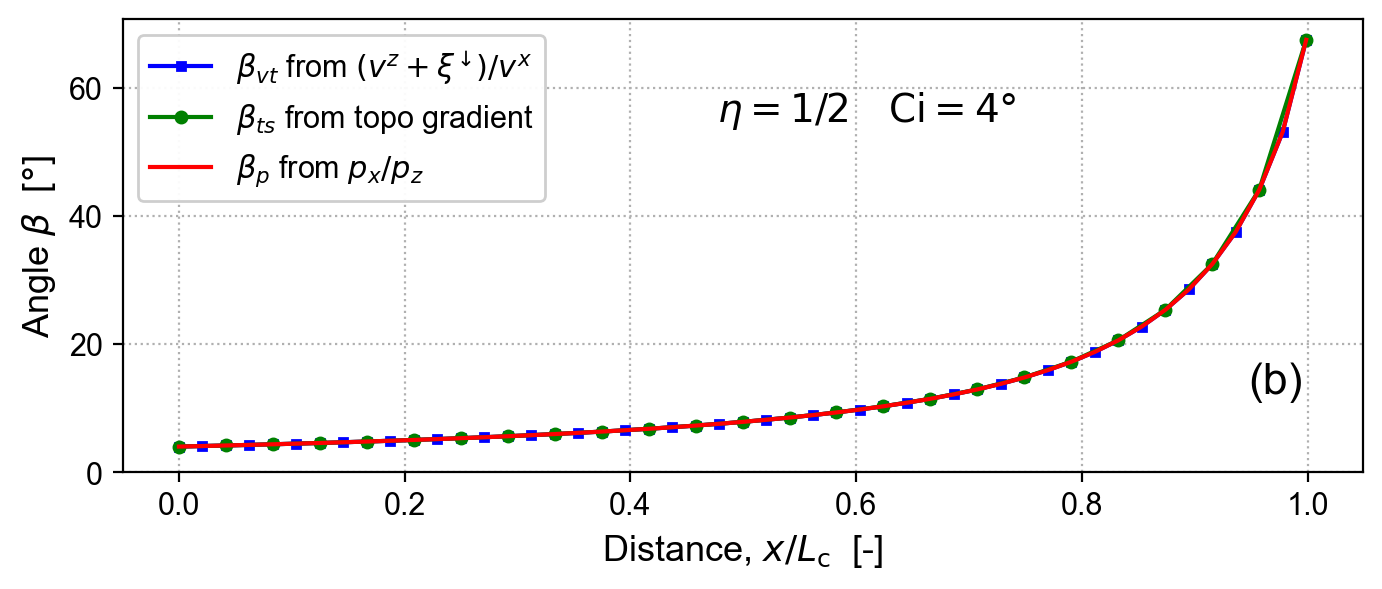

In [58]:
gr.profile_beta( gmes, gmeq, sub, job_name+'_beta', fig_size=(8,3), n_points=25,
                 do_pub_label=pr.plot.do_pub_labeling, 
                 pub_label=pr.plot.pub_labels['profile_beta'],
                 pub_label_xy=pr.plot.pub_label_posns['profile_beta'] )

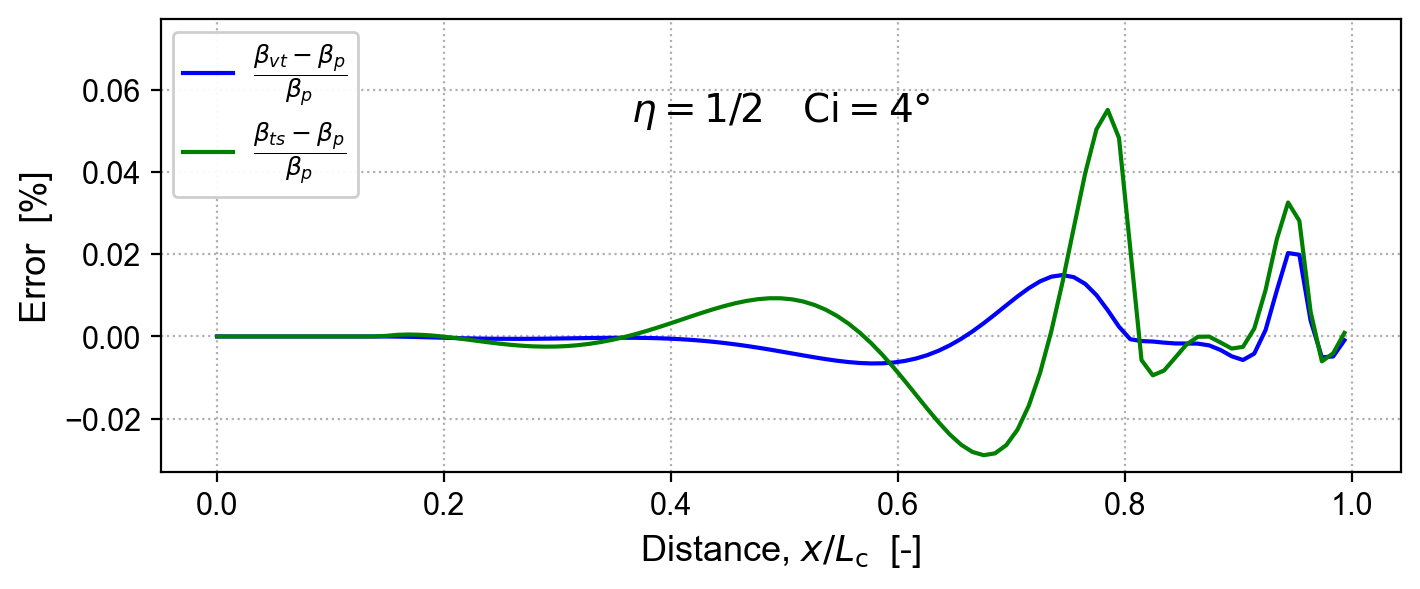

In [59]:
gr.profile_beta_error( gmes, gmeq, sub, job_name+'_beta_error', fig_size=(8,3), 
                       n_points=pr.plot.profile_n_points )

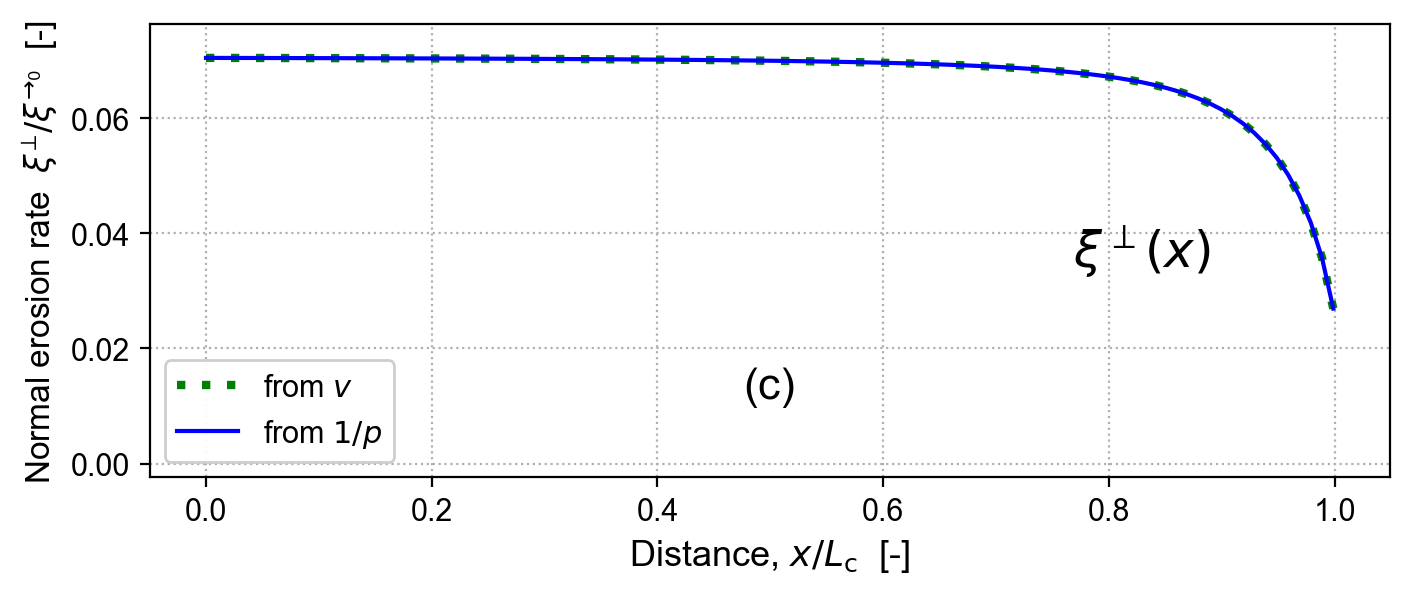

In [60]:
gr.profile_xi( gmes, gmeq, sub, job_name+'_xi', fig_size=(8,3), 
               n_points=pr.plot.profile_n_points, 
               xi_norm=1, #xih_0.subs(sub), 
               do_etaxi_label=pr.plot.do_etaxi_labeling,
               do_pub_label=pr.plot.do_pub_labeling,
               pub_label=pr.plot.pub_labels['profile_xi'] )

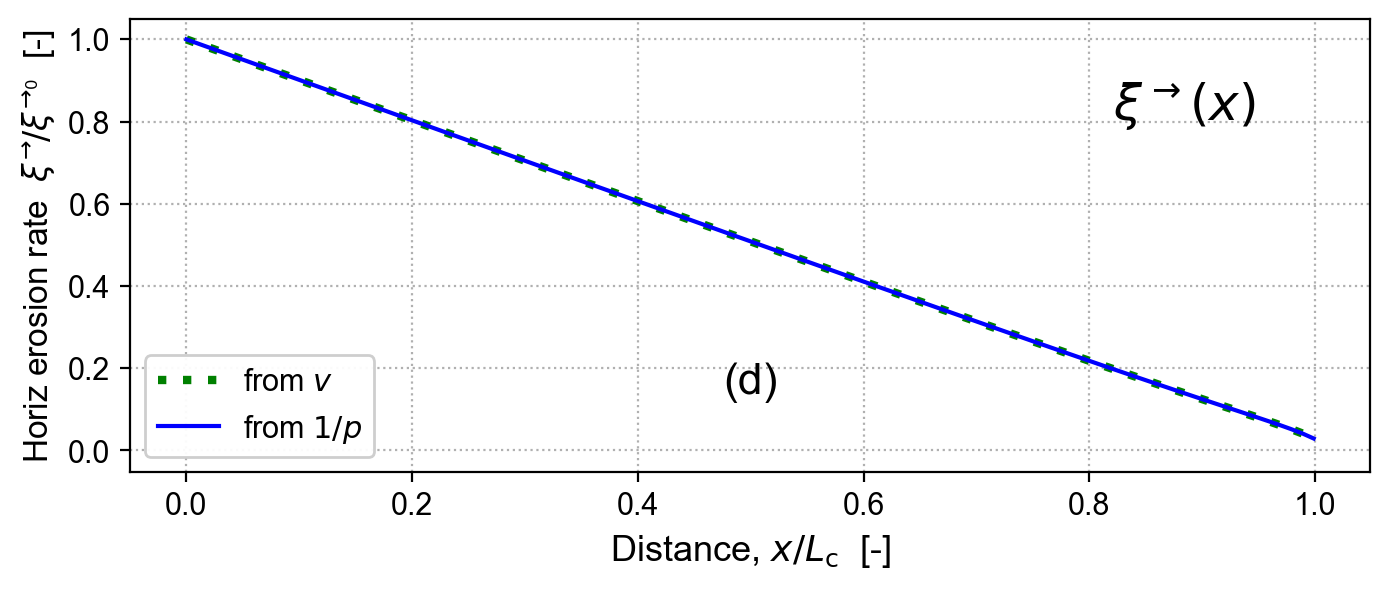

In [61]:
gr.profile_xihorizontal( gmes, gmeq, sub, job_name+'_xihorizontal', fig_size=(8,3), 
                         n_points=pr.plot.profile_n_points, 
                         xi_norm=1, #xih_0.subs(sub), 
                         do_etaxi_label=pr.plot.do_etaxi_labeling,
                         do_pub_label=pr.plot.do_pub_labeling,
                         pub_label=pr.plot.pub_labels['profile_xihorizontal'] )

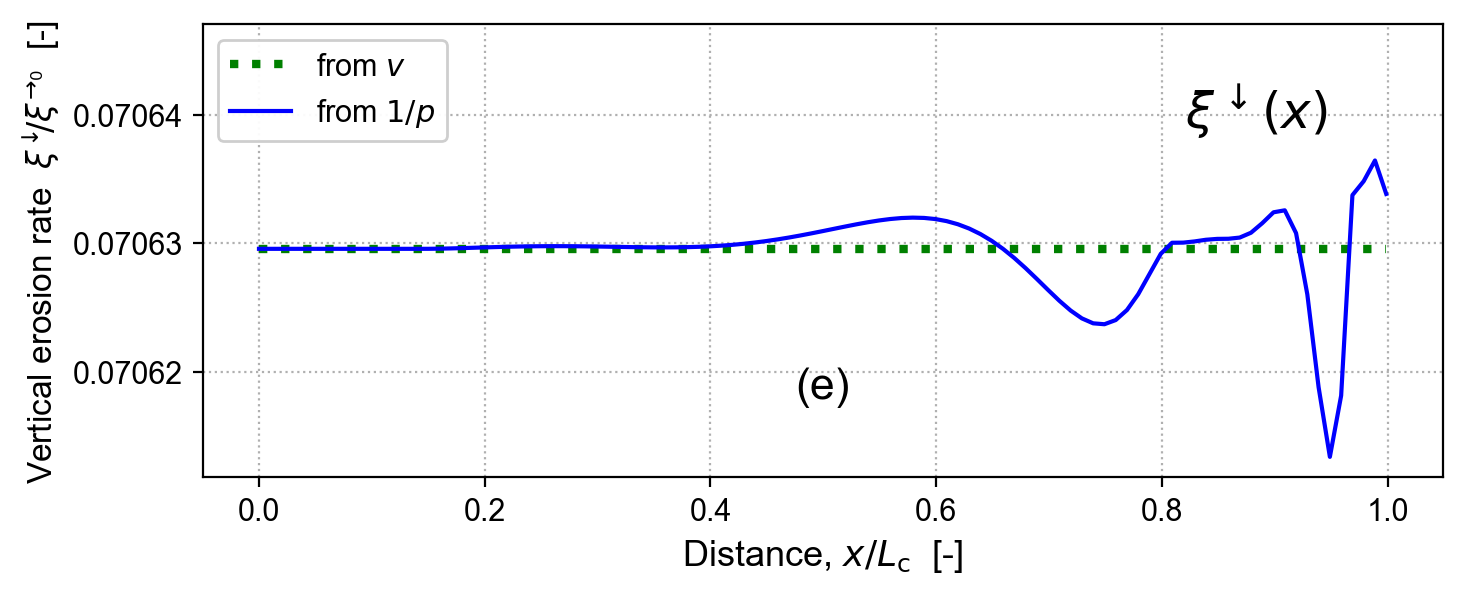

In [62]:
gr.profile_xivertical( gmes, gmeq, sub, job_name+'_xivertical', fig_size=(8,3), 
                       n_points=pr.plot.profile_n_points, 
                       xi_norm=1, #xih_0.subs(sub), 
                       do_etaxi_label=pr.plot.do_etaxi_labeling,
                       do_pub_label=pr.plot.do_pub_labeling, 
                       pub_label=pr.plot.pub_labels['profile_xivertical'] )

# Save

Export the graphs as PNG and/or PDF image files.

In [68]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/TimeInvariantSolutions"
Exported "tis_eta0p5_Ci4p0_h_rays.png"
Exported "tis_eta0p5_Ci4p0_aniso.png"
Exported "tis_eta0p5_Ci4p0_beta.png"
Exported "tis_eta0p5_Ci4p0_beta_error.png"
Exported "tis_eta0p5_Ci4p0_xi.png"
Exported "tis_eta0p5_Ci4p0_xihorizontal.png"
Exported "tis_eta0p5_Ci4p0_xivertical.png"
